In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.activation import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define input image dimensions
# Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)


In [3]:
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)


In [4]:
#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)
#The validity is the Discriminator? guess of input being real or not.


In [5]:
#Now that we have constructed our two models it? time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.



In [6]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view


##############################################################################

#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=30000, batch_size=32, save_interval=100)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trai

1/1 [==============================] - 0s 16ms/step
45 [D loss: 0.018101, acc.: 100.00%] [G loss: 4.519287]
1/1 [==============================] - 0s 18ms/step
46 [D loss: 0.012590, acc.: 100.00%] [G loss: 4.450183]
1/1 [==============================] - 0s 20ms/step
47 [D loss: 0.012124, acc.: 100.00%] [G loss: 4.401482]
1/1 [==============================] - 0s 17ms/step
48 [D loss: 0.007680, acc.: 100.00%] [G loss: 4.475433]
1/1 [==============================] - 0s 18ms/step
49 [D loss: 0.009681, acc.: 100.00%] [G loss: 4.492221]
1/1 [==============================] - 0s 17ms/step
50 [D loss: 0.019255, acc.: 100.00%] [G loss: 4.544736]
1/1 [==============================] - 0s 17ms/step
51 [D loss: 0.008411, acc.: 100.00%] [G loss: 4.483839]
1/1 [==============================] - 0s 17ms/step
52 [D loss: 0.007749, acc.: 100.00%] [G loss: 4.486526]
1/1 [==============================] - 0s 21ms/step
53 [D loss: 0.009158, acc.: 100.00%] [G loss: 4.423766]
1/1 [=======================

1/1 [==============================] - 0s 18ms/step
120 [D loss: 0.075809, acc.: 93.75%] [G loss: 5.311477]
1/1 [==============================] - 0s 16ms/step
121 [D loss: 0.011309, acc.: 100.00%] [G loss: 5.852410]
1/1 [==============================] - 0s 18ms/step
122 [D loss: 0.048515, acc.: 100.00%] [G loss: 5.508874]
1/1 [==============================] - 0s 20ms/step
123 [D loss: 0.008552, acc.: 100.00%] [G loss: 5.673076]
1/1 [==============================] - 0s 17ms/step
124 [D loss: 0.052050, acc.: 100.00%] [G loss: 5.612704]
1/1 [==============================] - 0s 19ms/step
125 [D loss: 0.037103, acc.: 100.00%] [G loss: 5.175933]
1/1 [==============================] - 0s 16ms/step
126 [D loss: 0.052734, acc.: 96.88%] [G loss: 5.669792]
1/1 [==============================] - 0s 17ms/step
127 [D loss: 0.068254, acc.: 96.88%] [G loss: 5.499466]
1/1 [==============================] - 0s 17ms/step
128 [D loss: 0.015754, acc.: 100.00%] [G loss: 5.803835]
1/1 [=================

1/1 [==============================] - 0s 18ms/step
196 [D loss: 1.083172, acc.: 50.00%] [G loss: 1.174247]
1/1 [==============================] - 0s 19ms/step
197 [D loss: 0.690773, acc.: 71.88%] [G loss: 3.308203]
1/1 [==============================] - 0s 19ms/step
198 [D loss: 0.077123, acc.: 96.88%] [G loss: 5.574001]
1/1 [==============================] - 0s 19ms/step
199 [D loss: 0.956935, acc.: 40.62%] [G loss: 1.095863]
1/1 [==============================] - 0s 21ms/step
200 [D loss: 0.848636, acc.: 62.50%] [G loss: 2.212404]
1/1 [==============================] - 0s 21ms/step
201 [D loss: 0.046180, acc.: 100.00%] [G loss: 3.720224]
1/1 [==============================] - 0s 18ms/step
202 [D loss: 0.128263, acc.: 93.75%] [G loss: 2.784553]
1/1 [==============================] - 0s 17ms/step
203 [D loss: 0.230975, acc.: 96.88%] [G loss: 3.091419]
1/1 [==============================] - 0s 17ms/step
204 [D loss: 0.099335, acc.: 96.88%] [G loss: 3.309461]
1/1 [======================

1/1 [==============================] - 0s 18ms/step
271 [D loss: 0.593058, acc.: 53.12%] [G loss: 1.296195]
1/1 [==============================] - 0s 18ms/step
272 [D loss: 0.732737, acc.: 46.88%] [G loss: 1.047049]
1/1 [==============================] - 0s 18ms/step
273 [D loss: 0.668746, acc.: 56.25%] [G loss: 0.898531]
1/1 [==============================] - 0s 17ms/step
274 [D loss: 0.698066, acc.: 43.75%] [G loss: 0.993957]
1/1 [==============================] - 0s 19ms/step
275 [D loss: 0.649386, acc.: 53.12%] [G loss: 1.075664]
1/1 [==============================] - 0s 87ms/step
276 [D loss: 0.757482, acc.: 43.75%] [G loss: 0.778572]
1/1 [==============================] - 0s 19ms/step
277 [D loss: 0.592603, acc.: 65.62%] [G loss: 1.004083]
1/1 [==============================] - 0s 20ms/step
278 [D loss: 0.571981, acc.: 56.25%] [G loss: 1.072384]
1/1 [==============================] - 0s 19ms/step
279 [D loss: 0.656092, acc.: 53.12%] [G loss: 1.134084]
1/1 [=======================

1/1 [==============================] - 0s 24ms/step
346 [D loss: 0.646022, acc.: 59.38%] [G loss: 0.711721]
1/1 [==============================] - 0s 18ms/step
347 [D loss: 0.644878, acc.: 53.12%] [G loss: 0.757607]
1/1 [==============================] - 0s 17ms/step
348 [D loss: 0.715409, acc.: 40.62%] [G loss: 0.690976]
1/1 [==============================] - 0s 18ms/step
349 [D loss: 0.691580, acc.: 50.00%] [G loss: 0.654603]
1/1 [==============================] - 0s 19ms/step
350 [D loss: 0.640842, acc.: 50.00%] [G loss: 0.709223]
1/1 [==============================] - 0s 18ms/step
351 [D loss: 0.675900, acc.: 50.00%] [G loss: 0.690973]
1/1 [==============================] - 0s 18ms/step
352 [D loss: 0.678374, acc.: 46.88%] [G loss: 0.690536]
1/1 [==============================] - 0s 33ms/step
353 [D loss: 0.696516, acc.: 46.88%] [G loss: 0.686125]
1/1 [==============================] - 0s 17ms/step
354 [D loss: 0.713226, acc.: 40.62%] [G loss: 0.674350]
1/1 [=======================

1/1 [==============================] - 0s 23ms/step
421 [D loss: 0.675831, acc.: 53.12%] [G loss: 0.674912]
1/1 [==============================] - 0s 21ms/step
422 [D loss: 0.665599, acc.: 50.00%] [G loss: 0.683464]
1/1 [==============================] - 0s 18ms/step
423 [D loss: 0.656199, acc.: 46.88%] [G loss: 0.695076]
1/1 [==============================] - 0s 17ms/step
424 [D loss: 0.691462, acc.: 43.75%] [G loss: 0.706677]
1/1 [==============================] - 0s 18ms/step
425 [D loss: 0.655672, acc.: 53.12%] [G loss: 0.685953]
1/1 [==============================] - 0s 21ms/step
426 [D loss: 0.671350, acc.: 50.00%] [G loss: 0.678469]
1/1 [==============================] - 0s 19ms/step
427 [D loss: 0.653158, acc.: 46.88%] [G loss: 0.672854]
1/1 [==============================] - 0s 18ms/step
428 [D loss: 0.681554, acc.: 40.62%] [G loss: 0.664772]
1/1 [==============================] - 0s 20ms/step
429 [D loss: 0.669791, acc.: 46.88%] [G loss: 0.719199]
1/1 [=======================

1/1 [==============================] - 0s 18ms/step
497 [D loss: 0.616021, acc.: 71.88%] [G loss: 0.751437]
1/1 [==============================] - 0s 24ms/step
498 [D loss: 0.641425, acc.: 65.62%] [G loss: 0.747046]
1/1 [==============================] - 0s 21ms/step
499 [D loss: 0.634562, acc.: 75.00%] [G loss: 0.719150]
1/1 [==============================] - 0s 15ms/step
500 [D loss: 0.613720, acc.: 78.12%] [G loss: 0.715199]
1/1 [==============================] - 0s 19ms/step
501 [D loss: 0.589716, acc.: 71.88%] [G loss: 0.711886]
1/1 [==============================] - 0s 18ms/step
502 [D loss: 0.755121, acc.: 62.50%] [G loss: 0.722892]
1/1 [==============================] - 0s 17ms/step
503 [D loss: 0.612485, acc.: 56.25%] [G loss: 0.757578]
1/1 [==============================] - 0s 18ms/step
504 [D loss: 0.648598, acc.: 56.25%] [G loss: 0.759890]
1/1 [==============================] - 0s 16ms/step
505 [D loss: 0.665969, acc.: 56.25%] [G loss: 0.733683]
1/1 [=======================

1/1 [==============================] - 0s 19ms/step
572 [D loss: 0.639908, acc.: 56.25%] [G loss: 0.779920]
1/1 [==============================] - 0s 19ms/step
573 [D loss: 0.676649, acc.: 53.12%] [G loss: 0.773472]
1/1 [==============================] - 0s 17ms/step
574 [D loss: 0.646985, acc.: 65.62%] [G loss: 0.815002]
1/1 [==============================] - 0s 17ms/step
575 [D loss: 0.606194, acc.: 68.75%] [G loss: 0.800371]
1/1 [==============================] - 0s 17ms/step
576 [D loss: 0.666593, acc.: 62.50%] [G loss: 0.733376]
1/1 [==============================] - 0s 17ms/step
577 [D loss: 0.649760, acc.: 56.25%] [G loss: 0.756911]
1/1 [==============================] - 0s 17ms/step
578 [D loss: 0.624745, acc.: 65.62%] [G loss: 0.784785]
1/1 [==============================] - 0s 16ms/step
579 [D loss: 0.689861, acc.: 59.38%] [G loss: 0.758245]
1/1 [==============================] - 0s 18ms/step
580 [D loss: 0.674614, acc.: 53.12%] [G loss: 0.707201]
1/1 [=======================

1/1 [==============================] - 0s 19ms/step
647 [D loss: 0.678997, acc.: 53.12%] [G loss: 0.767049]
1/1 [==============================] - 0s 17ms/step
648 [D loss: 0.630648, acc.: 53.12%] [G loss: 0.809839]
1/1 [==============================] - 0s 19ms/step
649 [D loss: 0.582490, acc.: 78.12%] [G loss: 0.795913]
1/1 [==============================] - 0s 19ms/step
650 [D loss: 0.682001, acc.: 56.25%] [G loss: 0.726548]
1/1 [==============================] - 0s 17ms/step
651 [D loss: 0.634690, acc.: 65.62%] [G loss: 0.719231]
1/1 [==============================] - 0s 19ms/step
652 [D loss: 0.612556, acc.: 75.00%] [G loss: 0.757557]
1/1 [==============================] - 0s 18ms/step
653 [D loss: 0.678696, acc.: 59.38%] [G loss: 0.738307]
1/1 [==============================] - 0s 18ms/step
654 [D loss: 0.614701, acc.: 75.00%] [G loss: 0.722855]
1/1 [==============================] - 0s 17ms/step
655 [D loss: 0.680085, acc.: 68.75%] [G loss: 0.757434]
1/1 [=======================

1/1 [==============================] - 0s 18ms/step
722 [D loss: 0.617525, acc.: 71.88%] [G loss: 0.829660]
1/1 [==============================] - 0s 17ms/step
723 [D loss: 0.656119, acc.: 53.12%] [G loss: 0.766446]
1/1 [==============================] - 0s 18ms/step
724 [D loss: 0.617602, acc.: 68.75%] [G loss: 0.826034]
1/1 [==============================] - 0s 16ms/step
725 [D loss: 0.632829, acc.: 56.25%] [G loss: 0.828739]
1/1 [==============================] - 0s 27ms/step
726 [D loss: 0.568430, acc.: 75.00%] [G loss: 0.842290]
1/1 [==============================] - 0s 18ms/step
727 [D loss: 0.614374, acc.: 71.88%] [G loss: 0.874698]
1/1 [==============================] - 0s 16ms/step
728 [D loss: 0.690671, acc.: 59.38%] [G loss: 0.829101]
1/1 [==============================] - 0s 17ms/step
729 [D loss: 0.635345, acc.: 56.25%] [G loss: 0.790503]
1/1 [==============================] - 0s 17ms/step
730 [D loss: 0.640935, acc.: 62.50%] [G loss: 0.786967]
1/1 [=======================

1/1 [==============================] - 0s 18ms/step
798 [D loss: 0.633465, acc.: 65.62%] [G loss: 0.760580]
1/1 [==============================] - 0s 20ms/step
799 [D loss: 0.620100, acc.: 71.88%] [G loss: 0.790556]
1/1 [==============================] - 0s 17ms/step
800 [D loss: 0.653008, acc.: 56.25%] [G loss: 0.804968]
1/1 [==============================] - 0s 18ms/step
801 [D loss: 0.566958, acc.: 75.00%] [G loss: 0.810433]
1/1 [==============================] - 0s 17ms/step
802 [D loss: 0.616385, acc.: 75.00%] [G loss: 0.725287]
1/1 [==============================] - 0s 18ms/step
803 [D loss: 0.663696, acc.: 56.25%] [G loss: 0.751122]
1/1 [==============================] - 0s 20ms/step
804 [D loss: 0.597534, acc.: 71.88%] [G loss: 0.786894]
1/1 [==============================] - 0s 19ms/step
805 [D loss: 0.737877, acc.: 43.75%] [G loss: 0.749487]
1/1 [==============================] - 0s 18ms/step
806 [D loss: 0.662283, acc.: 53.12%] [G loss: 0.739485]
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
873 [D loss: 0.631409, acc.: 62.50%] [G loss: 0.762427]
1/1 [==============================] - 0s 17ms/step
874 [D loss: 0.690372, acc.: 50.00%] [G loss: 0.742153]
1/1 [==============================] - 0s 17ms/step
875 [D loss: 0.626764, acc.: 65.62%] [G loss: 0.782209]
1/1 [==============================] - 0s 17ms/step
876 [D loss: 0.595539, acc.: 78.12%] [G loss: 0.812740]
1/1 [==============================] - 0s 16ms/step
877 [D loss: 0.679441, acc.: 59.38%] [G loss: 0.784666]
1/1 [==============================] - 0s 16ms/step
878 [D loss: 0.670656, acc.: 53.12%] [G loss: 0.746646]
1/1 [==============================] - 0s 17ms/step
879 [D loss: 0.631195, acc.: 65.62%] [G loss: 0.804086]
1/1 [==============================] - 0s 17ms/step
880 [D loss: 0.597575, acc.: 78.12%] [G loss: 0.771246]
1/1 [==============================] - 0s 18ms/step
881 [D loss: 0.657896, acc.: 59.38%] [G loss: 0.815736]
1/1 [=======================

1/1 [==============================] - 0s 19ms/step
948 [D loss: 0.637649, acc.: 59.38%] [G loss: 0.804989]
1/1 [==============================] - 0s 20ms/step
949 [D loss: 0.613885, acc.: 62.50%] [G loss: 0.794109]
1/1 [==============================] - 0s 17ms/step
950 [D loss: 0.659195, acc.: 62.50%] [G loss: 0.781837]
1/1 [==============================] - 0s 18ms/step
951 [D loss: 0.658664, acc.: 53.12%] [G loss: 0.803291]
1/1 [==============================] - 0s 17ms/step
952 [D loss: 0.674159, acc.: 56.25%] [G loss: 0.770020]
1/1 [==============================] - 0s 17ms/step
953 [D loss: 0.623118, acc.: 65.62%] [G loss: 0.719929]
1/1 [==============================] - 0s 18ms/step
954 [D loss: 0.598998, acc.: 68.75%] [G loss: 0.809830]
1/1 [==============================] - 0s 18ms/step
955 [D loss: 0.594927, acc.: 68.75%] [G loss: 0.833382]
1/1 [==============================] - 0s 18ms/step
956 [D loss: 0.706497, acc.: 46.88%] [G loss: 0.766762]
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
1023 [D loss: 0.554971, acc.: 81.25%] [G loss: 0.835225]
1/1 [==============================] - 0s 18ms/step
1024 [D loss: 0.715425, acc.: 50.00%] [G loss: 0.766392]
1/1 [==============================] - 0s 20ms/step
1025 [D loss: 0.610812, acc.: 59.38%] [G loss: 0.827921]
1/1 [==============================] - 0s 21ms/step
1026 [D loss: 0.638348, acc.: 65.62%] [G loss: 0.840819]
1/1 [==============================] - 0s 18ms/step
1027 [D loss: 0.609334, acc.: 71.88%] [G loss: 0.828695]
1/1 [==============================] - 0s 18ms/step
1028 [D loss: 0.633063, acc.: 62.50%] [G loss: 0.864231]
1/1 [==============================] - 0s 19ms/step
1029 [D loss: 0.579962, acc.: 75.00%] [G loss: 0.922549]
1/1 [==============================] - 0s 18ms/step
1030 [D loss: 0.645261, acc.: 56.25%] [G loss: 0.822750]
1/1 [==============================] - 0s 17ms/step
1031 [D loss: 0.685985, acc.: 62.50%] [G loss: 0.777585]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
1098 [D loss: 0.668481, acc.: 65.62%] [G loss: 0.833708]
1/1 [==============================] - 0s 18ms/step
1099 [D loss: 0.614201, acc.: 62.50%] [G loss: 0.805984]
1/1 [==============================] - 0s 16ms/step
1100 [D loss: 0.666305, acc.: 59.38%] [G loss: 0.782446]
1/1 [==============================] - 0s 20ms/step
1101 [D loss: 0.576712, acc.: 84.38%] [G loss: 0.816733]
1/1 [==============================] - 0s 18ms/step
1102 [D loss: 0.584475, acc.: 71.88%] [G loss: 0.821018]
1/1 [==============================] - 0s 19ms/step
1103 [D loss: 0.682697, acc.: 50.00%] [G loss: 0.773268]
1/1 [==============================] - 0s 23ms/step
1104 [D loss: 0.597608, acc.: 78.12%] [G loss: 0.805022]
1/1 [==============================] - 0s 21ms/step
1105 [D loss: 0.599712, acc.: 75.00%] [G loss: 0.793736]
1/1 [==============================] - 0s 19ms/step
1106 [D loss: 0.619590, acc.: 65.62%] [G loss: 0.761036]
1/1 [==============

1/1 [==============================] - 0s 21ms/step
1173 [D loss: 0.536805, acc.: 84.38%] [G loss: 0.855911]
1/1 [==============================] - 0s 19ms/step
1174 [D loss: 0.684632, acc.: 53.12%] [G loss: 0.824522]
1/1 [==============================] - 0s 17ms/step
1175 [D loss: 0.648033, acc.: 62.50%] [G loss: 0.790580]
1/1 [==============================] - 0s 17ms/step
1176 [D loss: 0.558548, acc.: 78.12%] [G loss: 0.857240]
1/1 [==============================] - 0s 17ms/step
1177 [D loss: 0.661725, acc.: 62.50%] [G loss: 0.823993]
1/1 [==============================] - 0s 16ms/step
1178 [D loss: 0.605564, acc.: 75.00%] [G loss: 0.813804]
1/1 [==============================] - 0s 16ms/step
1179 [D loss: 0.624199, acc.: 65.62%] [G loss: 0.827446]
1/1 [==============================] - 0s 17ms/step
1180 [D loss: 0.538905, acc.: 81.25%] [G loss: 0.855695]
1/1 [==============================] - 0s 16ms/step
1181 [D loss: 0.547665, acc.: 81.25%] [G loss: 0.779960]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
1248 [D loss: 0.642435, acc.: 59.38%] [G loss: 0.807138]
1/1 [==============================] - 0s 19ms/step
1249 [D loss: 0.643133, acc.: 56.25%] [G loss: 0.818955]
1/1 [==============================] - 0s 17ms/step
1250 [D loss: 0.566691, acc.: 78.12%] [G loss: 0.857637]
1/1 [==============================] - 0s 19ms/step
1251 [D loss: 0.593035, acc.: 78.12%] [G loss: 0.871460]
1/1 [==============================] - 0s 18ms/step
1252 [D loss: 0.613053, acc.: 71.88%] [G loss: 0.793001]
1/1 [==============================] - 0s 19ms/step
1253 [D loss: 0.625753, acc.: 65.62%] [G loss: 0.781808]
1/1 [==============================] - 0s 17ms/step
1254 [D loss: 0.597976, acc.: 81.25%] [G loss: 0.887016]
1/1 [==============================] - 0s 18ms/step
1255 [D loss: 0.656793, acc.: 59.38%] [G loss: 0.847220]
1/1 [==============================] - 0s 17ms/step
1256 [D loss: 0.641544, acc.: 59.38%] [G loss: 0.829099]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
1323 [D loss: 0.554018, acc.: 87.50%] [G loss: 0.851948]
1/1 [==============================] - 0s 17ms/step
1324 [D loss: 0.648897, acc.: 59.38%] [G loss: 0.864109]
1/1 [==============================] - 0s 18ms/step
1325 [D loss: 0.532245, acc.: 84.38%] [G loss: 0.864357]
1/1 [==============================] - 0s 23ms/step
1326 [D loss: 0.611638, acc.: 65.62%] [G loss: 0.797907]
1/1 [==============================] - 0s 66ms/step
1327 [D loss: 0.574127, acc.: 81.25%] [G loss: 0.852714]
1/1 [==============================] - 0s 17ms/step
1328 [D loss: 0.610319, acc.: 59.38%] [G loss: 0.854575]
1/1 [==============================] - 0s 18ms/step
1329 [D loss: 0.615927, acc.: 65.62%] [G loss: 0.849402]
1/1 [==============================] - 0s 18ms/step
1330 [D loss: 0.624377, acc.: 62.50%] [G loss: 0.838983]
1/1 [==============================] - 0s 17ms/step
1331 [D loss: 0.611372, acc.: 75.00%] [G loss: 0.843649]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
1398 [D loss: 0.622040, acc.: 62.50%] [G loss: 0.858005]
1/1 [==============================] - 0s 17ms/step
1399 [D loss: 0.585254, acc.: 65.62%] [G loss: 0.854313]
1/1 [==============================] - 0s 18ms/step
1400 [D loss: 0.689152, acc.: 56.25%] [G loss: 0.886550]
1/1 [==============================] - 0s 17ms/step
1401 [D loss: 0.553633, acc.: 75.00%] [G loss: 0.917691]
1/1 [==============================] - 0s 21ms/step
1402 [D loss: 0.647876, acc.: 62.50%] [G loss: 0.904830]
1/1 [==============================] - 0s 19ms/step
1403 [D loss: 0.554167, acc.: 75.00%] [G loss: 0.969631]
1/1 [==============================] - 0s 19ms/step
1404 [D loss: 0.581659, acc.: 84.38%] [G loss: 0.889260]
1/1 [==============================] - 0s 16ms/step
1405 [D loss: 0.665294, acc.: 59.38%] [G loss: 0.878057]
1/1 [==============================] - 0s 22ms/step
1406 [D loss: 0.610091, acc.: 65.62%] [G loss: 0.867054]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
1473 [D loss: 0.523496, acc.: 84.38%] [G loss: 0.827599]
1/1 [==============================] - 0s 17ms/step
1474 [D loss: 0.592883, acc.: 68.75%] [G loss: 0.943757]
1/1 [==============================] - 0s 17ms/step
1475 [D loss: 0.618301, acc.: 59.38%] [G loss: 0.886382]
1/1 [==============================] - 0s 18ms/step
1476 [D loss: 0.567969, acc.: 75.00%] [G loss: 0.906250]
1/1 [==============================] - 0s 18ms/step
1477 [D loss: 0.651675, acc.: 53.12%] [G loss: 0.878551]
1/1 [==============================] - 0s 18ms/step
1478 [D loss: 0.603651, acc.: 65.62%] [G loss: 0.923224]
1/1 [==============================] - 0s 17ms/step
1479 [D loss: 0.528980, acc.: 84.38%] [G loss: 0.975704]
1/1 [==============================] - 0s 18ms/step
1480 [D loss: 0.632876, acc.: 65.62%] [G loss: 0.836614]
1/1 [==============================] - 0s 20ms/step
1481 [D loss: 0.576959, acc.: 71.88%] [G loss: 0.808273]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
1548 [D loss: 0.559621, acc.: 81.25%] [G loss: 0.982337]
1/1 [==============================] - 0s 17ms/step
1549 [D loss: 0.586819, acc.: 71.88%] [G loss: 0.901359]
1/1 [==============================] - 0s 19ms/step
1550 [D loss: 0.540254, acc.: 68.75%] [G loss: 0.958168]
1/1 [==============================] - 0s 18ms/step
1551 [D loss: 0.633738, acc.: 56.25%] [G loss: 0.963962]
1/1 [==============================] - 0s 18ms/step
1552 [D loss: 0.621568, acc.: 68.75%] [G loss: 0.911916]
1/1 [==============================] - 0s 19ms/step
1553 [D loss: 0.622588, acc.: 81.25%] [G loss: 0.943539]
1/1 [==============================] - 0s 19ms/step
1554 [D loss: 0.583077, acc.: 68.75%] [G loss: 0.998510]
1/1 [==============================] - 0s 16ms/step
1555 [D loss: 0.622325, acc.: 59.38%] [G loss: 0.971997]
1/1 [==============================] - 0s 18ms/step
1556 [D loss: 0.605454, acc.: 65.62%] [G loss: 0.938226]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
1623 [D loss: 0.668394, acc.: 62.50%] [G loss: 0.942891]
1/1 [==============================] - 0s 21ms/step
1624 [D loss: 0.590569, acc.: 65.62%] [G loss: 0.965723]
1/1 [==============================] - 0s 17ms/step
1625 [D loss: 0.659109, acc.: 65.62%] [G loss: 0.968883]
1/1 [==============================] - 0s 19ms/step
1626 [D loss: 0.577855, acc.: 75.00%] [G loss: 0.952661]
1/1 [==============================] - 0s 19ms/step
1627 [D loss: 0.592065, acc.: 71.88%] [G loss: 0.992840]
1/1 [==============================] - 0s 18ms/step
1628 [D loss: 0.668186, acc.: 50.00%] [G loss: 0.899572]
1/1 [==============================] - 0s 18ms/step
1629 [D loss: 0.591443, acc.: 65.62%] [G loss: 0.840650]
1/1 [==============================] - 0s 18ms/step
1630 [D loss: 0.555671, acc.: 81.25%] [G loss: 0.865376]
1/1 [==============================] - 0s 17ms/step
1631 [D loss: 0.488647, acc.: 84.38%] [G loss: 0.936963]
1/1 [==============

1/1 [==============================] - 0s 21ms/step
1698 [D loss: 0.578767, acc.: 81.25%] [G loss: 0.886384]
1/1 [==============================] - 0s 22ms/step
1699 [D loss: 0.601127, acc.: 68.75%] [G loss: 0.869273]
1/1 [==============================] - 0s 18ms/step
1700 [D loss: 0.751413, acc.: 43.75%] [G loss: 0.869442]
1/1 [==============================] - 0s 19ms/step
1701 [D loss: 0.658128, acc.: 62.50%] [G loss: 0.981647]
1/1 [==============================] - 0s 19ms/step
1702 [D loss: 0.595572, acc.: 65.62%] [G loss: 0.877032]
1/1 [==============================] - 0s 18ms/step
1703 [D loss: 0.624499, acc.: 62.50%] [G loss: 0.829210]
1/1 [==============================] - 0s 19ms/step
1704 [D loss: 0.590340, acc.: 68.75%] [G loss: 0.859968]
1/1 [==============================] - 0s 21ms/step
1705 [D loss: 0.623992, acc.: 62.50%] [G loss: 0.942378]
1/1 [==============================] - 0s 19ms/step
1706 [D loss: 0.652698, acc.: 59.38%] [G loss: 0.931582]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
1773 [D loss: 0.710531, acc.: 50.00%] [G loss: 0.908564]
1/1 [==============================] - 0s 18ms/step
1774 [D loss: 0.544120, acc.: 71.88%] [G loss: 0.943382]
1/1 [==============================] - 0s 18ms/step
1775 [D loss: 0.460516, acc.: 93.75%] [G loss: 0.985513]
1/1 [==============================] - 0s 18ms/step
1776 [D loss: 0.583665, acc.: 78.12%] [G loss: 0.972210]
1/1 [==============================] - 0s 17ms/step
1777 [D loss: 0.563990, acc.: 65.62%] [G loss: 0.972009]
1/1 [==============================] - 0s 19ms/step
1778 [D loss: 0.599170, acc.: 75.00%] [G loss: 0.972111]
1/1 [==============================] - 0s 17ms/step
1779 [D loss: 0.617886, acc.: 65.62%] [G loss: 0.894787]
1/1 [==============================] - 0s 19ms/step
1780 [D loss: 0.583322, acc.: 75.00%] [G loss: 0.949808]
1/1 [==============================] - 0s 17ms/step
1781 [D loss: 0.638441, acc.: 62.50%] [G loss: 0.925494]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
1848 [D loss: 0.643767, acc.: 62.50%] [G loss: 0.989148]
1/1 [==============================] - 0s 18ms/step
1849 [D loss: 0.517167, acc.: 75.00%] [G loss: 1.010304]
1/1 [==============================] - 0s 22ms/step
1850 [D loss: 0.613806, acc.: 65.62%] [G loss: 0.979481]
1/1 [==============================] - 0s 17ms/step
1851 [D loss: 0.619753, acc.: 71.88%] [G loss: 0.870354]
1/1 [==============================] - 0s 17ms/step
1852 [D loss: 0.597420, acc.: 65.62%] [G loss: 0.871797]
1/1 [==============================] - 0s 19ms/step
1853 [D loss: 0.480596, acc.: 87.50%] [G loss: 0.919649]
1/1 [==============================] - 0s 18ms/step
1854 [D loss: 0.632263, acc.: 65.62%] [G loss: 0.924821]
1/1 [==============================] - 0s 18ms/step
1855 [D loss: 0.526249, acc.: 78.12%] [G loss: 0.934891]
1/1 [==============================] - 0s 19ms/step
1856 [D loss: 0.555493, acc.: 75.00%] [G loss: 1.008097]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
1923 [D loss: 0.676745, acc.: 68.75%] [G loss: 0.917025]
1/1 [==============================] - 0s 20ms/step
1924 [D loss: 0.603864, acc.: 68.75%] [G loss: 0.899579]
1/1 [==============================] - 0s 18ms/step
1925 [D loss: 0.536785, acc.: 78.12%] [G loss: 0.920276]
1/1 [==============================] - 0s 19ms/step
1926 [D loss: 0.651705, acc.: 56.25%] [G loss: 0.974029]
1/1 [==============================] - 0s 21ms/step
1927 [D loss: 0.637922, acc.: 65.62%] [G loss: 0.866606]
1/1 [==============================] - 0s 18ms/step
1928 [D loss: 0.649460, acc.: 53.12%] [G loss: 0.847796]
1/1 [==============================] - 0s 17ms/step
1929 [D loss: 0.729793, acc.: 46.88%] [G loss: 0.797891]
1/1 [==============================] - 0s 18ms/step
1930 [D loss: 0.596388, acc.: 59.38%] [G loss: 0.920433]
1/1 [==============================] - 0s 18ms/step
1931 [D loss: 0.516904, acc.: 81.25%] [G loss: 0.881996]
1/1 [==============

1/1 [==============================] - 0s 21ms/step
1998 [D loss: 0.547616, acc.: 65.62%] [G loss: 0.982610]
1/1 [==============================] - 0s 20ms/step
1999 [D loss: 0.628451, acc.: 62.50%] [G loss: 0.854796]
1/1 [==============================] - 0s 17ms/step
2000 [D loss: 0.546582, acc.: 71.88%] [G loss: 0.980774]
1/1 [==============================] - 0s 21ms/step
2001 [D loss: 0.533452, acc.: 75.00%] [G loss: 1.060210]
1/1 [==============================] - 0s 17ms/step
2002 [D loss: 0.528938, acc.: 81.25%] [G loss: 0.977311]
1/1 [==============================] - 0s 17ms/step
2003 [D loss: 0.601075, acc.: 59.38%] [G loss: 1.008826]
1/1 [==============================] - 0s 17ms/step
2004 [D loss: 0.657387, acc.: 65.62%] [G loss: 0.996280]
1/1 [==============================] - 0s 18ms/step
2005 [D loss: 0.557894, acc.: 81.25%] [G loss: 0.944664]
1/1 [==============================] - 0s 18ms/step
2006 [D loss: 0.605804, acc.: 59.38%] [G loss: 0.939165]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
2073 [D loss: 0.657382, acc.: 65.62%] [G loss: 0.878936]
1/1 [==============================] - 0s 24ms/step
2074 [D loss: 0.581378, acc.: 65.62%] [G loss: 0.941136]
1/1 [==============================] - 0s 18ms/step
2075 [D loss: 0.582221, acc.: 62.50%] [G loss: 0.970091]
1/1 [==============================] - 0s 18ms/step
2076 [D loss: 0.577690, acc.: 81.25%] [G loss: 1.011481]
1/1 [==============================] - 0s 18ms/step
2077 [D loss: 0.671788, acc.: 56.25%] [G loss: 0.963394]
1/1 [==============================] - 0s 18ms/step
2078 [D loss: 0.541401, acc.: 71.88%] [G loss: 0.945850]
1/1 [==============================] - 0s 22ms/step
2079 [D loss: 0.613735, acc.: 59.38%] [G loss: 0.968097]
1/1 [==============================] - 0s 18ms/step
2080 [D loss: 0.571715, acc.: 78.12%] [G loss: 1.050971]
1/1 [==============================] - 0s 17ms/step
2081 [D loss: 0.539567, acc.: 75.00%] [G loss: 1.014956]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
2148 [D loss: 0.673100, acc.: 56.25%] [G loss: 0.964856]
1/1 [==============================] - 0s 18ms/step
2149 [D loss: 0.688829, acc.: 59.38%] [G loss: 0.896818]
1/1 [==============================] - 0s 17ms/step
2150 [D loss: 0.666408, acc.: 59.38%] [G loss: 0.874891]
1/1 [==============================] - 0s 20ms/step
2151 [D loss: 0.608882, acc.: 68.75%] [G loss: 0.867509]
1/1 [==============================] - 0s 17ms/step
2152 [D loss: 0.673994, acc.: 59.38%] [G loss: 0.862069]
1/1 [==============================] - 0s 16ms/step
2153 [D loss: 0.613373, acc.: 71.88%] [G loss: 0.838308]
1/1 [==============================] - 0s 16ms/step
2154 [D loss: 0.591952, acc.: 68.75%] [G loss: 0.894289]
1/1 [==============================] - 0s 17ms/step
2155 [D loss: 0.684776, acc.: 62.50%] [G loss: 0.862167]
1/1 [==============================] - 0s 20ms/step
2156 [D loss: 0.597446, acc.: 59.38%] [G loss: 0.934747]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
2223 [D loss: 0.702567, acc.: 46.88%] [G loss: 1.013076]
1/1 [==============================] - 0s 19ms/step
2224 [D loss: 0.628680, acc.: 65.62%] [G loss: 0.991323]
1/1 [==============================] - 0s 19ms/step
2225 [D loss: 0.531974, acc.: 78.12%] [G loss: 1.042403]
1/1 [==============================] - 0s 17ms/step
2226 [D loss: 0.697359, acc.: 56.25%] [G loss: 0.947123]
1/1 [==============================] - 0s 19ms/step
2227 [D loss: 0.594739, acc.: 59.38%] [G loss: 0.947159]
1/1 [==============================] - 0s 17ms/step
2228 [D loss: 0.626484, acc.: 62.50%] [G loss: 0.935456]
1/1 [==============================] - 0s 18ms/step
2229 [D loss: 0.611016, acc.: 68.75%] [G loss: 0.981855]
1/1 [==============================] - 0s 17ms/step
2230 [D loss: 0.720238, acc.: 53.12%] [G loss: 0.822691]
1/1 [==============================] - 0s 17ms/step
2231 [D loss: 0.568292, acc.: 65.62%] [G loss: 0.859656]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
2298 [D loss: 0.614809, acc.: 62.50%] [G loss: 0.944363]
1/1 [==============================] - 0s 19ms/step
2299 [D loss: 0.614819, acc.: 71.88%] [G loss: 0.967524]
1/1 [==============================] - 0s 22ms/step
2300 [D loss: 0.649145, acc.: 62.50%] [G loss: 0.974240]
1/1 [==============================] - 0s 21ms/step
2301 [D loss: 0.563970, acc.: 71.88%] [G loss: 0.906170]
1/1 [==============================] - 0s 19ms/step
2302 [D loss: 0.669434, acc.: 56.25%] [G loss: 0.889666]
1/1 [==============================] - 0s 21ms/step
2303 [D loss: 0.564206, acc.: 78.12%] [G loss: 0.936833]
1/1 [==============================] - 0s 19ms/step
2304 [D loss: 0.555105, acc.: 68.75%] [G loss: 0.950998]
1/1 [==============================] - 0s 18ms/step
2305 [D loss: 0.587537, acc.: 68.75%] [G loss: 0.895427]
1/1 [==============================] - 0s 19ms/step
2306 [D loss: 0.623884, acc.: 62.50%] [G loss: 0.943979]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
2373 [D loss: 0.611854, acc.: 71.88%] [G loss: 0.970138]
1/1 [==============================] - 0s 19ms/step
2374 [D loss: 0.672333, acc.: 53.12%] [G loss: 0.895978]
1/1 [==============================] - 0s 23ms/step
2375 [D loss: 0.679699, acc.: 53.12%] [G loss: 0.895195]
1/1 [==============================] - 0s 19ms/step
2376 [D loss: 0.492490, acc.: 78.12%] [G loss: 0.890271]
1/1 [==============================] - 0s 19ms/step
2377 [D loss: 0.589326, acc.: 62.50%] [G loss: 0.976776]
1/1 [==============================] - 0s 17ms/step
2378 [D loss: 0.689544, acc.: 56.25%] [G loss: 0.964435]
1/1 [==============================] - 0s 21ms/step
2379 [D loss: 0.638633, acc.: 56.25%] [G loss: 0.987331]
1/1 [==============================] - 0s 17ms/step
2380 [D loss: 0.612514, acc.: 78.12%] [G loss: 0.902763]
1/1 [==============================] - 0s 17ms/step
2381 [D loss: 0.622671, acc.: 65.62%] [G loss: 0.918289]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
2448 [D loss: 0.494262, acc.: 78.12%] [G loss: 0.986780]
1/1 [==============================] - 0s 16ms/step
2449 [D loss: 0.646335, acc.: 56.25%] [G loss: 1.084761]
1/1 [==============================] - 0s 17ms/step
2450 [D loss: 0.639130, acc.: 56.25%] [G loss: 1.026796]
1/1 [==============================] - 0s 18ms/step
2451 [D loss: 0.657781, acc.: 59.38%] [G loss: 1.007320]
1/1 [==============================] - 0s 20ms/step
2452 [D loss: 0.551317, acc.: 68.75%] [G loss: 0.972443]
1/1 [==============================] - 0s 22ms/step
2453 [D loss: 0.654204, acc.: 59.38%] [G loss: 0.858229]
1/1 [==============================] - 0s 17ms/step
2454 [D loss: 0.637913, acc.: 68.75%] [G loss: 0.816098]
1/1 [==============================] - 0s 18ms/step
2455 [D loss: 0.614482, acc.: 62.50%] [G loss: 0.857915]
1/1 [==============================] - 0s 18ms/step
2456 [D loss: 0.668223, acc.: 56.25%] [G loss: 0.912020]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
2523 [D loss: 0.630491, acc.: 65.62%] [G loss: 0.854674]
1/1 [==============================] - 0s 18ms/step
2524 [D loss: 0.573408, acc.: 71.88%] [G loss: 0.874520]
1/1 [==============================] - 0s 20ms/step
2525 [D loss: 0.704281, acc.: 59.38%] [G loss: 0.876226]
1/1 [==============================] - 0s 21ms/step
2526 [D loss: 0.607778, acc.: 62.50%] [G loss: 0.901836]
1/1 [==============================] - 0s 18ms/step
2527 [D loss: 0.713800, acc.: 43.75%] [G loss: 0.934795]
1/1 [==============================] - 0s 18ms/step
2528 [D loss: 0.662331, acc.: 65.62%] [G loss: 0.975501]
1/1 [==============================] - 0s 18ms/step
2529 [D loss: 0.595022, acc.: 71.88%] [G loss: 1.054016]
1/1 [==============================] - 0s 19ms/step
2530 [D loss: 0.671837, acc.: 65.62%] [G loss: 1.000807]
1/1 [==============================] - 0s 18ms/step
2531 [D loss: 0.686964, acc.: 53.12%] [G loss: 0.891976]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
2598 [D loss: 0.642699, acc.: 59.38%] [G loss: 0.903765]
1/1 [==============================] - 0s 19ms/step
2599 [D loss: 0.619681, acc.: 68.75%] [G loss: 0.798977]
1/1 [==============================] - 0s 18ms/step
2600 [D loss: 0.729402, acc.: 53.12%] [G loss: 0.864275]
1/1 [==============================] - 0s 18ms/step
2601 [D loss: 0.601742, acc.: 62.50%] [G loss: 0.910638]
1/1 [==============================] - 0s 18ms/step
2602 [D loss: 0.600002, acc.: 59.38%] [G loss: 0.898189]
1/1 [==============================] - 0s 17ms/step
2603 [D loss: 0.616058, acc.: 56.25%] [G loss: 0.890003]
1/1 [==============================] - 0s 18ms/step
2604 [D loss: 0.567988, acc.: 78.12%] [G loss: 0.966739]
1/1 [==============================] - 0s 20ms/step
2605 [D loss: 0.622211, acc.: 62.50%] [G loss: 0.863474]
1/1 [==============================] - 0s 22ms/step
2606 [D loss: 0.582138, acc.: 71.88%] [G loss: 0.861323]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
2673 [D loss: 0.592721, acc.: 81.25%] [G loss: 0.921197]
1/1 [==============================] - 0s 17ms/step
2674 [D loss: 0.699749, acc.: 50.00%] [G loss: 0.886647]
1/1 [==============================] - 0s 19ms/step
2675 [D loss: 0.581018, acc.: 62.50%] [G loss: 0.872588]
1/1 [==============================] - 0s 19ms/step
2676 [D loss: 0.634992, acc.: 65.62%] [G loss: 0.948454]
1/1 [==============================] - 0s 21ms/step
2677 [D loss: 0.579231, acc.: 78.12%] [G loss: 0.811822]
1/1 [==============================] - 0s 17ms/step
2678 [D loss: 0.634662, acc.: 65.62%] [G loss: 0.850983]
1/1 [==============================] - 0s 17ms/step
2679 [D loss: 0.565750, acc.: 68.75%] [G loss: 0.919677]
1/1 [==============================] - 0s 18ms/step
2680 [D loss: 0.619801, acc.: 71.88%] [G loss: 0.897784]
1/1 [==============================] - 0s 18ms/step
2681 [D loss: 0.596679, acc.: 71.88%] [G loss: 0.920799]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
2748 [D loss: 0.772283, acc.: 50.00%] [G loss: 0.912056]
1/1 [==============================] - 0s 20ms/step
2749 [D loss: 0.646860, acc.: 65.62%] [G loss: 0.907711]
1/1 [==============================] - 0s 19ms/step
2750 [D loss: 0.695695, acc.: 53.12%] [G loss: 0.904758]
1/1 [==============================] - 0s 17ms/step
2751 [D loss: 0.629820, acc.: 71.88%] [G loss: 0.899315]
1/1 [==============================] - 0s 17ms/step
2752 [D loss: 0.669199, acc.: 50.00%] [G loss: 0.881659]
1/1 [==============================] - 0s 17ms/step
2753 [D loss: 0.633806, acc.: 62.50%] [G loss: 0.932626]
1/1 [==============================] - 0s 19ms/step
2754 [D loss: 0.561849, acc.: 81.25%] [G loss: 0.915618]
1/1 [==============================] - 0s 18ms/step
2755 [D loss: 0.677561, acc.: 50.00%] [G loss: 1.010243]
1/1 [==============================] - 0s 17ms/step
2756 [D loss: 0.651728, acc.: 71.88%] [G loss: 0.905431]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
2823 [D loss: 0.569213, acc.: 68.75%] [G loss: 0.917369]
1/1 [==============================] - 0s 17ms/step
2824 [D loss: 0.649515, acc.: 62.50%] [G loss: 0.861691]
1/1 [==============================] - 0s 18ms/step
2825 [D loss: 0.623231, acc.: 65.62%] [G loss: 0.844032]
1/1 [==============================] - 0s 16ms/step
2826 [D loss: 0.576244, acc.: 75.00%] [G loss: 0.808661]
1/1 [==============================] - 0s 17ms/step
2827 [D loss: 0.631691, acc.: 62.50%] [G loss: 0.893982]
1/1 [==============================] - 0s 18ms/step
2828 [D loss: 0.662751, acc.: 59.38%] [G loss: 0.834438]
1/1 [==============================] - 0s 18ms/step
2829 [D loss: 0.638388, acc.: 62.50%] [G loss: 0.881476]
1/1 [==============================] - 0s 18ms/step
2830 [D loss: 0.625441, acc.: 62.50%] [G loss: 0.905989]
1/1 [==============================] - 0s 18ms/step
2831 [D loss: 0.656976, acc.: 59.38%] [G loss: 0.868223]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
2898 [D loss: 0.713822, acc.: 50.00%] [G loss: 1.044575]
1/1 [==============================] - 0s 19ms/step
2899 [D loss: 0.745085, acc.: 53.12%] [G loss: 0.985642]
1/1 [==============================] - 0s 19ms/step
2900 [D loss: 0.614344, acc.: 78.12%] [G loss: 0.852581]
1/1 [==============================] - 0s 18ms/step
2901 [D loss: 0.647365, acc.: 59.38%] [G loss: 0.954888]
1/1 [==============================] - 0s 20ms/step
2902 [D loss: 0.662102, acc.: 59.38%] [G loss: 0.962095]
1/1 [==============================] - 0s 19ms/step
2903 [D loss: 0.633406, acc.: 65.62%] [G loss: 0.984713]
1/1 [==============================] - 0s 18ms/step
2904 [D loss: 0.748084, acc.: 50.00%] [G loss: 0.922763]
1/1 [==============================] - 0s 19ms/step
2905 [D loss: 0.467175, acc.: 90.62%] [G loss: 0.973337]
1/1 [==============================] - 0s 17ms/step
2906 [D loss: 0.650009, acc.: 71.88%] [G loss: 0.860423]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
2973 [D loss: 0.599953, acc.: 75.00%] [G loss: 0.885437]
1/1 [==============================] - 0s 18ms/step
2974 [D loss: 0.612492, acc.: 62.50%] [G loss: 0.940894]
1/1 [==============================] - 0s 25ms/step
2975 [D loss: 0.663874, acc.: 56.25%] [G loss: 0.985365]
1/1 [==============================] - 0s 19ms/step
2976 [D loss: 0.638589, acc.: 56.25%] [G loss: 0.862583]
1/1 [==============================] - 0s 17ms/step
2977 [D loss: 0.608749, acc.: 68.75%] [G loss: 0.910797]
1/1 [==============================] - 0s 18ms/step
2978 [D loss: 0.576469, acc.: 81.25%] [G loss: 0.872763]
1/1 [==============================] - 0s 19ms/step
2979 [D loss: 0.606403, acc.: 75.00%] [G loss: 0.855985]
1/1 [==============================] - 0s 18ms/step
2980 [D loss: 0.752572, acc.: 46.88%] [G loss: 0.861749]
1/1 [==============================] - 0s 20ms/step
2981 [D loss: 0.614860, acc.: 68.75%] [G loss: 0.848913]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
3048 [D loss: 0.644059, acc.: 62.50%] [G loss: 0.985736]
1/1 [==============================] - 0s 19ms/step
3049 [D loss: 0.633401, acc.: 68.75%] [G loss: 0.904470]
1/1 [==============================] - 0s 22ms/step
3050 [D loss: 0.686769, acc.: 53.12%] [G loss: 0.922621]
1/1 [==============================] - 0s 18ms/step
3051 [D loss: 0.681280, acc.: 56.25%] [G loss: 0.860980]
1/1 [==============================] - 0s 19ms/step
3052 [D loss: 0.725106, acc.: 40.62%] [G loss: 0.883333]
1/1 [==============================] - 0s 18ms/step
3053 [D loss: 0.579085, acc.: 75.00%] [G loss: 0.891752]
1/1 [==============================] - 0s 18ms/step
3054 [D loss: 0.600686, acc.: 65.62%] [G loss: 0.895906]
1/1 [==============================] - 0s 18ms/step
3055 [D loss: 0.696272, acc.: 59.38%] [G loss: 0.875716]
1/1 [==============================] - 0s 19ms/step
3056 [D loss: 0.576291, acc.: 87.50%] [G loss: 0.913494]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
3123 [D loss: 0.569797, acc.: 75.00%] [G loss: 0.900962]
1/1 [==============================] - 0s 22ms/step
3124 [D loss: 0.607705, acc.: 59.38%] [G loss: 0.893964]
1/1 [==============================] - 0s 18ms/step
3125 [D loss: 0.672437, acc.: 50.00%] [G loss: 0.953988]
1/1 [==============================] - 0s 22ms/step
3126 [D loss: 0.653071, acc.: 68.75%] [G loss: 0.898791]
1/1 [==============================] - 0s 18ms/step
3127 [D loss: 0.667467, acc.: 56.25%] [G loss: 0.945640]
1/1 [==============================] - 0s 19ms/step
3128 [D loss: 0.609414, acc.: 62.50%] [G loss: 1.021513]
1/1 [==============================] - 0s 18ms/step
3129 [D loss: 0.683915, acc.: 68.75%] [G loss: 0.951396]
1/1 [==============================] - 0s 19ms/step
3130 [D loss: 0.729341, acc.: 46.88%] [G loss: 0.842717]
1/1 [==============================] - 0s 18ms/step
3131 [D loss: 0.663533, acc.: 59.38%] [G loss: 0.862799]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
3198 [D loss: 0.658151, acc.: 62.50%] [G loss: 0.817220]
1/1 [==============================] - 0s 19ms/step
3199 [D loss: 0.677498, acc.: 59.38%] [G loss: 0.924578]
1/1 [==============================] - 0s 24ms/step
3200 [D loss: 0.645942, acc.: 68.75%] [G loss: 0.912659]
1/1 [==============================] - 0s 18ms/step
3201 [D loss: 0.623328, acc.: 56.25%] [G loss: 0.886214]
1/1 [==============================] - 0s 18ms/step
3202 [D loss: 0.575552, acc.: 75.00%] [G loss: 0.884945]
1/1 [==============================] - 0s 17ms/step
3203 [D loss: 0.715198, acc.: 43.75%] [G loss: 0.873732]
1/1 [==============================] - 0s 20ms/step
3204 [D loss: 0.554495, acc.: 65.62%] [G loss: 0.884771]
1/1 [==============================] - 0s 18ms/step
3205 [D loss: 0.531680, acc.: 71.88%] [G loss: 0.936486]
1/1 [==============================] - 0s 18ms/step
3206 [D loss: 0.658736, acc.: 50.00%] [G loss: 0.950680]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
3273 [D loss: 0.614107, acc.: 68.75%] [G loss: 0.875939]
1/1 [==============================] - 0s 21ms/step
3274 [D loss: 0.617492, acc.: 65.62%] [G loss: 0.926618]
1/1 [==============================] - 0s 17ms/step
3275 [D loss: 0.570242, acc.: 68.75%] [G loss: 0.836244]
1/1 [==============================] - 0s 19ms/step
3276 [D loss: 0.558290, acc.: 68.75%] [G loss: 0.991559]
1/1 [==============================] - 0s 19ms/step
3277 [D loss: 0.695515, acc.: 59.38%] [G loss: 0.948399]
1/1 [==============================] - 0s 16ms/step
3278 [D loss: 0.734451, acc.: 50.00%] [G loss: 1.006810]
1/1 [==============================] - 0s 18ms/step
3279 [D loss: 0.565691, acc.: 75.00%] [G loss: 1.012824]
1/1 [==============================] - 0s 18ms/step
3280 [D loss: 0.685585, acc.: 53.12%] [G loss: 0.942235]
1/1 [==============================] - 0s 19ms/step
3281 [D loss: 0.665184, acc.: 53.12%] [G loss: 0.918110]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
3348 [D loss: 0.667675, acc.: 56.25%] [G loss: 0.963190]
1/1 [==============================] - 0s 19ms/step
3349 [D loss: 0.654449, acc.: 65.62%] [G loss: 0.923483]
1/1 [==============================] - 0s 17ms/step
3350 [D loss: 0.632930, acc.: 62.50%] [G loss: 0.896420]
1/1 [==============================] - 0s 17ms/step
3351 [D loss: 0.686613, acc.: 53.12%] [G loss: 0.893784]
1/1 [==============================] - 0s 18ms/step
3352 [D loss: 0.654519, acc.: 65.62%] [G loss: 0.880412]
1/1 [==============================] - 0s 18ms/step
3353 [D loss: 0.686829, acc.: 50.00%] [G loss: 0.941311]
1/1 [==============================] - 0s 17ms/step
3354 [D loss: 0.610141, acc.: 65.62%] [G loss: 0.971236]
1/1 [==============================] - 0s 22ms/step
3355 [D loss: 0.685854, acc.: 53.12%] [G loss: 0.870039]
1/1 [==============================] - 0s 18ms/step
3356 [D loss: 0.606874, acc.: 65.62%] [G loss: 0.868699]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
3423 [D loss: 0.637577, acc.: 68.75%] [G loss: 0.936022]
1/1 [==============================] - 0s 22ms/step
3424 [D loss: 0.555428, acc.: 68.75%] [G loss: 0.965118]
1/1 [==============================] - 0s 20ms/step
3425 [D loss: 0.577532, acc.: 71.88%] [G loss: 0.902102]
1/1 [==============================] - 0s 18ms/step
3426 [D loss: 0.600210, acc.: 68.75%] [G loss: 0.858205]
1/1 [==============================] - 0s 20ms/step
3427 [D loss: 0.674207, acc.: 56.25%] [G loss: 0.885013]
1/1 [==============================] - 0s 18ms/step
3428 [D loss: 0.472326, acc.: 81.25%] [G loss: 0.942738]
1/1 [==============================] - 0s 18ms/step
3429 [D loss: 0.623131, acc.: 56.25%] [G loss: 0.903837]
1/1 [==============================] - 0s 18ms/step
3430 [D loss: 0.624925, acc.: 62.50%] [G loss: 0.953756]
1/1 [==============================] - 0s 17ms/step
3431 [D loss: 0.679735, acc.: 56.25%] [G loss: 0.957721]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
3498 [D loss: 0.581165, acc.: 68.75%] [G loss: 0.916376]
1/1 [==============================] - 0s 17ms/step
3499 [D loss: 0.662459, acc.: 65.62%] [G loss: 0.852445]
1/1 [==============================] - 0s 19ms/step
3500 [D loss: 0.599319, acc.: 65.62%] [G loss: 0.902842]
1/1 [==============================] - 0s 21ms/step
3501 [D loss: 0.673083, acc.: 56.25%] [G loss: 0.865442]
1/1 [==============================] - 0s 17ms/step
3502 [D loss: 0.550638, acc.: 68.75%] [G loss: 0.927621]
1/1 [==============================] - 0s 18ms/step
3503 [D loss: 0.748221, acc.: 50.00%] [G loss: 0.853102]
1/1 [==============================] - 0s 20ms/step
3504 [D loss: 0.651740, acc.: 68.75%] [G loss: 0.928220]
1/1 [==============================] - 0s 20ms/step
3505 [D loss: 0.680004, acc.: 59.38%] [G loss: 0.972697]
1/1 [==============================] - 0s 19ms/step
3506 [D loss: 0.606684, acc.: 75.00%] [G loss: 0.960102]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
3573 [D loss: 0.672180, acc.: 53.12%] [G loss: 0.870887]
1/1 [==============================] - 0s 19ms/step
3574 [D loss: 0.555903, acc.: 84.38%] [G loss: 0.953124]
1/1 [==============================] - 0s 19ms/step
3575 [D loss: 0.610480, acc.: 68.75%] [G loss: 0.908277]
1/1 [==============================] - 0s 19ms/step
3576 [D loss: 0.611432, acc.: 75.00%] [G loss: 0.880337]
1/1 [==============================] - 0s 18ms/step
3577 [D loss: 0.589534, acc.: 75.00%] [G loss: 0.868429]
1/1 [==============================] - 0s 19ms/step
3578 [D loss: 0.653794, acc.: 59.38%] [G loss: 0.868755]
1/1 [==============================] - 0s 42ms/step
3579 [D loss: 0.609749, acc.: 65.62%] [G loss: 0.933250]
1/1 [==============================] - 0s 21ms/step
3580 [D loss: 0.557127, acc.: 78.12%] [G loss: 0.959939]
1/1 [==============================] - 0s 17ms/step
3581 [D loss: 0.607719, acc.: 65.62%] [G loss: 0.965750]
1/1 [==============

1/1 [==============================] - 0s 21ms/step
3648 [D loss: 0.632291, acc.: 71.88%] [G loss: 0.936387]
1/1 [==============================] - 0s 18ms/step
3649 [D loss: 0.707103, acc.: 46.88%] [G loss: 0.866907]
1/1 [==============================] - 0s 21ms/step
3650 [D loss: 0.582122, acc.: 65.62%] [G loss: 0.964679]
1/1 [==============================] - 0s 18ms/step
3651 [D loss: 0.650150, acc.: 59.38%] [G loss: 0.935210]
1/1 [==============================] - 0s 17ms/step
3652 [D loss: 0.565600, acc.: 81.25%] [G loss: 0.934071]
1/1 [==============================] - 0s 18ms/step
3653 [D loss: 0.628978, acc.: 68.75%] [G loss: 0.853264]
1/1 [==============================] - 0s 17ms/step
3654 [D loss: 0.644002, acc.: 65.62%] [G loss: 0.862360]
1/1 [==============================] - 0s 17ms/step
3655 [D loss: 0.532066, acc.: 71.88%] [G loss: 0.943142]
1/1 [==============================] - 0s 19ms/step
3656 [D loss: 0.687880, acc.: 62.50%] [G loss: 0.951860]
1/1 [==============

1/1 [==============================] - 0s 15ms/step
3723 [D loss: 0.615066, acc.: 68.75%] [G loss: 0.962223]
1/1 [==============================] - 0s 17ms/step
3724 [D loss: 0.649367, acc.: 53.12%] [G loss: 0.944287]
1/1 [==============================] - 0s 17ms/step
3725 [D loss: 0.547755, acc.: 81.25%] [G loss: 0.945287]
1/1 [==============================] - 0s 18ms/step
3726 [D loss: 0.672701, acc.: 62.50%] [G loss: 0.947314]
1/1 [==============================] - 0s 16ms/step
3727 [D loss: 0.658599, acc.: 59.38%] [G loss: 1.025974]
1/1 [==============================] - 0s 21ms/step
3728 [D loss: 0.673445, acc.: 56.25%] [G loss: 0.923497]
1/1 [==============================] - 0s 20ms/step
3729 [D loss: 0.589444, acc.: 59.38%] [G loss: 0.889570]
1/1 [==============================] - 0s 18ms/step
3730 [D loss: 0.671746, acc.: 71.88%] [G loss: 0.905183]
1/1 [==============================] - 0s 19ms/step
3731 [D loss: 0.745082, acc.: 53.12%] [G loss: 0.857739]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
3798 [D loss: 0.665127, acc.: 68.75%] [G loss: 0.804003]
1/1 [==============================] - 0s 17ms/step
3799 [D loss: 0.648217, acc.: 62.50%] [G loss: 0.882138]
1/1 [==============================] - 0s 17ms/step
3800 [D loss: 0.663896, acc.: 56.25%] [G loss: 0.884105]
1/1 [==============================] - 0s 25ms/step
3801 [D loss: 0.569068, acc.: 75.00%] [G loss: 0.896995]
1/1 [==============================] - 0s 20ms/step
3802 [D loss: 0.578833, acc.: 75.00%] [G loss: 0.971952]
1/1 [==============================] - 0s 16ms/step
3803 [D loss: 0.737964, acc.: 56.25%] [G loss: 0.956671]
1/1 [==============================] - 0s 16ms/step
3804 [D loss: 0.670059, acc.: 62.50%] [G loss: 0.936027]
1/1 [==============================] - 0s 17ms/step
3805 [D loss: 0.654423, acc.: 56.25%] [G loss: 0.919793]
1/1 [==============================] - 0s 18ms/step
3806 [D loss: 0.650672, acc.: 59.38%] [G loss: 0.821522]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
3873 [D loss: 0.657259, acc.: 62.50%] [G loss: 0.855173]
1/1 [==============================] - 0s 18ms/step
3874 [D loss: 0.547493, acc.: 68.75%] [G loss: 1.013957]
1/1 [==============================] - 0s 19ms/step
3875 [D loss: 0.678418, acc.: 50.00%] [G loss: 0.881240]
1/1 [==============================] - 0s 18ms/step
3876 [D loss: 0.632078, acc.: 68.75%] [G loss: 0.896988]
1/1 [==============================] - 0s 18ms/step
3877 [D loss: 0.694322, acc.: 68.75%] [G loss: 0.922327]
1/1 [==============================] - 0s 19ms/step
3878 [D loss: 0.563357, acc.: 65.62%] [G loss: 0.984213]
1/1 [==============================] - 0s 23ms/step
3879 [D loss: 0.630133, acc.: 59.38%] [G loss: 0.947657]
1/1 [==============================] - 0s 18ms/step
3880 [D loss: 0.640860, acc.: 65.62%] [G loss: 0.931129]
1/1 [==============================] - 0s 19ms/step
3881 [D loss: 0.557763, acc.: 65.62%] [G loss: 1.022206]
1/1 [==============

1/1 [==============================] - 0s 29ms/step
3948 [D loss: 0.670517, acc.: 59.38%] [G loss: 0.828206]
1/1 [==============================] - 0s 22ms/step
3949 [D loss: 0.676193, acc.: 59.38%] [G loss: 0.944824]
1/1 [==============================] - 0s 16ms/step
3950 [D loss: 0.653247, acc.: 56.25%] [G loss: 0.905811]
1/1 [==============================] - 0s 19ms/step
3951 [D loss: 0.656110, acc.: 65.62%] [G loss: 1.004881]
1/1 [==============================] - 0s 51ms/step
3952 [D loss: 0.674800, acc.: 62.50%] [G loss: 1.062557]
1/1 [==============================] - 0s 19ms/step
3953 [D loss: 0.649156, acc.: 65.62%] [G loss: 0.958144]
1/1 [==============================] - 0s 16ms/step
3954 [D loss: 0.610593, acc.: 62.50%] [G loss: 0.892137]
1/1 [==============================] - 0s 16ms/step
3955 [D loss: 0.641498, acc.: 62.50%] [G loss: 0.905974]
1/1 [==============================] - 0s 16ms/step
3956 [D loss: 0.680003, acc.: 59.38%] [G loss: 0.929562]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
4023 [D loss: 0.545116, acc.: 71.88%] [G loss: 0.886879]
1/1 [==============================] - 0s 17ms/step
4024 [D loss: 0.623109, acc.: 59.38%] [G loss: 0.943039]
1/1 [==============================] - 0s 19ms/step
4025 [D loss: 0.701390, acc.: 56.25%] [G loss: 0.918587]
1/1 [==============================] - 0s 16ms/step
4026 [D loss: 0.723061, acc.: 46.88%] [G loss: 0.931400]
1/1 [==============================] - 0s 18ms/step
4027 [D loss: 0.642485, acc.: 62.50%] [G loss: 0.977606]
1/1 [==============================] - 0s 18ms/step
4028 [D loss: 0.580981, acc.: 68.75%] [G loss: 0.891800]
1/1 [==============================] - 0s 18ms/step
4029 [D loss: 0.629058, acc.: 56.25%] [G loss: 0.884144]
1/1 [==============================] - 0s 19ms/step
4030 [D loss: 0.622629, acc.: 62.50%] [G loss: 0.823006]
1/1 [==============================] - 0s 17ms/step
4031 [D loss: 0.685383, acc.: 53.12%] [G loss: 0.882702]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
4098 [D loss: 0.624480, acc.: 68.75%] [G loss: 0.998583]
1/1 [==============================] - 0s 19ms/step
4099 [D loss: 0.715977, acc.: 46.88%] [G loss: 0.850829]
1/1 [==============================] - 0s 17ms/step
4100 [D loss: 0.573678, acc.: 81.25%] [G loss: 0.894843]
1/1 [==============================] - 0s 19ms/step
4101 [D loss: 0.749800, acc.: 34.38%] [G loss: 0.863707]
1/1 [==============================] - 0s 18ms/step
4102 [D loss: 0.613706, acc.: 75.00%] [G loss: 0.877045]
1/1 [==============================] - 0s 19ms/step
4103 [D loss: 0.600293, acc.: 65.62%] [G loss: 0.983024]
1/1 [==============================] - 0s 20ms/step
4104 [D loss: 0.719560, acc.: 59.38%] [G loss: 0.901809]
1/1 [==============================] - 0s 16ms/step
4105 [D loss: 0.644721, acc.: 62.50%] [G loss: 0.893939]
1/1 [==============================] - 0s 24ms/step
4106 [D loss: 0.711451, acc.: 56.25%] [G loss: 0.947273]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
4173 [D loss: 0.667897, acc.: 59.38%] [G loss: 0.848772]
1/1 [==============================] - 0s 17ms/step
4174 [D loss: 0.556252, acc.: 78.12%] [G loss: 1.005779]
1/1 [==============================] - 0s 18ms/step
4175 [D loss: 0.737961, acc.: 50.00%] [G loss: 0.865593]
1/1 [==============================] - 0s 18ms/step
4176 [D loss: 0.634335, acc.: 68.75%] [G loss: 0.941307]
1/1 [==============================] - 0s 17ms/step
4177 [D loss: 0.585572, acc.: 75.00%] [G loss: 0.969138]
1/1 [==============================] - 0s 17ms/step
4178 [D loss: 0.633981, acc.: 59.38%] [G loss: 0.915452]
1/1 [==============================] - 0s 18ms/step
4179 [D loss: 0.629493, acc.: 68.75%] [G loss: 0.891336]
1/1 [==============================] - 0s 16ms/step
4180 [D loss: 0.566264, acc.: 71.88%] [G loss: 0.871913]
1/1 [==============================] - 0s 19ms/step
4181 [D loss: 0.650792, acc.: 62.50%] [G loss: 0.992383]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
4248 [D loss: 0.693848, acc.: 62.50%] [G loss: 0.817918]
1/1 [==============================] - 0s 16ms/step
4249 [D loss: 0.585642, acc.: 62.50%] [G loss: 0.832985]
1/1 [==============================] - 0s 17ms/step
4250 [D loss: 0.602609, acc.: 59.38%] [G loss: 0.917847]
1/1 [==============================] - 0s 17ms/step
4251 [D loss: 0.651677, acc.: 65.62%] [G loss: 0.901077]
1/1 [==============================] - 0s 18ms/step
4252 [D loss: 0.658048, acc.: 56.25%] [G loss: 0.929342]
1/1 [==============================] - 0s 17ms/step
4253 [D loss: 0.606954, acc.: 62.50%] [G loss: 0.946188]
1/1 [==============================] - 0s 17ms/step
4254 [D loss: 0.699739, acc.: 62.50%] [G loss: 0.860574]
1/1 [==============================] - 0s 18ms/step
4255 [D loss: 0.596980, acc.: 68.75%] [G loss: 0.924517]
1/1 [==============================] - 0s 16ms/step
4256 [D loss: 0.686846, acc.: 53.12%] [G loss: 0.909683]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
4323 [D loss: 0.656113, acc.: 62.50%] [G loss: 0.919530]
1/1 [==============================] - 0s 17ms/step
4324 [D loss: 0.639671, acc.: 68.75%] [G loss: 1.002572]
1/1 [==============================] - 0s 17ms/step
4325 [D loss: 0.622024, acc.: 71.88%] [G loss: 0.948996]
1/1 [==============================] - 0s 17ms/step
4326 [D loss: 0.687555, acc.: 62.50%] [G loss: 0.947813]
1/1 [==============================] - 0s 17ms/step
4327 [D loss: 0.721030, acc.: 56.25%] [G loss: 0.913489]
1/1 [==============================] - 0s 19ms/step
4328 [D loss: 0.660018, acc.: 68.75%] [G loss: 0.895359]
1/1 [==============================] - 0s 17ms/step
4329 [D loss: 0.666302, acc.: 59.38%] [G loss: 0.766855]
1/1 [==============================] - 0s 20ms/step
4330 [D loss: 0.633870, acc.: 68.75%] [G loss: 0.788478]
1/1 [==============================] - 0s 18ms/step
4331 [D loss: 0.686785, acc.: 59.38%] [G loss: 0.843797]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
4398 [D loss: 0.563819, acc.: 78.12%] [G loss: 0.860439]
1/1 [==============================] - 0s 17ms/step
4399 [D loss: 0.566234, acc.: 68.75%] [G loss: 0.707275]
1/1 [==============================] - 0s 18ms/step
4400 [D loss: 0.609026, acc.: 71.88%] [G loss: 0.894248]
1/1 [==============================] - 0s 19ms/step
4401 [D loss: 0.568843, acc.: 78.12%] [G loss: 0.862229]
1/1 [==============================] - 0s 20ms/step
4402 [D loss: 0.681754, acc.: 56.25%] [G loss: 0.861236]
1/1 [==============================] - 0s 16ms/step
4403 [D loss: 0.639355, acc.: 68.75%] [G loss: 0.976936]
1/1 [==============================] - 0s 17ms/step
4404 [D loss: 0.633885, acc.: 62.50%] [G loss: 1.006183]
1/1 [==============================] - 0s 17ms/step
4405 [D loss: 0.647379, acc.: 65.62%] [G loss: 0.960803]
1/1 [==============================] - 0s 20ms/step
4406 [D loss: 0.609722, acc.: 62.50%] [G loss: 0.845369]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
4473 [D loss: 0.606146, acc.: 68.75%] [G loss: 0.979241]
1/1 [==============================] - 0s 19ms/step
4474 [D loss: 0.783758, acc.: 37.50%] [G loss: 0.878104]
1/1 [==============================] - 0s 21ms/step
4475 [D loss: 0.563131, acc.: 81.25%] [G loss: 0.869552]
1/1 [==============================] - 0s 18ms/step
4476 [D loss: 0.690283, acc.: 62.50%] [G loss: 0.930755]
1/1 [==============================] - 0s 19ms/step
4477 [D loss: 0.643074, acc.: 65.62%] [G loss: 0.902976]
1/1 [==============================] - 0s 18ms/step
4478 [D loss: 0.654886, acc.: 65.62%] [G loss: 0.949087]
1/1 [==============================] - 0s 18ms/step
4479 [D loss: 0.691584, acc.: 59.38%] [G loss: 0.967120]
1/1 [==============================] - 0s 17ms/step
4480 [D loss: 0.566330, acc.: 71.88%] [G loss: 0.876385]
1/1 [==============================] - 0s 19ms/step
4481 [D loss: 0.643995, acc.: 62.50%] [G loss: 0.893230]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
4548 [D loss: 0.533264, acc.: 75.00%] [G loss: 0.864649]
1/1 [==============================] - 0s 16ms/step
4549 [D loss: 0.640510, acc.: 59.38%] [G loss: 0.957810]
1/1 [==============================] - 0s 18ms/step
4550 [D loss: 0.663282, acc.: 56.25%] [G loss: 0.903690]
1/1 [==============================] - 0s 17ms/step
4551 [D loss: 0.618475, acc.: 65.62%] [G loss: 1.024019]
1/1 [==============================] - 0s 21ms/step
4552 [D loss: 0.683236, acc.: 62.50%] [G loss: 0.912580]
1/1 [==============================] - 0s 17ms/step
4553 [D loss: 0.575175, acc.: 75.00%] [G loss: 0.905405]
1/1 [==============================] - 0s 17ms/step
4554 [D loss: 0.642500, acc.: 59.38%] [G loss: 0.889895]
1/1 [==============================] - 0s 17ms/step
4555 [D loss: 0.656041, acc.: 53.12%] [G loss: 0.946556]
1/1 [==============================] - 0s 18ms/step
4556 [D loss: 0.699608, acc.: 53.12%] [G loss: 0.971714]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
4623 [D loss: 0.734760, acc.: 53.12%] [G loss: 0.950561]
1/1 [==============================] - 0s 17ms/step
4624 [D loss: 0.674488, acc.: 56.25%] [G loss: 0.911099]
1/1 [==============================] - 0s 17ms/step
4625 [D loss: 0.629176, acc.: 62.50%] [G loss: 0.938183]
1/1 [==============================] - 0s 17ms/step
4626 [D loss: 0.631591, acc.: 56.25%] [G loss: 0.964577]
1/1 [==============================] - 0s 16ms/step
4627 [D loss: 0.636318, acc.: 65.62%] [G loss: 0.982960]
1/1 [==============================] - 0s 17ms/step
4628 [D loss: 0.643973, acc.: 62.50%] [G loss: 0.979240]
1/1 [==============================] - 0s 18ms/step
4629 [D loss: 0.689097, acc.: 56.25%] [G loss: 0.929018]
1/1 [==============================] - 0s 17ms/step
4630 [D loss: 0.605105, acc.: 68.75%] [G loss: 0.880388]
1/1 [==============================] - 0s 17ms/step
4631 [D loss: 0.580443, acc.: 75.00%] [G loss: 0.849062]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
4698 [D loss: 0.694211, acc.: 65.62%] [G loss: 0.870733]
1/1 [==============================] - 0s 17ms/step
4699 [D loss: 0.591960, acc.: 65.62%] [G loss: 0.880991]
1/1 [==============================] - 0s 19ms/step
4700 [D loss: 0.753561, acc.: 46.88%] [G loss: 0.828747]
1/1 [==============================] - 0s 18ms/step
4701 [D loss: 0.644260, acc.: 62.50%] [G loss: 0.885898]
1/1 [==============================] - 0s 17ms/step
4702 [D loss: 0.653175, acc.: 62.50%] [G loss: 0.841292]
1/1 [==============================] - 0s 16ms/step
4703 [D loss: 0.732475, acc.: 50.00%] [G loss: 0.834650]
1/1 [==============================] - 0s 19ms/step
4704 [D loss: 0.605201, acc.: 68.75%] [G loss: 0.834856]
1/1 [==============================] - 0s 19ms/step
4705 [D loss: 0.697374, acc.: 53.12%] [G loss: 0.973975]
1/1 [==============================] - 0s 18ms/step
4706 [D loss: 0.611023, acc.: 71.88%] [G loss: 0.851960]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
4773 [D loss: 0.758446, acc.: 53.12%] [G loss: 1.003620]
1/1 [==============================] - 0s 19ms/step
4774 [D loss: 0.612761, acc.: 62.50%] [G loss: 0.983845]
1/1 [==============================] - 0s 19ms/step
4775 [D loss: 0.621485, acc.: 65.62%] [G loss: 0.907641]
1/1 [==============================] - 0s 19ms/step
4776 [D loss: 0.656028, acc.: 56.25%] [G loss: 0.955818]
1/1 [==============================] - 0s 17ms/step
4777 [D loss: 0.637131, acc.: 62.50%] [G loss: 0.911816]
1/1 [==============================] - 0s 17ms/step
4778 [D loss: 0.593262, acc.: 65.62%] [G loss: 0.792844]
1/1 [==============================] - 0s 20ms/step
4779 [D loss: 0.628625, acc.: 59.38%] [G loss: 0.892903]
1/1 [==============================] - 0s 18ms/step
4780 [D loss: 0.738585, acc.: 53.12%] [G loss: 0.894555]
1/1 [==============================] - 0s 16ms/step
4781 [D loss: 0.689896, acc.: 53.12%] [G loss: 0.838222]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
4848 [D loss: 0.579550, acc.: 68.75%] [G loss: 0.962365]
1/1 [==============================] - 0s 18ms/step
4849 [D loss: 0.575237, acc.: 71.88%] [G loss: 1.112143]
1/1 [==============================] - 0s 21ms/step
4850 [D loss: 0.655030, acc.: 56.25%] [G loss: 1.006177]
1/1 [==============================] - 0s 19ms/step
4851 [D loss: 0.757298, acc.: 53.12%] [G loss: 0.939599]
1/1 [==============================] - 0s 18ms/step
4852 [D loss: 0.642422, acc.: 56.25%] [G loss: 0.981656]
1/1 [==============================] - 0s 17ms/step
4853 [D loss: 0.698402, acc.: 50.00%] [G loss: 0.919515]
1/1 [==============================] - 0s 18ms/step
4854 [D loss: 0.526488, acc.: 81.25%] [G loss: 0.837750]
1/1 [==============================] - 0s 19ms/step
4855 [D loss: 0.676214, acc.: 53.12%] [G loss: 0.874692]
1/1 [==============================] - 0s 18ms/step
4856 [D loss: 0.635990, acc.: 68.75%] [G loss: 0.850539]
1/1 [==============

1/1 [==============================] - 0s 22ms/step
4923 [D loss: 0.656884, acc.: 56.25%] [G loss: 0.981270]
1/1 [==============================] - 0s 16ms/step
4924 [D loss: 0.657901, acc.: 59.38%] [G loss: 1.019630]
1/1 [==============================] - 0s 17ms/step
4925 [D loss: 0.570540, acc.: 75.00%] [G loss: 0.935569]
1/1 [==============================] - 0s 16ms/step
4926 [D loss: 0.615033, acc.: 62.50%] [G loss: 0.991349]
1/1 [==============================] - 0s 19ms/step
4927 [D loss: 0.686280, acc.: 62.50%] [G loss: 0.907188]
1/1 [==============================] - 0s 17ms/step
4928 [D loss: 0.594082, acc.: 75.00%] [G loss: 0.866132]
1/1 [==============================] - 0s 16ms/step
4929 [D loss: 0.680349, acc.: 50.00%] [G loss: 0.894669]
1/1 [==============================] - 0s 17ms/step
4930 [D loss: 0.749139, acc.: 59.38%] [G loss: 0.895055]
1/1 [==============================] - 0s 16ms/step
4931 [D loss: 0.630510, acc.: 59.38%] [G loss: 0.934209]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
4998 [D loss: 0.658833, acc.: 68.75%] [G loss: 0.884078]
1/1 [==============================] - 0s 17ms/step
4999 [D loss: 0.644357, acc.: 71.88%] [G loss: 0.925077]
1/1 [==============================] - 0s 16ms/step
5000 [D loss: 0.625812, acc.: 62.50%] [G loss: 0.940383]
1/1 [==============================] - 0s 63ms/step
5001 [D loss: 0.660870, acc.: 53.12%] [G loss: 0.991341]
1/1 [==============================] - 0s 18ms/step
5002 [D loss: 0.697078, acc.: 53.12%] [G loss: 0.893429]
1/1 [==============================] - 0s 17ms/step
5003 [D loss: 0.628665, acc.: 68.75%] [G loss: 0.913988]
1/1 [==============================] - 0s 20ms/step
5004 [D loss: 0.697529, acc.: 56.25%] [G loss: 0.838372]
1/1 [==============================] - 0s 18ms/step
5005 [D loss: 0.631750, acc.: 68.75%] [G loss: 0.881693]
1/1 [==============================] - 0s 18ms/step
5006 [D loss: 0.573058, acc.: 56.25%] [G loss: 0.850095]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
5073 [D loss: 0.607280, acc.: 71.88%] [G loss: 0.953677]
1/1 [==============================] - 0s 18ms/step
5074 [D loss: 0.671292, acc.: 56.25%] [G loss: 0.867544]
1/1 [==============================] - 0s 20ms/step
5075 [D loss: 0.654881, acc.: 53.12%] [G loss: 0.937662]
1/1 [==============================] - 0s 18ms/step
5076 [D loss: 0.621325, acc.: 75.00%] [G loss: 1.034233]
1/1 [==============================] - 0s 21ms/step
5077 [D loss: 0.628305, acc.: 65.62%] [G loss: 0.930528]
1/1 [==============================] - 0s 17ms/step
5078 [D loss: 0.651769, acc.: 59.38%] [G loss: 0.973477]
1/1 [==============================] - 0s 17ms/step
5079 [D loss: 0.668883, acc.: 59.38%] [G loss: 0.931201]
1/1 [==============================] - 0s 23ms/step
5080 [D loss: 0.657466, acc.: 56.25%] [G loss: 0.816176]
1/1 [==============================] - 0s 17ms/step
5081 [D loss: 0.649713, acc.: 62.50%] [G loss: 0.773325]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
5148 [D loss: 0.671606, acc.: 62.50%] [G loss: 0.942902]
1/1 [==============================] - 0s 18ms/step
5149 [D loss: 0.635793, acc.: 68.75%] [G loss: 0.898746]
1/1 [==============================] - 0s 20ms/step
5150 [D loss: 0.709462, acc.: 62.50%] [G loss: 0.882000]
1/1 [==============================] - 0s 17ms/step
5151 [D loss: 0.729112, acc.: 40.62%] [G loss: 0.804135]
1/1 [==============================] - 0s 19ms/step
5152 [D loss: 0.601538, acc.: 65.62%] [G loss: 0.917890]
1/1 [==============================] - 0s 20ms/step
5153 [D loss: 0.710674, acc.: 40.62%] [G loss: 0.924999]
1/1 [==============================] - 0s 16ms/step
5154 [D loss: 0.644449, acc.: 65.62%] [G loss: 0.930283]
1/1 [==============================] - 0s 18ms/step
5155 [D loss: 0.724470, acc.: 50.00%] [G loss: 0.940852]
1/1 [==============================] - 0s 16ms/step
5156 [D loss: 0.638022, acc.: 71.88%] [G loss: 0.841369]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
5223 [D loss: 0.741409, acc.: 43.75%] [G loss: 0.886492]
1/1 [==============================] - 0s 17ms/step
5224 [D loss: 0.655170, acc.: 62.50%] [G loss: 0.897002]
1/1 [==============================] - 0s 20ms/step
5225 [D loss: 0.548472, acc.: 78.12%] [G loss: 0.879742]
1/1 [==============================] - 0s 18ms/step
5226 [D loss: 0.620320, acc.: 65.62%] [G loss: 0.913680]
1/1 [==============================] - 0s 19ms/step
5227 [D loss: 0.693088, acc.: 53.12%] [G loss: 0.908047]
1/1 [==============================] - 0s 23ms/step
5228 [D loss: 0.661037, acc.: 68.75%] [G loss: 0.881292]
1/1 [==============================] - 0s 18ms/step
5229 [D loss: 0.559894, acc.: 75.00%] [G loss: 0.985617]
1/1 [==============================] - 0s 17ms/step
5230 [D loss: 0.619596, acc.: 59.38%] [G loss: 0.896096]
1/1 [==============================] - 0s 18ms/step
5231 [D loss: 0.644115, acc.: 71.88%] [G loss: 0.912511]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
5298 [D loss: 0.690034, acc.: 56.25%] [G loss: 0.897458]
1/1 [==============================] - 0s 17ms/step
5299 [D loss: 0.667562, acc.: 59.38%] [G loss: 0.873051]
1/1 [==============================] - 0s 17ms/step
5300 [D loss: 0.598849, acc.: 78.12%] [G loss: 0.984269]
1/1 [==============================] - 0s 18ms/step
5301 [D loss: 0.678872, acc.: 65.62%] [G loss: 0.884793]
1/1 [==============================] - 0s 17ms/step
5302 [D loss: 0.692349, acc.: 56.25%] [G loss: 0.873315]
1/1 [==============================] - 0s 21ms/step
5303 [D loss: 0.638845, acc.: 68.75%] [G loss: 0.942628]
1/1 [==============================] - 0s 20ms/step
5304 [D loss: 0.699601, acc.: 53.12%] [G loss: 0.966475]
1/1 [==============================] - 0s 17ms/step
5305 [D loss: 0.677009, acc.: 68.75%] [G loss: 0.922107]
1/1 [==============================] - 0s 17ms/step
5306 [D loss: 0.578785, acc.: 71.88%] [G loss: 0.937133]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
5373 [D loss: 0.598163, acc.: 68.75%] [G loss: 0.766370]
1/1 [==============================] - 0s 17ms/step
5374 [D loss: 0.655593, acc.: 53.12%] [G loss: 0.744560]
1/1 [==============================] - 0s 17ms/step
5375 [D loss: 0.591783, acc.: 71.88%] [G loss: 0.904811]
1/1 [==============================] - 0s 19ms/step
5376 [D loss: 0.673037, acc.: 56.25%] [G loss: 0.904040]
1/1 [==============================] - 0s 17ms/step
5377 [D loss: 0.639120, acc.: 62.50%] [G loss: 0.948692]
1/1 [==============================] - 0s 17ms/step
5378 [D loss: 0.668544, acc.: 59.38%] [G loss: 0.912601]
1/1 [==============================] - 0s 20ms/step
5379 [D loss: 0.609555, acc.: 65.62%] [G loss: 0.873794]
1/1 [==============================] - 0s 18ms/step
5380 [D loss: 0.730835, acc.: 46.88%] [G loss: 0.907080]
1/1 [==============================] - 0s 18ms/step
5381 [D loss: 0.735268, acc.: 46.88%] [G loss: 0.967041]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
5448 [D loss: 0.644951, acc.: 59.38%] [G loss: 1.004012]
1/1 [==============================] - 0s 16ms/step
5449 [D loss: 0.700328, acc.: 56.25%] [G loss: 0.784218]
1/1 [==============================] - 0s 19ms/step
5450 [D loss: 0.824268, acc.: 28.12%] [G loss: 0.804915]
1/1 [==============================] - 0s 18ms/step
5451 [D loss: 0.659115, acc.: 59.38%] [G loss: 0.964745]
1/1 [==============================] - 0s 18ms/step
5452 [D loss: 0.638645, acc.: 56.25%] [G loss: 0.983183]
1/1 [==============================] - 0s 46ms/step
5453 [D loss: 0.616799, acc.: 65.62%] [G loss: 0.919896]
1/1 [==============================] - 0s 15ms/step
5454 [D loss: 0.671546, acc.: 62.50%] [G loss: 0.875711]
1/1 [==============================] - 0s 19ms/step
5455 [D loss: 0.621304, acc.: 68.75%] [G loss: 0.867328]
1/1 [==============================] - 0s 18ms/step
5456 [D loss: 0.584128, acc.: 68.75%] [G loss: 0.900272]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
5523 [D loss: 0.614882, acc.: 65.62%] [G loss: 0.947994]
1/1 [==============================] - 0s 16ms/step
5524 [D loss: 0.576602, acc.: 78.12%] [G loss: 1.001415]
1/1 [==============================] - 0s 16ms/step
5525 [D loss: 0.681850, acc.: 56.25%] [G loss: 0.936447]
1/1 [==============================] - 0s 19ms/step
5526 [D loss: 0.685043, acc.: 56.25%] [G loss: 0.940679]
1/1 [==============================] - 0s 17ms/step
5527 [D loss: 0.632120, acc.: 62.50%] [G loss: 0.937479]
1/1 [==============================] - 0s 16ms/step
5528 [D loss: 0.719691, acc.: 46.88%] [G loss: 0.831664]
1/1 [==============================] - 0s 17ms/step
5529 [D loss: 0.600344, acc.: 71.88%] [G loss: 0.807529]
1/1 [==============================] - 0s 17ms/step
5530 [D loss: 0.632001, acc.: 65.62%] [G loss: 0.957546]
1/1 [==============================] - 0s 17ms/step
5531 [D loss: 0.563000, acc.: 81.25%] [G loss: 0.924329]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
5598 [D loss: 0.621624, acc.: 65.62%] [G loss: 0.912674]
1/1 [==============================] - 0s 20ms/step
5599 [D loss: 0.659636, acc.: 68.75%] [G loss: 0.926758]
1/1 [==============================] - 0s 20ms/step
5600 [D loss: 0.635562, acc.: 62.50%] [G loss: 0.923361]
1/1 [==============================] - 0s 20ms/step
5601 [D loss: 0.702603, acc.: 62.50%] [G loss: 0.959344]
1/1 [==============================] - 0s 21ms/step
5602 [D loss: 0.644818, acc.: 68.75%] [G loss: 0.930758]
1/1 [==============================] - 0s 20ms/step
5603 [D loss: 0.626425, acc.: 75.00%] [G loss: 0.952896]
1/1 [==============================] - 0s 22ms/step
5604 [D loss: 0.516493, acc.: 75.00%] [G loss: 0.996475]
1/1 [==============================] - 0s 17ms/step
5605 [D loss: 0.721151, acc.: 53.12%] [G loss: 0.886128]
1/1 [==============================] - 0s 17ms/step
5606 [D loss: 0.646386, acc.: 59.38%] [G loss: 0.853075]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
5673 [D loss: 0.622920, acc.: 62.50%] [G loss: 0.870430]
1/1 [==============================] - 0s 18ms/step
5674 [D loss: 0.667743, acc.: 53.12%] [G loss: 0.908724]
1/1 [==============================] - 0s 16ms/step
5675 [D loss: 0.754847, acc.: 43.75%] [G loss: 0.869879]
1/1 [==============================] - 0s 22ms/step
5676 [D loss: 0.589849, acc.: 71.88%] [G loss: 0.838577]
1/1 [==============================] - 0s 19ms/step
5677 [D loss: 0.521467, acc.: 81.25%] [G loss: 0.986869]
1/1 [==============================] - 0s 17ms/step
5678 [D loss: 0.624566, acc.: 65.62%] [G loss: 0.905346]
1/1 [==============================] - 0s 16ms/step
5679 [D loss: 0.605049, acc.: 71.88%] [G loss: 0.905050]
1/1 [==============================] - 0s 18ms/step
5680 [D loss: 0.609003, acc.: 68.75%] [G loss: 0.937194]
1/1 [==============================] - 0s 22ms/step
5681 [D loss: 0.557942, acc.: 65.62%] [G loss: 0.946729]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
5748 [D loss: 0.575881, acc.: 78.12%] [G loss: 0.913176]
1/1 [==============================] - 0s 17ms/step
5749 [D loss: 0.597117, acc.: 75.00%] [G loss: 0.935484]
1/1 [==============================] - 0s 21ms/step
5750 [D loss: 0.574841, acc.: 68.75%] [G loss: 0.935990]
1/1 [==============================] - 0s 18ms/step
5751 [D loss: 0.623917, acc.: 75.00%] [G loss: 0.927493]
1/1 [==============================] - 0s 17ms/step
5752 [D loss: 0.718303, acc.: 53.12%] [G loss: 0.933680]
1/1 [==============================] - 0s 16ms/step
5753 [D loss: 0.691061, acc.: 56.25%] [G loss: 1.006699]
1/1 [==============================] - 0s 17ms/step
5754 [D loss: 0.706946, acc.: 56.25%] [G loss: 0.933429]
1/1 [==============================] - 0s 17ms/step
5755 [D loss: 0.564211, acc.: 71.88%] [G loss: 0.890398]
1/1 [==============================] - 0s 16ms/step
5756 [D loss: 0.688533, acc.: 56.25%] [G loss: 0.861741]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
5823 [D loss: 0.582785, acc.: 68.75%] [G loss: 0.960118]
1/1 [==============================] - 0s 17ms/step
5824 [D loss: 0.691479, acc.: 62.50%] [G loss: 0.928689]
1/1 [==============================] - 0s 20ms/step
5825 [D loss: 0.680845, acc.: 62.50%] [G loss: 0.894182]
1/1 [==============================] - 0s 18ms/step
5826 [D loss: 0.691961, acc.: 59.38%] [G loss: 0.841483]
1/1 [==============================] - 0s 20ms/step
5827 [D loss: 0.633413, acc.: 71.88%] [G loss: 0.899286]
1/1 [==============================] - 0s 18ms/step
5828 [D loss: 0.611481, acc.: 71.88%] [G loss: 0.888643]
1/1 [==============================] - 0s 18ms/step
5829 [D loss: 0.533525, acc.: 87.50%] [G loss: 1.013388]
1/1 [==============================] - 0s 19ms/step
5830 [D loss: 0.594314, acc.: 68.75%] [G loss: 0.971594]
1/1 [==============================] - 0s 23ms/step
5831 [D loss: 0.613650, acc.: 68.75%] [G loss: 0.895616]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
5898 [D loss: 0.618787, acc.: 68.75%] [G loss: 0.936044]
1/1 [==============================] - 0s 18ms/step
5899 [D loss: 0.767613, acc.: 43.75%] [G loss: 0.942392]
1/1 [==============================] - 0s 17ms/step
5900 [D loss: 0.678287, acc.: 56.25%] [G loss: 0.984114]
1/1 [==============================] - 0s 16ms/step
5901 [D loss: 0.579257, acc.: 71.88%] [G loss: 1.004998]
1/1 [==============================] - 0s 21ms/step
5902 [D loss: 0.658148, acc.: 62.50%] [G loss: 0.920802]
1/1 [==============================] - 0s 18ms/step
5903 [D loss: 0.636427, acc.: 62.50%] [G loss: 0.955431]
1/1 [==============================] - 0s 17ms/step
5904 [D loss: 0.799076, acc.: 50.00%] [G loss: 0.983956]
1/1 [==============================] - 0s 17ms/step
5905 [D loss: 0.568733, acc.: 75.00%] [G loss: 0.893818]
1/1 [==============================] - 0s 18ms/step
5906 [D loss: 0.615885, acc.: 65.62%] [G loss: 0.874522]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
5973 [D loss: 0.646466, acc.: 68.75%] [G loss: 0.897809]
1/1 [==============================] - 0s 18ms/step
5974 [D loss: 0.634332, acc.: 68.75%] [G loss: 0.903283]
1/1 [==============================] - 0s 18ms/step
5975 [D loss: 0.741356, acc.: 46.88%] [G loss: 0.871904]
1/1 [==============================] - 0s 19ms/step
5976 [D loss: 0.656986, acc.: 56.25%] [G loss: 0.960529]
1/1 [==============================] - 0s 23ms/step
5977 [D loss: 0.658880, acc.: 65.62%] [G loss: 0.908699]
1/1 [==============================] - 0s 17ms/step
5978 [D loss: 0.644009, acc.: 62.50%] [G loss: 0.945962]
1/1 [==============================] - 0s 17ms/step
5979 [D loss: 0.662651, acc.: 62.50%] [G loss: 1.012694]
1/1 [==============================] - 0s 22ms/step
5980 [D loss: 0.650284, acc.: 62.50%] [G loss: 0.914910]
1/1 [==============================] - 0s 18ms/step
5981 [D loss: 0.586342, acc.: 65.62%] [G loss: 0.914496]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
6048 [D loss: 0.662796, acc.: 65.62%] [G loss: 0.963229]
1/1 [==============================] - 0s 19ms/step
6049 [D loss: 0.642994, acc.: 65.62%] [G loss: 1.010675]
1/1 [==============================] - 0s 18ms/step
6050 [D loss: 0.664973, acc.: 56.25%] [G loss: 0.870995]
1/1 [==============================] - 0s 17ms/step
6051 [D loss: 0.612879, acc.: 65.62%] [G loss: 0.892347]
1/1 [==============================] - 0s 22ms/step
6052 [D loss: 0.621266, acc.: 62.50%] [G loss: 0.918409]
1/1 [==============================] - 0s 17ms/step
6053 [D loss: 0.632704, acc.: 68.75%] [G loss: 0.920567]
1/1 [==============================] - 0s 21ms/step
6054 [D loss: 0.733604, acc.: 50.00%] [G loss: 0.897044]
1/1 [==============================] - 0s 17ms/step
6055 [D loss: 0.698773, acc.: 50.00%] [G loss: 0.945740]
1/1 [==============================] - 0s 19ms/step
6056 [D loss: 0.734095, acc.: 56.25%] [G loss: 0.945080]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
6123 [D loss: 0.689012, acc.: 59.38%] [G loss: 0.902621]
1/1 [==============================] - 0s 18ms/step
6124 [D loss: 0.721885, acc.: 59.38%] [G loss: 0.846049]
1/1 [==============================] - 0s 17ms/step
6125 [D loss: 0.640096, acc.: 65.62%] [G loss: 0.922164]
1/1 [==============================] - 0s 18ms/step
6126 [D loss: 0.763964, acc.: 46.88%] [G loss: 0.871411]
1/1 [==============================] - 0s 17ms/step
6127 [D loss: 0.613796, acc.: 65.62%] [G loss: 0.867598]
1/1 [==============================] - 0s 19ms/step
6128 [D loss: 0.646775, acc.: 62.50%] [G loss: 0.926841]
1/1 [==============================] - 0s 20ms/step
6129 [D loss: 0.653143, acc.: 50.00%] [G loss: 0.935626]
1/1 [==============================] - 0s 19ms/step
6130 [D loss: 0.670724, acc.: 53.12%] [G loss: 0.914601]
1/1 [==============================] - 0s 19ms/step
6131 [D loss: 0.637656, acc.: 62.50%] [G loss: 0.944046]
1/1 [==============

1/1 [==============================] - 0s 20ms/step
6198 [D loss: 0.683488, acc.: 50.00%] [G loss: 0.946545]
1/1 [==============================] - 0s 18ms/step
6199 [D loss: 0.607002, acc.: 71.88%] [G loss: 0.877429]
1/1 [==============================] - 0s 17ms/step
6200 [D loss: 0.699516, acc.: 50.00%] [G loss: 0.821435]
1/1 [==============================] - 0s 19ms/step
6201 [D loss: 0.704074, acc.: 50.00%] [G loss: 0.932037]
1/1 [==============================] - 0s 20ms/step
6202 [D loss: 0.578086, acc.: 68.75%] [G loss: 0.969585]
1/1 [==============================] - 0s 18ms/step
6203 [D loss: 0.642592, acc.: 68.75%] [G loss: 0.930206]
1/1 [==============================] - 0s 19ms/step
6204 [D loss: 0.601618, acc.: 62.50%] [G loss: 0.945730]
1/1 [==============================] - 0s 17ms/step
6205 [D loss: 0.750419, acc.: 50.00%] [G loss: 0.953263]
1/1 [==============================] - 0s 16ms/step
6206 [D loss: 0.655578, acc.: 65.62%] [G loss: 0.977301]
1/1 [==============

1/1 [==============================] - 0s 21ms/step
6273 [D loss: 0.775971, acc.: 50.00%] [G loss: 0.861593]
1/1 [==============================] - 0s 22ms/step
6274 [D loss: 0.646898, acc.: 62.50%] [G loss: 0.896101]
1/1 [==============================] - 0s 19ms/step
6275 [D loss: 0.644104, acc.: 62.50%] [G loss: 1.000906]
1/1 [==============================] - 0s 18ms/step
6276 [D loss: 0.735959, acc.: 50.00%] [G loss: 0.931951]
1/1 [==============================] - 0s 19ms/step
6277 [D loss: 0.663386, acc.: 62.50%] [G loss: 0.819686]
1/1 [==============================] - 0s 20ms/step
6278 [D loss: 0.680765, acc.: 62.50%] [G loss: 0.897994]
1/1 [==============================] - 0s 20ms/step
6279 [D loss: 0.632791, acc.: 65.62%] [G loss: 0.857168]
1/1 [==============================] - 0s 20ms/step
6280 [D loss: 0.742938, acc.: 46.88%] [G loss: 0.918322]
1/1 [==============================] - 0s 18ms/step
6281 [D loss: 0.638254, acc.: 62.50%] [G loss: 0.932519]
1/1 [==============

1/1 [==============================] - 0s 20ms/step
6348 [D loss: 0.653011, acc.: 68.75%] [G loss: 0.972324]
1/1 [==============================] - 0s 19ms/step
6349 [D loss: 0.610701, acc.: 68.75%] [G loss: 0.919915]
1/1 [==============================] - 0s 18ms/step
6350 [D loss: 0.591560, acc.: 78.12%] [G loss: 0.938887]
1/1 [==============================] - 0s 18ms/step
6351 [D loss: 0.682826, acc.: 50.00%] [G loss: 0.827577]
1/1 [==============================] - 0s 18ms/step
6352 [D loss: 0.609061, acc.: 62.50%] [G loss: 0.821286]
1/1 [==============================] - 0s 17ms/step
6353 [D loss: 0.598317, acc.: 71.88%] [G loss: 0.873336]
1/1 [==============================] - 0s 17ms/step
6354 [D loss: 0.640537, acc.: 65.62%] [G loss: 0.949222]
1/1 [==============================] - 0s 16ms/step
6355 [D loss: 0.712836, acc.: 59.38%] [G loss: 0.892502]
1/1 [==============================] - 0s 16ms/step
6356 [D loss: 0.625970, acc.: 65.62%] [G loss: 0.899887]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
6423 [D loss: 0.665866, acc.: 50.00%] [G loss: 0.886744]
1/1 [==============================] - 0s 17ms/step
6424 [D loss: 0.730151, acc.: 56.25%] [G loss: 0.873828]
1/1 [==============================] - 0s 17ms/step
6425 [D loss: 0.712672, acc.: 53.12%] [G loss: 0.826701]
1/1 [==============================] - 0s 17ms/step
6426 [D loss: 0.664305, acc.: 50.00%] [G loss: 0.922150]
1/1 [==============================] - 0s 18ms/step
6427 [D loss: 0.636165, acc.: 62.50%] [G loss: 0.926639]
1/1 [==============================] - 0s 17ms/step
6428 [D loss: 0.641510, acc.: 53.12%] [G loss: 0.898142]
1/1 [==============================] - 0s 19ms/step
6429 [D loss: 0.566808, acc.: 81.25%] [G loss: 0.879949]
1/1 [==============================] - 0s 19ms/step
6430 [D loss: 0.605151, acc.: 59.38%] [G loss: 0.842086]
1/1 [==============================] - 0s 20ms/step
6431 [D loss: 0.682820, acc.: 59.38%] [G loss: 0.908620]
1/1 [==============

1/1 [==============================] - 0s 20ms/step
6498 [D loss: 0.624062, acc.: 68.75%] [G loss: 0.896710]
1/1 [==============================] - 0s 23ms/step
6499 [D loss: 0.662265, acc.: 62.50%] [G loss: 0.978360]
1/1 [==============================] - 0s 17ms/step
6500 [D loss: 0.674191, acc.: 65.62%] [G loss: 1.010104]
1/1 [==============================] - 0s 18ms/step
6501 [D loss: 0.626594, acc.: 65.62%] [G loss: 0.903334]
1/1 [==============================] - 0s 34ms/step
6502 [D loss: 0.621132, acc.: 65.62%] [G loss: 0.884897]
1/1 [==============================] - 0s 16ms/step
6503 [D loss: 0.641138, acc.: 56.25%] [G loss: 0.928078]
1/1 [==============================] - 0s 16ms/step
6504 [D loss: 0.596481, acc.: 75.00%] [G loss: 0.845466]
1/1 [==============================] - 0s 18ms/step
6505 [D loss: 0.606634, acc.: 65.62%] [G loss: 0.825843]
1/1 [==============================] - 0s 18ms/step
6506 [D loss: 0.673483, acc.: 59.38%] [G loss: 0.906434]
1/1 [==============

1/1 [==============================] - 0s 20ms/step
6573 [D loss: 0.606754, acc.: 71.88%] [G loss: 0.924054]
1/1 [==============================] - 0s 20ms/step
6574 [D loss: 0.680544, acc.: 53.12%] [G loss: 0.865007]
1/1 [==============================] - 0s 15ms/step
6575 [D loss: 0.630409, acc.: 59.38%] [G loss: 0.860953]
1/1 [==============================] - 0s 25ms/step
6576 [D loss: 0.557368, acc.: 71.88%] [G loss: 0.918887]
1/1 [==============================] - 0s 42ms/step
6577 [D loss: 0.751756, acc.: 50.00%] [G loss: 0.864231]
1/1 [==============================] - 0s 35ms/step
6578 [D loss: 0.644851, acc.: 68.75%] [G loss: 0.848575]
1/1 [==============================] - 0s 18ms/step
6579 [D loss: 0.610527, acc.: 68.75%] [G loss: 0.865257]
1/1 [==============================] - 0s 17ms/step
6580 [D loss: 0.601727, acc.: 68.75%] [G loss: 0.906328]
1/1 [==============================] - 0s 16ms/step
6581 [D loss: 0.627649, acc.: 62.50%] [G loss: 0.958467]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
6648 [D loss: 0.539253, acc.: 81.25%] [G loss: 0.873536]
1/1 [==============================] - 0s 18ms/step
6649 [D loss: 0.683853, acc.: 50.00%] [G loss: 0.918633]
1/1 [==============================] - 0s 17ms/step
6650 [D loss: 0.655400, acc.: 65.62%] [G loss: 0.899682]
1/1 [==============================] - 0s 18ms/step
6651 [D loss: 0.665470, acc.: 62.50%] [G loss: 0.866361]
1/1 [==============================] - 0s 18ms/step
6652 [D loss: 0.693381, acc.: 59.38%] [G loss: 0.906730]
1/1 [==============================] - 0s 17ms/step
6653 [D loss: 0.694777, acc.: 59.38%] [G loss: 0.882384]
1/1 [==============================] - 0s 16ms/step
6654 [D loss: 0.623770, acc.: 65.62%] [G loss: 0.956403]
1/1 [==============================] - 0s 16ms/step
6655 [D loss: 0.685800, acc.: 68.75%] [G loss: 0.971332]
1/1 [==============================] - 0s 20ms/step
6656 [D loss: 0.716327, acc.: 56.25%] [G loss: 0.822172]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
6723 [D loss: 0.613544, acc.: 75.00%] [G loss: 0.947424]
1/1 [==============================] - 0s 18ms/step
6724 [D loss: 0.688908, acc.: 56.25%] [G loss: 0.904612]
1/1 [==============================] - 0s 16ms/step
6725 [D loss: 0.611676, acc.: 59.38%] [G loss: 0.878635]
1/1 [==============================] - 0s 19ms/step
6726 [D loss: 0.682584, acc.: 62.50%] [G loss: 0.878912]
1/1 [==============================] - 0s 20ms/step
6727 [D loss: 0.697864, acc.: 50.00%] [G loss: 0.815534]
1/1 [==============================] - 0s 16ms/step
6728 [D loss: 0.689287, acc.: 62.50%] [G loss: 0.800634]
1/1 [==============================] - 0s 17ms/step
6729 [D loss: 0.679560, acc.: 65.62%] [G loss: 0.884744]
1/1 [==============================] - 0s 18ms/step
6730 [D loss: 0.669605, acc.: 53.12%] [G loss: 0.901694]
1/1 [==============================] - 0s 17ms/step
6731 [D loss: 0.655069, acc.: 71.88%] [G loss: 0.924084]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
6798 [D loss: 0.572151, acc.: 78.12%] [G loss: 0.879892]
1/1 [==============================] - 0s 18ms/step
6799 [D loss: 0.666383, acc.: 56.25%] [G loss: 0.869582]
1/1 [==============================] - 0s 18ms/step
6800 [D loss: 0.662670, acc.: 56.25%] [G loss: 0.929084]
1/1 [==============================] - 0s 17ms/step
6801 [D loss: 0.649472, acc.: 53.12%] [G loss: 0.878255]
1/1 [==============================] - 0s 16ms/step
6802 [D loss: 0.728251, acc.: 46.88%] [G loss: 0.855944]
1/1 [==============================] - 0s 16ms/step
6803 [D loss: 0.671439, acc.: 53.12%] [G loss: 0.872230]
1/1 [==============================] - 0s 21ms/step
6804 [D loss: 0.713714, acc.: 46.88%] [G loss: 0.870664]
1/1 [==============================] - 0s 18ms/step
6805 [D loss: 0.627439, acc.: 68.75%] [G loss: 0.880838]
1/1 [==============================] - 0s 16ms/step
6806 [D loss: 0.720757, acc.: 53.12%] [G loss: 0.914357]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
6873 [D loss: 0.682622, acc.: 65.62%] [G loss: 0.883962]
1/1 [==============================] - 0s 17ms/step
6874 [D loss: 0.638807, acc.: 62.50%] [G loss: 0.876619]
1/1 [==============================] - 0s 16ms/step
6875 [D loss: 0.565398, acc.: 71.88%] [G loss: 0.864603]
1/1 [==============================] - 0s 18ms/step
6876 [D loss: 0.668266, acc.: 62.50%] [G loss: 0.903790]
1/1 [==============================] - 0s 18ms/step
6877 [D loss: 0.587325, acc.: 68.75%] [G loss: 0.924037]
1/1 [==============================] - 0s 17ms/step
6878 [D loss: 0.652061, acc.: 59.38%] [G loss: 0.939292]
1/1 [==============================] - 0s 18ms/step
6879 [D loss: 0.543976, acc.: 78.12%] [G loss: 0.913961]
1/1 [==============================] - 0s 17ms/step
6880 [D loss: 0.693849, acc.: 59.38%] [G loss: 1.001988]
1/1 [==============================] - 0s 18ms/step
6881 [D loss: 0.647403, acc.: 59.38%] [G loss: 0.851969]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
6948 [D loss: 0.604724, acc.: 75.00%] [G loss: 0.852624]
1/1 [==============================] - 0s 17ms/step
6949 [D loss: 0.601088, acc.: 62.50%] [G loss: 0.820199]
1/1 [==============================] - 0s 16ms/step
6950 [D loss: 0.573118, acc.: 75.00%] [G loss: 0.865175]
1/1 [==============================] - 0s 15ms/step
6951 [D loss: 0.727878, acc.: 34.38%] [G loss: 0.789685]
1/1 [==============================] - 0s 18ms/step
6952 [D loss: 0.850497, acc.: 53.12%] [G loss: 0.867298]
1/1 [==============================] - 0s 17ms/step
6953 [D loss: 0.666151, acc.: 59.38%] [G loss: 1.026157]
1/1 [==============================] - 0s 16ms/step
6954 [D loss: 0.733650, acc.: 53.12%] [G loss: 0.893017]
1/1 [==============================] - 0s 16ms/step
6955 [D loss: 0.757086, acc.: 34.38%] [G loss: 0.848447]
1/1 [==============================] - 0s 17ms/step
6956 [D loss: 0.607399, acc.: 78.12%] [G loss: 0.823571]
1/1 [==============

1/1 [==============================] - 0s 24ms/step
7023 [D loss: 0.794212, acc.: 37.50%] [G loss: 0.893005]
1/1 [==============================] - 0s 17ms/step
7024 [D loss: 0.614495, acc.: 68.75%] [G loss: 0.826449]
1/1 [==============================] - 0s 17ms/step
7025 [D loss: 0.722022, acc.: 37.50%] [G loss: 0.901920]
1/1 [==============================] - 0s 17ms/step
7026 [D loss: 0.598094, acc.: 68.75%] [G loss: 0.977017]
1/1 [==============================] - 0s 32ms/step
7027 [D loss: 0.726451, acc.: 50.00%] [G loss: 0.975865]
1/1 [==============================] - 0s 16ms/step
7028 [D loss: 0.668643, acc.: 59.38%] [G loss: 0.839413]
1/1 [==============================] - 0s 15ms/step
7029 [D loss: 0.590024, acc.: 65.62%] [G loss: 0.991338]
1/1 [==============================] - 0s 21ms/step
7030 [D loss: 0.701307, acc.: 46.88%] [G loss: 0.893518]
1/1 [==============================] - 0s 18ms/step
7031 [D loss: 0.634057, acc.: 75.00%] [G loss: 0.892128]
1/1 [==============

1/1 [==============================] - 0s 21ms/step
7098 [D loss: 0.714488, acc.: 50.00%] [G loss: 0.851682]
1/1 [==============================] - 0s 17ms/step
7099 [D loss: 0.679105, acc.: 59.38%] [G loss: 0.875427]
1/1 [==============================] - 0s 20ms/step
7100 [D loss: 0.674236, acc.: 65.62%] [G loss: 0.812278]
1/1 [==============================] - 0s 18ms/step
7101 [D loss: 0.704767, acc.: 53.12%] [G loss: 0.836529]
1/1 [==============================] - 0s 18ms/step
7102 [D loss: 0.682171, acc.: 56.25%] [G loss: 0.801746]
1/1 [==============================] - 0s 18ms/step
7103 [D loss: 0.659096, acc.: 65.62%] [G loss: 0.814884]
1/1 [==============================] - 0s 17ms/step
7104 [D loss: 0.674277, acc.: 56.25%] [G loss: 0.838450]
1/1 [==============================] - 0s 17ms/step
7105 [D loss: 0.703451, acc.: 50.00%] [G loss: 0.876478]
1/1 [==============================] - 0s 18ms/step
7106 [D loss: 0.656536, acc.: 65.62%] [G loss: 0.848748]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
7173 [D loss: 0.665001, acc.: 53.12%] [G loss: 0.912422]
1/1 [==============================] - 0s 16ms/step
7174 [D loss: 0.689685, acc.: 46.88%] [G loss: 0.898326]
1/1 [==============================] - 0s 18ms/step
7175 [D loss: 0.625693, acc.: 59.38%] [G loss: 1.025072]
1/1 [==============================] - 0s 21ms/step
7176 [D loss: 0.739491, acc.: 56.25%] [G loss: 0.811937]
1/1 [==============================] - 0s 19ms/step
7177 [D loss: 0.629725, acc.: 68.75%] [G loss: 0.850699]
1/1 [==============================] - 0s 18ms/step
7178 [D loss: 0.674453, acc.: 62.50%] [G loss: 0.847996]
1/1 [==============================] - 0s 18ms/step
7179 [D loss: 0.789766, acc.: 50.00%] [G loss: 0.916349]
1/1 [==============================] - 0s 18ms/step
7180 [D loss: 0.605320, acc.: 71.88%] [G loss: 0.895092]
1/1 [==============================] - 0s 19ms/step
7181 [D loss: 0.700168, acc.: 50.00%] [G loss: 0.884704]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
7248 [D loss: 0.729235, acc.: 46.88%] [G loss: 0.950826]
1/1 [==============================] - 0s 24ms/step
7249 [D loss: 0.678281, acc.: 59.38%] [G loss: 0.886452]
1/1 [==============================] - 0s 17ms/step
7250 [D loss: 0.631404, acc.: 68.75%] [G loss: 0.975923]
1/1 [==============================] - 0s 18ms/step
7251 [D loss: 0.686913, acc.: 62.50%] [G loss: 0.917917]
1/1 [==============================] - 0s 17ms/step
7252 [D loss: 0.621781, acc.: 65.62%] [G loss: 0.978797]
1/1 [==============================] - 0s 17ms/step
7253 [D loss: 0.668046, acc.: 62.50%] [G loss: 0.813263]
1/1 [==============================] - 0s 17ms/step
7254 [D loss: 0.693571, acc.: 65.62%] [G loss: 0.898718]
1/1 [==============================] - 0s 19ms/step
7255 [D loss: 0.668637, acc.: 53.12%] [G loss: 0.880709]
1/1 [==============================] - 0s 17ms/step
7256 [D loss: 0.596842, acc.: 78.12%] [G loss: 0.913289]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
7323 [D loss: 0.684011, acc.: 56.25%] [G loss: 0.900616]
1/1 [==============================] - 0s 19ms/step
7324 [D loss: 0.635486, acc.: 59.38%] [G loss: 0.896959]
1/1 [==============================] - 0s 16ms/step
7325 [D loss: 0.700020, acc.: 56.25%] [G loss: 0.976053]
1/1 [==============================] - 0s 18ms/step
7326 [D loss: 0.648847, acc.: 62.50%] [G loss: 0.846750]
1/1 [==============================] - 0s 23ms/step
7327 [D loss: 0.771615, acc.: 40.62%] [G loss: 0.933099]
1/1 [==============================] - 0s 22ms/step
7328 [D loss: 0.581731, acc.: 75.00%] [G loss: 0.853191]
1/1 [==============================] - 0s 18ms/step
7329 [D loss: 0.693547, acc.: 46.88%] [G loss: 0.863873]
1/1 [==============================] - 0s 20ms/step
7330 [D loss: 0.734822, acc.: 43.75%] [G loss: 0.757291]
1/1 [==============================] - 0s 18ms/step
7331 [D loss: 0.662605, acc.: 56.25%] [G loss: 0.758267]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
7398 [D loss: 0.790514, acc.: 43.75%] [G loss: 0.889666]
1/1 [==============================] - 0s 16ms/step
7399 [D loss: 0.683585, acc.: 71.88%] [G loss: 0.812877]
1/1 [==============================] - 0s 17ms/step
7400 [D loss: 0.716835, acc.: 50.00%] [G loss: 0.838241]
1/1 [==============================] - 0s 21ms/step
7401 [D loss: 0.626204, acc.: 75.00%] [G loss: 0.924606]
1/1 [==============================] - 0s 18ms/step
7402 [D loss: 0.727389, acc.: 53.12%] [G loss: 0.868223]
1/1 [==============================] - 0s 19ms/step
7403 [D loss: 0.602228, acc.: 71.88%] [G loss: 0.855131]
1/1 [==============================] - 0s 20ms/step
7404 [D loss: 0.698621, acc.: 50.00%] [G loss: 1.011081]
1/1 [==============================] - 0s 18ms/step
7405 [D loss: 0.745639, acc.: 50.00%] [G loss: 0.900520]
1/1 [==============================] - 0s 18ms/step
7406 [D loss: 0.649113, acc.: 56.25%] [G loss: 0.950852]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
7473 [D loss: 0.674566, acc.: 62.50%] [G loss: 0.971577]
1/1 [==============================] - 0s 18ms/step
7474 [D loss: 0.634870, acc.: 68.75%] [G loss: 0.946470]
1/1 [==============================] - 0s 17ms/step
7475 [D loss: 0.792975, acc.: 46.88%] [G loss: 0.820035]
1/1 [==============================] - 0s 20ms/step
7476 [D loss: 0.668321, acc.: 62.50%] [G loss: 0.865501]
1/1 [==============================] - 0s 17ms/step
7477 [D loss: 0.658620, acc.: 56.25%] [G loss: 0.925036]
1/1 [==============================] - 0s 17ms/step
7478 [D loss: 0.623418, acc.: 75.00%] [G loss: 0.860793]
1/1 [==============================] - 0s 19ms/step
7479 [D loss: 0.713403, acc.: 50.00%] [G loss: 0.925502]
1/1 [==============================] - 0s 22ms/step
7480 [D loss: 0.728212, acc.: 50.00%] [G loss: 0.959222]
1/1 [==============================] - 0s 15ms/step
7481 [D loss: 0.570649, acc.: 75.00%] [G loss: 0.982781]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
7548 [D loss: 0.617048, acc.: 59.38%] [G loss: 0.908512]
1/1 [==============================] - 0s 20ms/step
7549 [D loss: 0.624702, acc.: 65.62%] [G loss: 0.857919]
1/1 [==============================] - 0s 21ms/step
7550 [D loss: 0.628951, acc.: 59.38%] [G loss: 0.877463]
1/1 [==============================] - 0s 17ms/step
7551 [D loss: 0.640668, acc.: 62.50%] [G loss: 0.963058]
1/1 [==============================] - 0s 18ms/step
7552 [D loss: 0.807371, acc.: 46.88%] [G loss: 0.866795]
1/1 [==============================] - 0s 20ms/step
7553 [D loss: 0.696159, acc.: 50.00%] [G loss: 0.799667]
1/1 [==============================] - 0s 17ms/step
7554 [D loss: 0.672911, acc.: 56.25%] [G loss: 0.821526]
1/1 [==============================] - 0s 20ms/step
7555 [D loss: 0.657001, acc.: 65.62%] [G loss: 0.892799]
1/1 [==============================] - 0s 17ms/step
7556 [D loss: 0.661710, acc.: 50.00%] [G loss: 0.979302]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
7623 [D loss: 0.716699, acc.: 50.00%] [G loss: 0.878254]
1/1 [==============================] - 0s 20ms/step
7624 [D loss: 0.707273, acc.: 46.88%] [G loss: 0.892586]
1/1 [==============================] - 0s 18ms/step
7625 [D loss: 0.679830, acc.: 46.88%] [G loss: 0.919333]
1/1 [==============================] - 0s 16ms/step
7626 [D loss: 0.630625, acc.: 65.62%] [G loss: 0.880482]
1/1 [==============================] - 0s 18ms/step
7627 [D loss: 0.608000, acc.: 71.88%] [G loss: 0.840012]
1/1 [==============================] - 0s 18ms/step
7628 [D loss: 0.657399, acc.: 59.38%] [G loss: 0.838259]
1/1 [==============================] - 0s 22ms/step
7629 [D loss: 0.722683, acc.: 53.12%] [G loss: 0.939689]
1/1 [==============================] - 0s 17ms/step
7630 [D loss: 0.643640, acc.: 62.50%] [G loss: 0.914765]
1/1 [==============================] - 0s 22ms/step
7631 [D loss: 0.775446, acc.: 50.00%] [G loss: 0.854439]
1/1 [==============

1/1 [==============================] - 0s 23ms/step
7698 [D loss: 0.656728, acc.: 62.50%] [G loss: 0.922346]
1/1 [==============================] - 0s 20ms/step
7699 [D loss: 0.695978, acc.: 62.50%] [G loss: 0.856516]
1/1 [==============================] - 0s 21ms/step
7700 [D loss: 0.589378, acc.: 75.00%] [G loss: 0.996085]
1/1 [==============================] - 0s 17ms/step
7701 [D loss: 0.712441, acc.: 53.12%] [G loss: 0.903284]
1/1 [==============================] - 0s 18ms/step
7702 [D loss: 0.544755, acc.: 75.00%] [G loss: 0.925838]
1/1 [==============================] - 0s 17ms/step
7703 [D loss: 0.681606, acc.: 62.50%] [G loss: 0.912085]
1/1 [==============================] - 0s 17ms/step
7704 [D loss: 0.685822, acc.: 56.25%] [G loss: 0.777118]
1/1 [==============================] - 0s 19ms/step
7705 [D loss: 0.628309, acc.: 68.75%] [G loss: 0.832996]
1/1 [==============================] - 0s 17ms/step
7706 [D loss: 0.640665, acc.: 62.50%] [G loss: 0.785423]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
7773 [D loss: 0.676980, acc.: 59.38%] [G loss: 0.832832]
1/1 [==============================] - 0s 17ms/step
7774 [D loss: 0.619490, acc.: 68.75%] [G loss: 0.872883]
1/1 [==============================] - 0s 18ms/step
7775 [D loss: 0.611679, acc.: 59.38%] [G loss: 0.903487]
1/1 [==============================] - 0s 17ms/step
7776 [D loss: 0.681811, acc.: 56.25%] [G loss: 0.868607]
1/1 [==============================] - 0s 21ms/step
7777 [D loss: 0.726347, acc.: 46.88%] [G loss: 0.897215]
1/1 [==============================] - 0s 17ms/step
7778 [D loss: 0.701084, acc.: 50.00%] [G loss: 0.891875]
1/1 [==============================] - 0s 17ms/step
7779 [D loss: 0.707520, acc.: 50.00%] [G loss: 0.994238]
1/1 [==============================] - 0s 19ms/step
7780 [D loss: 0.644374, acc.: 71.88%] [G loss: 0.894888]
1/1 [==============================] - 0s 17ms/step
7781 [D loss: 0.656713, acc.: 65.62%] [G loss: 0.970942]
1/1 [==============

1/1 [==============================] - 0s 22ms/step
7848 [D loss: 0.715382, acc.: 43.75%] [G loss: 0.908635]
1/1 [==============================] - 0s 19ms/step
7849 [D loss: 0.626012, acc.: 65.62%] [G loss: 0.932741]
1/1 [==============================] - 0s 18ms/step
7850 [D loss: 0.673578, acc.: 59.38%] [G loss: 0.877440]
1/1 [==============================] - 0s 23ms/step
7851 [D loss: 0.812269, acc.: 28.12%] [G loss: 0.830461]
1/1 [==============================] - 0s 17ms/step
7852 [D loss: 0.690399, acc.: 46.88%] [G loss: 0.877214]
1/1 [==============================] - 0s 17ms/step
7853 [D loss: 0.701712, acc.: 53.12%] [G loss: 0.827983]
1/1 [==============================] - 0s 20ms/step
7854 [D loss: 0.679853, acc.: 56.25%] [G loss: 0.868354]
1/1 [==============================] - 0s 20ms/step
7855 [D loss: 0.658658, acc.: 56.25%] [G loss: 0.846605]
1/1 [==============================] - 0s 18ms/step
7856 [D loss: 0.660513, acc.: 56.25%] [G loss: 0.889776]
1/1 [==============

1/1 [==============================] - 0s 20ms/step
7923 [D loss: 0.655817, acc.: 59.38%] [G loss: 0.847026]
1/1 [==============================] - 0s 20ms/step
7924 [D loss: 0.682180, acc.: 59.38%] [G loss: 0.898055]
1/1 [==============================] - 0s 18ms/step
7925 [D loss: 0.733074, acc.: 53.12%] [G loss: 0.867785]
1/1 [==============================] - 0s 20ms/step
7926 [D loss: 0.592290, acc.: 65.62%] [G loss: 0.837417]
1/1 [==============================] - 0s 20ms/step
7927 [D loss: 0.595980, acc.: 68.75%] [G loss: 0.940647]
1/1 [==============================] - 0s 16ms/step
7928 [D loss: 0.720389, acc.: 59.38%] [G loss: 0.876944]
1/1 [==============================] - 0s 17ms/step
7929 [D loss: 0.701014, acc.: 59.38%] [G loss: 0.940443]
1/1 [==============================] - 0s 18ms/step
7930 [D loss: 0.729082, acc.: 50.00%] [G loss: 0.832370]
1/1 [==============================] - 0s 18ms/step
7931 [D loss: 0.692005, acc.: 56.25%] [G loss: 0.814110]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
7998 [D loss: 0.659889, acc.: 50.00%] [G loss: 0.838340]
1/1 [==============================] - 0s 17ms/step
7999 [D loss: 0.696703, acc.: 56.25%] [G loss: 0.826565]
1/1 [==============================] - 0s 19ms/step
8000 [D loss: 0.705858, acc.: 53.12%] [G loss: 0.874656]
1/1 [==============================] - 0s 17ms/step
8001 [D loss: 0.802532, acc.: 40.62%] [G loss: 0.887497]
1/1 [==============================] - 0s 20ms/step
8002 [D loss: 0.540154, acc.: 81.25%] [G loss: 0.925701]
1/1 [==============================] - 0s 17ms/step
8003 [D loss: 0.663772, acc.: 59.38%] [G loss: 0.914439]
1/1 [==============================] - 0s 18ms/step
8004 [D loss: 0.582384, acc.: 68.75%] [G loss: 0.855613]
1/1 [==============================] - 0s 17ms/step
8005 [D loss: 0.690745, acc.: 50.00%] [G loss: 0.919072]
1/1 [==============================] - 0s 19ms/step
8006 [D loss: 0.580314, acc.: 68.75%] [G loss: 0.880433]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
8073 [D loss: 0.664330, acc.: 62.50%] [G loss: 0.907860]
1/1 [==============================] - 0s 17ms/step
8074 [D loss: 0.706733, acc.: 56.25%] [G loss: 0.926078]
1/1 [==============================] - 0s 17ms/step
8075 [D loss: 0.644963, acc.: 68.75%] [G loss: 0.820912]
1/1 [==============================] - 0s 20ms/step
8076 [D loss: 0.648417, acc.: 59.38%] [G loss: 0.879473]
1/1 [==============================] - 0s 21ms/step
8077 [D loss: 0.643246, acc.: 65.62%] [G loss: 0.919052]
1/1 [==============================] - 0s 27ms/step
8078 [D loss: 0.607213, acc.: 75.00%] [G loss: 0.931539]
1/1 [==============================] - 0s 17ms/step
8079 [D loss: 0.688155, acc.: 50.00%] [G loss: 0.929907]
1/1 [==============================] - 0s 20ms/step
8080 [D loss: 0.632240, acc.: 68.75%] [G loss: 0.905392]
1/1 [==============================] - 0s 19ms/step
8081 [D loss: 0.694639, acc.: 59.38%] [G loss: 0.905741]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
8148 [D loss: 0.639586, acc.: 56.25%] [G loss: 0.854283]
1/1 [==============================] - 0s 21ms/step
8149 [D loss: 0.637624, acc.: 65.62%] [G loss: 0.812937]
1/1 [==============================] - 0s 18ms/step
8150 [D loss: 0.704322, acc.: 56.25%] [G loss: 0.880371]
1/1 [==============================] - 0s 18ms/step
8151 [D loss: 0.706980, acc.: 46.88%] [G loss: 0.922519]
1/1 [==============================] - 0s 22ms/step
8152 [D loss: 0.716966, acc.: 46.88%] [G loss: 0.969740]
1/1 [==============================] - 0s 19ms/step
8153 [D loss: 0.758020, acc.: 37.50%] [G loss: 0.949923]
1/1 [==============================] - 0s 18ms/step
8154 [D loss: 0.732422, acc.: 50.00%] [G loss: 0.880500]
1/1 [==============================] - 0s 19ms/step
8155 [D loss: 0.599039, acc.: 71.88%] [G loss: 0.930669]
1/1 [==============================] - 0s 20ms/step
8156 [D loss: 0.582311, acc.: 65.62%] [G loss: 0.893481]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
8223 [D loss: 0.632778, acc.: 59.38%] [G loss: 0.857178]
1/1 [==============================] - 0s 22ms/step
8224 [D loss: 0.785753, acc.: 40.62%] [G loss: 0.825871]
1/1 [==============================] - 0s 19ms/step
8225 [D loss: 0.632054, acc.: 65.62%] [G loss: 0.851090]
1/1 [==============================] - 0s 20ms/step
8226 [D loss: 0.629546, acc.: 62.50%] [G loss: 0.916863]
1/1 [==============================] - 0s 17ms/step
8227 [D loss: 0.573764, acc.: 56.25%] [G loss: 0.882725]
1/1 [==============================] - 0s 18ms/step
8228 [D loss: 0.637755, acc.: 59.38%] [G loss: 0.903065]
1/1 [==============================] - 0s 19ms/step
8229 [D loss: 0.627190, acc.: 59.38%] [G loss: 0.885197]
1/1 [==============================] - 0s 18ms/step
8230 [D loss: 0.714222, acc.: 56.25%] [G loss: 0.957295]
1/1 [==============================] - 0s 22ms/step
8231 [D loss: 0.632917, acc.: 78.12%] [G loss: 0.886205]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
8298 [D loss: 0.737880, acc.: 56.25%] [G loss: 0.932579]
1/1 [==============================] - 0s 17ms/step
8299 [D loss: 0.651505, acc.: 62.50%] [G loss: 0.835488]
1/1 [==============================] - 0s 18ms/step
8300 [D loss: 0.705390, acc.: 50.00%] [G loss: 0.815595]
1/1 [==============================] - 0s 17ms/step
8301 [D loss: 0.733469, acc.: 46.88%] [G loss: 0.797697]
1/1 [==============================] - 0s 18ms/step
8302 [D loss: 0.691848, acc.: 53.12%] [G loss: 0.822445]
1/1 [==============================] - 0s 18ms/step
8303 [D loss: 0.657056, acc.: 62.50%] [G loss: 0.900415]
1/1 [==============================] - 0s 18ms/step
8304 [D loss: 0.703650, acc.: 53.12%] [G loss: 0.832655]
1/1 [==============================] - 0s 17ms/step
8305 [D loss: 0.696567, acc.: 62.50%] [G loss: 0.884000]
1/1 [==============================] - 0s 23ms/step
8306 [D loss: 0.587646, acc.: 62.50%] [G loss: 0.886509]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
8373 [D loss: 0.702296, acc.: 56.25%] [G loss: 0.866996]
1/1 [==============================] - 0s 18ms/step
8374 [D loss: 0.670157, acc.: 53.12%] [G loss: 0.896478]
1/1 [==============================] - 0s 19ms/step
8375 [D loss: 0.621356, acc.: 71.88%] [G loss: 0.930272]
1/1 [==============================] - 0s 19ms/step
8376 [D loss: 0.624932, acc.: 62.50%] [G loss: 0.931758]
1/1 [==============================] - 0s 18ms/step
8377 [D loss: 0.674240, acc.: 56.25%] [G loss: 0.890771]
1/1 [==============================] - 0s 18ms/step
8378 [D loss: 0.622178, acc.: 62.50%] [G loss: 0.880362]
1/1 [==============================] - 0s 19ms/step
8379 [D loss: 0.652466, acc.: 59.38%] [G loss: 0.884673]
1/1 [==============================] - 0s 21ms/step
8380 [D loss: 0.747854, acc.: 53.12%] [G loss: 0.859961]
1/1 [==============================] - 0s 17ms/step
8381 [D loss: 0.651809, acc.: 62.50%] [G loss: 0.855118]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
8448 [D loss: 0.637897, acc.: 62.50%] [G loss: 0.806115]
1/1 [==============================] - 0s 21ms/step
8449 [D loss: 0.623729, acc.: 59.38%] [G loss: 0.901668]
1/1 [==============================] - 0s 18ms/step
8450 [D loss: 0.623931, acc.: 68.75%] [G loss: 0.842847]
1/1 [==============================] - 0s 23ms/step
8451 [D loss: 0.636441, acc.: 68.75%] [G loss: 0.886352]
1/1 [==============================] - 0s 17ms/step
8452 [D loss: 0.674066, acc.: 62.50%] [G loss: 0.934067]
1/1 [==============================] - 0s 21ms/step
8453 [D loss: 0.581867, acc.: 68.75%] [G loss: 0.872167]
1/1 [==============================] - 0s 17ms/step
8454 [D loss: 0.672641, acc.: 59.38%] [G loss: 0.964926]
1/1 [==============================] - 0s 21ms/step
8455 [D loss: 0.645445, acc.: 71.88%] [G loss: 1.001038]
1/1 [==============================] - 0s 17ms/step
8456 [D loss: 0.641033, acc.: 65.62%] [G loss: 0.886721]
1/1 [==============

1/1 [==============================] - 0s 15ms/step
8523 [D loss: 0.650502, acc.: 56.25%] [G loss: 0.853961]
1/1 [==============================] - 0s 20ms/step
8524 [D loss: 0.725887, acc.: 53.12%] [G loss: 0.897668]
1/1 [==============================] - 0s 17ms/step
8525 [D loss: 0.702000, acc.: 50.00%] [G loss: 0.912211]
1/1 [==============================] - 0s 18ms/step
8526 [D loss: 0.685658, acc.: 56.25%] [G loss: 0.847292]
1/1 [==============================] - 0s 21ms/step
8527 [D loss: 0.589585, acc.: 71.88%] [G loss: 0.910001]
1/1 [==============================] - 0s 16ms/step
8528 [D loss: 0.802950, acc.: 50.00%] [G loss: 0.939511]
1/1 [==============================] - 0s 17ms/step
8529 [D loss: 0.595785, acc.: 75.00%] [G loss: 0.848575]
1/1 [==============================] - 0s 18ms/step
8530 [D loss: 0.597601, acc.: 71.88%] [G loss: 0.907237]
1/1 [==============================] - 0s 17ms/step
8531 [D loss: 0.585680, acc.: 71.88%] [G loss: 0.852401]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
8598 [D loss: 0.700600, acc.: 40.62%] [G loss: 0.903671]
1/1 [==============================] - 0s 19ms/step
8599 [D loss: 0.680576, acc.: 53.12%] [G loss: 0.960647]
1/1 [==============================] - 0s 21ms/step
8600 [D loss: 0.637882, acc.: 62.50%] [G loss: 0.904745]
1/1 [==============================] - 0s 18ms/step
8601 [D loss: 0.652785, acc.: 62.50%] [G loss: 0.944629]
1/1 [==============================] - 0s 17ms/step
8602 [D loss: 0.620008, acc.: 78.12%] [G loss: 0.852893]
1/1 [==============================] - 0s 18ms/step
8603 [D loss: 0.661955, acc.: 65.62%] [G loss: 0.860399]
1/1 [==============================] - 0s 22ms/step
8604 [D loss: 0.646592, acc.: 56.25%] [G loss: 0.913819]
1/1 [==============================] - 0s 18ms/step
8605 [D loss: 0.734721, acc.: 53.12%] [G loss: 0.979111]
1/1 [==============================] - 0s 19ms/step
8606 [D loss: 0.663198, acc.: 59.38%] [G loss: 0.798077]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
8673 [D loss: 0.684943, acc.: 62.50%] [G loss: 0.877865]
1/1 [==============================] - 0s 18ms/step
8674 [D loss: 0.669749, acc.: 53.12%] [G loss: 0.862181]
1/1 [==============================] - 0s 20ms/step
8675 [D loss: 0.667783, acc.: 68.75%] [G loss: 0.893302]
1/1 [==============================] - 0s 19ms/step
8676 [D loss: 0.687047, acc.: 59.38%] [G loss: 0.899579]
1/1 [==============================] - 0s 17ms/step
8677 [D loss: 0.728767, acc.: 50.00%] [G loss: 0.895949]
1/1 [==============================] - 0s 17ms/step
8678 [D loss: 0.728723, acc.: 50.00%] [G loss: 0.903688]
1/1 [==============================] - 0s 18ms/step
8679 [D loss: 0.606154, acc.: 65.62%] [G loss: 0.968855]
1/1 [==============================] - 0s 22ms/step
8680 [D loss: 0.623535, acc.: 62.50%] [G loss: 0.859943]
1/1 [==============================] - 0s 17ms/step
8681 [D loss: 0.672754, acc.: 59.38%] [G loss: 0.959092]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
8748 [D loss: 0.590184, acc.: 68.75%] [G loss: 0.895371]
1/1 [==============================] - 0s 17ms/step
8749 [D loss: 0.619305, acc.: 75.00%] [G loss: 0.972544]
1/1 [==============================] - 0s 15ms/step
8750 [D loss: 0.722275, acc.: 46.88%] [G loss: 0.929100]
1/1 [==============================] - 0s 17ms/step
8751 [D loss: 0.602341, acc.: 62.50%] [G loss: 0.906516]
1/1 [==============================] - 0s 18ms/step
8752 [D loss: 0.665537, acc.: 59.38%] [G loss: 0.866904]
1/1 [==============================] - 0s 18ms/step
8753 [D loss: 0.626363, acc.: 75.00%] [G loss: 0.874912]
1/1 [==============================] - 0s 20ms/step
8754 [D loss: 0.602258, acc.: 75.00%] [G loss: 0.943392]
1/1 [==============================] - 0s 17ms/step
8755 [D loss: 0.594101, acc.: 71.88%] [G loss: 0.884389]
1/1 [==============================] - 0s 21ms/step
8756 [D loss: 0.650940, acc.: 59.38%] [G loss: 0.930698]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
8823 [D loss: 0.628114, acc.: 65.62%] [G loss: 0.928427]
1/1 [==============================] - 0s 18ms/step
8824 [D loss: 0.657567, acc.: 65.62%] [G loss: 0.830041]
1/1 [==============================] - 0s 17ms/step
8825 [D loss: 0.721275, acc.: 50.00%] [G loss: 0.847154]
1/1 [==============================] - 0s 18ms/step
8826 [D loss: 0.780977, acc.: 50.00%] [G loss: 0.845335]
1/1 [==============================] - 0s 19ms/step
8827 [D loss: 0.568039, acc.: 78.12%] [G loss: 0.757663]
1/1 [==============================] - 0s 17ms/step
8828 [D loss: 0.719028, acc.: 43.75%] [G loss: 0.781590]
1/1 [==============================] - 0s 18ms/step
8829 [D loss: 0.629369, acc.: 68.75%] [G loss: 0.788519]
1/1 [==============================] - 0s 19ms/step
8830 [D loss: 0.570640, acc.: 71.88%] [G loss: 0.920507]
1/1 [==============================] - 0s 17ms/step
8831 [D loss: 0.742480, acc.: 43.75%] [G loss: 0.828531]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
8898 [D loss: 0.762910, acc.: 40.62%] [G loss: 1.037255]
1/1 [==============================] - 0s 17ms/step
8899 [D loss: 0.678781, acc.: 62.50%] [G loss: 0.961802]
1/1 [==============================] - 0s 17ms/step
8900 [D loss: 0.716093, acc.: 65.62%] [G loss: 0.930256]
1/1 [==============================] - 0s 20ms/step
8901 [D loss: 0.759747, acc.: 46.88%] [G loss: 0.846752]
1/1 [==============================] - 0s 17ms/step
8902 [D loss: 0.695698, acc.: 56.25%] [G loss: 0.950839]
1/1 [==============================] - 0s 17ms/step
8903 [D loss: 0.703480, acc.: 59.38%] [G loss: 0.878794]
1/1 [==============================] - 0s 18ms/step
8904 [D loss: 0.650638, acc.: 65.62%] [G loss: 0.825388]
1/1 [==============================] - 0s 17ms/step
8905 [D loss: 0.633547, acc.: 68.75%] [G loss: 0.885830]
1/1 [==============================] - 0s 17ms/step
8906 [D loss: 0.675795, acc.: 68.75%] [G loss: 0.851658]
1/1 [==============

1/1 [==============================] - 0s 21ms/step
8973 [D loss: 0.660505, acc.: 65.62%] [G loss: 0.892614]
1/1 [==============================] - 0s 18ms/step
8974 [D loss: 0.725194, acc.: 46.88%] [G loss: 0.950799]
1/1 [==============================] - 0s 17ms/step
8975 [D loss: 0.622153, acc.: 65.62%] [G loss: 0.956959]
1/1 [==============================] - 0s 20ms/step
8976 [D loss: 0.679100, acc.: 53.12%] [G loss: 0.893789]
1/1 [==============================] - 0s 18ms/step
8977 [D loss: 0.723829, acc.: 43.75%] [G loss: 0.848918]
1/1 [==============================] - 0s 18ms/step
8978 [D loss: 0.738319, acc.: 53.12%] [G loss: 0.787529]
1/1 [==============================] - 0s 18ms/step
8979 [D loss: 0.699572, acc.: 56.25%] [G loss: 0.831560]
1/1 [==============================] - 0s 17ms/step
8980 [D loss: 0.612984, acc.: 71.88%] [G loss: 0.871927]
1/1 [==============================] - 0s 18ms/step
8981 [D loss: 0.614171, acc.: 71.88%] [G loss: 0.802966]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
9048 [D loss: 0.703962, acc.: 53.12%] [G loss: 0.930633]
1/1 [==============================] - 0s 16ms/step
9049 [D loss: 0.725507, acc.: 46.88%] [G loss: 0.847181]
1/1 [==============================] - 0s 16ms/step
9050 [D loss: 0.714094, acc.: 50.00%] [G loss: 0.906307]
1/1 [==============================] - 0s 19ms/step
9051 [D loss: 0.626067, acc.: 71.88%] [G loss: 0.934330]
1/1 [==============================] - 0s 17ms/step
9052 [D loss: 0.659541, acc.: 68.75%] [G loss: 0.937964]
1/1 [==============================] - 0s 17ms/step
9053 [D loss: 0.718233, acc.: 46.88%] [G loss: 0.926829]
1/1 [==============================] - 0s 20ms/step
9054 [D loss: 0.701469, acc.: 59.38%] [G loss: 0.885924]
1/1 [==============================] - 0s 18ms/step
9055 [D loss: 0.697688, acc.: 62.50%] [G loss: 0.817001]
1/1 [==============================] - 0s 24ms/step
9056 [D loss: 0.739847, acc.: 46.88%] [G loss: 0.949249]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
9123 [D loss: 0.723998, acc.: 53.12%] [G loss: 0.824244]
1/1 [==============================] - 0s 20ms/step
9124 [D loss: 0.684211, acc.: 50.00%] [G loss: 0.886269]
1/1 [==============================] - 0s 20ms/step
9125 [D loss: 0.671354, acc.: 53.12%] [G loss: 0.840995]
1/1 [==============================] - 0s 17ms/step
9126 [D loss: 0.684496, acc.: 53.12%] [G loss: 0.958114]
1/1 [==============================] - 0s 16ms/step
9127 [D loss: 0.725767, acc.: 46.88%] [G loss: 0.899063]
1/1 [==============================] - 0s 17ms/step
9128 [D loss: 0.849466, acc.: 37.50%] [G loss: 0.796202]
1/1 [==============================] - 0s 17ms/step
9129 [D loss: 0.634404, acc.: 68.75%] [G loss: 0.926463]
1/1 [==============================] - 0s 18ms/step
9130 [D loss: 0.655005, acc.: 56.25%] [G loss: 0.962249]
1/1 [==============================] - 0s 22ms/step
9131 [D loss: 0.621540, acc.: 65.62%] [G loss: 0.918141]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
9198 [D loss: 0.716791, acc.: 43.75%] [G loss: 0.899028]
1/1 [==============================] - 0s 17ms/step
9199 [D loss: 0.707959, acc.: 46.88%] [G loss: 0.847980]
1/1 [==============================] - 0s 22ms/step
9200 [D loss: 0.711162, acc.: 43.75%] [G loss: 0.881004]
1/1 [==============================] - 0s 18ms/step
9201 [D loss: 0.630280, acc.: 56.25%] [G loss: 0.889825]
1/1 [==============================] - 0s 18ms/step
9202 [D loss: 0.695931, acc.: 53.12%] [G loss: 0.853441]
1/1 [==============================] - 0s 20ms/step
9203 [D loss: 0.612202, acc.: 71.88%] [G loss: 0.860798]
1/1 [==============================] - 0s 20ms/step
9204 [D loss: 0.716400, acc.: 46.88%] [G loss: 0.826341]
1/1 [==============================] - 0s 19ms/step
9205 [D loss: 0.698503, acc.: 46.88%] [G loss: 0.782859]
1/1 [==============================] - 0s 23ms/step
9206 [D loss: 0.801584, acc.: 37.50%] [G loss: 0.847774]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
9273 [D loss: 0.711505, acc.: 59.38%] [G loss: 0.851096]
1/1 [==============================] - 0s 17ms/step
9274 [D loss: 0.704745, acc.: 56.25%] [G loss: 0.868852]
1/1 [==============================] - 0s 18ms/step
9275 [D loss: 0.657046, acc.: 65.62%] [G loss: 0.865376]
1/1 [==============================] - 0s 17ms/step
9276 [D loss: 0.665139, acc.: 59.38%] [G loss: 0.924021]
1/1 [==============================] - 0s 18ms/step
9277 [D loss: 0.656626, acc.: 62.50%] [G loss: 0.899357]
1/1 [==============================] - 0s 16ms/step
9278 [D loss: 0.582052, acc.: 71.88%] [G loss: 0.965767]
1/1 [==============================] - 0s 19ms/step
9279 [D loss: 0.656836, acc.: 62.50%] [G loss: 0.877611]
1/1 [==============================] - 0s 16ms/step
9280 [D loss: 0.592243, acc.: 71.88%] [G loss: 0.765100]
1/1 [==============================] - 0s 19ms/step
9281 [D loss: 0.672143, acc.: 53.12%] [G loss: 0.852735]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
9348 [D loss: 0.730551, acc.: 50.00%] [G loss: 0.893244]
1/1 [==============================] - 0s 18ms/step
9349 [D loss: 0.583669, acc.: 78.12%] [G loss: 0.933385]
1/1 [==============================] - 0s 21ms/step
9350 [D loss: 0.758964, acc.: 43.75%] [G loss: 0.828557]
1/1 [==============================] - 0s 17ms/step
9351 [D loss: 0.671031, acc.: 56.25%] [G loss: 0.893532]
1/1 [==============================] - 0s 18ms/step
9352 [D loss: 0.653326, acc.: 65.62%] [G loss: 0.879706]
1/1 [==============================] - 0s 17ms/step
9353 [D loss: 0.627490, acc.: 65.62%] [G loss: 0.937793]
1/1 [==============================] - 0s 17ms/step
9354 [D loss: 0.652868, acc.: 59.38%] [G loss: 0.864196]
1/1 [==============================] - 0s 19ms/step
9355 [D loss: 0.625717, acc.: 65.62%] [G loss: 0.889794]
1/1 [==============================] - 0s 17ms/step
9356 [D loss: 0.660396, acc.: 62.50%] [G loss: 0.805304]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
9423 [D loss: 0.680479, acc.: 68.75%] [G loss: 0.869806]
1/1 [==============================] - 0s 17ms/step
9424 [D loss: 0.676252, acc.: 46.88%] [G loss: 0.881460]
1/1 [==============================] - 0s 17ms/step
9425 [D loss: 0.744171, acc.: 46.88%] [G loss: 0.907539]
1/1 [==============================] - 0s 18ms/step
9426 [D loss: 0.698953, acc.: 59.38%] [G loss: 0.866035]
1/1 [==============================] - 0s 18ms/step
9427 [D loss: 0.588420, acc.: 62.50%] [G loss: 0.830627]
1/1 [==============================] - 0s 17ms/step
9428 [D loss: 0.666149, acc.: 65.62%] [G loss: 0.861675]
1/1 [==============================] - 0s 18ms/step
9429 [D loss: 0.656600, acc.: 71.88%] [G loss: 0.848469]
1/1 [==============================] - 0s 18ms/step
9430 [D loss: 0.707978, acc.: 59.38%] [G loss: 0.882199]
1/1 [==============================] - 0s 21ms/step
9431 [D loss: 0.665348, acc.: 53.12%] [G loss: 0.896625]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
9498 [D loss: 0.709745, acc.: 53.12%] [G loss: 0.883641]
1/1 [==============================] - 0s 20ms/step
9499 [D loss: 0.638318, acc.: 68.75%] [G loss: 0.829611]
1/1 [==============================] - 0s 21ms/step
9500 [D loss: 0.645714, acc.: 75.00%] [G loss: 0.897003]
1/1 [==============================] - 0s 17ms/step
9501 [D loss: 0.704860, acc.: 56.25%] [G loss: 0.792996]
1/1 [==============================] - 0s 17ms/step
9502 [D loss: 0.675786, acc.: 53.12%] [G loss: 0.826388]
1/1 [==============================] - 0s 19ms/step
9503 [D loss: 0.723858, acc.: 53.12%] [G loss: 0.853297]
1/1 [==============================] - 0s 16ms/step
9504 [D loss: 0.680300, acc.: 53.12%] [G loss: 0.838598]
1/1 [==============================] - 0s 17ms/step
9505 [D loss: 0.635866, acc.: 59.38%] [G loss: 0.891696]
1/1 [==============================] - 0s 19ms/step
9506 [D loss: 0.684844, acc.: 53.12%] [G loss: 0.789584]
1/1 [==============

1/1 [==============================] - 0s 18ms/step
9573 [D loss: 0.604951, acc.: 71.88%] [G loss: 0.821116]
1/1 [==============================] - 0s 16ms/step
9574 [D loss: 0.712875, acc.: 59.38%] [G loss: 0.815363]
1/1 [==============================] - 0s 22ms/step
9575 [D loss: 0.599292, acc.: 78.12%] [G loss: 0.910502]
1/1 [==============================] - 0s 21ms/step
9576 [D loss: 0.585790, acc.: 65.62%] [G loss: 0.893593]
1/1 [==============================] - 0s 17ms/step
9577 [D loss: 0.642041, acc.: 62.50%] [G loss: 0.877619]
1/1 [==============================] - 0s 17ms/step
9578 [D loss: 0.692021, acc.: 56.25%] [G loss: 0.851893]
1/1 [==============================] - 0s 18ms/step
9579 [D loss: 0.757627, acc.: 59.38%] [G loss: 0.794962]
1/1 [==============================] - 0s 17ms/step
9580 [D loss: 0.631468, acc.: 65.62%] [G loss: 0.825223]
1/1 [==============================] - 0s 17ms/step
9581 [D loss: 0.625569, acc.: 53.12%] [G loss: 0.852576]
1/1 [==============

1/1 [==============================] - 0s 20ms/step
9648 [D loss: 0.667863, acc.: 53.12%] [G loss: 0.833952]
1/1 [==============================] - 0s 18ms/step
9649 [D loss: 0.729250, acc.: 40.62%] [G loss: 0.920621]
1/1 [==============================] - 0s 17ms/step
9650 [D loss: 0.705137, acc.: 56.25%] [G loss: 0.969426]
1/1 [==============================] - 0s 17ms/step
9651 [D loss: 0.633027, acc.: 65.62%] [G loss: 0.959737]
1/1 [==============================] - 0s 18ms/step
9652 [D loss: 0.600905, acc.: 75.00%] [G loss: 0.980794]
1/1 [==============================] - 0s 16ms/step
9653 [D loss: 0.702404, acc.: 53.12%] [G loss: 0.905903]
1/1 [==============================] - 0s 18ms/step
9654 [D loss: 0.681955, acc.: 53.12%] [G loss: 0.918982]
1/1 [==============================] - 0s 17ms/step
9655 [D loss: 0.764852, acc.: 53.12%] [G loss: 0.825325]
1/1 [==============================] - 0s 16ms/step
9656 [D loss: 0.578568, acc.: 75.00%] [G loss: 0.819847]
1/1 [==============

1/1 [==============================] - 0s 17ms/step
9723 [D loss: 0.670608, acc.: 53.12%] [G loss: 0.832151]
1/1 [==============================] - 0s 16ms/step
9724 [D loss: 0.646013, acc.: 59.38%] [G loss: 0.867466]
1/1 [==============================] - 0s 19ms/step
9725 [D loss: 0.687213, acc.: 53.12%] [G loss: 0.822070]
1/1 [==============================] - 0s 18ms/step
9726 [D loss: 0.650608, acc.: 68.75%] [G loss: 0.856700]
1/1 [==============================] - 0s 20ms/step
9727 [D loss: 0.745471, acc.: 43.75%] [G loss: 0.873663]
1/1 [==============================] - 0s 17ms/step
9728 [D loss: 0.690394, acc.: 50.00%] [G loss: 0.838907]
1/1 [==============================] - 0s 17ms/step
9729 [D loss: 0.606553, acc.: 75.00%] [G loss: 0.912933]
1/1 [==============================] - 0s 25ms/step
9730 [D loss: 0.734957, acc.: 50.00%] [G loss: 0.871555]
1/1 [==============================] - 0s 20ms/step
9731 [D loss: 0.674409, acc.: 56.25%] [G loss: 0.885356]
1/1 [==============

1/1 [==============================] - 0s 16ms/step
9798 [D loss: 0.657404, acc.: 62.50%] [G loss: 0.800117]
1/1 [==============================] - 0s 23ms/step
9799 [D loss: 0.706532, acc.: 59.38%] [G loss: 0.852508]
1/1 [==============================] - 0s 18ms/step
9800 [D loss: 0.734152, acc.: 50.00%] [G loss: 0.911497]
1/1 [==============================] - 0s 19ms/step
9801 [D loss: 0.656139, acc.: 62.50%] [G loss: 0.876813]
1/1 [==============================] - 0s 17ms/step
9802 [D loss: 0.671025, acc.: 59.38%] [G loss: 0.868425]
1/1 [==============================] - 0s 18ms/step
9803 [D loss: 0.666904, acc.: 68.75%] [G loss: 0.869667]
1/1 [==============================] - 0s 18ms/step
9804 [D loss: 0.753043, acc.: 37.50%] [G loss: 0.884978]
1/1 [==============================] - 0s 21ms/step
9805 [D loss: 0.696491, acc.: 62.50%] [G loss: 0.938075]
1/1 [==============================] - 0s 17ms/step
9806 [D loss: 0.630173, acc.: 65.62%] [G loss: 0.880821]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
9873 [D loss: 0.680725, acc.: 59.38%] [G loss: 0.808933]
1/1 [==============================] - 0s 21ms/step
9874 [D loss: 0.759381, acc.: 46.88%] [G loss: 0.835947]
1/1 [==============================] - 0s 19ms/step
9875 [D loss: 0.668788, acc.: 56.25%] [G loss: 0.893179]
1/1 [==============================] - 0s 19ms/step
9876 [D loss: 0.597420, acc.: 68.75%] [G loss: 0.818904]
1/1 [==============================] - 0s 20ms/step
9877 [D loss: 0.652022, acc.: 65.62%] [G loss: 0.852587]
1/1 [==============================] - 0s 23ms/step
9878 [D loss: 0.660297, acc.: 68.75%] [G loss: 0.869025]
1/1 [==============================] - 0s 23ms/step
9879 [D loss: 0.637765, acc.: 68.75%] [G loss: 0.829586]
1/1 [==============================] - 0s 17ms/step
9880 [D loss: 0.709893, acc.: 50.00%] [G loss: 0.848514]
1/1 [==============================] - 0s 18ms/step
9881 [D loss: 0.716975, acc.: 56.25%] [G loss: 0.878297]
1/1 [==============

1/1 [==============================] - 0s 15ms/step
9948 [D loss: 0.623595, acc.: 62.50%] [G loss: 0.837035]
1/1 [==============================] - 0s 18ms/step
9949 [D loss: 0.803816, acc.: 40.62%] [G loss: 0.921825]
1/1 [==============================] - 0s 15ms/step
9950 [D loss: 0.685525, acc.: 59.38%] [G loss: 0.870637]
1/1 [==============================] - 0s 16ms/step
9951 [D loss: 0.643906, acc.: 65.62%] [G loss: 0.856140]
1/1 [==============================] - 0s 16ms/step
9952 [D loss: 0.663819, acc.: 59.38%] [G loss: 0.924281]
1/1 [==============================] - 0s 17ms/step
9953 [D loss: 0.757743, acc.: 40.62%] [G loss: 0.843209]
1/1 [==============================] - 0s 19ms/step
9954 [D loss: 0.684498, acc.: 59.38%] [G loss: 0.804464]
1/1 [==============================] - 0s 18ms/step
9955 [D loss: 0.597906, acc.: 68.75%] [G loss: 0.819632]
1/1 [==============================] - 0s 17ms/step
9956 [D loss: 0.720486, acc.: 50.00%] [G loss: 0.803197]
1/1 [==============

1/1 [==============================] - 0s 19ms/step
10023 [D loss: 0.622704, acc.: 68.75%] [G loss: 0.851832]
1/1 [==============================] - 0s 17ms/step
10024 [D loss: 0.622323, acc.: 75.00%] [G loss: 0.899102]
1/1 [==============================] - 0s 16ms/step
10025 [D loss: 0.689887, acc.: 46.88%] [G loss: 0.884274]
1/1 [==============================] - 0s 18ms/step
10026 [D loss: 0.688073, acc.: 56.25%] [G loss: 0.863687]
1/1 [==============================] - 0s 17ms/step
10027 [D loss: 0.678927, acc.: 62.50%] [G loss: 0.843824]
1/1 [==============================] - 0s 34ms/step
10028 [D loss: 0.710606, acc.: 53.12%] [G loss: 0.787158]
1/1 [==============================] - 0s 19ms/step
10029 [D loss: 0.653261, acc.: 59.38%] [G loss: 0.775266]
1/1 [==============================] - 0s 19ms/step
10030 [D loss: 0.658212, acc.: 56.25%] [G loss: 0.791723]
1/1 [==============================] - 0s 17ms/step
10031 [D loss: 0.807344, acc.: 40.62%] [G loss: 0.783063]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
10098 [D loss: 0.616066, acc.: 59.38%] [G loss: 0.846090]
1/1 [==============================] - 0s 17ms/step
10099 [D loss: 0.758393, acc.: 59.38%] [G loss: 0.855868]
1/1 [==============================] - 0s 17ms/step
10100 [D loss: 0.647751, acc.: 62.50%] [G loss: 0.801479]
1/1 [==============================] - 0s 18ms/step
10101 [D loss: 0.688360, acc.: 56.25%] [G loss: 0.892083]
1/1 [==============================] - 0s 18ms/step
10102 [D loss: 0.653654, acc.: 62.50%] [G loss: 0.862665]
1/1 [==============================] - 0s 16ms/step
10103 [D loss: 0.631270, acc.: 65.62%] [G loss: 0.847780]
1/1 [==============================] - 0s 18ms/step
10104 [D loss: 0.692694, acc.: 59.38%] [G loss: 0.827654]
1/1 [==============================] - 0s 20ms/step
10105 [D loss: 0.694477, acc.: 62.50%] [G loss: 0.810871]
1/1 [==============================] - 0s 17ms/step
10106 [D loss: 0.645660, acc.: 62.50%] [G loss: 0.867802]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
10172 [D loss: 0.699742, acc.: 53.12%] [G loss: 0.928978]
1/1 [==============================] - 0s 16ms/step
10173 [D loss: 0.608262, acc.: 71.88%] [G loss: 0.873147]
1/1 [==============================] - 0s 20ms/step
10174 [D loss: 0.701378, acc.: 46.88%] [G loss: 0.854286]
1/1 [==============================] - 0s 17ms/step
10175 [D loss: 0.695289, acc.: 59.38%] [G loss: 0.828308]
1/1 [==============================] - 0s 17ms/step
10176 [D loss: 0.620217, acc.: 68.75%] [G loss: 0.885999]
1/1 [==============================] - 0s 17ms/step
10177 [D loss: 0.724193, acc.: 53.12%] [G loss: 0.827335]
1/1 [==============================] - 0s 17ms/step
10178 [D loss: 0.664200, acc.: 56.25%] [G loss: 0.842340]
1/1 [==============================] - 0s 18ms/step
10179 [D loss: 0.655631, acc.: 75.00%] [G loss: 0.876237]
1/1 [==============================] - 0s 20ms/step
10180 [D loss: 0.618800, acc.: 62.50%] [G loss: 0.898256]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
10246 [D loss: 0.607293, acc.: 68.75%] [G loss: 0.748240]
1/1 [==============================] - 0s 19ms/step
10247 [D loss: 0.642870, acc.: 62.50%] [G loss: 0.761427]
1/1 [==============================] - 0s 17ms/step
10248 [D loss: 0.657095, acc.: 62.50%] [G loss: 0.805242]
1/1 [==============================] - 0s 16ms/step
10249 [D loss: 0.824926, acc.: 46.88%] [G loss: 0.852461]
1/1 [==============================] - 0s 18ms/step
10250 [D loss: 0.621811, acc.: 62.50%] [G loss: 0.840811]
1/1 [==============================] - 0s 18ms/step
10251 [D loss: 0.694757, acc.: 50.00%] [G loss: 0.941482]
1/1 [==============================] - 0s 18ms/step
10252 [D loss: 0.676094, acc.: 62.50%] [G loss: 0.861081]
1/1 [==============================] - 0s 18ms/step
10253 [D loss: 0.704997, acc.: 53.12%] [G loss: 0.781589]
1/1 [==============================] - 0s 18ms/step
10254 [D loss: 0.701560, acc.: 43.75%] [G loss: 0.763825]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
10320 [D loss: 0.749031, acc.: 43.75%] [G loss: 0.861084]
1/1 [==============================] - 0s 17ms/step
10321 [D loss: 0.652897, acc.: 62.50%] [G loss: 0.924738]
1/1 [==============================] - 0s 15ms/step
10322 [D loss: 0.555995, acc.: 87.50%] [G loss: 0.875406]
1/1 [==============================] - 0s 17ms/step
10323 [D loss: 0.761664, acc.: 53.12%] [G loss: 0.839002]
1/1 [==============================] - 0s 21ms/step
10324 [D loss: 0.613138, acc.: 65.62%] [G loss: 0.763736]
1/1 [==============================] - 0s 18ms/step
10325 [D loss: 0.671700, acc.: 62.50%] [G loss: 0.841733]
1/1 [==============================] - 0s 17ms/step
10326 [D loss: 0.698955, acc.: 56.25%] [G loss: 0.888476]
1/1 [==============================] - 0s 19ms/step
10327 [D loss: 0.622870, acc.: 59.38%] [G loss: 0.863217]
1/1 [==============================] - 0s 18ms/step
10328 [D loss: 0.717916, acc.: 53.12%] [G loss: 0.850951]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
10395 [D loss: 0.654224, acc.: 59.38%] [G loss: 0.892680]
1/1 [==============================] - 0s 18ms/step
10396 [D loss: 0.690799, acc.: 62.50%] [G loss: 0.917791]
1/1 [==============================] - 0s 18ms/step
10397 [D loss: 0.647900, acc.: 56.25%] [G loss: 0.891583]
1/1 [==============================] - 0s 18ms/step
10398 [D loss: 0.657047, acc.: 65.62%] [G loss: 0.853338]
1/1 [==============================] - 0s 16ms/step
10399 [D loss: 0.660911, acc.: 59.38%] [G loss: 0.870137]
1/1 [==============================] - 0s 16ms/step
10400 [D loss: 0.677911, acc.: 53.12%] [G loss: 0.965568]
1/1 [==============================] - 0s 18ms/step
10401 [D loss: 0.725309, acc.: 53.12%] [G loss: 0.888750]
1/1 [==============================] - 0s 17ms/step
10402 [D loss: 0.699417, acc.: 43.75%] [G loss: 0.938559]
1/1 [==============================] - 0s 19ms/step
10403 [D loss: 0.768086, acc.: 56.25%] [G loss: 0.848128]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
10469 [D loss: 0.665789, acc.: 62.50%] [G loss: 0.856561]
1/1 [==============================] - 0s 17ms/step
10470 [D loss: 0.657238, acc.: 53.12%] [G loss: 0.857260]
1/1 [==============================] - 0s 18ms/step
10471 [D loss: 0.612174, acc.: 71.88%] [G loss: 0.889757]
1/1 [==============================] - 0s 19ms/step
10472 [D loss: 0.689568, acc.: 59.38%] [G loss: 0.895039]
1/1 [==============================] - 0s 18ms/step
10473 [D loss: 0.757892, acc.: 53.12%] [G loss: 0.778474]
1/1 [==============================] - 0s 17ms/step
10474 [D loss: 0.637877, acc.: 68.75%] [G loss: 0.826801]
1/1 [==============================] - 0s 21ms/step
10475 [D loss: 0.675775, acc.: 59.38%] [G loss: 0.828407]
1/1 [==============================] - 0s 16ms/step
10476 [D loss: 0.685351, acc.: 59.38%] [G loss: 0.870063]
1/1 [==============================] - 0s 17ms/step
10477 [D loss: 0.631229, acc.: 65.62%] [G loss: 0.779489]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
10543 [D loss: 0.704038, acc.: 53.12%] [G loss: 0.798487]
1/1 [==============================] - 0s 17ms/step
10544 [D loss: 0.741453, acc.: 59.38%] [G loss: 0.764717]
1/1 [==============================] - 0s 16ms/step
10545 [D loss: 0.646568, acc.: 59.38%] [G loss: 0.873553]
1/1 [==============================] - 0s 20ms/step
10546 [D loss: 0.654992, acc.: 65.62%] [G loss: 0.899576]
1/1 [==============================] - 0s 18ms/step
10547 [D loss: 0.737179, acc.: 46.88%] [G loss: 0.890215]
1/1 [==============================] - 0s 20ms/step
10548 [D loss: 0.683313, acc.: 65.62%] [G loss: 0.946797]
1/1 [==============================] - 0s 18ms/step
10549 [D loss: 0.737231, acc.: 56.25%] [G loss: 0.847494]
1/1 [==============================] - 0s 16ms/step
10550 [D loss: 0.708277, acc.: 65.62%] [G loss: 0.812559]
1/1 [==============================] - 0s 17ms/step
10551 [D loss: 0.708965, acc.: 56.25%] [G loss: 0.787771]
1/1 [=====

1/1 [==============================] - 0s 16ms/step
10617 [D loss: 0.604144, acc.: 75.00%] [G loss: 0.885553]
1/1 [==============================] - 0s 16ms/step
10618 [D loss: 0.758204, acc.: 34.38%] [G loss: 0.851517]
1/1 [==============================] - 0s 17ms/step
10619 [D loss: 0.646207, acc.: 68.75%] [G loss: 0.880566]
1/1 [==============================] - 0s 17ms/step
10620 [D loss: 0.680181, acc.: 53.12%] [G loss: 0.850351]
1/1 [==============================] - 0s 18ms/step
10621 [D loss: 0.638102, acc.: 62.50%] [G loss: 0.883594]
1/1 [==============================] - 0s 17ms/step
10622 [D loss: 0.641388, acc.: 59.38%] [G loss: 0.916426]
1/1 [==============================] - 0s 20ms/step
10623 [D loss: 0.638864, acc.: 59.38%] [G loss: 0.879677]
1/1 [==============================] - 0s 20ms/step
10624 [D loss: 0.572522, acc.: 68.75%] [G loss: 0.941678]
1/1 [==============================] - 0s 17ms/step
10625 [D loss: 0.699572, acc.: 53.12%] [G loss: 0.903996]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
10692 [D loss: 0.622890, acc.: 71.88%] [G loss: 0.855518]
1/1 [==============================] - 0s 17ms/step
10693 [D loss: 0.594661, acc.: 62.50%] [G loss: 0.914106]
1/1 [==============================] - 0s 18ms/step
10694 [D loss: 0.769103, acc.: 43.75%] [G loss: 0.867235]
1/1 [==============================] - 0s 17ms/step
10695 [D loss: 0.727589, acc.: 46.88%] [G loss: 0.820306]
1/1 [==============================] - 0s 17ms/step
10696 [D loss: 0.701676, acc.: 50.00%] [G loss: 0.875777]
1/1 [==============================] - 0s 17ms/step
10697 [D loss: 0.657739, acc.: 62.50%] [G loss: 0.864218]
1/1 [==============================] - 0s 17ms/step
10698 [D loss: 0.665519, acc.: 53.12%] [G loss: 0.885119]
1/1 [==============================] - 0s 18ms/step
10699 [D loss: 0.681928, acc.: 53.12%] [G loss: 0.832533]
1/1 [==============================] - 0s 16ms/step
10700 [D loss: 0.646419, acc.: 62.50%] [G loss: 0.894647]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
10766 [D loss: 0.718715, acc.: 40.62%] [G loss: 0.850012]
1/1 [==============================] - 0s 18ms/step
10767 [D loss: 0.665663, acc.: 53.12%] [G loss: 0.908653]
1/1 [==============================] - 0s 19ms/step
10768 [D loss: 0.736438, acc.: 46.88%] [G loss: 0.853410]
1/1 [==============================] - 0s 19ms/step
10769 [D loss: 0.716203, acc.: 65.62%] [G loss: 0.826134]
1/1 [==============================] - 0s 18ms/step
10770 [D loss: 0.579178, acc.: 68.75%] [G loss: 0.836796]
1/1 [==============================] - 0s 18ms/step
10771 [D loss: 0.663848, acc.: 65.62%] [G loss: 0.958080]
1/1 [==============================] - 0s 17ms/step
10772 [D loss: 0.721793, acc.: 53.12%] [G loss: 0.892419]
1/1 [==============================] - 0s 21ms/step
10773 [D loss: 0.658693, acc.: 62.50%] [G loss: 0.894674]
1/1 [==============================] - 0s 17ms/step
10774 [D loss: 0.695228, acc.: 53.12%] [G loss: 0.925269]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
10840 [D loss: 0.777426, acc.: 43.75%] [G loss: 0.907132]
1/1 [==============================] - 0s 19ms/step
10841 [D loss: 0.665798, acc.: 68.75%] [G loss: 0.873754]
1/1 [==============================] - 0s 19ms/step
10842 [D loss: 0.617190, acc.: 59.38%] [G loss: 0.925570]
1/1 [==============================] - 0s 21ms/step
10843 [D loss: 0.632700, acc.: 65.62%] [G loss: 0.867824]
1/1 [==============================] - 0s 17ms/step
10844 [D loss: 0.678751, acc.: 50.00%] [G loss: 0.855997]
1/1 [==============================] - 0s 18ms/step
10845 [D loss: 0.670533, acc.: 53.12%] [G loss: 0.844974]
1/1 [==============================] - 0s 18ms/step
10846 [D loss: 0.762432, acc.: 53.12%] [G loss: 0.898927]
1/1 [==============================] - 0s 19ms/step
10847 [D loss: 0.667567, acc.: 65.62%] [G loss: 0.815742]
1/1 [==============================] - 0s 17ms/step
10848 [D loss: 0.637775, acc.: 62.50%] [G loss: 0.868629]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
10914 [D loss: 0.642165, acc.: 56.25%] [G loss: 0.845651]
1/1 [==============================] - 0s 18ms/step
10915 [D loss: 0.678291, acc.: 46.88%] [G loss: 0.791198]
1/1 [==============================] - 0s 17ms/step
10916 [D loss: 0.664818, acc.: 56.25%] [G loss: 0.863946]
1/1 [==============================] - 0s 17ms/step
10917 [D loss: 0.701887, acc.: 53.12%] [G loss: 0.852549]
1/1 [==============================] - 0s 18ms/step
10918 [D loss: 0.623863, acc.: 62.50%] [G loss: 0.962581]
1/1 [==============================] - 0s 19ms/step
10919 [D loss: 0.607370, acc.: 62.50%] [G loss: 0.856208]
1/1 [==============================] - 0s 17ms/step
10920 [D loss: 0.714131, acc.: 53.12%] [G loss: 0.844306]
1/1 [==============================] - 0s 20ms/step
10921 [D loss: 0.679852, acc.: 59.38%] [G loss: 0.863352]
1/1 [==============================] - 0s 18ms/step
10922 [D loss: 0.629988, acc.: 65.62%] [G loss: 0.899208]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
10989 [D loss: 0.638385, acc.: 62.50%] [G loss: 0.952924]
1/1 [==============================] - 0s 18ms/step
10990 [D loss: 0.696436, acc.: 56.25%] [G loss: 0.872488]
1/1 [==============================] - 0s 24ms/step
10991 [D loss: 0.754092, acc.: 46.88%] [G loss: 0.803715]
1/1 [==============================] - 0s 17ms/step
10992 [D loss: 0.706328, acc.: 43.75%] [G loss: 0.832973]
1/1 [==============================] - 0s 17ms/step
10993 [D loss: 0.698518, acc.: 50.00%] [G loss: 0.794340]
1/1 [==============================] - 0s 20ms/step
10994 [D loss: 0.702536, acc.: 53.12%] [G loss: 0.805829]
1/1 [==============================] - 0s 19ms/step
10995 [D loss: 0.604645, acc.: 65.62%] [G loss: 0.796137]
1/1 [==============================] - 0s 18ms/step
10996 [D loss: 0.648340, acc.: 62.50%] [G loss: 0.882438]
1/1 [==============================] - 0s 18ms/step
10997 [D loss: 0.685451, acc.: 56.25%] [G loss: 0.811221]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
11063 [D loss: 0.643096, acc.: 62.50%] [G loss: 0.945385]
1/1 [==============================] - 0s 19ms/step
11064 [D loss: 0.668195, acc.: 62.50%] [G loss: 0.917825]
1/1 [==============================] - 0s 18ms/step
11065 [D loss: 0.728318, acc.: 50.00%] [G loss: 0.850230]
1/1 [==============================] - 0s 17ms/step
11066 [D loss: 0.730828, acc.: 53.12%] [G loss: 0.802938]
1/1 [==============================] - 0s 31ms/step
11067 [D loss: 0.680901, acc.: 53.12%] [G loss: 0.807800]
1/1 [==============================] - 0s 16ms/step
11068 [D loss: 0.689838, acc.: 50.00%] [G loss: 0.798189]
1/1 [==============================] - 0s 20ms/step
11069 [D loss: 0.719042, acc.: 53.12%] [G loss: 0.838738]
1/1 [==============================] - 0s 19ms/step
11070 [D loss: 0.628896, acc.: 68.75%] [G loss: 0.841903]
1/1 [==============================] - 0s 18ms/step
11071 [D loss: 0.612148, acc.: 71.88%] [G loss: 0.838873]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
11137 [D loss: 0.743009, acc.: 53.12%] [G loss: 0.944836]
1/1 [==============================] - 0s 17ms/step
11138 [D loss: 0.747414, acc.: 46.88%] [G loss: 0.879509]
1/1 [==============================] - 0s 18ms/step
11139 [D loss: 0.654245, acc.: 65.62%] [G loss: 0.889841]
1/1 [==============================] - 0s 16ms/step
11140 [D loss: 0.680135, acc.: 71.88%] [G loss: 0.909431]
1/1 [==============================] - 0s 18ms/step
11141 [D loss: 0.610037, acc.: 71.88%] [G loss: 0.889958]
1/1 [==============================] - 0s 18ms/step
11142 [D loss: 0.553772, acc.: 68.75%] [G loss: 0.894415]
1/1 [==============================] - 0s 17ms/step
11143 [D loss: 0.609654, acc.: 62.50%] [G loss: 0.890694]
1/1 [==============================] - 0s 16ms/step
11144 [D loss: 0.722573, acc.: 53.12%] [G loss: 0.890699]
1/1 [==============================] - 0s 21ms/step
11145 [D loss: 0.708395, acc.: 50.00%] [G loss: 0.867727]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
11211 [D loss: 0.658367, acc.: 53.12%] [G loss: 0.865318]
1/1 [==============================] - 0s 18ms/step
11212 [D loss: 0.753054, acc.: 50.00%] [G loss: 0.831345]
1/1 [==============================] - 0s 17ms/step
11213 [D loss: 0.677825, acc.: 43.75%] [G loss: 0.812663]
1/1 [==============================] - 0s 17ms/step
11214 [D loss: 0.659396, acc.: 59.38%] [G loss: 0.875830]
1/1 [==============================] - 0s 17ms/step
11215 [D loss: 0.649330, acc.: 59.38%] [G loss: 0.908020]
1/1 [==============================] - 0s 18ms/step
11216 [D loss: 0.795972, acc.: 40.62%] [G loss: 0.921966]
1/1 [==============================] - 0s 17ms/step
11217 [D loss: 0.676880, acc.: 62.50%] [G loss: 0.925354]
1/1 [==============================] - 0s 22ms/step
11218 [D loss: 0.750356, acc.: 37.50%] [G loss: 0.903668]
1/1 [==============================] - 0s 21ms/step
11219 [D loss: 0.734206, acc.: 37.50%] [G loss: 0.913582]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
11286 [D loss: 0.645816, acc.: 62.50%] [G loss: 0.853319]
1/1 [==============================] - 0s 16ms/step
11287 [D loss: 0.722254, acc.: 53.12%] [G loss: 0.852488]
1/1 [==============================] - 0s 19ms/step
11288 [D loss: 0.640701, acc.: 59.38%] [G loss: 0.850421]
1/1 [==============================] - 0s 18ms/step
11289 [D loss: 0.651702, acc.: 65.62%] [G loss: 0.874542]
1/1 [==============================] - 0s 18ms/step
11290 [D loss: 0.642912, acc.: 65.62%] [G loss: 0.930242]
1/1 [==============================] - 0s 18ms/step
11291 [D loss: 0.618443, acc.: 68.75%] [G loss: 0.926954]
1/1 [==============================] - 0s 18ms/step
11292 [D loss: 0.756518, acc.: 40.62%] [G loss: 0.864791]
1/1 [==============================] - 0s 22ms/step
11293 [D loss: 0.696570, acc.: 56.25%] [G loss: 0.812642]
1/1 [==============================] - 0s 18ms/step
11294 [D loss: 0.627171, acc.: 59.38%] [G loss: 0.834681]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
11360 [D loss: 0.695462, acc.: 56.25%] [G loss: 0.836579]
1/1 [==============================] - 0s 17ms/step
11361 [D loss: 0.658499, acc.: 59.38%] [G loss: 0.895142]
1/1 [==============================] - 0s 20ms/step
11362 [D loss: 0.748752, acc.: 40.62%] [G loss: 0.903295]
1/1 [==============================] - 0s 18ms/step
11363 [D loss: 0.688925, acc.: 62.50%] [G loss: 0.847652]
1/1 [==============================] - 0s 17ms/step
11364 [D loss: 0.702648, acc.: 46.88%] [G loss: 0.930544]
1/1 [==============================] - 0s 19ms/step
11365 [D loss: 0.638850, acc.: 56.25%] [G loss: 0.920804]
1/1 [==============================] - 0s 21ms/step
11366 [D loss: 0.788165, acc.: 34.38%] [G loss: 0.943443]
1/1 [==============================] - 0s 17ms/step
11367 [D loss: 0.685724, acc.: 53.12%] [G loss: 0.881763]
1/1 [==============================] - 0s 20ms/step
11368 [D loss: 0.684222, acc.: 50.00%] [G loss: 0.931424]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
11434 [D loss: 0.620222, acc.: 59.38%] [G loss: 0.870503]
1/1 [==============================] - 0s 19ms/step
11435 [D loss: 0.664606, acc.: 59.38%] [G loss: 0.819983]
1/1 [==============================] - 0s 18ms/step
11436 [D loss: 0.590949, acc.: 71.88%] [G loss: 0.903683]
1/1 [==============================] - 0s 18ms/step
11437 [D loss: 0.634157, acc.: 65.62%] [G loss: 0.966241]
1/1 [==============================] - 0s 18ms/step
11438 [D loss: 0.637113, acc.: 68.75%] [G loss: 0.907704]
1/1 [==============================] - 0s 17ms/step
11439 [D loss: 0.685018, acc.: 56.25%] [G loss: 0.897266]
1/1 [==============================] - 0s 17ms/step
11440 [D loss: 0.701361, acc.: 50.00%] [G loss: 0.891749]
1/1 [==============================] - 0s 26ms/step
11441 [D loss: 0.655353, acc.: 59.38%] [G loss: 0.809790]
1/1 [==============================] - 0s 17ms/step
11442 [D loss: 0.705293, acc.: 56.25%] [G loss: 0.780529]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
11508 [D loss: 0.644696, acc.: 59.38%] [G loss: 0.793584]
1/1 [==============================] - 0s 17ms/step
11509 [D loss: 0.643461, acc.: 65.62%] [G loss: 0.823947]
1/1 [==============================] - 0s 18ms/step
11510 [D loss: 0.699404, acc.: 56.25%] [G loss: 0.853554]
1/1 [==============================] - 0s 20ms/step
11511 [D loss: 0.732813, acc.: 46.88%] [G loss: 0.818669]
1/1 [==============================] - 0s 18ms/step
11512 [D loss: 0.747206, acc.: 46.88%] [G loss: 0.823711]
1/1 [==============================] - 0s 17ms/step
11513 [D loss: 0.670622, acc.: 68.75%] [G loss: 0.864003]
1/1 [==============================] - 0s 19ms/step
11514 [D loss: 0.665342, acc.: 62.50%] [G loss: 0.832011]
1/1 [==============================] - 0s 16ms/step
11515 [D loss: 0.755952, acc.: 46.88%] [G loss: 0.810168]
1/1 [==============================] - 0s 19ms/step
11516 [D loss: 0.631101, acc.: 59.38%] [G loss: 0.868889]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
11583 [D loss: 0.625387, acc.: 59.38%] [G loss: 0.919994]
1/1 [==============================] - 0s 18ms/step
11584 [D loss: 0.568331, acc.: 78.12%] [G loss: 0.939133]
1/1 [==============================] - 0s 17ms/step
11585 [D loss: 0.678222, acc.: 56.25%] [G loss: 0.863129]
1/1 [==============================] - 0s 19ms/step
11586 [D loss: 0.653732, acc.: 65.62%] [G loss: 0.813809]
1/1 [==============================] - 0s 19ms/step
11587 [D loss: 0.713575, acc.: 62.50%] [G loss: 0.909677]
1/1 [==============================] - 0s 19ms/step
11588 [D loss: 0.645820, acc.: 65.62%] [G loss: 0.870134]
1/1 [==============================] - 0s 22ms/step
11589 [D loss: 0.642137, acc.: 59.38%] [G loss: 0.918527]
1/1 [==============================] - 0s 17ms/step
11590 [D loss: 0.799632, acc.: 37.50%] [G loss: 0.860748]
1/1 [==============================] - 0s 19ms/step
11591 [D loss: 0.631719, acc.: 62.50%] [G loss: 0.757060]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
11657 [D loss: 0.753391, acc.: 46.88%] [G loss: 0.718119]
1/1 [==============================] - 0s 18ms/step
11658 [D loss: 0.739041, acc.: 50.00%] [G loss: 0.771790]
1/1 [==============================] - 0s 18ms/step
11659 [D loss: 0.627611, acc.: 65.62%] [G loss: 0.745867]
1/1 [==============================] - 0s 21ms/step
11660 [D loss: 0.659612, acc.: 56.25%] [G loss: 0.844000]
1/1 [==============================] - 0s 18ms/step
11661 [D loss: 0.602502, acc.: 71.88%] [G loss: 0.794948]
1/1 [==============================] - 0s 21ms/step
11662 [D loss: 0.653010, acc.: 65.62%] [G loss: 0.816686]
1/1 [==============================] - 0s 19ms/step
11663 [D loss: 0.653428, acc.: 56.25%] [G loss: 0.935885]
1/1 [==============================] - 0s 19ms/step
11664 [D loss: 0.756490, acc.: 50.00%] [G loss: 0.864486]
1/1 [==============================] - 0s 17ms/step
11665 [D loss: 0.671256, acc.: 59.38%] [G loss: 0.838416]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
11731 [D loss: 0.669452, acc.: 62.50%] [G loss: 0.964980]
1/1 [==============================] - 0s 18ms/step
11732 [D loss: 0.617953, acc.: 65.62%] [G loss: 0.848185]
1/1 [==============================] - 0s 18ms/step
11733 [D loss: 0.699597, acc.: 53.12%] [G loss: 0.881226]
1/1 [==============================] - 0s 20ms/step
11734 [D loss: 0.625145, acc.: 62.50%] [G loss: 0.883877]
1/1 [==============================] - 0s 20ms/step
11735 [D loss: 0.680380, acc.: 62.50%] [G loss: 0.814191]
1/1 [==============================] - 0s 25ms/step
11736 [D loss: 0.647010, acc.: 56.25%] [G loss: 0.741314]
1/1 [==============================] - 0s 17ms/step
11737 [D loss: 0.656005, acc.: 65.62%] [G loss: 0.800280]
1/1 [==============================] - 0s 16ms/step
11738 [D loss: 0.599714, acc.: 71.88%] [G loss: 0.848155]
1/1 [==============================] - 0s 18ms/step
11739 [D loss: 0.672454, acc.: 59.38%] [G loss: 0.833037]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
11805 [D loss: 0.760495, acc.: 50.00%] [G loss: 0.761387]
1/1 [==============================] - 0s 17ms/step
11806 [D loss: 0.687822, acc.: 62.50%] [G loss: 0.825607]
1/1 [==============================] - 0s 19ms/step
11807 [D loss: 0.649378, acc.: 65.62%] [G loss: 0.898136]
1/1 [==============================] - 0s 19ms/step
11808 [D loss: 0.653949, acc.: 62.50%] [G loss: 0.891358]
1/1 [==============================] - 0s 18ms/step
11809 [D loss: 0.725920, acc.: 46.88%] [G loss: 0.837822]
1/1 [==============================] - 0s 18ms/step
11810 [D loss: 0.708579, acc.: 53.12%] [G loss: 0.853913]
1/1 [==============================] - 0s 18ms/step
11811 [D loss: 0.690443, acc.: 59.38%] [G loss: 0.914282]
1/1 [==============================] - 0s 17ms/step
11812 [D loss: 0.651610, acc.: 56.25%] [G loss: 0.868117]
1/1 [==============================] - 0s 19ms/step
11813 [D loss: 0.781380, acc.: 46.88%] [G loss: 0.870849]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
11880 [D loss: 0.744965, acc.: 43.75%] [G loss: 0.833427]
1/1 [==============================] - 0s 18ms/step
11881 [D loss: 0.622069, acc.: 68.75%] [G loss: 0.902550]
1/1 [==============================] - 0s 16ms/step
11882 [D loss: 0.666396, acc.: 53.12%] [G loss: 0.914948]
1/1 [==============================] - 0s 18ms/step
11883 [D loss: 0.714766, acc.: 40.62%] [G loss: 0.864007]
1/1 [==============================] - 0s 18ms/step
11884 [D loss: 0.668497, acc.: 59.38%] [G loss: 0.857691]
1/1 [==============================] - 0s 19ms/step
11885 [D loss: 0.624455, acc.: 62.50%] [G loss: 0.944452]
1/1 [==============================] - 0s 18ms/step
11886 [D loss: 0.772219, acc.: 53.12%] [G loss: 0.929572]
1/1 [==============================] - 0s 20ms/step
11887 [D loss: 0.640212, acc.: 62.50%] [G loss: 0.915295]
1/1 [==============================] - 0s 18ms/step
11888 [D loss: 0.636437, acc.: 59.38%] [G loss: 0.923352]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
11954 [D loss: 0.577302, acc.: 68.75%] [G loss: 0.910965]
1/1 [==============================] - 0s 16ms/step
11955 [D loss: 0.620470, acc.: 59.38%] [G loss: 0.758797]
1/1 [==============================] - 0s 17ms/step
11956 [D loss: 0.631801, acc.: 53.12%] [G loss: 0.792575]
1/1 [==============================] - 0s 17ms/step
11957 [D loss: 0.686733, acc.: 65.62%] [G loss: 0.792218]
1/1 [==============================] - 0s 18ms/step
11958 [D loss: 0.664871, acc.: 59.38%] [G loss: 0.792639]
1/1 [==============================] - 0s 22ms/step
11959 [D loss: 0.649418, acc.: 59.38%] [G loss: 0.837639]
1/1 [==============================] - 0s 18ms/step
11960 [D loss: 0.732346, acc.: 53.12%] [G loss: 0.789381]
1/1 [==============================] - 0s 16ms/step
11961 [D loss: 0.732543, acc.: 40.62%] [G loss: 0.892390]
1/1 [==============================] - 0s 18ms/step
11962 [D loss: 0.682988, acc.: 53.12%] [G loss: 0.926329]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
12028 [D loss: 0.569269, acc.: 78.12%] [G loss: 0.920455]
1/1 [==============================] - 0s 18ms/step
12029 [D loss: 0.716440, acc.: 53.12%] [G loss: 0.891094]
1/1 [==============================] - 0s 16ms/step
12030 [D loss: 0.713283, acc.: 50.00%] [G loss: 0.917926]
1/1 [==============================] - 0s 19ms/step
12031 [D loss: 0.639399, acc.: 71.88%] [G loss: 0.874030]
1/1 [==============================] - 0s 18ms/step
12032 [D loss: 0.751997, acc.: 40.62%] [G loss: 0.795026]
1/1 [==============================] - 0s 24ms/step
12033 [D loss: 0.648646, acc.: 62.50%] [G loss: 0.800976]
1/1 [==============================] - 0s 17ms/step
12034 [D loss: 0.670438, acc.: 62.50%] [G loss: 0.832853]
1/1 [==============================] - 0s 19ms/step
12035 [D loss: 0.724930, acc.: 50.00%] [G loss: 0.830630]
1/1 [==============================] - 0s 20ms/step
12036 [D loss: 0.810755, acc.: 40.62%] [G loss: 0.870689]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
12102 [D loss: 0.612827, acc.: 71.88%] [G loss: 0.855886]
1/1 [==============================] - 0s 17ms/step
12103 [D loss: 0.715131, acc.: 65.62%] [G loss: 0.928721]
1/1 [==============================] - 0s 18ms/step
12104 [D loss: 0.664723, acc.: 62.50%] [G loss: 0.864554]
1/1 [==============================] - 0s 16ms/step
12105 [D loss: 0.689501, acc.: 53.12%] [G loss: 0.839937]
1/1 [==============================] - 0s 18ms/step
12106 [D loss: 0.702153, acc.: 43.75%] [G loss: 0.824197]
1/1 [==============================] - 0s 17ms/step
12107 [D loss: 0.730149, acc.: 56.25%] [G loss: 0.840929]
1/1 [==============================] - 0s 24ms/step
12108 [D loss: 0.682077, acc.: 56.25%] [G loss: 0.911345]
1/1 [==============================] - 0s 19ms/step
12109 [D loss: 0.705569, acc.: 53.12%] [G loss: 0.897346]
1/1 [==============================] - 0s 17ms/step
12110 [D loss: 0.638274, acc.: 62.50%] [G loss: 0.994969]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
12177 [D loss: 0.626550, acc.: 62.50%] [G loss: 0.907976]
1/1 [==============================] - 0s 19ms/step
12178 [D loss: 0.720538, acc.: 50.00%] [G loss: 0.849248]
1/1 [==============================] - 0s 16ms/step
12179 [D loss: 0.634816, acc.: 75.00%] [G loss: 0.874367]
1/1 [==============================] - 0s 18ms/step
12180 [D loss: 0.742608, acc.: 53.12%] [G loss: 0.899373]
1/1 [==============================] - 0s 16ms/step
12181 [D loss: 0.659530, acc.: 59.38%] [G loss: 0.828864]
1/1 [==============================] - 0s 18ms/step
12182 [D loss: 0.696325, acc.: 56.25%] [G loss: 0.891146]
1/1 [==============================] - 0s 17ms/step
12183 [D loss: 0.591195, acc.: 75.00%] [G loss: 0.875080]
1/1 [==============================] - 0s 17ms/step
12184 [D loss: 0.673108, acc.: 59.38%] [G loss: 0.892506]
1/1 [==============================] - 0s 19ms/step
12185 [D loss: 0.723722, acc.: 50.00%] [G loss: 0.814560]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
12251 [D loss: 0.690077, acc.: 53.12%] [G loss: 0.814754]
1/1 [==============================] - 0s 16ms/step
12252 [D loss: 0.645525, acc.: 62.50%] [G loss: 0.801285]
1/1 [==============================] - 0s 18ms/step
12253 [D loss: 0.703485, acc.: 56.25%] [G loss: 0.849145]
1/1 [==============================] - 0s 17ms/step
12254 [D loss: 0.705626, acc.: 40.62%] [G loss: 0.831261]
1/1 [==============================] - 0s 19ms/step
12255 [D loss: 0.590278, acc.: 75.00%] [G loss: 0.788046]
1/1 [==============================] - 0s 17ms/step
12256 [D loss: 0.697661, acc.: 56.25%] [G loss: 0.819350]
1/1 [==============================] - 0s 17ms/step
12257 [D loss: 0.697077, acc.: 50.00%] [G loss: 0.900301]
1/1 [==============================] - 0s 22ms/step
12258 [D loss: 0.672226, acc.: 56.25%] [G loss: 0.918885]
1/1 [==============================] - 0s 22ms/step
12259 [D loss: 0.636204, acc.: 65.62%] [G loss: 0.901434]
1/1 [=====

1/1 [==============================] - 0s 16ms/step
12325 [D loss: 0.683795, acc.: 53.12%] [G loss: 0.905549]
1/1 [==============================] - 0s 16ms/step
12326 [D loss: 0.690401, acc.: 59.38%] [G loss: 0.818006]
1/1 [==============================] - 0s 17ms/step
12327 [D loss: 0.724782, acc.: 46.88%] [G loss: 0.832809]
1/1 [==============================] - 0s 18ms/step
12328 [D loss: 0.637603, acc.: 59.38%] [G loss: 0.833709]
1/1 [==============================] - 0s 20ms/step
12329 [D loss: 0.686375, acc.: 59.38%] [G loss: 0.843677]
1/1 [==============================] - 0s 18ms/step
12330 [D loss: 0.760380, acc.: 46.88%] [G loss: 0.766422]
1/1 [==============================] - 0s 19ms/step
12331 [D loss: 0.697522, acc.: 53.12%] [G loss: 0.854127]
1/1 [==============================] - 0s 17ms/step
12332 [D loss: 0.816305, acc.: 50.00%] [G loss: 0.870066]
1/1 [==============================] - 0s 19ms/step
12333 [D loss: 0.699315, acc.: 50.00%] [G loss: 0.866000]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
12400 [D loss: 0.679337, acc.: 59.38%] [G loss: 0.954287]
1/1 [==============================] - 0s 20ms/step
12401 [D loss: 0.678755, acc.: 56.25%] [G loss: 0.830007]
1/1 [==============================] - 0s 18ms/step
12402 [D loss: 0.789356, acc.: 37.50%] [G loss: 0.826057]
1/1 [==============================] - 0s 26ms/step
12403 [D loss: 0.672960, acc.: 65.62%] [G loss: 0.841240]
1/1 [==============================] - 0s 22ms/step
12404 [D loss: 0.637594, acc.: 68.75%] [G loss: 0.814396]
1/1 [==============================] - 0s 18ms/step
12405 [D loss: 0.626788, acc.: 62.50%] [G loss: 0.818435]
1/1 [==============================] - 0s 22ms/step
12406 [D loss: 0.651953, acc.: 59.38%] [G loss: 0.872030]
1/1 [==============================] - 0s 19ms/step
12407 [D loss: 0.638515, acc.: 62.50%] [G loss: 0.876233]
1/1 [==============================] - 0s 18ms/step
12408 [D loss: 0.592786, acc.: 65.62%] [G loss: 0.864536]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
12474 [D loss: 0.691332, acc.: 53.12%] [G loss: 0.838758]
1/1 [==============================] - 0s 17ms/step
12475 [D loss: 0.669947, acc.: 65.62%] [G loss: 0.840146]
1/1 [==============================] - 0s 17ms/step
12476 [D loss: 0.741460, acc.: 59.38%] [G loss: 0.893909]
1/1 [==============================] - 0s 16ms/step
12477 [D loss: 0.643108, acc.: 59.38%] [G loss: 1.014405]
1/1 [==============================] - 0s 18ms/step
12478 [D loss: 0.658834, acc.: 56.25%] [G loss: 0.912900]
1/1 [==============================] - 0s 19ms/step
12479 [D loss: 0.651983, acc.: 62.50%] [G loss: 0.920448]
1/1 [==============================] - 0s 17ms/step
12480 [D loss: 0.661070, acc.: 62.50%] [G loss: 0.926497]
1/1 [==============================] - 0s 17ms/step
12481 [D loss: 0.744382, acc.: 50.00%] [G loss: 0.902221]
1/1 [==============================] - 0s 21ms/step
12482 [D loss: 0.638550, acc.: 65.62%] [G loss: 0.876372]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
12548 [D loss: 0.651867, acc.: 62.50%] [G loss: 0.916383]
1/1 [==============================] - 0s 16ms/step
12549 [D loss: 0.680088, acc.: 59.38%] [G loss: 0.906100]
1/1 [==============================] - 0s 18ms/step
12550 [D loss: 0.712301, acc.: 62.50%] [G loss: 0.804751]
1/1 [==============================] - 0s 22ms/step
12551 [D loss: 0.757610, acc.: 31.25%] [G loss: 0.877491]
1/1 [==============================] - 0s 21ms/step
12552 [D loss: 0.708559, acc.: 50.00%] [G loss: 0.837934]
1/1 [==============================] - 0s 20ms/step
12553 [D loss: 0.755619, acc.: 43.75%] [G loss: 0.825085]
1/1 [==============================] - 0s 19ms/step
12554 [D loss: 0.706215, acc.: 62.50%] [G loss: 0.806701]
1/1 [==============================] - 0s 18ms/step
12555 [D loss: 0.708576, acc.: 50.00%] [G loss: 0.830418]
1/1 [==============================] - 0s 18ms/step
12556 [D loss: 0.634290, acc.: 68.75%] [G loss: 0.847203]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
12622 [D loss: 0.592061, acc.: 65.62%] [G loss: 0.930652]
1/1 [==============================] - 0s 18ms/step
12623 [D loss: 0.748157, acc.: 56.25%] [G loss: 0.813348]
1/1 [==============================] - 0s 20ms/step
12624 [D loss: 0.673735, acc.: 59.38%] [G loss: 0.805079]
1/1 [==============================] - 0s 17ms/step
12625 [D loss: 0.677429, acc.: 62.50%] [G loss: 0.884411]
1/1 [==============================] - 0s 16ms/step
12626 [D loss: 0.701137, acc.: 59.38%] [G loss: 0.818253]
1/1 [==============================] - 0s 20ms/step
12627 [D loss: 0.698073, acc.: 53.12%] [G loss: 0.792084]
1/1 [==============================] - 0s 21ms/step
12628 [D loss: 0.732064, acc.: 65.62%] [G loss: 0.812860]
1/1 [==============================] - 0s 17ms/step
12629 [D loss: 0.670638, acc.: 59.38%] [G loss: 0.850689]
1/1 [==============================] - 0s 18ms/step
12630 [D loss: 0.635115, acc.: 65.62%] [G loss: 0.899489]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
12697 [D loss: 0.718596, acc.: 46.88%] [G loss: 0.881662]
1/1 [==============================] - 0s 17ms/step
12698 [D loss: 0.621386, acc.: 78.12%] [G loss: 0.892593]
1/1 [==============================] - 0s 18ms/step
12699 [D loss: 0.655836, acc.: 68.75%] [G loss: 0.835568]
1/1 [==============================] - 0s 17ms/step
12700 [D loss: 0.748115, acc.: 50.00%] [G loss: 0.852703]
1/1 [==============================] - 0s 19ms/step
12701 [D loss: 0.680339, acc.: 62.50%] [G loss: 0.869941]
1/1 [==============================] - 0s 16ms/step
12702 [D loss: 0.627923, acc.: 65.62%] [G loss: 0.855091]
1/1 [==============================] - 0s 19ms/step
12703 [D loss: 0.701852, acc.: 53.12%] [G loss: 0.869876]
1/1 [==============================] - 0s 19ms/step
12704 [D loss: 0.722176, acc.: 50.00%] [G loss: 0.822267]
1/1 [==============================] - 0s 18ms/step
12705 [D loss: 0.669838, acc.: 59.38%] [G loss: 0.925080]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
12771 [D loss: 0.598122, acc.: 71.88%] [G loss: 0.941351]
1/1 [==============================] - 0s 19ms/step
12772 [D loss: 0.768251, acc.: 37.50%] [G loss: 0.846154]
1/1 [==============================] - 0s 18ms/step
12773 [D loss: 0.645220, acc.: 75.00%] [G loss: 0.997783]
1/1 [==============================] - 0s 18ms/step
12774 [D loss: 0.754734, acc.: 46.88%] [G loss: 0.877762]
1/1 [==============================] - 0s 19ms/step
12775 [D loss: 0.737573, acc.: 50.00%] [G loss: 0.916439]
1/1 [==============================] - 0s 19ms/step
12776 [D loss: 0.688081, acc.: 56.25%] [G loss: 0.889764]
1/1 [==============================] - 0s 18ms/step
12777 [D loss: 0.635406, acc.: 65.62%] [G loss: 0.841635]
1/1 [==============================] - 0s 18ms/step
12778 [D loss: 0.699700, acc.: 50.00%] [G loss: 0.887449]
1/1 [==============================] - 0s 16ms/step
12779 [D loss: 0.624683, acc.: 62.50%] [G loss: 0.839466]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
12845 [D loss: 0.674967, acc.: 59.38%] [G loss: 0.848136]
1/1 [==============================] - 0s 18ms/step
12846 [D loss: 0.636781, acc.: 62.50%] [G loss: 0.887948]
1/1 [==============================] - 0s 19ms/step
12847 [D loss: 0.651300, acc.: 62.50%] [G loss: 0.922358]
1/1 [==============================] - 0s 19ms/step
12848 [D loss: 0.665507, acc.: 78.12%] [G loss: 0.861347]
1/1 [==============================] - 0s 18ms/step
12849 [D loss: 0.727764, acc.: 62.50%] [G loss: 0.938591]
1/1 [==============================] - 0s 18ms/step
12850 [D loss: 0.604396, acc.: 78.12%] [G loss: 0.910227]
1/1 [==============================] - 0s 17ms/step
12851 [D loss: 0.603523, acc.: 81.25%] [G loss: 0.868794]
1/1 [==============================] - 0s 17ms/step
12852 [D loss: 0.685175, acc.: 62.50%] [G loss: 0.937388]
1/1 [==============================] - 0s 17ms/step
12853 [D loss: 0.671805, acc.: 46.88%] [G loss: 0.901482]
1/1 [=====

1/1 [==============================] - 0s 16ms/step
12919 [D loss: 0.782706, acc.: 46.88%] [G loss: 0.815686]
1/1 [==============================] - 0s 17ms/step
12920 [D loss: 0.666450, acc.: 62.50%] [G loss: 0.829792]
1/1 [==============================] - 0s 22ms/step
12921 [D loss: 0.630651, acc.: 59.38%] [G loss: 0.795546]
1/1 [==============================] - 0s 19ms/step
12922 [D loss: 0.655598, acc.: 50.00%] [G loss: 0.848261]
1/1 [==============================] - 0s 17ms/step
12923 [D loss: 0.659920, acc.: 59.38%] [G loss: 0.855796]
1/1 [==============================] - 0s 16ms/step
12924 [D loss: 0.702998, acc.: 53.12%] [G loss: 0.950185]
1/1 [==============================] - 0s 15ms/step
12925 [D loss: 0.639817, acc.: 59.38%] [G loss: 0.914279]
1/1 [==============================] - 0s 17ms/step
12926 [D loss: 0.678346, acc.: 59.38%] [G loss: 0.935451]
1/1 [==============================] - 0s 18ms/step
12927 [D loss: 0.696972, acc.: 59.38%] [G loss: 0.927225]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
12994 [D loss: 0.618203, acc.: 65.62%] [G loss: 0.910380]
1/1 [==============================] - 0s 17ms/step
12995 [D loss: 0.657403, acc.: 62.50%] [G loss: 0.908332]
1/1 [==============================] - 0s 19ms/step
12996 [D loss: 0.628462, acc.: 62.50%] [G loss: 0.875474]
1/1 [==============================] - 0s 18ms/step
12997 [D loss: 0.681368, acc.: 50.00%] [G loss: 0.838965]
1/1 [==============================] - 0s 19ms/step
12998 [D loss: 0.646145, acc.: 56.25%] [G loss: 0.771275]
1/1 [==============================] - 0s 17ms/step
12999 [D loss: 0.695744, acc.: 53.12%] [G loss: 0.767949]
1/1 [==============================] - 0s 21ms/step
13000 [D loss: 0.668816, acc.: 59.38%] [G loss: 0.944208]
1/1 [==============================] - 0s 18ms/step
13001 [D loss: 0.774701, acc.: 53.12%] [G loss: 0.848554]
1/1 [==============================] - 0s 18ms/step
13002 [D loss: 0.694002, acc.: 59.38%] [G loss: 0.839135]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
13068 [D loss: 0.752376, acc.: 40.62%] [G loss: 0.919114]
1/1 [==============================] - 0s 20ms/step
13069 [D loss: 0.656946, acc.: 62.50%] [G loss: 0.895321]
1/1 [==============================] - 0s 19ms/step
13070 [D loss: 0.710032, acc.: 50.00%] [G loss: 0.942463]
1/1 [==============================] - 0s 18ms/step
13071 [D loss: 0.709460, acc.: 46.88%] [G loss: 0.846387]
1/1 [==============================] - 0s 18ms/step
13072 [D loss: 0.664696, acc.: 53.12%] [G loss: 0.779774]
1/1 [==============================] - 0s 20ms/step
13073 [D loss: 0.655465, acc.: 62.50%] [G loss: 0.869458]
1/1 [==============================] - 0s 20ms/step
13074 [D loss: 0.762936, acc.: 56.25%] [G loss: 0.894231]
1/1 [==============================] - 0s 29ms/step
13075 [D loss: 0.701299, acc.: 53.12%] [G loss: 0.854150]
1/1 [==============================] - 0s 17ms/step
13076 [D loss: 0.619336, acc.: 71.88%] [G loss: 0.811052]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
13142 [D loss: 0.668922, acc.: 68.75%] [G loss: 0.812417]
1/1 [==============================] - 0s 20ms/step
13143 [D loss: 0.745270, acc.: 50.00%] [G loss: 0.902792]
1/1 [==============================] - 0s 21ms/step
13144 [D loss: 0.609567, acc.: 65.62%] [G loss: 0.882878]
1/1 [==============================] - 0s 21ms/step
13145 [D loss: 0.716474, acc.: 50.00%] [G loss: 0.879700]
1/1 [==============================] - 0s 18ms/step
13146 [D loss: 0.703225, acc.: 59.38%] [G loss: 0.831729]
1/1 [==============================] - 0s 19ms/step
13147 [D loss: 0.672446, acc.: 59.38%] [G loss: 0.815263]
1/1 [==============================] - 0s 18ms/step
13148 [D loss: 0.690335, acc.: 56.25%] [G loss: 0.863083]
1/1 [==============================] - 0s 18ms/step
13149 [D loss: 0.720915, acc.: 50.00%] [G loss: 0.802107]
1/1 [==============================] - 0s 19ms/step
13150 [D loss: 0.688990, acc.: 59.38%] [G loss: 0.806967]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
13216 [D loss: 0.649963, acc.: 62.50%] [G loss: 0.809314]
1/1 [==============================] - 0s 19ms/step
13217 [D loss: 0.757358, acc.: 50.00%] [G loss: 0.813763]
1/1 [==============================] - 0s 83ms/step
13218 [D loss: 0.678014, acc.: 56.25%] [G loss: 0.774853]
1/1 [==============================] - 0s 19ms/step
13219 [D loss: 0.640018, acc.: 62.50%] [G loss: 0.900763]
1/1 [==============================] - 0s 21ms/step
13220 [D loss: 0.711327, acc.: 59.38%] [G loss: 0.868639]
1/1 [==============================] - 0s 19ms/step
13221 [D loss: 0.641146, acc.: 62.50%] [G loss: 0.876789]
1/1 [==============================] - 0s 18ms/step
13222 [D loss: 0.723211, acc.: 50.00%] [G loss: 0.838715]
1/1 [==============================] - 0s 19ms/step
13223 [D loss: 0.600347, acc.: 62.50%] [G loss: 0.819202]
1/1 [==============================] - 0s 18ms/step
13224 [D loss: 0.733031, acc.: 43.75%] [G loss: 0.881403]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
13291 [D loss: 0.614930, acc.: 65.62%] [G loss: 0.837004]
1/1 [==============================] - 0s 24ms/step
13292 [D loss: 0.619740, acc.: 65.62%] [G loss: 0.779679]
1/1 [==============================] - 0s 22ms/step
13293 [D loss: 0.658466, acc.: 59.38%] [G loss: 0.790474]
1/1 [==============================] - 0s 18ms/step
13294 [D loss: 0.714544, acc.: 56.25%] [G loss: 0.846830]
1/1 [==============================] - 0s 18ms/step
13295 [D loss: 0.683864, acc.: 62.50%] [G loss: 0.845500]
1/1 [==============================] - 0s 21ms/step
13296 [D loss: 0.599042, acc.: 65.62%] [G loss: 0.841383]
1/1 [==============================] - 0s 21ms/step
13297 [D loss: 0.618083, acc.: 65.62%] [G loss: 0.842649]
1/1 [==============================] - 0s 20ms/step
13298 [D loss: 0.604713, acc.: 62.50%] [G loss: 0.906142]
1/1 [==============================] - 0s 20ms/step
13299 [D loss: 0.735407, acc.: 50.00%] [G loss: 0.831643]
1/1 [=====

1/1 [==============================] - 0s 42ms/step
13365 [D loss: 0.656864, acc.: 62.50%] [G loss: 0.885018]
1/1 [==============================] - 0s 19ms/step
13366 [D loss: 0.670796, acc.: 56.25%] [G loss: 0.799837]
1/1 [==============================] - 0s 21ms/step
13367 [D loss: 0.707440, acc.: 46.88%] [G loss: 0.824051]
1/1 [==============================] - 0s 21ms/step
13368 [D loss: 0.578439, acc.: 75.00%] [G loss: 0.808319]
1/1 [==============================] - 0s 19ms/step
13369 [D loss: 0.694645, acc.: 56.25%] [G loss: 0.814873]
1/1 [==============================] - 0s 20ms/step
13370 [D loss: 0.632476, acc.: 59.38%] [G loss: 0.852978]
1/1 [==============================] - 0s 20ms/step
13371 [D loss: 0.659177, acc.: 59.38%] [G loss: 0.837095]
1/1 [==============================] - 0s 23ms/step
13372 [D loss: 0.705379, acc.: 56.25%] [G loss: 0.862159]
1/1 [==============================] - 0s 18ms/step
13373 [D loss: 0.658520, acc.: 71.88%] [G loss: 0.885898]
1/1 [=====

1/1 [==============================] - 0s 74ms/step
13439 [D loss: 0.677130, acc.: 53.12%] [G loss: 0.848178]
1/1 [==============================] - 0s 19ms/step
13440 [D loss: 0.644365, acc.: 59.38%] [G loss: 0.847659]
1/1 [==============================] - 0s 18ms/step
13441 [D loss: 0.690790, acc.: 43.75%] [G loss: 0.834136]
1/1 [==============================] - 0s 25ms/step
13442 [D loss: 0.683895, acc.: 56.25%] [G loss: 0.760492]
1/1 [==============================] - 0s 19ms/step
13443 [D loss: 0.678709, acc.: 68.75%] [G loss: 0.796271]
1/1 [==============================] - 0s 19ms/step
13444 [D loss: 0.722664, acc.: 50.00%] [G loss: 0.765391]
1/1 [==============================] - 0s 19ms/step
13445 [D loss: 0.657491, acc.: 65.62%] [G loss: 0.937598]
1/1 [==============================] - 0s 25ms/step
13446 [D loss: 0.696825, acc.: 46.88%] [G loss: 0.915466]
1/1 [==============================] - 0s 20ms/step
13447 [D loss: 0.701762, acc.: 56.25%] [G loss: 0.804614]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
13513 [D loss: 0.666255, acc.: 68.75%] [G loss: 0.875544]
1/1 [==============================] - 0s 18ms/step
13514 [D loss: 0.670401, acc.: 56.25%] [G loss: 0.771978]
1/1 [==============================] - 0s 24ms/step
13515 [D loss: 0.644848, acc.: 59.38%] [G loss: 0.760397]
1/1 [==============================] - 0s 18ms/step
13516 [D loss: 0.699803, acc.: 50.00%] [G loss: 0.827733]
1/1 [==============================] - 0s 17ms/step
13517 [D loss: 0.706481, acc.: 50.00%] [G loss: 0.871258]
1/1 [==============================] - 0s 19ms/step
13518 [D loss: 0.742733, acc.: 50.00%] [G loss: 0.909264]
1/1 [==============================] - 0s 18ms/step
13519 [D loss: 0.759637, acc.: 43.75%] [G loss: 0.904206]
1/1 [==============================] - 0s 19ms/step
13520 [D loss: 0.764836, acc.: 46.88%] [G loss: 0.905689]
1/1 [==============================] - 0s 19ms/step
13521 [D loss: 0.651264, acc.: 59.38%] [G loss: 0.902810]
1/1 [=====

1/1 [==============================] - 0s 63ms/step
13588 [D loss: 0.701418, acc.: 59.38%] [G loss: 0.897970]
1/1 [==============================] - 0s 18ms/step
13589 [D loss: 0.646571, acc.: 62.50%] [G loss: 0.849451]
1/1 [==============================] - 0s 20ms/step
13590 [D loss: 0.722439, acc.: 56.25%] [G loss: 0.806928]
1/1 [==============================] - 0s 19ms/step
13591 [D loss: 0.887566, acc.: 25.00%] [G loss: 0.779496]
1/1 [==============================] - 0s 24ms/step
13592 [D loss: 0.747634, acc.: 40.62%] [G loss: 0.815907]
1/1 [==============================] - 0s 19ms/step
13593 [D loss: 0.703926, acc.: 46.88%] [G loss: 0.843067]
1/1 [==============================] - 0s 17ms/step
13594 [D loss: 0.628906, acc.: 65.62%] [G loss: 0.829355]
1/1 [==============================] - 0s 18ms/step
13595 [D loss: 0.729241, acc.: 56.25%] [G loss: 0.870846]
1/1 [==============================] - 0s 19ms/step
13596 [D loss: 0.706199, acc.: 65.62%] [G loss: 0.845186]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
13662 [D loss: 0.693931, acc.: 46.88%] [G loss: 0.848334]
1/1 [==============================] - 0s 21ms/step
13663 [D loss: 0.675155, acc.: 65.62%] [G loss: 0.951479]
1/1 [==============================] - 0s 18ms/step
13664 [D loss: 0.711703, acc.: 53.12%] [G loss: 0.913682]
1/1 [==============================] - 0s 24ms/step
13665 [D loss: 0.578927, acc.: 78.12%] [G loss: 0.934152]
1/1 [==============================] - 0s 24ms/step
13666 [D loss: 0.688626, acc.: 56.25%] [G loss: 0.845292]
1/1 [==============================] - 0s 21ms/step
13667 [D loss: 0.619409, acc.: 68.75%] [G loss: 0.887477]
1/1 [==============================] - 0s 18ms/step
13668 [D loss: 0.706814, acc.: 46.88%] [G loss: 0.976047]
1/1 [==============================] - 0s 24ms/step
13669 [D loss: 0.671141, acc.: 43.75%] [G loss: 1.016134]
1/1 [==============================] - 0s 19ms/step
13670 [D loss: 0.652399, acc.: 62.50%] [G loss: 0.956876]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
13736 [D loss: 0.684560, acc.: 56.25%] [G loss: 0.865749]
1/1 [==============================] - 0s 17ms/step
13737 [D loss: 0.686928, acc.: 53.12%] [G loss: 0.835655]
1/1 [==============================] - 0s 18ms/step
13738 [D loss: 0.677190, acc.: 62.50%] [G loss: 0.852989]
1/1 [==============================] - 0s 18ms/step
13739 [D loss: 0.681422, acc.: 53.12%] [G loss: 0.826349]
1/1 [==============================] - 0s 18ms/step
13740 [D loss: 0.646422, acc.: 65.62%] [G loss: 0.842031]
1/1 [==============================] - 0s 20ms/step
13741 [D loss: 0.685813, acc.: 68.75%] [G loss: 0.852505]
1/1 [==============================] - 0s 18ms/step
13742 [D loss: 0.643363, acc.: 56.25%] [G loss: 0.882525]
1/1 [==============================] - 0s 18ms/step
13743 [D loss: 0.732201, acc.: 43.75%] [G loss: 0.868671]
1/1 [==============================] - 0s 19ms/step
13744 [D loss: 0.648172, acc.: 62.50%] [G loss: 0.898750]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
13810 [D loss: 0.702376, acc.: 62.50%] [G loss: 0.871370]
1/1 [==============================] - 0s 20ms/step
13811 [D loss: 0.672495, acc.: 62.50%] [G loss: 0.856715]
1/1 [==============================] - 0s 18ms/step
13812 [D loss: 0.657802, acc.: 56.25%] [G loss: 0.956735]
1/1 [==============================] - 0s 17ms/step
13813 [D loss: 0.636951, acc.: 62.50%] [G loss: 0.821263]
1/1 [==============================] - 0s 17ms/step
13814 [D loss: 0.712634, acc.: 50.00%] [G loss: 0.893007]
1/1 [==============================] - 0s 18ms/step
13815 [D loss: 0.633723, acc.: 59.38%] [G loss: 0.854581]
1/1 [==============================] - 0s 18ms/step
13816 [D loss: 0.724098, acc.: 50.00%] [G loss: 0.798342]
1/1 [==============================] - 0s 18ms/step
13817 [D loss: 0.637473, acc.: 62.50%] [G loss: 0.878216]
1/1 [==============================] - 0s 19ms/step
13818 [D loss: 0.637252, acc.: 59.38%] [G loss: 0.839862]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
13885 [D loss: 0.647486, acc.: 59.38%] [G loss: 0.764980]
1/1 [==============================] - 0s 18ms/step
13886 [D loss: 0.648794, acc.: 68.75%] [G loss: 0.846751]
1/1 [==============================] - 0s 18ms/step
13887 [D loss: 0.682864, acc.: 50.00%] [G loss: 0.857046]
1/1 [==============================] - 0s 19ms/step
13888 [D loss: 0.607884, acc.: 71.88%] [G loss: 0.903279]
1/1 [==============================] - 0s 17ms/step
13889 [D loss: 0.661344, acc.: 62.50%] [G loss: 0.862956]
1/1 [==============================] - 0s 19ms/step
13890 [D loss: 0.745381, acc.: 46.88%] [G loss: 0.867417]
1/1 [==============================] - 0s 19ms/step
13891 [D loss: 0.671690, acc.: 65.62%] [G loss: 0.842880]
1/1 [==============================] - 0s 18ms/step
13892 [D loss: 0.736532, acc.: 50.00%] [G loss: 0.911568]
1/1 [==============================] - 0s 20ms/step
13893 [D loss: 0.657954, acc.: 68.75%] [G loss: 0.842790]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
13959 [D loss: 0.750057, acc.: 50.00%] [G loss: 0.728633]
1/1 [==============================] - 0s 18ms/step
13960 [D loss: 0.662950, acc.: 59.38%] [G loss: 0.802831]
1/1 [==============================] - 0s 17ms/step
13961 [D loss: 0.662576, acc.: 56.25%] [G loss: 0.865948]
1/1 [==============================] - 0s 18ms/step
13962 [D loss: 0.732638, acc.: 46.88%] [G loss: 0.883378]
1/1 [==============================] - 0s 18ms/step
13963 [D loss: 0.575135, acc.: 68.75%] [G loss: 0.918937]
1/1 [==============================] - 0s 18ms/step
13964 [D loss: 0.587719, acc.: 68.75%] [G loss: 0.953206]
1/1 [==============================] - 0s 17ms/step
13965 [D loss: 0.723634, acc.: 53.12%] [G loss: 0.787434]
1/1 [==============================] - 0s 19ms/step
13966 [D loss: 0.632268, acc.: 68.75%] [G loss: 0.971918]
1/1 [==============================] - 0s 20ms/step
13967 [D loss: 0.692378, acc.: 62.50%] [G loss: 0.917043]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
14033 [D loss: 0.697776, acc.: 53.12%] [G loss: 0.837263]
1/1 [==============================] - 0s 19ms/step
14034 [D loss: 0.655624, acc.: 53.12%] [G loss: 0.808728]
1/1 [==============================] - 0s 17ms/step
14035 [D loss: 0.690035, acc.: 53.12%] [G loss: 0.916022]
1/1 [==============================] - 0s 23ms/step
14036 [D loss: 0.728235, acc.: 50.00%] [G loss: 0.858347]
1/1 [==============================] - 0s 19ms/step
14037 [D loss: 0.692544, acc.: 53.12%] [G loss: 0.822092]
1/1 [==============================] - 0s 18ms/step
14038 [D loss: 0.615523, acc.: 65.62%] [G loss: 0.842514]
1/1 [==============================] - 0s 22ms/step
14039 [D loss: 0.762775, acc.: 43.75%] [G loss: 0.844937]
1/1 [==============================] - 0s 24ms/step
14040 [D loss: 0.693528, acc.: 53.12%] [G loss: 0.788062]
1/1 [==============================] - 0s 18ms/step
14041 [D loss: 0.694132, acc.: 50.00%] [G loss: 0.830417]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
14107 [D loss: 0.783730, acc.: 50.00%] [G loss: 0.891389]
1/1 [==============================] - 0s 18ms/step
14108 [D loss: 0.639955, acc.: 68.75%] [G loss: 0.872854]
1/1 [==============================] - 0s 18ms/step
14109 [D loss: 0.673047, acc.: 53.12%] [G loss: 0.843807]
1/1 [==============================] - 0s 19ms/step
14110 [D loss: 0.676390, acc.: 59.38%] [G loss: 0.802617]
1/1 [==============================] - 0s 19ms/step
14111 [D loss: 0.689780, acc.: 59.38%] [G loss: 0.823365]
1/1 [==============================] - 0s 16ms/step
14112 [D loss: 0.678100, acc.: 65.62%] [G loss: 0.926250]
1/1 [==============================] - 0s 17ms/step
14113 [D loss: 0.732529, acc.: 56.25%] [G loss: 0.839645]
1/1 [==============================] - 0s 17ms/step
14114 [D loss: 0.766705, acc.: 46.88%] [G loss: 0.894724]
1/1 [==============================] - 0s 19ms/step
14115 [D loss: 0.695900, acc.: 56.25%] [G loss: 0.871828]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
14182 [D loss: 0.673335, acc.: 56.25%] [G loss: 0.841137]
1/1 [==============================] - 0s 21ms/step
14183 [D loss: 0.677171, acc.: 46.88%] [G loss: 0.860105]
1/1 [==============================] - 0s 22ms/step
14184 [D loss: 0.662152, acc.: 62.50%] [G loss: 0.882967]
1/1 [==============================] - 0s 19ms/step
14185 [D loss: 0.667955, acc.: 65.62%] [G loss: 0.937104]
1/1 [==============================] - 0s 17ms/step
14186 [D loss: 0.723758, acc.: 53.12%] [G loss: 0.961995]
1/1 [==============================] - 0s 20ms/step
14187 [D loss: 0.700713, acc.: 56.25%] [G loss: 0.917536]
1/1 [==============================] - 0s 19ms/step
14188 [D loss: 0.638219, acc.: 50.00%] [G loss: 0.866262]
1/1 [==============================] - 0s 18ms/step
14189 [D loss: 0.668906, acc.: 62.50%] [G loss: 0.911211]
1/1 [==============================] - 0s 18ms/step
14190 [D loss: 0.743012, acc.: 46.88%] [G loss: 0.802549]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
14256 [D loss: 0.600139, acc.: 71.88%] [G loss: 0.799771]
1/1 [==============================] - 0s 18ms/step
14257 [D loss: 0.663904, acc.: 65.62%] [G loss: 0.800645]
1/1 [==============================] - 0s 17ms/step
14258 [D loss: 0.652891, acc.: 65.62%] [G loss: 0.827094]
1/1 [==============================] - 0s 19ms/step
14259 [D loss: 0.655305, acc.: 59.38%] [G loss: 0.850834]
1/1 [==============================] - 0s 19ms/step
14260 [D loss: 0.555497, acc.: 71.88%] [G loss: 0.983318]
1/1 [==============================] - 0s 20ms/step
14261 [D loss: 0.677487, acc.: 56.25%] [G loss: 0.833651]
1/1 [==============================] - 0s 18ms/step
14262 [D loss: 0.674574, acc.: 62.50%] [G loss: 0.855998]
1/1 [==============================] - 0s 18ms/step
14263 [D loss: 0.769241, acc.: 50.00%] [G loss: 0.809556]
1/1 [==============================] - 0s 17ms/step
14264 [D loss: 0.687737, acc.: 53.12%] [G loss: 0.891853]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
14330 [D loss: 0.666161, acc.: 65.62%] [G loss: 0.879382]
1/1 [==============================] - 0s 18ms/step
14331 [D loss: 0.620100, acc.: 65.62%] [G loss: 0.888775]
1/1 [==============================] - 0s 17ms/step
14332 [D loss: 0.636212, acc.: 62.50%] [G loss: 0.909085]
1/1 [==============================] - 0s 22ms/step
14333 [D loss: 0.676845, acc.: 65.62%] [G loss: 0.833136]
1/1 [==============================] - 0s 20ms/step
14334 [D loss: 0.684867, acc.: 53.12%] [G loss: 0.817377]
1/1 [==============================] - 0s 21ms/step
14335 [D loss: 0.631654, acc.: 65.62%] [G loss: 0.810538]
1/1 [==============================] - 0s 17ms/step
14336 [D loss: 0.618104, acc.: 62.50%] [G loss: 0.796002]
1/1 [==============================] - 0s 47ms/step
14337 [D loss: 0.779643, acc.: 46.88%] [G loss: 0.746600]
1/1 [==============================] - 0s 17ms/step
14338 [D loss: 0.697229, acc.: 46.88%] [G loss: 0.784774]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
14404 [D loss: 0.707713, acc.: 50.00%] [G loss: 0.832863]
1/1 [==============================] - 0s 19ms/step
14405 [D loss: 0.654904, acc.: 59.38%] [G loss: 0.857315]
1/1 [==============================] - 0s 20ms/step
14406 [D loss: 0.615261, acc.: 68.75%] [G loss: 0.850309]
1/1 [==============================] - 0s 18ms/step
14407 [D loss: 0.711109, acc.: 50.00%] [G loss: 0.916688]
1/1 [==============================] - 0s 20ms/step
14408 [D loss: 0.638950, acc.: 59.38%] [G loss: 0.849441]
1/1 [==============================] - 0s 17ms/step
14409 [D loss: 0.729950, acc.: 53.12%] [G loss: 0.800350]
1/1 [==============================] - 0s 20ms/step
14410 [D loss: 0.761052, acc.: 46.88%] [G loss: 0.833688]
1/1 [==============================] - 0s 18ms/step
14411 [D loss: 0.715197, acc.: 50.00%] [G loss: 0.852548]
1/1 [==============================] - 0s 23ms/step
14412 [D loss: 0.687205, acc.: 59.38%] [G loss: 0.889288]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
14479 [D loss: 0.718381, acc.: 46.88%] [G loss: 0.791707]
1/1 [==============================] - 0s 17ms/step
14480 [D loss: 0.610222, acc.: 62.50%] [G loss: 0.823060]
1/1 [==============================] - 0s 20ms/step
14481 [D loss: 0.635178, acc.: 62.50%] [G loss: 0.880989]
1/1 [==============================] - 0s 22ms/step
14482 [D loss: 0.619136, acc.: 62.50%] [G loss: 0.895450]
1/1 [==============================] - 0s 18ms/step
14483 [D loss: 0.700584, acc.: 53.12%] [G loss: 0.884379]
1/1 [==============================] - 0s 18ms/step
14484 [D loss: 0.680831, acc.: 56.25%] [G loss: 0.883051]
1/1 [==============================] - 0s 18ms/step
14485 [D loss: 0.699568, acc.: 53.12%] [G loss: 0.939938]
1/1 [==============================] - 0s 19ms/step
14486 [D loss: 0.684874, acc.: 50.00%] [G loss: 0.930263]
1/1 [==============================] - 0s 21ms/step
14487 [D loss: 0.689048, acc.: 59.38%] [G loss: 0.919003]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
14553 [D loss: 0.674467, acc.: 65.62%] [G loss: 0.957156]
1/1 [==============================] - 0s 19ms/step
14554 [D loss: 0.651343, acc.: 53.12%] [G loss: 0.884230]
1/1 [==============================] - 0s 19ms/step
14555 [D loss: 0.694835, acc.: 46.88%] [G loss: 0.849568]
1/1 [==============================] - 0s 17ms/step
14556 [D loss: 0.574016, acc.: 75.00%] [G loss: 0.898495]
1/1 [==============================] - 0s 17ms/step
14557 [D loss: 0.636772, acc.: 62.50%] [G loss: 0.859517]
1/1 [==============================] - 0s 18ms/step
14558 [D loss: 0.704114, acc.: 59.38%] [G loss: 0.866137]
1/1 [==============================] - 0s 18ms/step
14559 [D loss: 0.628769, acc.: 75.00%] [G loss: 0.858973]
1/1 [==============================] - 0s 18ms/step
14560 [D loss: 0.777192, acc.: 43.75%] [G loss: 0.769408]
1/1 [==============================] - 0s 22ms/step
14561 [D loss: 0.619363, acc.: 71.88%] [G loss: 0.815206]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
14627 [D loss: 0.585828, acc.: 71.88%] [G loss: 0.912534]
1/1 [==============================] - 0s 16ms/step
14628 [D loss: 0.750350, acc.: 40.62%] [G loss: 0.815145]
1/1 [==============================] - 0s 16ms/step
14629 [D loss: 0.679069, acc.: 53.12%] [G loss: 0.803237]
1/1 [==============================] - 0s 19ms/step
14630 [D loss: 0.650506, acc.: 71.88%] [G loss: 0.835849]
1/1 [==============================] - 0s 20ms/step
14631 [D loss: 0.658734, acc.: 65.62%] [G loss: 0.790739]
1/1 [==============================] - 0s 16ms/step
14632 [D loss: 0.737582, acc.: 50.00%] [G loss: 0.818920]
1/1 [==============================] - 0s 18ms/step
14633 [D loss: 0.587357, acc.: 78.12%] [G loss: 0.774756]
1/1 [==============================] - 0s 19ms/step
14634 [D loss: 0.632222, acc.: 68.75%] [G loss: 0.849155]
1/1 [==============================] - 0s 18ms/step
14635 [D loss: 0.681798, acc.: 59.38%] [G loss: 0.858493]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
14701 [D loss: 0.630520, acc.: 56.25%] [G loss: 0.824129]
1/1 [==============================] - 0s 17ms/step
14702 [D loss: 0.705489, acc.: 59.38%] [G loss: 0.846582]
1/1 [==============================] - 0s 18ms/step
14703 [D loss: 0.694326, acc.: 53.12%] [G loss: 0.822115]
1/1 [==============================] - 0s 20ms/step
14704 [D loss: 0.619603, acc.: 68.75%] [G loss: 0.897304]
1/1 [==============================] - 0s 18ms/step
14705 [D loss: 0.656520, acc.: 71.88%] [G loss: 0.925394]
1/1 [==============================] - 0s 18ms/step
14706 [D loss: 0.685313, acc.: 59.38%] [G loss: 0.838786]
1/1 [==============================] - 0s 20ms/step
14707 [D loss: 0.763963, acc.: 37.50%] [G loss: 0.866026]
1/1 [==============================] - 0s 17ms/step
14708 [D loss: 0.796294, acc.: 46.88%] [G loss: 0.805174]
1/1 [==============================] - 0s 21ms/step
14709 [D loss: 0.699872, acc.: 62.50%] [G loss: 0.773243]
1/1 [=====

1/1 [==============================] - 0s 16ms/step
14776 [D loss: 0.681861, acc.: 53.12%] [G loss: 0.917169]
1/1 [==============================] - 0s 22ms/step
14777 [D loss: 0.804189, acc.: 50.00%] [G loss: 0.889304]
1/1 [==============================] - 0s 17ms/step
14778 [D loss: 0.569658, acc.: 71.88%] [G loss: 0.898062]
1/1 [==============================] - 0s 18ms/step
14779 [D loss: 0.681351, acc.: 62.50%] [G loss: 0.886177]
1/1 [==============================] - 0s 18ms/step
14780 [D loss: 0.686841, acc.: 56.25%] [G loss: 0.827801]
1/1 [==============================] - 0s 18ms/step
14781 [D loss: 0.714590, acc.: 50.00%] [G loss: 0.868818]
1/1 [==============================] - 0s 20ms/step
14782 [D loss: 0.662825, acc.: 65.62%] [G loss: 0.764944]
1/1 [==============================] - 0s 20ms/step
14783 [D loss: 0.659683, acc.: 71.88%] [G loss: 0.876777]
1/1 [==============================] - 0s 19ms/step
14784 [D loss: 0.690467, acc.: 56.25%] [G loss: 0.827848]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
14850 [D loss: 0.715972, acc.: 65.62%] [G loss: 0.845154]
1/1 [==============================] - 0s 17ms/step
14851 [D loss: 0.680631, acc.: 59.38%] [G loss: 0.803652]
1/1 [==============================] - 0s 18ms/step
14852 [D loss: 0.732418, acc.: 53.12%] [G loss: 0.838691]
1/1 [==============================] - 0s 18ms/step
14853 [D loss: 0.686288, acc.: 56.25%] [G loss: 0.923696]
1/1 [==============================] - 0s 18ms/step
14854 [D loss: 0.664654, acc.: 43.75%] [G loss: 0.893766]
1/1 [==============================] - 0s 18ms/step
14855 [D loss: 0.694909, acc.: 59.38%] [G loss: 0.830389]
1/1 [==============================] - 0s 17ms/step
14856 [D loss: 0.703166, acc.: 46.88%] [G loss: 0.894261]
1/1 [==============================] - 0s 20ms/step
14857 [D loss: 0.656821, acc.: 53.12%] [G loss: 0.839174]
1/1 [==============================] - 0s 17ms/step
14858 [D loss: 0.635813, acc.: 65.62%] [G loss: 0.850004]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
14924 [D loss: 0.651400, acc.: 68.75%] [G loss: 0.792670]
1/1 [==============================] - 0s 19ms/step
14925 [D loss: 0.722760, acc.: 56.25%] [G loss: 0.846140]
1/1 [==============================] - 0s 21ms/step
14926 [D loss: 0.636518, acc.: 75.00%] [G loss: 0.827759]
1/1 [==============================] - 0s 16ms/step
14927 [D loss: 0.641182, acc.: 65.62%] [G loss: 0.839823]
1/1 [==============================] - 0s 18ms/step
14928 [D loss: 0.641213, acc.: 68.75%] [G loss: 0.816758]
1/1 [==============================] - 0s 18ms/step
14929 [D loss: 0.650722, acc.: 62.50%] [G loss: 0.782421]
1/1 [==============================] - 0s 20ms/step
14930 [D loss: 0.599074, acc.: 65.62%] [G loss: 0.851817]
1/1 [==============================] - 0s 17ms/step
14931 [D loss: 0.710370, acc.: 50.00%] [G loss: 0.804203]
1/1 [==============================] - 0s 17ms/step
14932 [D loss: 0.630546, acc.: 65.62%] [G loss: 0.917917]
1/1 [=====

1/1 [==============================] - 0s 16ms/step
14999 [D loss: 0.630998, acc.: 71.88%] [G loss: 0.849373]
1/1 [==============================] - 0s 17ms/step
15000 [D loss: 0.672415, acc.: 59.38%] [G loss: 0.850800]
1/1 [==============================] - 0s 19ms/step
15001 [D loss: 0.670748, acc.: 53.12%] [G loss: 0.825378]
1/1 [==============================] - 0s 18ms/step
15002 [D loss: 0.750803, acc.: 56.25%] [G loss: 0.850181]
1/1 [==============================] - 0s 19ms/step
15003 [D loss: 0.659946, acc.: 62.50%] [G loss: 0.861031]
1/1 [==============================] - 0s 18ms/step
15004 [D loss: 0.720103, acc.: 50.00%] [G loss: 0.819196]
1/1 [==============================] - 0s 69ms/step
15005 [D loss: 0.658380, acc.: 62.50%] [G loss: 0.871015]
1/1 [==============================] - 0s 18ms/step
15006 [D loss: 0.650586, acc.: 59.38%] [G loss: 0.858045]
1/1 [==============================] - 0s 17ms/step
15007 [D loss: 0.703502, acc.: 43.75%] [G loss: 0.884037]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
15073 [D loss: 0.687376, acc.: 50.00%] [G loss: 0.864525]
1/1 [==============================] - 0s 19ms/step
15074 [D loss: 0.634885, acc.: 68.75%] [G loss: 0.843939]
1/1 [==============================] - 0s 19ms/step
15075 [D loss: 0.671765, acc.: 68.75%] [G loss: 0.800425]
1/1 [==============================] - 0s 20ms/step
15076 [D loss: 0.668058, acc.: 59.38%] [G loss: 0.892650]
1/1 [==============================] - 0s 17ms/step
15077 [D loss: 0.604485, acc.: 62.50%] [G loss: 0.905356]
1/1 [==============================] - 0s 18ms/step
15078 [D loss: 0.694108, acc.: 53.12%] [G loss: 0.848469]
1/1 [==============================] - 0s 19ms/step
15079 [D loss: 0.750522, acc.: 56.25%] [G loss: 0.857554]
1/1 [==============================] - 0s 19ms/step
15080 [D loss: 0.766374, acc.: 43.75%] [G loss: 0.763848]
1/1 [==============================] - 0s 20ms/step
15081 [D loss: 0.722550, acc.: 53.12%] [G loss: 0.846101]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
15147 [D loss: 0.602438, acc.: 62.50%] [G loss: 0.850344]
1/1 [==============================] - 0s 19ms/step
15148 [D loss: 0.686200, acc.: 50.00%] [G loss: 0.927622]
1/1 [==============================] - 0s 17ms/step
15149 [D loss: 0.711256, acc.: 53.12%] [G loss: 0.794003]
1/1 [==============================] - 0s 21ms/step
15150 [D loss: 0.751604, acc.: 53.12%] [G loss: 0.841171]
1/1 [==============================] - 0s 18ms/step
15151 [D loss: 0.656198, acc.: 59.38%] [G loss: 0.860741]
1/1 [==============================] - 0s 19ms/step
15152 [D loss: 0.631833, acc.: 68.75%] [G loss: 0.762949]
1/1 [==============================] - 0s 18ms/step
15153 [D loss: 0.679388, acc.: 59.38%] [G loss: 0.821187]
1/1 [==============================] - 0s 21ms/step
15154 [D loss: 0.640968, acc.: 65.62%] [G loss: 0.851695]
1/1 [==============================] - 0s 21ms/step
15155 [D loss: 0.705520, acc.: 50.00%] [G loss: 0.827210]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
15221 [D loss: 0.639636, acc.: 56.25%] [G loss: 0.849980]
1/1 [==============================] - 0s 18ms/step
15222 [D loss: 0.707027, acc.: 43.75%] [G loss: 0.792330]
1/1 [==============================] - 0s 17ms/step
15223 [D loss: 0.696404, acc.: 46.88%] [G loss: 0.784788]
1/1 [==============================] - 0s 18ms/step
15224 [D loss: 0.655885, acc.: 56.25%] [G loss: 0.862710]
1/1 [==============================] - 0s 20ms/step
15225 [D loss: 0.681280, acc.: 56.25%] [G loss: 0.928257]
1/1 [==============================] - 0s 22ms/step
15226 [D loss: 0.624977, acc.: 62.50%] [G loss: 0.904835]
1/1 [==============================] - 0s 18ms/step
15227 [D loss: 0.648087, acc.: 59.38%] [G loss: 0.809822]
1/1 [==============================] - 0s 20ms/step
15228 [D loss: 0.683831, acc.: 59.38%] [G loss: 0.799173]
1/1 [==============================] - 0s 16ms/step
15229 [D loss: 0.696091, acc.: 53.12%] [G loss: 0.840308]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
15296 [D loss: 0.675539, acc.: 59.38%] [G loss: 0.848460]
1/1 [==============================] - 0s 17ms/step
15297 [D loss: 0.691639, acc.: 50.00%] [G loss: 0.780912]
1/1 [==============================] - 0s 18ms/step
15298 [D loss: 0.644641, acc.: 68.75%] [G loss: 0.781140]
1/1 [==============================] - 0s 20ms/step
15299 [D loss: 0.678670, acc.: 65.62%] [G loss: 0.811889]
1/1 [==============================] - 0s 18ms/step
15300 [D loss: 0.706833, acc.: 59.38%] [G loss: 0.800599]
1/1 [==============================] - 0s 18ms/step
15301 [D loss: 0.714760, acc.: 56.25%] [G loss: 0.768381]
1/1 [==============================] - 0s 21ms/step
15302 [D loss: 0.720693, acc.: 53.12%] [G loss: 0.803708]
1/1 [==============================] - 0s 18ms/step
15303 [D loss: 0.639241, acc.: 65.62%] [G loss: 0.802769]
1/1 [==============================] - 0s 17ms/step
15304 [D loss: 0.704676, acc.: 56.25%] [G loss: 0.819566]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
15370 [D loss: 0.664005, acc.: 59.38%] [G loss: 0.929817]
1/1 [==============================] - 0s 18ms/step
15371 [D loss: 0.658243, acc.: 50.00%] [G loss: 0.843137]
1/1 [==============================] - 0s 24ms/step
15372 [D loss: 0.703023, acc.: 53.12%] [G loss: 0.894493]
1/1 [==============================] - 0s 20ms/step
15373 [D loss: 0.656016, acc.: 59.38%] [G loss: 0.923400]
1/1 [==============================] - 0s 25ms/step
15374 [D loss: 0.678508, acc.: 50.00%] [G loss: 0.856603]
1/1 [==============================] - 0s 17ms/step
15375 [D loss: 0.685756, acc.: 62.50%] [G loss: 0.825093]
1/1 [==============================] - 0s 17ms/step
15376 [D loss: 0.600754, acc.: 68.75%] [G loss: 0.924444]
1/1 [==============================] - 0s 17ms/step
15377 [D loss: 0.666053, acc.: 56.25%] [G loss: 0.853381]
1/1 [==============================] - 0s 19ms/step
15378 [D loss: 0.615755, acc.: 68.75%] [G loss: 0.802315]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
15444 [D loss: 0.748473, acc.: 43.75%] [G loss: 0.869698]
1/1 [==============================] - 0s 17ms/step
15445 [D loss: 0.688687, acc.: 59.38%] [G loss: 0.880898]
1/1 [==============================] - 0s 19ms/step
15446 [D loss: 0.606301, acc.: 65.62%] [G loss: 0.885888]
1/1 [==============================] - 0s 18ms/step
15447 [D loss: 0.735858, acc.: 62.50%] [G loss: 0.925393]
1/1 [==============================] - 0s 17ms/step
15448 [D loss: 0.667415, acc.: 56.25%] [G loss: 0.806324]
1/1 [==============================] - 0s 19ms/step
15449 [D loss: 0.722356, acc.: 46.88%] [G loss: 0.865384]
1/1 [==============================] - 0s 18ms/step
15450 [D loss: 0.630445, acc.: 65.62%] [G loss: 0.851817]
1/1 [==============================] - 0s 21ms/step
15451 [D loss: 0.620065, acc.: 62.50%] [G loss: 0.852413]
1/1 [==============================] - 0s 18ms/step
15452 [D loss: 0.703467, acc.: 56.25%] [G loss: 0.829214]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
15518 [D loss: 0.716964, acc.: 53.12%] [G loss: 0.876148]
1/1 [==============================] - 0s 17ms/step
15519 [D loss: 0.718370, acc.: 46.88%] [G loss: 0.876363]
1/1 [==============================] - 0s 16ms/step
15520 [D loss: 0.617168, acc.: 65.62%] [G loss: 0.862018]
1/1 [==============================] - 0s 17ms/step
15521 [D loss: 0.695507, acc.: 53.12%] [G loss: 0.810557]
1/1 [==============================] - 0s 18ms/step
15522 [D loss: 0.736032, acc.: 46.88%] [G loss: 0.798156]
1/1 [==============================] - 0s 18ms/step
15523 [D loss: 0.635518, acc.: 65.62%] [G loss: 0.805832]
1/1 [==============================] - 0s 17ms/step
15524 [D loss: 0.649331, acc.: 62.50%] [G loss: 0.805393]
1/1 [==============================] - 0s 18ms/step
15525 [D loss: 0.693626, acc.: 56.25%] [G loss: 0.794835]
1/1 [==============================] - 0s 18ms/step
15526 [D loss: 0.624123, acc.: 68.75%] [G loss: 0.876243]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
15593 [D loss: 0.652629, acc.: 68.75%] [G loss: 0.866579]
1/1 [==============================] - 0s 21ms/step
15594 [D loss: 0.728944, acc.: 50.00%] [G loss: 0.863438]
1/1 [==============================] - 0s 18ms/step
15595 [D loss: 0.709784, acc.: 59.38%] [G loss: 0.896325]
1/1 [==============================] - 0s 23ms/step
15596 [D loss: 0.723305, acc.: 46.88%] [G loss: 0.838954]
1/1 [==============================] - 0s 17ms/step
15597 [D loss: 0.628822, acc.: 65.62%] [G loss: 0.874203]
1/1 [==============================] - 0s 16ms/step
15598 [D loss: 0.652882, acc.: 62.50%] [G loss: 0.934735]
1/1 [==============================] - 0s 18ms/step
15599 [D loss: 0.640547, acc.: 65.62%] [G loss: 0.966673]
1/1 [==============================] - 0s 18ms/step
15600 [D loss: 0.692768, acc.: 59.38%] [G loss: 0.955187]
1/1 [==============================] - 0s 18ms/step
15601 [D loss: 0.705536, acc.: 53.12%] [G loss: 0.887860]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
15667 [D loss: 0.670599, acc.: 65.62%] [G loss: 0.856552]
1/1 [==============================] - 0s 19ms/step
15668 [D loss: 0.619309, acc.: 71.88%] [G loss: 0.897961]
1/1 [==============================] - 0s 17ms/step
15669 [D loss: 0.630573, acc.: 62.50%] [G loss: 0.868903]
1/1 [==============================] - 0s 18ms/step
15670 [D loss: 0.690945, acc.: 62.50%] [G loss: 0.847366]
1/1 [==============================] - 0s 19ms/step
15671 [D loss: 0.650135, acc.: 65.62%] [G loss: 0.792217]
1/1 [==============================] - 0s 19ms/step
15672 [D loss: 0.693365, acc.: 59.38%] [G loss: 0.841117]
1/1 [==============================] - 0s 18ms/step
15673 [D loss: 0.684110, acc.: 65.62%] [G loss: 0.886657]
1/1 [==============================] - 0s 21ms/step
15674 [D loss: 0.693606, acc.: 53.12%] [G loss: 0.829097]
1/1 [==============================] - 0s 19ms/step
15675 [D loss: 0.656585, acc.: 62.50%] [G loss: 0.827827]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
15741 [D loss: 0.633863, acc.: 65.62%] [G loss: 0.842408]
1/1 [==============================] - 0s 19ms/step
15742 [D loss: 0.672912, acc.: 65.62%] [G loss: 0.856384]
1/1 [==============================] - 0s 18ms/step
15743 [D loss: 0.651180, acc.: 59.38%] [G loss: 0.794012]
1/1 [==============================] - 0s 19ms/step
15744 [D loss: 0.674638, acc.: 65.62%] [G loss: 0.837493]
1/1 [==============================] - 0s 17ms/step
15745 [D loss: 0.649211, acc.: 53.12%] [G loss: 0.872081]
1/1 [==============================] - 0s 18ms/step
15746 [D loss: 0.641297, acc.: 56.25%] [G loss: 0.867573]
1/1 [==============================] - 0s 17ms/step
15747 [D loss: 0.653264, acc.: 68.75%] [G loss: 0.823828]
1/1 [==============================] - 0s 20ms/step
15748 [D loss: 0.687204, acc.: 50.00%] [G loss: 0.857023]
1/1 [==============================] - 0s 18ms/step
15749 [D loss: 0.572328, acc.: 71.88%] [G loss: 0.919192]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
15815 [D loss: 0.713809, acc.: 56.25%] [G loss: 0.842283]
1/1 [==============================] - 0s 20ms/step
15816 [D loss: 0.746923, acc.: 43.75%] [G loss: 0.873225]
1/1 [==============================] - 0s 20ms/step
15817 [D loss: 0.602892, acc.: 62.50%] [G loss: 0.867059]
1/1 [==============================] - 0s 21ms/step
15818 [D loss: 0.752923, acc.: 53.12%] [G loss: 0.882483]
1/1 [==============================] - 0s 24ms/step
15819 [D loss: 0.692219, acc.: 50.00%] [G loss: 0.881815]
1/1 [==============================] - 0s 21ms/step
15820 [D loss: 0.728928, acc.: 46.88%] [G loss: 0.868861]
1/1 [==============================] - 0s 19ms/step
15821 [D loss: 0.628558, acc.: 59.38%] [G loss: 0.864501]
1/1 [==============================] - 0s 21ms/step
15822 [D loss: 0.633907, acc.: 62.50%] [G loss: 0.864774]
1/1 [==============================] - 0s 21ms/step
15823 [D loss: 0.672085, acc.: 59.38%] [G loss: 0.848735]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
15890 [D loss: 0.646435, acc.: 65.62%] [G loss: 0.860212]
1/1 [==============================] - 0s 24ms/step
15891 [D loss: 0.603221, acc.: 68.75%] [G loss: 0.861256]
1/1 [==============================] - 0s 23ms/step
15892 [D loss: 0.718350, acc.: 50.00%] [G loss: 0.824754]
1/1 [==============================] - 0s 24ms/step
15893 [D loss: 0.766024, acc.: 53.12%] [G loss: 0.793962]
1/1 [==============================] - 0s 21ms/step
15894 [D loss: 0.697243, acc.: 37.50%] [G loss: 0.813236]
1/1 [==============================] - 0s 23ms/step
15895 [D loss: 0.654446, acc.: 53.12%] [G loss: 0.889222]
1/1 [==============================] - 0s 21ms/step
15896 [D loss: 0.683300, acc.: 53.12%] [G loss: 0.776067]
1/1 [==============================] - 0s 23ms/step
15897 [D loss: 0.640095, acc.: 59.38%] [G loss: 0.804498]
1/1 [==============================] - 0s 20ms/step
15898 [D loss: 0.714054, acc.: 56.25%] [G loss: 0.845105]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
15964 [D loss: 0.696045, acc.: 59.38%] [G loss: 0.860723]
1/1 [==============================] - 0s 21ms/step
15965 [D loss: 0.669448, acc.: 59.38%] [G loss: 0.831221]
1/1 [==============================] - 0s 20ms/step
15966 [D loss: 0.696589, acc.: 62.50%] [G loss: 0.811964]
1/1 [==============================] - 0s 22ms/step
15967 [D loss: 0.602431, acc.: 68.75%] [G loss: 0.859398]
1/1 [==============================] - 0s 21ms/step
15968 [D loss: 0.631026, acc.: 65.62%] [G loss: 0.853899]
1/1 [==============================] - 0s 19ms/step
15969 [D loss: 0.798106, acc.: 53.12%] [G loss: 0.824371]
1/1 [==============================] - 0s 20ms/step
15970 [D loss: 0.615100, acc.: 71.88%] [G loss: 0.897799]
1/1 [==============================] - 0s 22ms/step
15971 [D loss: 0.730452, acc.: 56.25%] [G loss: 0.859513]
1/1 [==============================] - 0s 23ms/step
15972 [D loss: 0.632524, acc.: 59.38%] [G loss: 0.837438]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
16038 [D loss: 0.688691, acc.: 50.00%] [G loss: 0.842224]
1/1 [==============================] - 0s 24ms/step
16039 [D loss: 0.621833, acc.: 71.88%] [G loss: 0.832595]
1/1 [==============================] - 0s 19ms/step
16040 [D loss: 0.736830, acc.: 53.12%] [G loss: 0.802910]
1/1 [==============================] - 0s 23ms/step
16041 [D loss: 0.625382, acc.: 59.38%] [G loss: 0.772857]
1/1 [==============================] - 0s 20ms/step
16042 [D loss: 0.713872, acc.: 53.12%] [G loss: 0.858884]
1/1 [==============================] - 0s 19ms/step
16043 [D loss: 0.766763, acc.: 46.88%] [G loss: 0.891067]
1/1 [==============================] - 0s 24ms/step
16044 [D loss: 0.682863, acc.: 50.00%] [G loss: 0.876449]
1/1 [==============================] - 0s 24ms/step
16045 [D loss: 0.717036, acc.: 43.75%] [G loss: 0.858162]
1/1 [==============================] - 0s 20ms/step
16046 [D loss: 0.715832, acc.: 53.12%] [G loss: 0.804187]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
16112 [D loss: 0.677334, acc.: 50.00%] [G loss: 0.853424]
1/1 [==============================] - 0s 20ms/step
16113 [D loss: 0.687158, acc.: 59.38%] [G loss: 0.817165]
1/1 [==============================] - 0s 22ms/step
16114 [D loss: 0.667663, acc.: 50.00%] [G loss: 0.834463]
1/1 [==============================] - 0s 26ms/step
16115 [D loss: 0.660632, acc.: 53.12%] [G loss: 0.877474]
1/1 [==============================] - 0s 23ms/step
16116 [D loss: 0.697706, acc.: 50.00%] [G loss: 0.844388]
1/1 [==============================] - 0s 21ms/step
16117 [D loss: 0.758964, acc.: 46.88%] [G loss: 0.769936]
1/1 [==============================] - 0s 22ms/step
16118 [D loss: 0.642952, acc.: 75.00%] [G loss: 0.872657]
1/1 [==============================] - 0s 20ms/step
16119 [D loss: 0.665183, acc.: 50.00%] [G loss: 0.798132]
1/1 [==============================] - 0s 19ms/step
16120 [D loss: 0.648575, acc.: 62.50%] [G loss: 0.847851]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
16187 [D loss: 0.640299, acc.: 59.38%] [G loss: 0.881806]
1/1 [==============================] - 0s 20ms/step
16188 [D loss: 0.651097, acc.: 62.50%] [G loss: 0.836804]
1/1 [==============================] - 0s 21ms/step
16189 [D loss: 0.663044, acc.: 59.38%] [G loss: 0.833423]
1/1 [==============================] - 0s 20ms/step
16190 [D loss: 0.591053, acc.: 65.62%] [G loss: 0.779804]
1/1 [==============================] - 0s 21ms/step
16191 [D loss: 0.690826, acc.: 43.75%] [G loss: 0.842458]
1/1 [==============================] - 0s 21ms/step
16192 [D loss: 0.568568, acc.: 75.00%] [G loss: 0.809171]
1/1 [==============================] - 0s 22ms/step
16193 [D loss: 0.685721, acc.: 50.00%] [G loss: 0.858901]
1/1 [==============================] - 0s 22ms/step
16194 [D loss: 0.706161, acc.: 53.12%] [G loss: 0.843278]
1/1 [==============================] - 0s 20ms/step
16195 [D loss: 0.687587, acc.: 50.00%] [G loss: 0.811203]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
16261 [D loss: 0.707494, acc.: 43.75%] [G loss: 0.864051]
1/1 [==============================] - 0s 22ms/step
16262 [D loss: 0.703844, acc.: 56.25%] [G loss: 0.844641]
1/1 [==============================] - 0s 20ms/step
16263 [D loss: 0.665002, acc.: 56.25%] [G loss: 0.904019]
1/1 [==============================] - 0s 22ms/step
16264 [D loss: 0.676169, acc.: 65.62%] [G loss: 0.814602]
1/1 [==============================] - 0s 21ms/step
16265 [D loss: 0.632389, acc.: 71.88%] [G loss: 0.844577]
1/1 [==============================] - 0s 20ms/step
16266 [D loss: 0.690328, acc.: 53.12%] [G loss: 0.848355]
1/1 [==============================] - 0s 22ms/step
16267 [D loss: 0.680592, acc.: 59.38%] [G loss: 0.869840]
1/1 [==============================] - 0s 22ms/step
16268 [D loss: 0.633960, acc.: 68.75%] [G loss: 0.938492]
1/1 [==============================] - 0s 21ms/step
16269 [D loss: 0.726000, acc.: 59.38%] [G loss: 0.823656]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
16335 [D loss: 0.762255, acc.: 43.75%] [G loss: 0.871079]
1/1 [==============================] - 0s 21ms/step
16336 [D loss: 0.599972, acc.: 71.88%] [G loss: 0.791459]
1/1 [==============================] - 0s 20ms/step
16337 [D loss: 0.697313, acc.: 59.38%] [G loss: 0.828616]
1/1 [==============================] - 0s 22ms/step
16338 [D loss: 0.634641, acc.: 59.38%] [G loss: 0.813282]
1/1 [==============================] - 0s 19ms/step
16339 [D loss: 0.691478, acc.: 43.75%] [G loss: 0.883610]
1/1 [==============================] - 0s 19ms/step
16340 [D loss: 0.621469, acc.: 71.88%] [G loss: 0.843119]
1/1 [==============================] - 0s 19ms/step
16341 [D loss: 0.674554, acc.: 59.38%] [G loss: 0.828341]
1/1 [==============================] - 0s 24ms/step
16342 [D loss: 0.739370, acc.: 40.62%] [G loss: 0.853193]
1/1 [==============================] - 0s 21ms/step
16343 [D loss: 0.711480, acc.: 56.25%] [G loss: 0.851155]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
16409 [D loss: 0.671646, acc.: 50.00%] [G loss: 0.844948]
1/1 [==============================] - 0s 19ms/step
16410 [D loss: 0.683226, acc.: 50.00%] [G loss: 0.894986]
1/1 [==============================] - 0s 21ms/step
16411 [D loss: 0.643071, acc.: 65.62%] [G loss: 0.914721]
1/1 [==============================] - 0s 21ms/step
16412 [D loss: 0.694038, acc.: 56.25%] [G loss: 0.873675]
1/1 [==============================] - 0s 19ms/step
16413 [D loss: 0.716462, acc.: 53.12%] [G loss: 0.805892]
1/1 [==============================] - 0s 21ms/step
16414 [D loss: 0.668231, acc.: 46.88%] [G loss: 0.944142]
1/1 [==============================] - 0s 22ms/step
16415 [D loss: 0.752286, acc.: 34.38%] [G loss: 0.786206]
1/1 [==============================] - 0s 22ms/step
16416 [D loss: 0.680625, acc.: 62.50%] [G loss: 0.754036]
1/1 [==============================] - 0s 19ms/step
16417 [D loss: 0.663626, acc.: 62.50%] [G loss: 0.857238]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
16484 [D loss: 0.719978, acc.: 50.00%] [G loss: 0.804591]
1/1 [==============================] - 0s 21ms/step
16485 [D loss: 0.791928, acc.: 43.75%] [G loss: 0.837417]
1/1 [==============================] - 0s 23ms/step
16486 [D loss: 0.699678, acc.: 59.38%] [G loss: 0.735859]
1/1 [==============================] - 0s 21ms/step
16487 [D loss: 0.739491, acc.: 43.75%] [G loss: 0.808324]
1/1 [==============================] - 0s 19ms/step
16488 [D loss: 0.770103, acc.: 34.38%] [G loss: 0.819891]
1/1 [==============================] - 0s 21ms/step
16489 [D loss: 0.648801, acc.: 53.12%] [G loss: 0.831063]
1/1 [==============================] - 0s 22ms/step
16490 [D loss: 0.680261, acc.: 65.62%] [G loss: 0.793988]
1/1 [==============================] - 0s 19ms/step
16491 [D loss: 0.688320, acc.: 46.88%] [G loss: 0.840970]
1/1 [==============================] - 0s 21ms/step
16492 [D loss: 0.750392, acc.: 50.00%] [G loss: 0.847871]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
16558 [D loss: 0.759263, acc.: 53.12%] [G loss: 0.895784]
1/1 [==============================] - 0s 20ms/step
16559 [D loss: 0.665703, acc.: 56.25%] [G loss: 0.912914]
1/1 [==============================] - 0s 20ms/step
16560 [D loss: 0.666206, acc.: 50.00%] [G loss: 0.958147]
1/1 [==============================] - 0s 22ms/step
16561 [D loss: 0.739651, acc.: 53.12%] [G loss: 0.860359]
1/1 [==============================] - 0s 21ms/step
16562 [D loss: 0.642040, acc.: 59.38%] [G loss: 0.819603]
1/1 [==============================] - 0s 21ms/step
16563 [D loss: 0.705206, acc.: 46.88%] [G loss: 0.755972]
1/1 [==============================] - 0s 21ms/step
16564 [D loss: 0.649333, acc.: 62.50%] [G loss: 0.781323]
1/1 [==============================] - 0s 19ms/step
16565 [D loss: 0.638393, acc.: 65.62%] [G loss: 0.751359]
1/1 [==============================] - 0s 20ms/step
16566 [D loss: 0.734423, acc.: 37.50%] [G loss: 0.828306]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
16632 [D loss: 0.673070, acc.: 59.38%] [G loss: 0.798254]
1/1 [==============================] - 0s 21ms/step
16633 [D loss: 0.645793, acc.: 59.38%] [G loss: 0.785179]
1/1 [==============================] - 0s 19ms/step
16634 [D loss: 0.720578, acc.: 50.00%] [G loss: 0.835176]
1/1 [==============================] - 0s 20ms/step
16635 [D loss: 0.627120, acc.: 56.25%] [G loss: 0.822351]
1/1 [==============================] - 0s 21ms/step
16636 [D loss: 0.738903, acc.: 53.12%] [G loss: 0.864337]
1/1 [==============================] - 0s 19ms/step
16637 [D loss: 0.713496, acc.: 50.00%] [G loss: 0.842545]
1/1 [==============================] - 0s 22ms/step
16638 [D loss: 0.653602, acc.: 65.62%] [G loss: 0.853158]
1/1 [==============================] - 0s 22ms/step
16639 [D loss: 0.713451, acc.: 50.00%] [G loss: 0.859230]
1/1 [==============================] - 0s 20ms/step
16640 [D loss: 0.672578, acc.: 65.62%] [G loss: 0.826472]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
16706 [D loss: 0.674869, acc.: 53.12%] [G loss: 0.844067]
1/1 [==============================] - 0s 20ms/step
16707 [D loss: 0.695675, acc.: 37.50%] [G loss: 0.880052]
1/1 [==============================] - 0s 21ms/step
16708 [D loss: 0.634581, acc.: 56.25%] [G loss: 0.863165]
1/1 [==============================] - 0s 20ms/step
16709 [D loss: 0.630534, acc.: 68.75%] [G loss: 0.933100]
1/1 [==============================] - 0s 23ms/step
16710 [D loss: 0.806866, acc.: 46.88%] [G loss: 0.857843]
1/1 [==============================] - 0s 19ms/step
16711 [D loss: 0.686480, acc.: 59.38%] [G loss: 0.804740]
1/1 [==============================] - 0s 19ms/step
16712 [D loss: 0.717671, acc.: 50.00%] [G loss: 0.856445]
1/1 [==============================] - 0s 23ms/step
16713 [D loss: 0.719397, acc.: 53.12%] [G loss: 0.800600]
1/1 [==============================] - 0s 20ms/step
16714 [D loss: 0.641342, acc.: 56.25%] [G loss: 0.783007]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
16781 [D loss: 0.659241, acc.: 65.62%] [G loss: 0.950752]
1/1 [==============================] - 0s 22ms/step
16782 [D loss: 0.651412, acc.: 65.62%] [G loss: 0.869447]
1/1 [==============================] - 0s 20ms/step
16783 [D loss: 0.697288, acc.: 43.75%] [G loss: 1.013418]
1/1 [==============================] - 0s 21ms/step
16784 [D loss: 0.671085, acc.: 50.00%] [G loss: 0.957442]
1/1 [==============================] - 0s 20ms/step
16785 [D loss: 0.677334, acc.: 53.12%] [G loss: 0.858739]
1/1 [==============================] - 0s 20ms/step
16786 [D loss: 0.763666, acc.: 43.75%] [G loss: 0.845219]
1/1 [==============================] - 0s 20ms/step
16787 [D loss: 0.691573, acc.: 53.12%] [G loss: 0.828291]
1/1 [==============================] - 0s 19ms/step
16788 [D loss: 0.714090, acc.: 46.88%] [G loss: 0.813636]
1/1 [==============================] - 0s 20ms/step
16789 [D loss: 0.672231, acc.: 56.25%] [G loss: 0.824861]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
16855 [D loss: 0.785974, acc.: 50.00%] [G loss: 0.890386]
1/1 [==============================] - 0s 20ms/step
16856 [D loss: 0.789151, acc.: 46.88%] [G loss: 0.901025]
1/1 [==============================] - 0s 22ms/step
16857 [D loss: 0.687684, acc.: 50.00%] [G loss: 0.813386]
1/1 [==============================] - 0s 21ms/step
16858 [D loss: 0.693778, acc.: 59.38%] [G loss: 0.900383]
1/1 [==============================] - 0s 20ms/step
16859 [D loss: 0.701425, acc.: 50.00%] [G loss: 0.859220]
1/1 [==============================] - 0s 21ms/step
16860 [D loss: 0.704514, acc.: 50.00%] [G loss: 0.859059]
1/1 [==============================] - 0s 20ms/step
16861 [D loss: 0.727067, acc.: 43.75%] [G loss: 0.835784]
1/1 [==============================] - 0s 21ms/step
16862 [D loss: 0.645939, acc.: 59.38%] [G loss: 0.893536]
1/1 [==============================] - 0s 20ms/step
16863 [D loss: 0.645112, acc.: 75.00%] [G loss: 0.835448]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
16929 [D loss: 0.624548, acc.: 65.62%] [G loss: 0.905111]
1/1 [==============================] - 0s 24ms/step
16930 [D loss: 0.802093, acc.: 34.38%] [G loss: 0.847392]
1/1 [==============================] - 0s 20ms/step
16931 [D loss: 0.676328, acc.: 50.00%] [G loss: 0.865998]
1/1 [==============================] - 0s 19ms/step
16932 [D loss: 0.605847, acc.: 68.75%] [G loss: 0.924327]
1/1 [==============================] - 0s 22ms/step
16933 [D loss: 0.631596, acc.: 62.50%] [G loss: 0.849083]
1/1 [==============================] - 0s 22ms/step
16934 [D loss: 0.681424, acc.: 50.00%] [G loss: 0.894089]
1/1 [==============================] - 0s 21ms/step
16935 [D loss: 0.647222, acc.: 65.62%] [G loss: 0.860616]
1/1 [==============================] - 0s 20ms/step
16936 [D loss: 0.774000, acc.: 37.50%] [G loss: 0.796001]
1/1 [==============================] - 0s 21ms/step
16937 [D loss: 0.669275, acc.: 68.75%] [G loss: 0.842472]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
17003 [D loss: 0.638426, acc.: 56.25%] [G loss: 0.844033]
1/1 [==============================] - 0s 27ms/step
17004 [D loss: 0.701032, acc.: 56.25%] [G loss: 0.911337]
1/1 [==============================] - 0s 32ms/step
17005 [D loss: 0.658875, acc.: 62.50%] [G loss: 0.952911]
1/1 [==============================] - 0s 18ms/step
17006 [D loss: 0.637370, acc.: 68.75%] [G loss: 0.893224]
1/1 [==============================] - 0s 25ms/step
17007 [D loss: 0.624050, acc.: 56.25%] [G loss: 0.783191]
1/1 [==============================] - 0s 49ms/step
17008 [D loss: 0.611618, acc.: 71.88%] [G loss: 0.807728]
1/1 [==============================] - 0s 37ms/step
17009 [D loss: 0.738225, acc.: 53.12%] [G loss: 0.768714]
1/1 [==============================] - 0s 21ms/step
17010 [D loss: 0.714073, acc.: 50.00%] [G loss: 0.839072]
1/1 [==============================] - 0s 24ms/step
17011 [D loss: 0.661498, acc.: 62.50%] [G loss: 0.872627]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
17078 [D loss: 0.716661, acc.: 53.12%] [G loss: 0.822525]
1/1 [==============================] - 0s 17ms/step
17079 [D loss: 0.702569, acc.: 59.38%] [G loss: 0.780566]
1/1 [==============================] - 0s 19ms/step
17080 [D loss: 0.705162, acc.: 46.88%] [G loss: 0.925723]
1/1 [==============================] - 0s 20ms/step
17081 [D loss: 0.640193, acc.: 65.62%] [G loss: 0.856525]
1/1 [==============================] - 0s 19ms/step
17082 [D loss: 0.704502, acc.: 59.38%] [G loss: 0.876467]
1/1 [==============================] - 0s 20ms/step
17083 [D loss: 0.716978, acc.: 53.12%] [G loss: 0.890931]
1/1 [==============================] - 0s 19ms/step
17084 [D loss: 0.612447, acc.: 71.88%] [G loss: 0.890943]
1/1 [==============================] - 0s 19ms/step
17085 [D loss: 0.738213, acc.: 46.88%] [G loss: 0.826054]
1/1 [==============================] - 0s 19ms/step
17086 [D loss: 0.673794, acc.: 56.25%] [G loss: 0.866318]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
17152 [D loss: 0.712291, acc.: 53.12%] [G loss: 0.773240]
1/1 [==============================] - 0s 20ms/step
17153 [D loss: 0.755519, acc.: 43.75%] [G loss: 0.872775]
1/1 [==============================] - 0s 23ms/step
17154 [D loss: 0.674953, acc.: 59.38%] [G loss: 0.877886]
1/1 [==============================] - 0s 23ms/step
17155 [D loss: 0.640355, acc.: 59.38%] [G loss: 0.778945]
1/1 [==============================] - 0s 20ms/step
17156 [D loss: 0.700872, acc.: 50.00%] [G loss: 0.826900]
1/1 [==============================] - 0s 20ms/step
17157 [D loss: 0.703983, acc.: 62.50%] [G loss: 0.797580]
1/1 [==============================] - 0s 21ms/step
17158 [D loss: 0.757892, acc.: 46.88%] [G loss: 0.836980]
1/1 [==============================] - 0s 19ms/step
17159 [D loss: 0.708088, acc.: 59.38%] [G loss: 0.878820]
1/1 [==============================] - 0s 20ms/step
17160 [D loss: 0.612404, acc.: 68.75%] [G loss: 0.925058]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
17226 [D loss: 0.683701, acc.: 53.12%] [G loss: 0.882011]
1/1 [==============================] - 0s 19ms/step
17227 [D loss: 0.701387, acc.: 50.00%] [G loss: 0.875117]
1/1 [==============================] - 0s 18ms/step
17228 [D loss: 0.710242, acc.: 53.12%] [G loss: 0.833483]
1/1 [==============================] - 0s 19ms/step
17229 [D loss: 0.689728, acc.: 59.38%] [G loss: 0.837965]
1/1 [==============================] - 0s 24ms/step
17230 [D loss: 0.705522, acc.: 50.00%] [G loss: 0.870326]
1/1 [==============================] - 0s 21ms/step
17231 [D loss: 0.669832, acc.: 56.25%] [G loss: 0.822850]
1/1 [==============================] - 0s 20ms/step
17232 [D loss: 0.611358, acc.: 65.62%] [G loss: 0.891203]
1/1 [==============================] - 0s 20ms/step
17233 [D loss: 0.801493, acc.: 34.38%] [G loss: 0.902220]
1/1 [==============================] - 0s 16ms/step
17234 [D loss: 0.705281, acc.: 46.88%] [G loss: 0.842372]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
17301 [D loss: 0.670590, acc.: 59.38%] [G loss: 0.871484]
1/1 [==============================] - 0s 19ms/step
17302 [D loss: 0.683859, acc.: 59.38%] [G loss: 0.849636]
1/1 [==============================] - 0s 19ms/step
17303 [D loss: 0.682904, acc.: 53.12%] [G loss: 0.821584]
1/1 [==============================] - 0s 18ms/step
17304 [D loss: 0.700729, acc.: 46.88%] [G loss: 0.798348]
1/1 [==============================] - 0s 19ms/step
17305 [D loss: 0.648248, acc.: 65.62%] [G loss: 0.929201]
1/1 [==============================] - 0s 19ms/step
17306 [D loss: 0.687076, acc.: 59.38%] [G loss: 0.829251]
1/1 [==============================] - 0s 19ms/step
17307 [D loss: 0.676587, acc.: 59.38%] [G loss: 0.989844]
1/1 [==============================] - 0s 20ms/step
17308 [D loss: 0.600293, acc.: 65.62%] [G loss: 0.967564]
1/1 [==============================] - 0s 19ms/step
17309 [D loss: 0.729322, acc.: 56.25%] [G loss: 0.871808]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
17375 [D loss: 0.698644, acc.: 53.12%] [G loss: 0.807235]
1/1 [==============================] - 0s 19ms/step
17376 [D loss: 0.682977, acc.: 53.12%] [G loss: 0.849816]
1/1 [==============================] - 0s 19ms/step
17377 [D loss: 0.665245, acc.: 62.50%] [G loss: 0.822488]
1/1 [==============================] - 0s 20ms/step
17378 [D loss: 0.749872, acc.: 50.00%] [G loss: 0.864042]
1/1 [==============================] - 0s 20ms/step
17379 [D loss: 0.639966, acc.: 59.38%] [G loss: 0.892397]
1/1 [==============================] - 0s 24ms/step
17380 [D loss: 0.655568, acc.: 59.38%] [G loss: 0.841455]
1/1 [==============================] - 0s 20ms/step
17381 [D loss: 0.579648, acc.: 81.25%] [G loss: 0.838244]
1/1 [==============================] - 0s 21ms/step
17382 [D loss: 0.731164, acc.: 37.50%] [G loss: 0.853084]
1/1 [==============================] - 0s 20ms/step
17383 [D loss: 0.695444, acc.: 56.25%] [G loss: 0.916560]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
17449 [D loss: 0.653300, acc.: 62.50%] [G loss: 0.805459]
1/1 [==============================] - 0s 19ms/step
17450 [D loss: 0.712324, acc.: 62.50%] [G loss: 0.810725]
1/1 [==============================] - 0s 19ms/step
17451 [D loss: 0.695573, acc.: 50.00%] [G loss: 0.769355]
1/1 [==============================] - 0s 18ms/step
17452 [D loss: 0.682499, acc.: 53.12%] [G loss: 0.857364]
1/1 [==============================] - 0s 18ms/step
17453 [D loss: 0.730153, acc.: 43.75%] [G loss: 0.868050]
1/1 [==============================] - 0s 20ms/step
17454 [D loss: 0.713645, acc.: 40.62%] [G loss: 0.831122]
1/1 [==============================] - 0s 18ms/step
17455 [D loss: 0.766398, acc.: 53.12%] [G loss: 0.775221]
1/1 [==============================] - 0s 19ms/step
17456 [D loss: 0.614541, acc.: 71.88%] [G loss: 0.774308]
1/1 [==============================] - 0s 20ms/step
17457 [D loss: 0.647009, acc.: 62.50%] [G loss: 0.806389]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
17523 [D loss: 0.634214, acc.: 71.88%] [G loss: 0.923726]
1/1 [==============================] - 0s 21ms/step
17524 [D loss: 0.628649, acc.: 75.00%] [G loss: 0.856718]
1/1 [==============================] - 0s 20ms/step
17525 [D loss: 0.574401, acc.: 78.12%] [G loss: 0.850058]
1/1 [==============================] - 0s 19ms/step
17526 [D loss: 0.658126, acc.: 59.38%] [G loss: 0.936101]
1/1 [==============================] - 0s 21ms/step
17527 [D loss: 0.595824, acc.: 68.75%] [G loss: 0.793937]
1/1 [==============================] - 0s 21ms/step
17528 [D loss: 0.764290, acc.: 50.00%] [G loss: 0.856929]
1/1 [==============================] - 0s 20ms/step
17529 [D loss: 0.764370, acc.: 43.75%] [G loss: 0.821290]
1/1 [==============================] - 0s 19ms/step
17530 [D loss: 0.652309, acc.: 59.38%] [G loss: 0.850534]
1/1 [==============================] - 0s 22ms/step
17531 [D loss: 0.672288, acc.: 53.12%] [G loss: 0.857457]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
17598 [D loss: 0.672335, acc.: 65.62%] [G loss: 0.811114]
1/1 [==============================] - 0s 19ms/step
17599 [D loss: 0.616819, acc.: 68.75%] [G loss: 0.850458]
1/1 [==============================] - 0s 19ms/step
17600 [D loss: 0.588329, acc.: 68.75%] [G loss: 0.859615]
1/1 [==============================] - 0s 19ms/step
17601 [D loss: 0.583734, acc.: 78.12%] [G loss: 0.901370]
1/1 [==============================] - 0s 19ms/step
17602 [D loss: 0.669843, acc.: 53.12%] [G loss: 0.801477]
1/1 [==============================] - 0s 19ms/step
17603 [D loss: 0.679236, acc.: 43.75%] [G loss: 0.766574]
1/1 [==============================] - 0s 19ms/step
17604 [D loss: 0.584379, acc.: 75.00%] [G loss: 0.833023]
1/1 [==============================] - 0s 20ms/step
17605 [D loss: 0.751834, acc.: 43.75%] [G loss: 0.879665]
1/1 [==============================] - 0s 21ms/step
17606 [D loss: 0.744079, acc.: 46.88%] [G loss: 0.881664]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
17672 [D loss: 0.695892, acc.: 62.50%] [G loss: 0.890937]
1/1 [==============================] - 0s 19ms/step
17673 [D loss: 0.759435, acc.: 50.00%] [G loss: 0.903911]
1/1 [==============================] - 0s 19ms/step
17674 [D loss: 0.709424, acc.: 50.00%] [G loss: 0.898574]
1/1 [==============================] - 0s 18ms/step
17675 [D loss: 0.681103, acc.: 62.50%] [G loss: 0.887766]
1/1 [==============================] - 0s 20ms/step
17676 [D loss: 0.658289, acc.: 53.12%] [G loss: 0.867810]
1/1 [==============================] - 0s 19ms/step
17677 [D loss: 0.702162, acc.: 46.88%] [G loss: 0.874297]
1/1 [==============================] - 0s 20ms/step
17678 [D loss: 0.647338, acc.: 68.75%] [G loss: 0.869803]
1/1 [==============================] - 0s 19ms/step
17679 [D loss: 0.714918, acc.: 59.38%] [G loss: 0.929986]
1/1 [==============================] - 0s 22ms/step
17680 [D loss: 0.736638, acc.: 43.75%] [G loss: 0.837466]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
17746 [D loss: 0.714868, acc.: 40.62%] [G loss: 0.813919]
1/1 [==============================] - 0s 20ms/step
17747 [D loss: 0.716738, acc.: 53.12%] [G loss: 0.859705]
1/1 [==============================] - 0s 20ms/step
17748 [D loss: 0.638900, acc.: 59.38%] [G loss: 0.851001]
1/1 [==============================] - 0s 21ms/step
17749 [D loss: 0.745010, acc.: 56.25%] [G loss: 0.871710]
1/1 [==============================] - 0s 22ms/step
17750 [D loss: 0.694973, acc.: 56.25%] [G loss: 0.858593]
1/1 [==============================] - 0s 20ms/step
17751 [D loss: 0.637613, acc.: 62.50%] [G loss: 0.908383]
1/1 [==============================] - 0s 19ms/step
17752 [D loss: 0.717000, acc.: 46.88%] [G loss: 0.978154]
1/1 [==============================] - 0s 21ms/step
17753 [D loss: 0.680850, acc.: 46.88%] [G loss: 0.934410]
1/1 [==============================] - 0s 20ms/step
17754 [D loss: 0.653086, acc.: 62.50%] [G loss: 0.914101]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
17820 [D loss: 0.695935, acc.: 56.25%] [G loss: 0.890074]
1/1 [==============================] - 0s 20ms/step
17821 [D loss: 0.651675, acc.: 50.00%] [G loss: 0.911123]
1/1 [==============================] - 0s 20ms/step
17822 [D loss: 0.702826, acc.: 59.38%] [G loss: 0.940322]
1/1 [==============================] - 0s 21ms/step
17823 [D loss: 0.727426, acc.: 40.62%] [G loss: 0.926897]
1/1 [==============================] - 0s 20ms/step
17824 [D loss: 0.629112, acc.: 65.62%] [G loss: 0.874881]
1/1 [==============================] - 0s 20ms/step
17825 [D loss: 0.700464, acc.: 62.50%] [G loss: 0.855275]
1/1 [==============================] - 0s 18ms/step
17826 [D loss: 0.669744, acc.: 53.12%] [G loss: 0.964657]
1/1 [==============================] - 0s 20ms/step
17827 [D loss: 0.688330, acc.: 59.38%] [G loss: 0.887969]
1/1 [==============================] - 0s 20ms/step
17828 [D loss: 0.689049, acc.: 62.50%] [G loss: 0.849602]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
17895 [D loss: 0.606311, acc.: 78.12%] [G loss: 0.920752]
1/1 [==============================] - 0s 18ms/step
17896 [D loss: 0.841583, acc.: 40.62%] [G loss: 0.819115]
1/1 [==============================] - 0s 20ms/step
17897 [D loss: 0.714282, acc.: 53.12%] [G loss: 0.933624]
1/1 [==============================] - 0s 19ms/step
17898 [D loss: 0.699609, acc.: 59.38%] [G loss: 0.886370]
1/1 [==============================] - 0s 20ms/step
17899 [D loss: 0.693401, acc.: 53.12%] [G loss: 0.825658]
1/1 [==============================] - 0s 19ms/step
17900 [D loss: 0.698568, acc.: 50.00%] [G loss: 0.839466]
1/1 [==============================] - 0s 20ms/step
17901 [D loss: 0.684688, acc.: 62.50%] [G loss: 0.834181]
1/1 [==============================] - 0s 20ms/step
17902 [D loss: 0.725225, acc.: 43.75%] [G loss: 0.821797]
1/1 [==============================] - 0s 20ms/step
17903 [D loss: 0.611678, acc.: 68.75%] [G loss: 0.916287]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
17969 [D loss: 0.651484, acc.: 62.50%] [G loss: 0.913732]
1/1 [==============================] - 0s 20ms/step
17970 [D loss: 0.571521, acc.: 81.25%] [G loss: 0.926356]
1/1 [==============================] - 0s 19ms/step
17971 [D loss: 0.668683, acc.: 65.62%] [G loss: 0.905986]
1/1 [==============================] - 0s 20ms/step
17972 [D loss: 0.646357, acc.: 71.88%] [G loss: 0.891812]
1/1 [==============================] - 0s 20ms/step
17973 [D loss: 0.630123, acc.: 62.50%] [G loss: 0.931737]
1/1 [==============================] - 0s 22ms/step
17974 [D loss: 0.677232, acc.: 59.38%] [G loss: 0.849500]
1/1 [==============================] - 0s 19ms/step
17975 [D loss: 0.754918, acc.: 43.75%] [G loss: 0.816231]
1/1 [==============================] - 0s 19ms/step
17976 [D loss: 0.729612, acc.: 43.75%] [G loss: 0.789187]
1/1 [==============================] - 0s 21ms/step
17977 [D loss: 0.545890, acc.: 75.00%] [G loss: 0.788343]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
18043 [D loss: 0.665479, acc.: 65.62%] [G loss: 0.841516]
1/1 [==============================] - 0s 20ms/step
18044 [D loss: 0.675104, acc.: 56.25%] [G loss: 0.919685]
1/1 [==============================] - 0s 20ms/step
18045 [D loss: 0.655220, acc.: 65.62%] [G loss: 0.803591]
1/1 [==============================] - 0s 20ms/step
18046 [D loss: 0.807550, acc.: 43.75%] [G loss: 0.819073]
1/1 [==============================] - 0s 20ms/step
18047 [D loss: 0.682849, acc.: 53.12%] [G loss: 0.812938]
1/1 [==============================] - 0s 18ms/step
18048 [D loss: 0.657960, acc.: 62.50%] [G loss: 0.816145]
1/1 [==============================] - 0s 21ms/step
18049 [D loss: 0.665087, acc.: 62.50%] [G loss: 0.773293]
1/1 [==============================] - 0s 21ms/step
18050 [D loss: 0.645000, acc.: 56.25%] [G loss: 0.800326]
1/1 [==============================] - 0s 16ms/step
18051 [D loss: 0.667078, acc.: 59.38%] [G loss: 0.834276]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
18117 [D loss: 0.650181, acc.: 56.25%] [G loss: 0.908911]
1/1 [==============================] - 0s 20ms/step
18118 [D loss: 0.715735, acc.: 46.88%] [G loss: 0.874101]
1/1 [==============================] - 0s 21ms/step
18119 [D loss: 0.611069, acc.: 62.50%] [G loss: 0.819678]
1/1 [==============================] - 0s 19ms/step
18120 [D loss: 0.676931, acc.: 56.25%] [G loss: 0.914774]
1/1 [==============================] - 0s 20ms/step
18121 [D loss: 0.662965, acc.: 56.25%] [G loss: 0.929414]
1/1 [==============================] - 0s 20ms/step
18122 [D loss: 0.753978, acc.: 53.12%] [G loss: 0.883876]
1/1 [==============================] - 0s 20ms/step
18123 [D loss: 0.720455, acc.: 40.62%] [G loss: 0.842734]
1/1 [==============================] - 0s 19ms/step
18124 [D loss: 0.653145, acc.: 56.25%] [G loss: 0.899505]
1/1 [==============================] - 0s 19ms/step
18125 [D loss: 0.670682, acc.: 59.38%] [G loss: 0.868432]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
18192 [D loss: 0.591054, acc.: 75.00%] [G loss: 0.955755]
1/1 [==============================] - 0s 19ms/step
18193 [D loss: 0.750154, acc.: 43.75%] [G loss: 0.887103]
1/1 [==============================] - 0s 21ms/step
18194 [D loss: 0.642508, acc.: 65.62%] [G loss: 0.931895]
1/1 [==============================] - 0s 19ms/step
18195 [D loss: 0.661741, acc.: 59.38%] [G loss: 0.867567]
1/1 [==============================] - 0s 19ms/step
18196 [D loss: 0.659384, acc.: 56.25%] [G loss: 0.884678]
1/1 [==============================] - 0s 20ms/step
18197 [D loss: 0.658619, acc.: 59.38%] [G loss: 0.905752]
1/1 [==============================] - 0s 20ms/step
18198 [D loss: 0.649280, acc.: 53.12%] [G loss: 0.873031]
1/1 [==============================] - 0s 20ms/step
18199 [D loss: 0.687745, acc.: 59.38%] [G loss: 0.850108]
1/1 [==============================] - 0s 19ms/step
18200 [D loss: 0.651014, acc.: 62.50%] [G loss: 0.902075]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
18266 [D loss: 0.736836, acc.: 50.00%] [G loss: 0.864561]
1/1 [==============================] - 0s 19ms/step
18267 [D loss: 0.664828, acc.: 62.50%] [G loss: 0.853177]
1/1 [==============================] - 0s 20ms/step
18268 [D loss: 0.663806, acc.: 50.00%] [G loss: 0.880436]
1/1 [==============================] - 0s 23ms/step
18269 [D loss: 0.685967, acc.: 53.12%] [G loss: 0.893364]
1/1 [==============================] - 0s 20ms/step
18270 [D loss: 0.709902, acc.: 59.38%] [G loss: 0.869492]
1/1 [==============================] - 0s 19ms/step
18271 [D loss: 0.652107, acc.: 62.50%] [G loss: 0.850675]
1/1 [==============================] - 0s 20ms/step
18272 [D loss: 0.636624, acc.: 62.50%] [G loss: 0.827128]
1/1 [==============================] - 0s 20ms/step
18273 [D loss: 0.661004, acc.: 53.12%] [G loss: 0.852932]
1/1 [==============================] - 0s 19ms/step
18274 [D loss: 0.660435, acc.: 62.50%] [G loss: 0.841225]
1/1 [=====

1/1 [==============================] - 0s 17ms/step
18340 [D loss: 0.704951, acc.: 56.25%] [G loss: 0.891710]
1/1 [==============================] - 0s 21ms/step
18341 [D loss: 0.701982, acc.: 59.38%] [G loss: 0.833827]
1/1 [==============================] - 0s 21ms/step
18342 [D loss: 0.793037, acc.: 31.25%] [G loss: 0.849265]
1/1 [==============================] - 0s 21ms/step
18343 [D loss: 0.721769, acc.: 50.00%] [G loss: 0.796330]
1/1 [==============================] - 0s 19ms/step
18344 [D loss: 0.645592, acc.: 71.88%] [G loss: 0.842302]
1/1 [==============================] - 0s 20ms/step
18345 [D loss: 0.648621, acc.: 59.38%] [G loss: 0.828884]
1/1 [==============================] - 0s 19ms/step
18346 [D loss: 0.768130, acc.: 40.62%] [G loss: 0.867244]
1/1 [==============================] - 0s 19ms/step
18347 [D loss: 0.704479, acc.: 56.25%] [G loss: 0.961911]
1/1 [==============================] - 0s 20ms/step
18348 [D loss: 0.595424, acc.: 71.88%] [G loss: 0.875274]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
18414 [D loss: 0.612419, acc.: 59.38%] [G loss: 0.897796]
1/1 [==============================] - 0s 20ms/step
18415 [D loss: 0.563554, acc.: 84.38%] [G loss: 0.845736]
1/1 [==============================] - 0s 20ms/step
18416 [D loss: 0.704067, acc.: 50.00%] [G loss: 0.839961]
1/1 [==============================] - 0s 24ms/step
18417 [D loss: 0.648600, acc.: 65.62%] [G loss: 0.813257]
1/1 [==============================] - 0s 19ms/step
18418 [D loss: 0.677377, acc.: 65.62%] [G loss: 0.873755]
1/1 [==============================] - 0s 19ms/step
18419 [D loss: 0.615165, acc.: 65.62%] [G loss: 0.822119]
1/1 [==============================] - 0s 23ms/step
18420 [D loss: 0.691141, acc.: 59.38%] [G loss: 0.846596]
1/1 [==============================] - 0s 20ms/step
18421 [D loss: 0.655703, acc.: 59.38%] [G loss: 0.815900]
1/1 [==============================] - 0s 20ms/step
18422 [D loss: 0.687277, acc.: 65.62%] [G loss: 0.772155]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
18489 [D loss: 0.653154, acc.: 53.12%] [G loss: 0.852968]
1/1 [==============================] - 0s 20ms/step
18490 [D loss: 0.625625, acc.: 68.75%] [G loss: 0.930539]
1/1 [==============================] - 0s 19ms/step
18491 [D loss: 0.666926, acc.: 59.38%] [G loss: 0.912425]
1/1 [==============================] - 0s 20ms/step
18492 [D loss: 0.701226, acc.: 50.00%] [G loss: 0.911350]
1/1 [==============================] - 0s 20ms/step
18493 [D loss: 0.628810, acc.: 68.75%] [G loss: 0.869018]
1/1 [==============================] - 0s 20ms/step
18494 [D loss: 0.631214, acc.: 59.38%] [G loss: 0.855141]
1/1 [==============================] - 0s 19ms/step
18495 [D loss: 0.611552, acc.: 68.75%] [G loss: 0.887462]
1/1 [==============================] - 0s 19ms/step
18496 [D loss: 0.698719, acc.: 53.12%] [G loss: 0.851894]
1/1 [==============================] - 0s 20ms/step
18497 [D loss: 0.647112, acc.: 56.25%] [G loss: 0.850763]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
18563 [D loss: 0.696861, acc.: 46.88%] [G loss: 0.838982]
1/1 [==============================] - 0s 24ms/step
18564 [D loss: 0.677056, acc.: 56.25%] [G loss: 0.901791]
1/1 [==============================] - 0s 21ms/step
18565 [D loss: 0.761246, acc.: 43.75%] [G loss: 0.839371]
1/1 [==============================] - 0s 20ms/step
18566 [D loss: 0.676856, acc.: 56.25%] [G loss: 0.854947]
1/1 [==============================] - 0s 21ms/step
18567 [D loss: 0.744697, acc.: 50.00%] [G loss: 0.830606]
1/1 [==============================] - 0s 20ms/step
18568 [D loss: 0.719547, acc.: 43.75%] [G loss: 0.846290]
1/1 [==============================] - 0s 21ms/step
18569 [D loss: 0.620494, acc.: 71.88%] [G loss: 0.753812]
1/1 [==============================] - 0s 19ms/step
18570 [D loss: 0.691536, acc.: 53.12%] [G loss: 0.819246]
1/1 [==============================] - 0s 19ms/step
18571 [D loss: 0.646343, acc.: 59.38%] [G loss: 0.849708]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
18637 [D loss: 0.684903, acc.: 50.00%] [G loss: 0.797875]
1/1 [==============================] - 0s 21ms/step
18638 [D loss: 0.725371, acc.: 37.50%] [G loss: 0.909603]
1/1 [==============================] - 0s 21ms/step
18639 [D loss: 0.656004, acc.: 53.12%] [G loss: 0.851433]
1/1 [==============================] - 0s 19ms/step
18640 [D loss: 0.577582, acc.: 78.12%] [G loss: 0.913602]
1/1 [==============================] - 0s 19ms/step
18641 [D loss: 0.631265, acc.: 71.88%] [G loss: 0.782078]
1/1 [==============================] - 0s 18ms/step
18642 [D loss: 0.704697, acc.: 46.88%] [G loss: 0.864029]
1/1 [==============================] - 0s 19ms/step
18643 [D loss: 0.645557, acc.: 56.25%] [G loss: 0.883401]
1/1 [==============================] - 0s 19ms/step
18644 [D loss: 0.686188, acc.: 53.12%] [G loss: 0.879564]
1/1 [==============================] - 0s 18ms/step
18645 [D loss: 0.727692, acc.: 46.88%] [G loss: 0.903083]
1/1 [=====

1/1 [==============================] - 0s 25ms/step
18711 [D loss: 0.681630, acc.: 46.88%] [G loss: 0.812624]
1/1 [==============================] - 0s 17ms/step
18712 [D loss: 0.635326, acc.: 71.88%] [G loss: 0.849840]
1/1 [==============================] - 0s 21ms/step
18713 [D loss: 0.676871, acc.: 62.50%] [G loss: 0.878913]
1/1 [==============================] - 0s 18ms/step
18714 [D loss: 0.732578, acc.: 43.75%] [G loss: 0.823344]
1/1 [==============================] - 0s 19ms/step
18715 [D loss: 0.670323, acc.: 56.25%] [G loss: 0.892401]
1/1 [==============================] - 0s 19ms/step
18716 [D loss: 0.680639, acc.: 56.25%] [G loss: 0.834305]
1/1 [==============================] - 0s 20ms/step
18717 [D loss: 0.788471, acc.: 46.88%] [G loss: 0.826202]
1/1 [==============================] - 0s 20ms/step
18718 [D loss: 0.667988, acc.: 62.50%] [G loss: 0.869135]
1/1 [==============================] - 0s 19ms/step
18719 [D loss: 0.682179, acc.: 56.25%] [G loss: 0.807915]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
18786 [D loss: 0.756810, acc.: 40.62%] [G loss: 0.876118]
1/1 [==============================] - 0s 21ms/step
18787 [D loss: 0.759333, acc.: 37.50%] [G loss: 0.881418]
1/1 [==============================] - 0s 21ms/step
18788 [D loss: 0.601210, acc.: 71.88%] [G loss: 0.958981]
1/1 [==============================] - 0s 20ms/step
18789 [D loss: 0.715400, acc.: 46.88%] [G loss: 0.965903]
1/1 [==============================] - 0s 19ms/step
18790 [D loss: 0.660855, acc.: 62.50%] [G loss: 0.918671]
1/1 [==============================] - 0s 19ms/step
18791 [D loss: 0.638646, acc.: 53.12%] [G loss: 0.866178]
1/1 [==============================] - 0s 20ms/step
18792 [D loss: 0.684341, acc.: 62.50%] [G loss: 0.817096]
1/1 [==============================] - 0s 20ms/step
18793 [D loss: 0.741837, acc.: 46.88%] [G loss: 0.810471]
1/1 [==============================] - 0s 22ms/step
18794 [D loss: 0.623198, acc.: 68.75%] [G loss: 0.909750]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
18860 [D loss: 0.716981, acc.: 43.75%] [G loss: 0.844582]
1/1 [==============================] - 0s 26ms/step
18861 [D loss: 0.651110, acc.: 68.75%] [G loss: 0.809092]
1/1 [==============================] - 0s 20ms/step
18862 [D loss: 0.610232, acc.: 71.88%] [G loss: 0.885995]
1/1 [==============================] - 0s 18ms/step
18863 [D loss: 0.632366, acc.: 71.88%] [G loss: 0.831002]
1/1 [==============================] - 0s 20ms/step
18864 [D loss: 0.673957, acc.: 62.50%] [G loss: 0.781547]
1/1 [==============================] - 0s 22ms/step
18865 [D loss: 0.634612, acc.: 65.62%] [G loss: 0.807130]
1/1 [==============================] - 0s 22ms/step
18866 [D loss: 0.666751, acc.: 56.25%] [G loss: 0.853231]
1/1 [==============================] - 0s 22ms/step
18867 [D loss: 0.690269, acc.: 53.12%] [G loss: 0.861613]
1/1 [==============================] - 0s 22ms/step
18868 [D loss: 0.672640, acc.: 56.25%] [G loss: 0.831819]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
18934 [D loss: 0.646876, acc.: 62.50%] [G loss: 0.893121]
1/1 [==============================] - 0s 19ms/step
18935 [D loss: 0.640744, acc.: 71.88%] [G loss: 0.905567]
1/1 [==============================] - 0s 19ms/step
18936 [D loss: 0.702645, acc.: 50.00%] [G loss: 0.848527]
1/1 [==============================] - 0s 22ms/step
18937 [D loss: 0.678697, acc.: 65.62%] [G loss: 0.892855]
1/1 [==============================] - 0s 19ms/step
18938 [D loss: 0.643840, acc.: 65.62%] [G loss: 0.825793]
1/1 [==============================] - 0s 19ms/step
18939 [D loss: 0.623120, acc.: 59.38%] [G loss: 0.845432]
1/1 [==============================] - 0s 21ms/step
18940 [D loss: 0.721944, acc.: 56.25%] [G loss: 0.817308]
1/1 [==============================] - 0s 20ms/step
18941 [D loss: 0.683665, acc.: 65.62%] [G loss: 0.882710]
1/1 [==============================] - 0s 20ms/step
18942 [D loss: 0.600381, acc.: 68.75%] [G loss: 0.876608]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
19008 [D loss: 0.656102, acc.: 62.50%] [G loss: 0.903838]
1/1 [==============================] - 0s 21ms/step
19009 [D loss: 0.699564, acc.: 59.38%] [G loss: 0.846636]
1/1 [==============================] - 0s 20ms/step
19010 [D loss: 0.643257, acc.: 62.50%] [G loss: 0.834572]
1/1 [==============================] - 0s 20ms/step
19011 [D loss: 0.649845, acc.: 53.12%] [G loss: 0.809525]
1/1 [==============================] - 0s 20ms/step
19012 [D loss: 0.661465, acc.: 59.38%] [G loss: 0.923823]
1/1 [==============================] - 0s 20ms/step
19013 [D loss: 0.730498, acc.: 53.12%] [G loss: 0.898130]
1/1 [==============================] - 0s 22ms/step
19014 [D loss: 0.656473, acc.: 62.50%] [G loss: 0.901733]
1/1 [==============================] - 0s 18ms/step
19015 [D loss: 0.689164, acc.: 56.25%] [G loss: 0.873881]
1/1 [==============================] - 0s 22ms/step
19016 [D loss: 0.653123, acc.: 68.75%] [G loss: 0.939558]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
19083 [D loss: 0.752383, acc.: 46.88%] [G loss: 0.797978]
1/1 [==============================] - 0s 20ms/step
19084 [D loss: 0.635700, acc.: 56.25%] [G loss: 0.821214]
1/1 [==============================] - 0s 20ms/step
19085 [D loss: 0.678929, acc.: 56.25%] [G loss: 0.832369]
1/1 [==============================] - 0s 19ms/step
19086 [D loss: 0.595755, acc.: 65.62%] [G loss: 0.869723]
1/1 [==============================] - 0s 23ms/step
19087 [D loss: 0.731420, acc.: 50.00%] [G loss: 0.887323]
1/1 [==============================] - 0s 21ms/step
19088 [D loss: 0.652232, acc.: 62.50%] [G loss: 0.854249]
1/1 [==============================] - 0s 20ms/step
19089 [D loss: 0.665576, acc.: 68.75%] [G loss: 0.783747]
1/1 [==============================] - 0s 21ms/step
19090 [D loss: 0.760124, acc.: 46.88%] [G loss: 0.868531]
1/1 [==============================] - 0s 21ms/step
19091 [D loss: 0.730265, acc.: 46.88%] [G loss: 0.859795]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
19157 [D loss: 0.593150, acc.: 78.12%] [G loss: 0.855014]
1/1 [==============================] - 0s 22ms/step
19158 [D loss: 0.676879, acc.: 53.12%] [G loss: 0.824747]
1/1 [==============================] - 0s 24ms/step
19159 [D loss: 0.649548, acc.: 59.38%] [G loss: 0.791996]
1/1 [==============================] - 0s 24ms/step
19160 [D loss: 0.620752, acc.: 68.75%] [G loss: 0.815230]
1/1 [==============================] - 0s 21ms/step
19161 [D loss: 0.707487, acc.: 53.12%] [G loss: 0.869243]
1/1 [==============================] - 0s 24ms/step
19162 [D loss: 0.657986, acc.: 62.50%] [G loss: 0.904539]
1/1 [==============================] - 0s 21ms/step
19163 [D loss: 0.738278, acc.: 59.38%] [G loss: 0.875698]
1/1 [==============================] - 0s 22ms/step
19164 [D loss: 0.720861, acc.: 50.00%] [G loss: 0.832690]
1/1 [==============================] - 0s 20ms/step
19165 [D loss: 0.733902, acc.: 46.88%] [G loss: 0.921783]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
19231 [D loss: 0.659804, acc.: 56.25%] [G loss: 0.865014]
1/1 [==============================] - 0s 22ms/step
19232 [D loss: 0.729960, acc.: 59.38%] [G loss: 0.861913]
1/1 [==============================] - 0s 21ms/step
19233 [D loss: 0.606013, acc.: 71.88%] [G loss: 0.862975]
1/1 [==============================] - 0s 22ms/step
19234 [D loss: 0.625771, acc.: 65.62%] [G loss: 0.806223]
1/1 [==============================] - 0s 21ms/step
19235 [D loss: 0.717663, acc.: 46.88%] [G loss: 0.825104]
1/1 [==============================] - 0s 22ms/step
19236 [D loss: 0.679652, acc.: 53.12%] [G loss: 0.837829]
1/1 [==============================] - 0s 21ms/step
19237 [D loss: 0.586744, acc.: 62.50%] [G loss: 0.843470]
1/1 [==============================] - 0s 24ms/step
19238 [D loss: 0.661055, acc.: 56.25%] [G loss: 0.840932]
1/1 [==============================] - 0s 22ms/step
19239 [D loss: 0.687925, acc.: 56.25%] [G loss: 0.791669]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
19305 [D loss: 0.676410, acc.: 65.62%] [G loss: 0.889209]
1/1 [==============================] - 0s 21ms/step
19306 [D loss: 0.757624, acc.: 43.75%] [G loss: 0.793326]
1/1 [==============================] - 0s 20ms/step
19307 [D loss: 0.732953, acc.: 59.38%] [G loss: 0.778836]
1/1 [==============================] - 0s 22ms/step
19308 [D loss: 0.697482, acc.: 53.12%] [G loss: 0.777920]
1/1 [==============================] - 0s 21ms/step
19309 [D loss: 0.811674, acc.: 28.12%] [G loss: 0.839234]
1/1 [==============================] - 0s 21ms/step
19310 [D loss: 0.663262, acc.: 53.12%] [G loss: 0.844446]
1/1 [==============================] - 0s 21ms/step
19311 [D loss: 0.699150, acc.: 59.38%] [G loss: 0.816176]
1/1 [==============================] - 0s 24ms/step
19312 [D loss: 0.641402, acc.: 62.50%] [G loss: 0.841362]
1/1 [==============================] - 0s 22ms/step
19313 [D loss: 0.633472, acc.: 62.50%] [G loss: 0.836224]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
19380 [D loss: 0.709311, acc.: 50.00%] [G loss: 0.812671]
1/1 [==============================] - 0s 23ms/step
19381 [D loss: 0.702339, acc.: 53.12%] [G loss: 0.834586]
1/1 [==============================] - 0s 22ms/step
19382 [D loss: 0.631211, acc.: 62.50%] [G loss: 0.843794]
1/1 [==============================] - 0s 21ms/step
19383 [D loss: 0.701030, acc.: 59.38%] [G loss: 0.847158]
1/1 [==============================] - 0s 21ms/step
19384 [D loss: 0.622481, acc.: 65.62%] [G loss: 0.763033]
1/1 [==============================] - 0s 22ms/step
19385 [D loss: 0.661572, acc.: 59.38%] [G loss: 0.860138]
1/1 [==============================] - 0s 22ms/step
19386 [D loss: 0.687329, acc.: 53.12%] [G loss: 0.871771]
1/1 [==============================] - 0s 23ms/step
19387 [D loss: 0.634575, acc.: 68.75%] [G loss: 0.881201]
1/1 [==============================] - 0s 22ms/step
19388 [D loss: 0.610587, acc.: 68.75%] [G loss: 0.856315]
1/1 [=====

1/1 [==============================] - 0s 27ms/step
19454 [D loss: 0.701872, acc.: 50.00%] [G loss: 0.835664]
1/1 [==============================] - 0s 20ms/step
19455 [D loss: 0.634050, acc.: 68.75%] [G loss: 0.863687]
1/1 [==============================] - 0s 19ms/step
19456 [D loss: 0.715197, acc.: 50.00%] [G loss: 0.822715]
1/1 [==============================] - 0s 22ms/step
19457 [D loss: 0.579045, acc.: 68.75%] [G loss: 0.772489]
1/1 [==============================] - 0s 23ms/step
19458 [D loss: 0.711735, acc.: 46.88%] [G loss: 0.845855]
1/1 [==============================] - 0s 22ms/step
19459 [D loss: 0.650132, acc.: 65.62%] [G loss: 0.927677]
1/1 [==============================] - 0s 23ms/step
19460 [D loss: 0.680384, acc.: 62.50%] [G loss: 0.784611]
1/1 [==============================] - 0s 22ms/step
19461 [D loss: 0.716394, acc.: 56.25%] [G loss: 0.840216]
1/1 [==============================] - 0s 21ms/step
19462 [D loss: 0.602311, acc.: 65.62%] [G loss: 0.842324]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
19528 [D loss: 0.726004, acc.: 56.25%] [G loss: 0.884187]
1/1 [==============================] - 0s 21ms/step
19529 [D loss: 0.742024, acc.: 53.12%] [G loss: 0.904398]
1/1 [==============================] - 0s 24ms/step
19530 [D loss: 0.770576, acc.: 56.25%] [G loss: 0.844058]
1/1 [==============================] - 0s 25ms/step
19531 [D loss: 0.685654, acc.: 59.38%] [G loss: 0.936297]
1/1 [==============================] - 0s 21ms/step
19532 [D loss: 0.740541, acc.: 56.25%] [G loss: 0.873521]
1/1 [==============================] - 0s 23ms/step
19533 [D loss: 0.709157, acc.: 53.12%] [G loss: 0.851365]
1/1 [==============================] - 0s 23ms/step
19534 [D loss: 0.640443, acc.: 65.62%] [G loss: 0.830211]
1/1 [==============================] - 0s 20ms/step
19535 [D loss: 0.852425, acc.: 31.25%] [G loss: 0.902499]
1/1 [==============================] - 0s 22ms/step
19536 [D loss: 0.646698, acc.: 65.62%] [G loss: 0.848636]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
19602 [D loss: 0.680298, acc.: 62.50%] [G loss: 0.947900]
1/1 [==============================] - 0s 21ms/step
19603 [D loss: 0.757513, acc.: 46.88%] [G loss: 0.787470]
1/1 [==============================] - 0s 21ms/step
19604 [D loss: 0.707403, acc.: 56.25%] [G loss: 0.860936]
1/1 [==============================] - 0s 21ms/step
19605 [D loss: 0.591876, acc.: 81.25%] [G loss: 0.857085]
1/1 [==============================] - 0s 21ms/step
19606 [D loss: 0.710845, acc.: 50.00%] [G loss: 0.893805]
1/1 [==============================] - 0s 25ms/step
19607 [D loss: 0.645231, acc.: 68.75%] [G loss: 0.906889]
1/1 [==============================] - 0s 22ms/step
19608 [D loss: 0.661150, acc.: 50.00%] [G loss: 0.936694]
1/1 [==============================] - 0s 21ms/step
19609 [D loss: 0.726057, acc.: 53.12%] [G loss: 0.865331]
1/1 [==============================] - 0s 21ms/step
19610 [D loss: 0.658517, acc.: 59.38%] [G loss: 0.857284]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
19677 [D loss: 0.772274, acc.: 37.50%] [G loss: 0.820918]
1/1 [==============================] - 0s 22ms/step
19678 [D loss: 0.613998, acc.: 75.00%] [G loss: 0.830549]
1/1 [==============================] - 0s 23ms/step
19679 [D loss: 0.680357, acc.: 56.25%] [G loss: 0.911208]
1/1 [==============================] - 0s 23ms/step
19680 [D loss: 0.633251, acc.: 59.38%] [G loss: 0.848361]
1/1 [==============================] - 0s 23ms/step
19681 [D loss: 0.693161, acc.: 56.25%] [G loss: 0.817396]
1/1 [==============================] - 0s 21ms/step
19682 [D loss: 0.689226, acc.: 56.25%] [G loss: 0.836309]
1/1 [==============================] - 0s 25ms/step
19683 [D loss: 0.714059, acc.: 59.38%] [G loss: 0.793278]
1/1 [==============================] - 0s 20ms/step
19684 [D loss: 0.666033, acc.: 53.12%] [G loss: 0.831587]
1/1 [==============================] - 0s 21ms/step
19685 [D loss: 0.580888, acc.: 75.00%] [G loss: 0.884438]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
19751 [D loss: 0.627100, acc.: 68.75%] [G loss: 0.807497]
1/1 [==============================] - 0s 24ms/step
19752 [D loss: 0.766672, acc.: 46.88%] [G loss: 0.890118]
1/1 [==============================] - 0s 22ms/step
19753 [D loss: 0.589765, acc.: 71.88%] [G loss: 0.821641]
1/1 [==============================] - 0s 20ms/step
19754 [D loss: 0.691631, acc.: 56.25%] [G loss: 0.889370]
1/1 [==============================] - 0s 20ms/step
19755 [D loss: 0.608272, acc.: 71.88%] [G loss: 0.873552]
1/1 [==============================] - 0s 22ms/step
19756 [D loss: 0.687129, acc.: 50.00%] [G loss: 0.906453]
1/1 [==============================] - 0s 21ms/step
19757 [D loss: 0.727110, acc.: 56.25%] [G loss: 0.879980]
1/1 [==============================] - 0s 21ms/step
19758 [D loss: 0.662434, acc.: 56.25%] [G loss: 0.895644]
1/1 [==============================] - 0s 21ms/step
19759 [D loss: 0.663539, acc.: 56.25%] [G loss: 0.934382]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
19825 [D loss: 0.743009, acc.: 50.00%] [G loss: 0.922062]
1/1 [==============================] - 0s 22ms/step
19826 [D loss: 0.682071, acc.: 50.00%] [G loss: 0.873343]
1/1 [==============================] - 0s 21ms/step
19827 [D loss: 0.620943, acc.: 71.88%] [G loss: 0.859023]
1/1 [==============================] - 0s 22ms/step
19828 [D loss: 0.685140, acc.: 50.00%] [G loss: 0.819144]
1/1 [==============================] - 0s 21ms/step
19829 [D loss: 0.709894, acc.: 56.25%] [G loss: 0.905051]
1/1 [==============================] - 0s 22ms/step
19830 [D loss: 0.717070, acc.: 53.12%] [G loss: 0.833015]
1/1 [==============================] - 0s 22ms/step
19831 [D loss: 0.632695, acc.: 68.75%] [G loss: 0.840891]
1/1 [==============================] - 0s 22ms/step
19832 [D loss: 0.602732, acc.: 75.00%] [G loss: 0.917456]
1/1 [==============================] - 0s 22ms/step
19833 [D loss: 0.697580, acc.: 59.38%] [G loss: 0.914613]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
19900 [D loss: 0.686085, acc.: 62.50%] [G loss: 0.784167]
1/1 [==============================] - 0s 20ms/step
19901 [D loss: 0.661291, acc.: 53.12%] [G loss: 0.880047]
1/1 [==============================] - 0s 21ms/step
19902 [D loss: 0.676926, acc.: 56.25%] [G loss: 0.855147]
1/1 [==============================] - 0s 22ms/step
19903 [D loss: 0.706908, acc.: 46.88%] [G loss: 0.874163]
1/1 [==============================] - 0s 22ms/step
19904 [D loss: 0.713785, acc.: 56.25%] [G loss: 0.854049]
1/1 [==============================] - 0s 21ms/step
19905 [D loss: 0.695687, acc.: 53.12%] [G loss: 0.869858]
1/1 [==============================] - 0s 21ms/step
19906 [D loss: 0.704676, acc.: 56.25%] [G loss: 0.821624]
1/1 [==============================] - 0s 23ms/step
19907 [D loss: 0.626450, acc.: 65.62%] [G loss: 0.896980]
1/1 [==============================] - 0s 21ms/step
19908 [D loss: 0.670037, acc.: 53.12%] [G loss: 0.894754]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
19974 [D loss: 0.649724, acc.: 59.38%] [G loss: 0.884211]
1/1 [==============================] - 0s 21ms/step
19975 [D loss: 0.702600, acc.: 56.25%] [G loss: 0.907882]
1/1 [==============================] - 0s 23ms/step
19976 [D loss: 0.654441, acc.: 68.75%] [G loss: 0.858634]
1/1 [==============================] - 0s 22ms/step
19977 [D loss: 0.632325, acc.: 56.25%] [G loss: 0.882652]
1/1 [==============================] - 0s 20ms/step
19978 [D loss: 0.610951, acc.: 62.50%] [G loss: 0.909751]
1/1 [==============================] - 0s 22ms/step
19979 [D loss: 0.586092, acc.: 65.62%] [G loss: 0.917207]
1/1 [==============================] - 0s 21ms/step
19980 [D loss: 0.785297, acc.: 56.25%] [G loss: 0.826808]
1/1 [==============================] - 0s 21ms/step
19981 [D loss: 0.719238, acc.: 56.25%] [G loss: 0.921951]
1/1 [==============================] - 0s 21ms/step
19982 [D loss: 0.703858, acc.: 59.38%] [G loss: 0.828097]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
20048 [D loss: 0.723928, acc.: 46.88%] [G loss: 0.875423]
1/1 [==============================] - 0s 22ms/step
20049 [D loss: 0.603262, acc.: 75.00%] [G loss: 0.845858]
1/1 [==============================] - 0s 22ms/step
20050 [D loss: 0.679329, acc.: 46.88%] [G loss: 0.825977]
1/1 [==============================] - 0s 19ms/step
20051 [D loss: 0.620806, acc.: 62.50%] [G loss: 0.790395]
1/1 [==============================] - 0s 23ms/step
20052 [D loss: 0.590425, acc.: 71.88%] [G loss: 0.816052]
1/1 [==============================] - 0s 20ms/step
20053 [D loss: 0.764254, acc.: 53.12%] [G loss: 0.789106]
1/1 [==============================] - 0s 19ms/step
20054 [D loss: 0.569336, acc.: 75.00%] [G loss: 0.804017]
1/1 [==============================] - 0s 20ms/step
20055 [D loss: 0.717928, acc.: 50.00%] [G loss: 0.781773]
1/1 [==============================] - 0s 20ms/step
20056 [D loss: 0.628219, acc.: 56.25%] [G loss: 0.822123]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
20122 [D loss: 0.675182, acc.: 62.50%] [G loss: 0.789407]
1/1 [==============================] - 0s 21ms/step
20123 [D loss: 0.678330, acc.: 56.25%] [G loss: 0.793283]
1/1 [==============================] - 0s 25ms/step
20124 [D loss: 0.731267, acc.: 46.88%] [G loss: 0.787696]
1/1 [==============================] - 0s 19ms/step
20125 [D loss: 0.676270, acc.: 40.62%] [G loss: 0.832497]
1/1 [==============================] - 0s 21ms/step
20126 [D loss: 0.614472, acc.: 71.88%] [G loss: 0.787239]
1/1 [==============================] - 0s 22ms/step
20127 [D loss: 0.659864, acc.: 62.50%] [G loss: 0.844745]
1/1 [==============================] - 0s 21ms/step
20128 [D loss: 0.652051, acc.: 62.50%] [G loss: 0.830430]
1/1 [==============================] - 0s 23ms/step
20129 [D loss: 0.631685, acc.: 68.75%] [G loss: 0.825207]
1/1 [==============================] - 0s 22ms/step
20130 [D loss: 0.733850, acc.: 43.75%] [G loss: 0.810523]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
20197 [D loss: 0.632547, acc.: 62.50%] [G loss: 0.883640]
1/1 [==============================] - 0s 23ms/step
20198 [D loss: 0.705292, acc.: 46.88%] [G loss: 0.908725]
1/1 [==============================] - 0s 23ms/step
20199 [D loss: 0.702184, acc.: 53.12%] [G loss: 0.892061]
1/1 [==============================] - 0s 24ms/step
20200 [D loss: 0.720190, acc.: 53.12%] [G loss: 0.862438]
1/1 [==============================] - 0s 22ms/step
20201 [D loss: 0.707812, acc.: 53.12%] [G loss: 0.840890]
1/1 [==============================] - 0s 22ms/step
20202 [D loss: 0.672804, acc.: 62.50%] [G loss: 0.971950]
1/1 [==============================] - 0s 22ms/step
20203 [D loss: 0.693073, acc.: 59.38%] [G loss: 0.859800]
1/1 [==============================] - 0s 21ms/step
20204 [D loss: 0.630245, acc.: 68.75%] [G loss: 0.859759]
1/1 [==============================] - 0s 21ms/step
20205 [D loss: 0.702088, acc.: 43.75%] [G loss: 0.839970]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
20271 [D loss: 0.738366, acc.: 40.62%] [G loss: 0.821706]
1/1 [==============================] - 0s 20ms/step
20272 [D loss: 0.650670, acc.: 62.50%] [G loss: 0.796536]
1/1 [==============================] - 0s 22ms/step
20273 [D loss: 0.611700, acc.: 62.50%] [G loss: 0.890061]
1/1 [==============================] - 0s 62ms/step
20274 [D loss: 0.651509, acc.: 62.50%] [G loss: 0.923779]
1/1 [==============================] - 0s 18ms/step
20275 [D loss: 0.638748, acc.: 56.25%] [G loss: 0.884044]
1/1 [==============================] - 0s 19ms/step
20276 [D loss: 0.674610, acc.: 62.50%] [G loss: 0.868215]
1/1 [==============================] - 0s 21ms/step
20277 [D loss: 0.687445, acc.: 46.88%] [G loss: 0.911131]
1/1 [==============================] - 0s 21ms/step
20278 [D loss: 0.709667, acc.: 59.38%] [G loss: 0.851623]
1/1 [==============================] - 0s 19ms/step
20279 [D loss: 0.639163, acc.: 68.75%] [G loss: 0.800732]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
20345 [D loss: 0.727043, acc.: 56.25%] [G loss: 0.872630]
1/1 [==============================] - 0s 19ms/step
20346 [D loss: 0.620840, acc.: 62.50%] [G loss: 0.869341]
1/1 [==============================] - 0s 24ms/step
20347 [D loss: 0.641624, acc.: 59.38%] [G loss: 0.932110]
1/1 [==============================] - 0s 20ms/step
20348 [D loss: 0.742383, acc.: 53.12%] [G loss: 0.854483]
1/1 [==============================] - 0s 20ms/step
20349 [D loss: 0.626324, acc.: 71.88%] [G loss: 0.944058]
1/1 [==============================] - 0s 23ms/step
20350 [D loss: 0.636918, acc.: 65.62%] [G loss: 0.801582]
1/1 [==============================] - 0s 20ms/step
20351 [D loss: 0.758147, acc.: 43.75%] [G loss: 0.791710]
1/1 [==============================] - 0s 20ms/step
20352 [D loss: 0.731906, acc.: 50.00%] [G loss: 0.815201]
1/1 [==============================] - 0s 20ms/step
20353 [D loss: 0.689257, acc.: 65.62%] [G loss: 0.822592]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
20419 [D loss: 0.612256, acc.: 75.00%] [G loss: 0.882687]
1/1 [==============================] - 0s 21ms/step
20420 [D loss: 0.660385, acc.: 50.00%] [G loss: 0.866643]
1/1 [==============================] - 0s 21ms/step
20421 [D loss: 0.693534, acc.: 62.50%] [G loss: 0.805859]
1/1 [==============================] - 0s 22ms/step
20422 [D loss: 0.659658, acc.: 56.25%] [G loss: 0.818768]
1/1 [==============================] - 0s 20ms/step
20423 [D loss: 0.640411, acc.: 68.75%] [G loss: 0.841785]
1/1 [==============================] - 0s 21ms/step
20424 [D loss: 0.718725, acc.: 46.88%] [G loss: 0.893155]
1/1 [==============================] - 0s 20ms/step
20425 [D loss: 0.698764, acc.: 53.12%] [G loss: 0.871218]
1/1 [==============================] - 0s 23ms/step
20426 [D loss: 0.683127, acc.: 56.25%] [G loss: 0.871759]
1/1 [==============================] - 0s 21ms/step
20427 [D loss: 0.591465, acc.: 71.88%] [G loss: 0.819114]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
20494 [D loss: 0.680761, acc.: 53.12%] [G loss: 0.840405]
1/1 [==============================] - 0s 19ms/step
20495 [D loss: 0.623864, acc.: 68.75%] [G loss: 0.847033]
1/1 [==============================] - 0s 22ms/step
20496 [D loss: 0.619011, acc.: 59.38%] [G loss: 0.880467]
1/1 [==============================] - 0s 20ms/step
20497 [D loss: 0.765215, acc.: 34.38%] [G loss: 0.842353]
1/1 [==============================] - 0s 22ms/step
20498 [D loss: 0.682240, acc.: 56.25%] [G loss: 0.770544]
1/1 [==============================] - 0s 21ms/step
20499 [D loss: 0.648898, acc.: 56.25%] [G loss: 0.844728]
1/1 [==============================] - 0s 21ms/step
20500 [D loss: 0.668931, acc.: 62.50%] [G loss: 0.788624]
1/1 [==============================] - 0s 20ms/step
20501 [D loss: 0.679290, acc.: 56.25%] [G loss: 0.873019]
1/1 [==============================] - 0s 19ms/step
20502 [D loss: 0.742153, acc.: 50.00%] [G loss: 0.806831]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
20568 [D loss: 0.626947, acc.: 62.50%] [G loss: 0.764576]
1/1 [==============================] - 0s 20ms/step
20569 [D loss: 0.640009, acc.: 56.25%] [G loss: 0.797855]
1/1 [==============================] - 0s 22ms/step
20570 [D loss: 0.720334, acc.: 53.12%] [G loss: 0.847162]
1/1 [==============================] - 0s 21ms/step
20571 [D loss: 0.741072, acc.: 50.00%] [G loss: 0.873318]
1/1 [==============================] - 0s 21ms/step
20572 [D loss: 0.642289, acc.: 75.00%] [G loss: 0.842757]
1/1 [==============================] - 0s 22ms/step
20573 [D loss: 0.673760, acc.: 62.50%] [G loss: 0.809905]
1/1 [==============================] - 0s 22ms/step
20574 [D loss: 0.614960, acc.: 68.75%] [G loss: 0.849836]
1/1 [==============================] - 0s 20ms/step
20575 [D loss: 0.736075, acc.: 43.75%] [G loss: 0.771900]
1/1 [==============================] - 0s 20ms/step
20576 [D loss: 0.649400, acc.: 59.38%] [G loss: 0.799560]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
20642 [D loss: 0.639876, acc.: 65.62%] [G loss: 0.740235]
1/1 [==============================] - 0s 22ms/step
20643 [D loss: 0.592910, acc.: 75.00%] [G loss: 0.866209]
1/1 [==============================] - 0s 21ms/step
20644 [D loss: 0.674979, acc.: 59.38%] [G loss: 0.896552]
1/1 [==============================] - 0s 20ms/step
20645 [D loss: 0.813164, acc.: 37.50%] [G loss: 0.894986]
1/1 [==============================] - 0s 18ms/step
20646 [D loss: 0.660191, acc.: 68.75%] [G loss: 0.929457]
1/1 [==============================] - 0s 19ms/step
20647 [D loss: 0.637994, acc.: 62.50%] [G loss: 0.839178]
1/1 [==============================] - 0s 19ms/step
20648 [D loss: 0.677995, acc.: 62.50%] [G loss: 0.853934]
1/1 [==============================] - 0s 21ms/step
20649 [D loss: 0.697230, acc.: 53.12%] [G loss: 0.907707]
1/1 [==============================] - 0s 24ms/step
20650 [D loss: 0.685208, acc.: 56.25%] [G loss: 0.870678]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
20716 [D loss: 0.713405, acc.: 56.25%] [G loss: 0.873280]
1/1 [==============================] - 0s 18ms/step
20717 [D loss: 0.661518, acc.: 59.38%] [G loss: 0.825930]
1/1 [==============================] - 0s 20ms/step
20718 [D loss: 0.656626, acc.: 65.62%] [G loss: 0.901628]
1/1 [==============================] - 0s 22ms/step
20719 [D loss: 0.678483, acc.: 46.88%] [G loss: 0.922847]
1/1 [==============================] - 0s 20ms/step
20720 [D loss: 0.662129, acc.: 62.50%] [G loss: 0.809381]
1/1 [==============================] - 0s 21ms/step
20721 [D loss: 0.608343, acc.: 68.75%] [G loss: 0.941189]
1/1 [==============================] - 0s 21ms/step
20722 [D loss: 0.679311, acc.: 50.00%] [G loss: 0.910155]
1/1 [==============================] - 0s 20ms/step
20723 [D loss: 0.730294, acc.: 56.25%] [G loss: 0.930138]
1/1 [==============================] - 0s 19ms/step
20724 [D loss: 0.656595, acc.: 53.12%] [G loss: 0.927215]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
20791 [D loss: 0.694873, acc.: 50.00%] [G loss: 0.868261]
1/1 [==============================] - 0s 21ms/step
20792 [D loss: 0.559980, acc.: 84.38%] [G loss: 0.916936]
1/1 [==============================] - 0s 22ms/step
20793 [D loss: 0.604994, acc.: 68.75%] [G loss: 0.854387]
1/1 [==============================] - 0s 21ms/step
20794 [D loss: 0.610588, acc.: 65.62%] [G loss: 0.891390]
1/1 [==============================] - 0s 21ms/step
20795 [D loss: 0.620492, acc.: 65.62%] [G loss: 0.752699]
1/1 [==============================] - 0s 22ms/step
20796 [D loss: 0.679136, acc.: 59.38%] [G loss: 0.838231]
1/1 [==============================] - 0s 21ms/step
20797 [D loss: 0.641898, acc.: 65.62%] [G loss: 0.826895]
1/1 [==============================] - 0s 21ms/step
20798 [D loss: 0.720092, acc.: 46.88%] [G loss: 0.909110]
1/1 [==============================] - 0s 18ms/step
20799 [D loss: 0.753989, acc.: 40.62%] [G loss: 0.898687]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
20865 [D loss: 0.675578, acc.: 65.62%] [G loss: 0.818389]
1/1 [==============================] - 0s 23ms/step
20866 [D loss: 0.667937, acc.: 65.62%] [G loss: 0.773065]
1/1 [==============================] - 0s 21ms/step
20867 [D loss: 0.736769, acc.: 59.38%] [G loss: 0.839262]
1/1 [==============================] - 0s 19ms/step
20868 [D loss: 0.681803, acc.: 59.38%] [G loss: 0.898099]
1/1 [==============================] - 0s 20ms/step
20869 [D loss: 0.687481, acc.: 62.50%] [G loss: 0.830687]
1/1 [==============================] - 0s 21ms/step
20870 [D loss: 0.778574, acc.: 37.50%] [G loss: 0.795322]
1/1 [==============================] - 0s 20ms/step
20871 [D loss: 0.636000, acc.: 65.62%] [G loss: 0.828325]
1/1 [==============================] - 0s 20ms/step
20872 [D loss: 0.659022, acc.: 53.12%] [G loss: 0.908072]
1/1 [==============================] - 0s 20ms/step
20873 [D loss: 0.744848, acc.: 53.12%] [G loss: 0.868564]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
20939 [D loss: 0.671610, acc.: 53.12%] [G loss: 0.866107]
1/1 [==============================] - 0s 19ms/step
20940 [D loss: 0.663093, acc.: 53.12%] [G loss: 0.822508]
1/1 [==============================] - 0s 21ms/step
20941 [D loss: 0.670725, acc.: 53.12%] [G loss: 0.805881]
1/1 [==============================] - 0s 20ms/step
20942 [D loss: 0.704594, acc.: 59.38%] [G loss: 0.821089]
1/1 [==============================] - 0s 20ms/step
20943 [D loss: 0.643407, acc.: 65.62%] [G loss: 0.891964]
1/1 [==============================] - 0s 20ms/step
20944 [D loss: 0.826140, acc.: 25.00%] [G loss: 0.916969]
1/1 [==============================] - 0s 19ms/step
20945 [D loss: 0.588021, acc.: 78.12%] [G loss: 0.869238]
1/1 [==============================] - 0s 21ms/step
20946 [D loss: 0.734804, acc.: 43.75%] [G loss: 0.823622]
1/1 [==============================] - 0s 21ms/step
20947 [D loss: 0.715864, acc.: 56.25%] [G loss: 0.803012]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
21013 [D loss: 0.710975, acc.: 56.25%] [G loss: 0.830745]
1/1 [==============================] - 0s 20ms/step
21014 [D loss: 0.712575, acc.: 43.75%] [G loss: 0.828328]
1/1 [==============================] - 0s 22ms/step
21015 [D loss: 0.706809, acc.: 53.12%] [G loss: 0.863561]
1/1 [==============================] - 0s 21ms/step
21016 [D loss: 0.735854, acc.: 56.25%] [G loss: 0.842103]
1/1 [==============================] - 0s 18ms/step
21017 [D loss: 0.655767, acc.: 59.38%] [G loss: 0.897447]
1/1 [==============================] - 0s 19ms/step
21018 [D loss: 0.669192, acc.: 59.38%] [G loss: 0.880624]
1/1 [==============================] - 0s 19ms/step
21019 [D loss: 0.608755, acc.: 81.25%] [G loss: 0.885316]
1/1 [==============================] - 0s 19ms/step
21020 [D loss: 0.624434, acc.: 62.50%] [G loss: 0.914293]
1/1 [==============================] - 0s 20ms/step
21021 [D loss: 0.732790, acc.: 37.50%] [G loss: 0.877636]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
21088 [D loss: 0.627929, acc.: 65.62%] [G loss: 0.925446]
1/1 [==============================] - 0s 20ms/step
21089 [D loss: 0.622638, acc.: 65.62%] [G loss: 0.898884]
1/1 [==============================] - 0s 22ms/step
21090 [D loss: 0.720630, acc.: 43.75%] [G loss: 0.863649]
1/1 [==============================] - 0s 21ms/step
21091 [D loss: 0.654718, acc.: 65.62%] [G loss: 0.886612]
1/1 [==============================] - 0s 37ms/step
21092 [D loss: 0.823826, acc.: 46.88%] [G loss: 0.906568]
1/1 [==============================] - 0s 21ms/step
21093 [D loss: 0.608076, acc.: 71.88%] [G loss: 0.917384]
1/1 [==============================] - 0s 21ms/step
21094 [D loss: 0.657846, acc.: 56.25%] [G loss: 0.918682]
1/1 [==============================] - 0s 20ms/step
21095 [D loss: 0.712646, acc.: 53.12%] [G loss: 0.870488]
1/1 [==============================] - 0s 20ms/step
21096 [D loss: 0.626645, acc.: 62.50%] [G loss: 0.835640]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
21162 [D loss: 0.630545, acc.: 71.88%] [G loss: 0.853582]
1/1 [==============================] - 0s 20ms/step
21163 [D loss: 0.658544, acc.: 62.50%] [G loss: 0.894538]
1/1 [==============================] - 0s 19ms/step
21164 [D loss: 0.623392, acc.: 56.25%] [G loss: 0.833153]
1/1 [==============================] - 0s 20ms/step
21165 [D loss: 0.647234, acc.: 78.12%] [G loss: 0.822129]
1/1 [==============================] - 0s 20ms/step
21166 [D loss: 0.703128, acc.: 40.62%] [G loss: 0.822890]
1/1 [==============================] - 0s 19ms/step
21167 [D loss: 0.666692, acc.: 62.50%] [G loss: 0.801038]
1/1 [==============================] - 0s 19ms/step
21168 [D loss: 0.697676, acc.: 50.00%] [G loss: 0.911435]
1/1 [==============================] - 0s 20ms/step
21169 [D loss: 0.630838, acc.: 65.62%] [G loss: 0.806527]
1/1 [==============================] - 0s 21ms/step
21170 [D loss: 0.641334, acc.: 68.75%] [G loss: 0.857425]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
21236 [D loss: 0.674246, acc.: 59.38%] [G loss: 0.865063]
1/1 [==============================] - 0s 21ms/step
21237 [D loss: 0.698344, acc.: 56.25%] [G loss: 0.922253]
1/1 [==============================] - 0s 22ms/step
21238 [D loss: 0.687726, acc.: 56.25%] [G loss: 0.872761]
1/1 [==============================] - 0s 24ms/step
21239 [D loss: 0.568823, acc.: 78.12%] [G loss: 0.841396]
1/1 [==============================] - 0s 22ms/step
21240 [D loss: 0.703511, acc.: 43.75%] [G loss: 0.845558]
1/1 [==============================] - 0s 21ms/step
21241 [D loss: 0.622659, acc.: 65.62%] [G loss: 0.951758]
1/1 [==============================] - 0s 20ms/step
21242 [D loss: 0.632862, acc.: 62.50%] [G loss: 0.954102]
1/1 [==============================] - 0s 21ms/step
21243 [D loss: 0.696344, acc.: 53.12%] [G loss: 0.921301]
1/1 [==============================] - 0s 25ms/step
21244 [D loss: 0.682160, acc.: 56.25%] [G loss: 0.853873]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
21310 [D loss: 0.647321, acc.: 62.50%] [G loss: 0.865668]
1/1 [==============================] - 0s 21ms/step
21311 [D loss: 0.664793, acc.: 71.88%] [G loss: 0.811278]
1/1 [==============================] - 0s 21ms/step
21312 [D loss: 0.669326, acc.: 62.50%] [G loss: 0.970684]
1/1 [==============================] - 0s 20ms/step
21313 [D loss: 0.620731, acc.: 59.38%] [G loss: 0.873160]
1/1 [==============================] - 0s 20ms/step
21314 [D loss: 0.639956, acc.: 56.25%] [G loss: 0.972963]
1/1 [==============================] - 0s 20ms/step
21315 [D loss: 0.615427, acc.: 68.75%] [G loss: 0.906570]
1/1 [==============================] - 0s 19ms/step
21316 [D loss: 0.662297, acc.: 50.00%] [G loss: 0.838180]
1/1 [==============================] - 0s 22ms/step
21317 [D loss: 0.753009, acc.: 46.88%] [G loss: 0.830198]
1/1 [==============================] - 0s 21ms/step
21318 [D loss: 0.600294, acc.: 68.75%] [G loss: 0.895501]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
21385 [D loss: 0.646128, acc.: 56.25%] [G loss: 0.789733]
1/1 [==============================] - 0s 19ms/step
21386 [D loss: 0.738276, acc.: 59.38%] [G loss: 0.820191]
1/1 [==============================] - 0s 19ms/step
21387 [D loss: 0.691171, acc.: 62.50%] [G loss: 0.851934]
1/1 [==============================] - 0s 22ms/step
21388 [D loss: 0.706556, acc.: 53.12%] [G loss: 0.800065]
1/1 [==============================] - 0s 25ms/step
21389 [D loss: 0.745473, acc.: 46.88%] [G loss: 0.845483]
1/1 [==============================] - 0s 22ms/step
21390 [D loss: 0.746596, acc.: 43.75%] [G loss: 0.917246]
1/1 [==============================] - 0s 22ms/step
21391 [D loss: 0.657521, acc.: 59.38%] [G loss: 0.932860]
1/1 [==============================] - 0s 24ms/step
21392 [D loss: 0.705431, acc.: 56.25%] [G loss: 0.828571]
1/1 [==============================] - 0s 21ms/step
21393 [D loss: 0.637900, acc.: 62.50%] [G loss: 0.863584]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
21459 [D loss: 0.636630, acc.: 68.75%] [G loss: 0.880339]
1/1 [==============================] - 0s 20ms/step
21460 [D loss: 0.675526, acc.: 59.38%] [G loss: 0.918852]
1/1 [==============================] - 0s 19ms/step
21461 [D loss: 0.656220, acc.: 62.50%] [G loss: 0.854934]
1/1 [==============================] - 0s 22ms/step
21462 [D loss: 0.714547, acc.: 62.50%] [G loss: 0.780049]
1/1 [==============================] - 0s 20ms/step
21463 [D loss: 0.704169, acc.: 50.00%] [G loss: 0.804391]
1/1 [==============================] - 0s 21ms/step
21464 [D loss: 0.695250, acc.: 62.50%] [G loss: 0.792629]
1/1 [==============================] - 0s 20ms/step
21465 [D loss: 0.706168, acc.: 56.25%] [G loss: 0.853723]
1/1 [==============================] - 0s 25ms/step
21466 [D loss: 0.676673, acc.: 56.25%] [G loss: 0.814605]
1/1 [==============================] - 0s 28ms/step
21467 [D loss: 0.679099, acc.: 56.25%] [G loss: 0.853100]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
21533 [D loss: 0.704368, acc.: 50.00%] [G loss: 0.810967]
1/1 [==============================] - 0s 21ms/step
21534 [D loss: 0.704047, acc.: 53.12%] [G loss: 0.900960]
1/1 [==============================] - 0s 23ms/step
21535 [D loss: 0.653131, acc.: 65.62%] [G loss: 0.850826]
1/1 [==============================] - 0s 23ms/step
21536 [D loss: 0.685084, acc.: 56.25%] [G loss: 0.848416]
1/1 [==============================] - 0s 21ms/step
21537 [D loss: 0.612463, acc.: 68.75%] [G loss: 0.899483]
1/1 [==============================] - 0s 22ms/step
21538 [D loss: 0.649800, acc.: 68.75%] [G loss: 0.866679]
1/1 [==============================] - 0s 21ms/step
21539 [D loss: 0.698542, acc.: 50.00%] [G loss: 0.847343]
1/1 [==============================] - 0s 23ms/step
21540 [D loss: 0.649899, acc.: 59.38%] [G loss: 0.881647]
1/1 [==============================] - 0s 20ms/step
21541 [D loss: 0.784147, acc.: 37.50%] [G loss: 0.841405]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
21607 [D loss: 0.703231, acc.: 56.25%] [G loss: 0.835277]
1/1 [==============================] - 0s 20ms/step
21608 [D loss: 0.650268, acc.: 68.75%] [G loss: 0.840642]
1/1 [==============================] - 0s 19ms/step
21609 [D loss: 0.633763, acc.: 62.50%] [G loss: 0.863935]
1/1 [==============================] - 0s 22ms/step
21610 [D loss: 0.674258, acc.: 59.38%] [G loss: 0.855651]
1/1 [==============================] - 0s 22ms/step
21611 [D loss: 0.745059, acc.: 56.25%] [G loss: 0.848503]
1/1 [==============================] - 0s 21ms/step
21612 [D loss: 0.624003, acc.: 78.12%] [G loss: 0.781529]
1/1 [==============================] - 0s 20ms/step
21613 [D loss: 0.650443, acc.: 56.25%] [G loss: 0.853865]
1/1 [==============================] - 0s 21ms/step
21614 [D loss: 0.653572, acc.: 65.62%] [G loss: 0.840457]
1/1 [==============================] - 0s 20ms/step
21615 [D loss: 0.644081, acc.: 68.75%] [G loss: 0.841646]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
21682 [D loss: 0.685590, acc.: 59.38%] [G loss: 0.854502]
1/1 [==============================] - 0s 23ms/step
21683 [D loss: 0.668160, acc.: 56.25%] [G loss: 0.865505]
1/1 [==============================] - 0s 22ms/step
21684 [D loss: 0.615362, acc.: 68.75%] [G loss: 0.914904]
1/1 [==============================] - 0s 20ms/step
21685 [D loss: 0.630240, acc.: 65.62%] [G loss: 0.848336]
1/1 [==============================] - 0s 20ms/step
21686 [D loss: 0.659904, acc.: 62.50%] [G loss: 0.828977]
1/1 [==============================] - 0s 20ms/step
21687 [D loss: 0.717299, acc.: 59.38%] [G loss: 0.819143]
1/1 [==============================] - 0s 21ms/step
21688 [D loss: 0.630668, acc.: 65.62%] [G loss: 0.815144]
1/1 [==============================] - 0s 22ms/step
21689 [D loss: 0.664780, acc.: 62.50%] [G loss: 0.876452]
1/1 [==============================] - 0s 20ms/step
21690 [D loss: 0.717077, acc.: 43.75%] [G loss: 0.938706]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
21756 [D loss: 0.673044, acc.: 59.38%] [G loss: 0.831877]
1/1 [==============================] - 0s 22ms/step
21757 [D loss: 0.614630, acc.: 68.75%] [G loss: 0.844400]
1/1 [==============================] - 0s 20ms/step
21758 [D loss: 0.632428, acc.: 65.62%] [G loss: 0.810679]
1/1 [==============================] - 0s 22ms/step
21759 [D loss: 0.635822, acc.: 59.38%] [G loss: 0.842716]
1/1 [==============================] - 0s 22ms/step
21760 [D loss: 0.628652, acc.: 65.62%] [G loss: 0.846272]
1/1 [==============================] - 0s 19ms/step
21761 [D loss: 0.667493, acc.: 65.62%] [G loss: 0.874630]
1/1 [==============================] - 0s 19ms/step
21762 [D loss: 0.712602, acc.: 46.88%] [G loss: 0.820066]
1/1 [==============================] - 0s 22ms/step
21763 [D loss: 0.639538, acc.: 71.88%] [G loss: 0.788533]
1/1 [==============================] - 0s 23ms/step
21764 [D loss: 0.687016, acc.: 40.62%] [G loss: 0.883796]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
21830 [D loss: 0.699987, acc.: 56.25%] [G loss: 0.822289]
1/1 [==============================] - 0s 19ms/step
21831 [D loss: 0.737049, acc.: 43.75%] [G loss: 0.764834]
1/1 [==============================] - 0s 22ms/step
21832 [D loss: 0.661944, acc.: 62.50%] [G loss: 0.843612]
1/1 [==============================] - 0s 21ms/step
21833 [D loss: 0.604485, acc.: 68.75%] [G loss: 0.786519]
1/1 [==============================] - 0s 21ms/step
21834 [D loss: 0.716801, acc.: 46.88%] [G loss: 0.851590]
1/1 [==============================] - 0s 21ms/step
21835 [D loss: 0.667282, acc.: 56.25%] [G loss: 0.809368]
1/1 [==============================] - 0s 20ms/step
21836 [D loss: 0.724519, acc.: 43.75%] [G loss: 0.836709]
1/1 [==============================] - 0s 22ms/step
21837 [D loss: 0.684616, acc.: 46.88%] [G loss: 0.823316]
1/1 [==============================] - 0s 20ms/step
21838 [D loss: 0.665474, acc.: 68.75%] [G loss: 0.828054]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
21904 [D loss: 0.706905, acc.: 53.12%] [G loss: 0.791290]
1/1 [==============================] - 0s 22ms/step
21905 [D loss: 0.649601, acc.: 65.62%] [G loss: 0.804020]
1/1 [==============================] - 0s 21ms/step
21906 [D loss: 0.705817, acc.: 50.00%] [G loss: 0.854393]
1/1 [==============================] - 0s 23ms/step
21907 [D loss: 0.641478, acc.: 62.50%] [G loss: 0.936411]
1/1 [==============================] - 0s 22ms/step
21908 [D loss: 0.641700, acc.: 71.88%] [G loss: 0.847350]
1/1 [==============================] - 0s 21ms/step
21909 [D loss: 0.683631, acc.: 59.38%] [G loss: 0.806872]
1/1 [==============================] - 0s 24ms/step
21910 [D loss: 0.724897, acc.: 46.88%] [G loss: 0.869821]
1/1 [==============================] - 0s 20ms/step
21911 [D loss: 0.630412, acc.: 68.75%] [G loss: 0.825001]
1/1 [==============================] - 0s 20ms/step
21912 [D loss: 0.719957, acc.: 53.12%] [G loss: 0.874060]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
21979 [D loss: 0.681076, acc.: 59.38%] [G loss: 0.919015]
1/1 [==============================] - 0s 22ms/step
21980 [D loss: 0.665741, acc.: 59.38%] [G loss: 0.817631]
1/1 [==============================] - 0s 22ms/step
21981 [D loss: 0.728001, acc.: 56.25%] [G loss: 0.836820]
1/1 [==============================] - 0s 20ms/step
21982 [D loss: 0.659470, acc.: 65.62%] [G loss: 0.813076]
1/1 [==============================] - 0s 22ms/step
21983 [D loss: 0.724229, acc.: 50.00%] [G loss: 0.810620]
1/1 [==============================] - 0s 24ms/step
21984 [D loss: 0.676997, acc.: 53.12%] [G loss: 0.779533]
1/1 [==============================] - 0s 20ms/step
21985 [D loss: 0.675200, acc.: 65.62%] [G loss: 0.849638]
1/1 [==============================] - 0s 20ms/step
21986 [D loss: 0.660439, acc.: 68.75%] [G loss: 0.831811]
1/1 [==============================] - 0s 20ms/step
21987 [D loss: 0.691577, acc.: 46.88%] [G loss: 0.860070]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
22053 [D loss: 0.656479, acc.: 59.38%] [G loss: 0.749950]
1/1 [==============================] - 0s 19ms/step
22054 [D loss: 0.695193, acc.: 50.00%] [G loss: 0.841900]
1/1 [==============================] - 0s 23ms/step
22055 [D loss: 0.667674, acc.: 62.50%] [G loss: 0.800445]
1/1 [==============================] - 0s 22ms/step
22056 [D loss: 0.717566, acc.: 53.12%] [G loss: 0.849934]
1/1 [==============================] - 0s 20ms/step
22057 [D loss: 0.640305, acc.: 68.75%] [G loss: 0.886492]
1/1 [==============================] - 0s 21ms/step
22058 [D loss: 0.714655, acc.: 53.12%] [G loss: 0.832561]
1/1 [==============================] - 0s 20ms/step
22059 [D loss: 0.652849, acc.: 53.12%] [G loss: 0.834788]
1/1 [==============================] - 0s 20ms/step
22060 [D loss: 0.664525, acc.: 62.50%] [G loss: 0.793481]
1/1 [==============================] - 0s 22ms/step
22061 [D loss: 0.636621, acc.: 65.62%] [G loss: 0.798497]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
22127 [D loss: 0.667295, acc.: 59.38%] [G loss: 0.865380]
1/1 [==============================] - 0s 24ms/step
22128 [D loss: 0.614696, acc.: 71.88%] [G loss: 0.833258]
1/1 [==============================] - 0s 25ms/step
22129 [D loss: 0.733720, acc.: 40.62%] [G loss: 0.806407]
1/1 [==============================] - 0s 21ms/step
22130 [D loss: 0.642318, acc.: 62.50%] [G loss: 0.861330]
1/1 [==============================] - 0s 21ms/step
22131 [D loss: 0.670521, acc.: 56.25%] [G loss: 0.821863]
1/1 [==============================] - 0s 21ms/step
22132 [D loss: 0.763100, acc.: 31.25%] [G loss: 0.854799]
1/1 [==============================] - 0s 22ms/step
22133 [D loss: 0.778616, acc.: 37.50%] [G loss: 0.873919]
1/1 [==============================] - 0s 24ms/step
22134 [D loss: 0.622241, acc.: 62.50%] [G loss: 0.826655]
1/1 [==============================] - 0s 20ms/step
22135 [D loss: 0.720374, acc.: 46.88%] [G loss: 0.909876]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
22201 [D loss: 0.624867, acc.: 65.62%] [G loss: 0.758925]
1/1 [==============================] - 0s 20ms/step
22202 [D loss: 0.671173, acc.: 53.12%] [G loss: 0.811039]
1/1 [==============================] - 0s 20ms/step
22203 [D loss: 0.704808, acc.: 56.25%] [G loss: 0.848332]
1/1 [==============================] - 0s 21ms/step
22204 [D loss: 0.698728, acc.: 53.12%] [G loss: 0.778318]
1/1 [==============================] - 0s 20ms/step
22205 [D loss: 0.687715, acc.: 56.25%] [G loss: 0.876705]
1/1 [==============================] - 0s 20ms/step
22206 [D loss: 0.700626, acc.: 59.38%] [G loss: 0.899085]
1/1 [==============================] - 0s 20ms/step
22207 [D loss: 0.599366, acc.: 68.75%] [G loss: 0.754529]
1/1 [==============================] - 0s 20ms/step
22208 [D loss: 0.713827, acc.: 59.38%] [G loss: 0.738166]
1/1 [==============================] - 0s 21ms/step
22209 [D loss: 0.620583, acc.: 62.50%] [G loss: 0.759476]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
22276 [D loss: 0.663295, acc.: 62.50%] [G loss: 0.823689]
1/1 [==============================] - 0s 22ms/step
22277 [D loss: 0.752030, acc.: 37.50%] [G loss: 0.867927]
1/1 [==============================] - 0s 21ms/step
22278 [D loss: 0.641221, acc.: 68.75%] [G loss: 0.850022]
1/1 [==============================] - 0s 22ms/step
22279 [D loss: 0.751530, acc.: 43.75%] [G loss: 0.861947]
1/1 [==============================] - 0s 23ms/step
22280 [D loss: 0.615657, acc.: 65.62%] [G loss: 0.855660]
1/1 [==============================] - 0s 24ms/step
22281 [D loss: 0.746889, acc.: 56.25%] [G loss: 0.815456]
1/1 [==============================] - 0s 22ms/step
22282 [D loss: 0.641713, acc.: 56.25%] [G loss: 0.881806]
1/1 [==============================] - 0s 20ms/step
22283 [D loss: 0.724569, acc.: 46.88%] [G loss: 0.919464]
1/1 [==============================] - 0s 20ms/step
22284 [D loss: 0.622344, acc.: 62.50%] [G loss: 0.785677]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
22350 [D loss: 0.691466, acc.: 53.12%] [G loss: 0.825529]
1/1 [==============================] - 0s 20ms/step
22351 [D loss: 0.598032, acc.: 65.62%] [G loss: 0.815034]
1/1 [==============================] - 0s 20ms/step
22352 [D loss: 0.720603, acc.: 59.38%] [G loss: 0.818414]
1/1 [==============================] - 0s 21ms/step
22353 [D loss: 0.620315, acc.: 65.62%] [G loss: 0.818432]
1/1 [==============================] - 0s 20ms/step
22354 [D loss: 0.712446, acc.: 50.00%] [G loss: 0.803248]
1/1 [==============================] - 0s 21ms/step
22355 [D loss: 0.698974, acc.: 56.25%] [G loss: 0.768124]
1/1 [==============================] - 0s 23ms/step
22356 [D loss: 0.684792, acc.: 53.12%] [G loss: 0.800573]
1/1 [==============================] - 0s 23ms/step
22357 [D loss: 0.670208, acc.: 65.62%] [G loss: 0.810636]
1/1 [==============================] - 0s 21ms/step
22358 [D loss: 0.700478, acc.: 53.12%] [G loss: 0.765553]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
22424 [D loss: 0.621474, acc.: 71.88%] [G loss: 0.835691]
1/1 [==============================] - 0s 22ms/step
22425 [D loss: 0.678202, acc.: 56.25%] [G loss: 0.857117]
1/1 [==============================] - 0s 23ms/step
22426 [D loss: 0.631137, acc.: 65.62%] [G loss: 0.851036]
1/1 [==============================] - 0s 21ms/step
22427 [D loss: 0.653074, acc.: 62.50%] [G loss: 0.882547]
1/1 [==============================] - 0s 20ms/step
22428 [D loss: 0.732042, acc.: 46.88%] [G loss: 0.821542]
1/1 [==============================] - 0s 22ms/step
22429 [D loss: 0.669867, acc.: 62.50%] [G loss: 0.843120]
1/1 [==============================] - 0s 21ms/step
22430 [D loss: 0.665978, acc.: 59.38%] [G loss: 0.900098]
1/1 [==============================] - 0s 20ms/step
22431 [D loss: 0.687743, acc.: 46.88%] [G loss: 0.873859]
1/1 [==============================] - 0s 24ms/step
22432 [D loss: 0.722443, acc.: 40.62%] [G loss: 0.795445]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
22499 [D loss: 0.612644, acc.: 68.75%] [G loss: 0.865492]
1/1 [==============================] - 0s 22ms/step
22500 [D loss: 0.659761, acc.: 53.12%] [G loss: 0.824616]
1/1 [==============================] - 0s 23ms/step
22501 [D loss: 0.690102, acc.: 56.25%] [G loss: 0.793528]
1/1 [==============================] - 0s 20ms/step
22502 [D loss: 0.663807, acc.: 59.38%] [G loss: 0.798882]
1/1 [==============================] - 0s 24ms/step
22503 [D loss: 0.696315, acc.: 50.00%] [G loss: 0.793115]
1/1 [==============================] - 0s 28ms/step
22504 [D loss: 0.739752, acc.: 53.12%] [G loss: 0.861991]
1/1 [==============================] - 0s 19ms/step
22505 [D loss: 0.762016, acc.: 43.75%] [G loss: 0.835143]
1/1 [==============================] - 0s 19ms/step
22506 [D loss: 0.635849, acc.: 71.88%] [G loss: 0.814121]
1/1 [==============================] - 0s 21ms/step
22507 [D loss: 0.632303, acc.: 75.00%] [G loss: 0.896989]
1/1 [=====

1/1 [==============================] - 0s 30ms/step
22573 [D loss: 0.676169, acc.: 59.38%] [G loss: 0.868051]
1/1 [==============================] - 0s 23ms/step
22574 [D loss: 0.642824, acc.: 59.38%] [G loss: 0.877355]
1/1 [==============================] - 0s 21ms/step
22575 [D loss: 0.644146, acc.: 65.62%] [G loss: 0.869829]
1/1 [==============================] - 0s 21ms/step
22576 [D loss: 0.664744, acc.: 53.12%] [G loss: 0.869085]
1/1 [==============================] - 0s 22ms/step
22577 [D loss: 0.618839, acc.: 68.75%] [G loss: 0.914629]
1/1 [==============================] - 0s 20ms/step
22578 [D loss: 0.692756, acc.: 46.88%] [G loss: 0.898126]
1/1 [==============================] - 0s 20ms/step
22579 [D loss: 0.602154, acc.: 65.62%] [G loss: 0.853908]
1/1 [==============================] - 0s 22ms/step
22580 [D loss: 0.683930, acc.: 50.00%] [G loss: 0.887873]
1/1 [==============================] - 0s 21ms/step
22581 [D loss: 0.618098, acc.: 65.62%] [G loss: 0.957046]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
22647 [D loss: 0.689408, acc.: 53.12%] [G loss: 0.903440]
1/1 [==============================] - 0s 21ms/step
22648 [D loss: 0.667643, acc.: 56.25%] [G loss: 0.925067]
1/1 [==============================] - 0s 21ms/step
22649 [D loss: 0.713855, acc.: 56.25%] [G loss: 0.832089]
1/1 [==============================] - 0s 20ms/step
22650 [D loss: 0.687239, acc.: 56.25%] [G loss: 0.832271]
1/1 [==============================] - 0s 23ms/step
22651 [D loss: 0.679641, acc.: 59.38%] [G loss: 0.859723]
1/1 [==============================] - 0s 20ms/step
22652 [D loss: 0.666016, acc.: 53.12%] [G loss: 0.856465]
1/1 [==============================] - 0s 21ms/step
22653 [D loss: 0.689944, acc.: 62.50%] [G loss: 0.846296]
1/1 [==============================] - 0s 21ms/step
22654 [D loss: 0.689765, acc.: 56.25%] [G loss: 0.884281]
1/1 [==============================] - 0s 23ms/step
22655 [D loss: 0.679615, acc.: 56.25%] [G loss: 0.806571]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
22721 [D loss: 0.584654, acc.: 68.75%] [G loss: 0.863941]
1/1 [==============================] - 0s 22ms/step
22722 [D loss: 0.611641, acc.: 56.25%] [G loss: 0.876930]
1/1 [==============================] - 0s 22ms/step
22723 [D loss: 0.651740, acc.: 62.50%] [G loss: 0.877554]
1/1 [==============================] - 0s 21ms/step
22724 [D loss: 0.653585, acc.: 56.25%] [G loss: 0.905415]
1/1 [==============================] - 0s 22ms/step
22725 [D loss: 0.764000, acc.: 53.12%] [G loss: 0.899027]
1/1 [==============================] - 0s 27ms/step
22726 [D loss: 0.775579, acc.: 46.88%] [G loss: 0.905096]
1/1 [==============================] - 0s 22ms/step
22727 [D loss: 0.561779, acc.: 71.88%] [G loss: 0.927469]
1/1 [==============================] - 0s 21ms/step
22728 [D loss: 0.611014, acc.: 68.75%] [G loss: 0.891785]
1/1 [==============================] - 0s 23ms/step
22729 [D loss: 0.708034, acc.: 46.88%] [G loss: 0.832675]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
22796 [D loss: 0.628161, acc.: 75.00%] [G loss: 0.976881]
1/1 [==============================] - 0s 22ms/step
22797 [D loss: 0.686016, acc.: 56.25%] [G loss: 0.906142]
1/1 [==============================] - 0s 24ms/step
22798 [D loss: 0.811917, acc.: 34.38%] [G loss: 0.896079]
1/1 [==============================] - 0s 21ms/step
22799 [D loss: 0.678212, acc.: 56.25%] [G loss: 0.899482]
1/1 [==============================] - 0s 20ms/step
22800 [D loss: 0.677767, acc.: 59.38%] [G loss: 0.900172]
1/1 [==============================] - 0s 20ms/step
22801 [D loss: 0.722292, acc.: 46.88%] [G loss: 0.838086]
1/1 [==============================] - 0s 21ms/step
22802 [D loss: 0.601001, acc.: 75.00%] [G loss: 0.846280]
1/1 [==============================] - 0s 22ms/step
22803 [D loss: 0.662676, acc.: 68.75%] [G loss: 0.856796]
1/1 [==============================] - 0s 20ms/step
22804 [D loss: 0.667093, acc.: 59.38%] [G loss: 0.873824]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
22870 [D loss: 0.694249, acc.: 56.25%] [G loss: 0.840405]
1/1 [==============================] - 0s 19ms/step
22871 [D loss: 0.696173, acc.: 53.12%] [G loss: 0.769849]
1/1 [==============================] - 0s 20ms/step
22872 [D loss: 0.661065, acc.: 62.50%] [G loss: 0.814941]
1/1 [==============================] - 0s 22ms/step
22873 [D loss: 0.643376, acc.: 68.75%] [G loss: 0.851829]
1/1 [==============================] - 0s 22ms/step
22874 [D loss: 0.668536, acc.: 56.25%] [G loss: 0.869843]
1/1 [==============================] - 0s 22ms/step
22875 [D loss: 0.672783, acc.: 68.75%] [G loss: 0.856109]
1/1 [==============================] - 0s 20ms/step
22876 [D loss: 0.630239, acc.: 75.00%] [G loss: 0.861159]
1/1 [==============================] - 0s 21ms/step
22877 [D loss: 0.600240, acc.: 56.25%] [G loss: 0.815770]
1/1 [==============================] - 0s 21ms/step
22878 [D loss: 0.683372, acc.: 59.38%] [G loss: 0.819493]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
22944 [D loss: 0.612946, acc.: 71.88%] [G loss: 0.753837]
1/1 [==============================] - 0s 23ms/step
22945 [D loss: 0.667581, acc.: 56.25%] [G loss: 0.832527]
1/1 [==============================] - 0s 22ms/step
22946 [D loss: 0.623622, acc.: 62.50%] [G loss: 0.828254]
1/1 [==============================] - 0s 22ms/step
22947 [D loss: 0.609109, acc.: 71.88%] [G loss: 0.843602]
1/1 [==============================] - 0s 22ms/step
22948 [D loss: 0.692039, acc.: 56.25%] [G loss: 0.821959]
1/1 [==============================] - 0s 25ms/step
22949 [D loss: 0.690553, acc.: 59.38%] [G loss: 0.835717]
1/1 [==============================] - 0s 22ms/step
22950 [D loss: 0.638108, acc.: 68.75%] [G loss: 0.886561]
1/1 [==============================] - 0s 21ms/step
22951 [D loss: 0.668788, acc.: 62.50%] [G loss: 0.807513]
1/1 [==============================] - 0s 20ms/step
22952 [D loss: 0.660755, acc.: 50.00%] [G loss: 0.922771]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
23018 [D loss: 0.648543, acc.: 68.75%] [G loss: 0.777392]
1/1 [==============================] - 0s 22ms/step
23019 [D loss: 0.715829, acc.: 46.88%] [G loss: 0.814967]
1/1 [==============================] - 0s 25ms/step
23020 [D loss: 0.712216, acc.: 46.88%] [G loss: 0.877762]
1/1 [==============================] - 0s 25ms/step
23021 [D loss: 0.641530, acc.: 68.75%] [G loss: 0.833171]
1/1 [==============================] - 0s 23ms/step
23022 [D loss: 0.788565, acc.: 37.50%] [G loss: 0.869467]
1/1 [==============================] - 0s 23ms/step
23023 [D loss: 0.652914, acc.: 53.12%] [G loss: 0.904084]
1/1 [==============================] - 0s 25ms/step
23024 [D loss: 0.668827, acc.: 59.38%] [G loss: 0.953119]
1/1 [==============================] - 0s 23ms/step
23025 [D loss: 0.700870, acc.: 56.25%] [G loss: 0.826805]
1/1 [==============================] - 0s 21ms/step
23026 [D loss: 0.668468, acc.: 56.25%] [G loss: 0.842131]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
23093 [D loss: 0.600731, acc.: 65.62%] [G loss: 0.845906]
1/1 [==============================] - 0s 21ms/step
23094 [D loss: 0.716083, acc.: 46.88%] [G loss: 0.897836]
1/1 [==============================] - 0s 23ms/step
23095 [D loss: 0.730213, acc.: 46.88%] [G loss: 0.860073]
1/1 [==============================] - 0s 18ms/step
23096 [D loss: 0.666795, acc.: 62.50%] [G loss: 0.868072]
1/1 [==============================] - 0s 21ms/step
23097 [D loss: 0.679633, acc.: 62.50%] [G loss: 0.855373]
1/1 [==============================] - 0s 23ms/step
23098 [D loss: 0.719848, acc.: 56.25%] [G loss: 0.893764]
1/1 [==============================] - 0s 21ms/step
23099 [D loss: 0.608649, acc.: 75.00%] [G loss: 0.886246]
1/1 [==============================] - 0s 23ms/step
23100 [D loss: 0.770881, acc.: 43.75%] [G loss: 0.823055]
1/1 [==============================] - 0s 22ms/step
23101 [D loss: 0.667148, acc.: 59.38%] [G loss: 0.853607]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
23167 [D loss: 0.661610, acc.: 65.62%] [G loss: 0.848398]
1/1 [==============================] - 0s 24ms/step
23168 [D loss: 0.697413, acc.: 46.88%] [G loss: 0.878404]
1/1 [==============================] - 0s 21ms/step
23169 [D loss: 0.701628, acc.: 53.12%] [G loss: 0.832765]
1/1 [==============================] - 0s 23ms/step
23170 [D loss: 0.730622, acc.: 40.62%] [G loss: 0.839918]
1/1 [==============================] - 0s 22ms/step
23171 [D loss: 0.670155, acc.: 50.00%] [G loss: 0.840447]
1/1 [==============================] - 0s 25ms/step
23172 [D loss: 0.646208, acc.: 59.38%] [G loss: 0.795845]
1/1 [==============================] - 0s 22ms/step
23173 [D loss: 0.632319, acc.: 56.25%] [G loss: 0.918203]
1/1 [==============================] - 0s 23ms/step
23174 [D loss: 0.741538, acc.: 53.12%] [G loss: 0.845187]
1/1 [==============================] - 0s 20ms/step
23175 [D loss: 0.646388, acc.: 65.62%] [G loss: 0.870744]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
23241 [D loss: 0.657683, acc.: 68.75%] [G loss: 0.911996]
1/1 [==============================] - 0s 21ms/step
23242 [D loss: 0.620438, acc.: 71.88%] [G loss: 0.951755]
1/1 [==============================] - 0s 21ms/step
23243 [D loss: 0.648518, acc.: 65.62%] [G loss: 0.880847]
1/1 [==============================] - 0s 21ms/step
23244 [D loss: 0.707260, acc.: 56.25%] [G loss: 0.846022]
1/1 [==============================] - 0s 24ms/step
23245 [D loss: 0.639088, acc.: 65.62%] [G loss: 0.954585]
1/1 [==============================] - 0s 26ms/step
23246 [D loss: 0.720794, acc.: 50.00%] [G loss: 0.889845]
1/1 [==============================] - 0s 21ms/step
23247 [D loss: 0.585702, acc.: 71.88%] [G loss: 0.889951]
1/1 [==============================] - 0s 23ms/step
23248 [D loss: 0.750255, acc.: 59.38%] [G loss: 0.854710]
1/1 [==============================] - 0s 22ms/step
23249 [D loss: 0.590784, acc.: 75.00%] [G loss: 0.847029]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
23315 [D loss: 0.651082, acc.: 56.25%] [G loss: 0.795973]
1/1 [==============================] - 0s 24ms/step
23316 [D loss: 0.732638, acc.: 50.00%] [G loss: 0.820558]
1/1 [==============================] - 0s 24ms/step
23317 [D loss: 0.636750, acc.: 62.50%] [G loss: 0.814531]
1/1 [==============================] - 0s 22ms/step
23318 [D loss: 0.671162, acc.: 56.25%] [G loss: 0.847023]
1/1 [==============================] - 0s 23ms/step
23319 [D loss: 0.732440, acc.: 50.00%] [G loss: 0.908092]
1/1 [==============================] - 0s 22ms/step
23320 [D loss: 0.698646, acc.: 56.25%] [G loss: 0.910938]
1/1 [==============================] - 0s 23ms/step
23321 [D loss: 0.711480, acc.: 50.00%] [G loss: 0.898522]
1/1 [==============================] - 0s 22ms/step
23322 [D loss: 0.656495, acc.: 59.38%] [G loss: 0.806709]
1/1 [==============================] - 0s 23ms/step
23323 [D loss: 0.743974, acc.: 46.88%] [G loss: 0.800305]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
23390 [D loss: 0.631788, acc.: 62.50%] [G loss: 0.839980]
1/1 [==============================] - 0s 21ms/step
23391 [D loss: 0.692474, acc.: 53.12%] [G loss: 0.904353]
1/1 [==============================] - 0s 21ms/step
23392 [D loss: 0.707873, acc.: 53.12%] [G loss: 0.849811]
1/1 [==============================] - 0s 21ms/step
23393 [D loss: 0.622594, acc.: 62.50%] [G loss: 0.954975]
1/1 [==============================] - 0s 25ms/step
23394 [D loss: 0.649260, acc.: 59.38%] [G loss: 0.848476]
1/1 [==============================] - 0s 22ms/step
23395 [D loss: 0.680033, acc.: 53.12%] [G loss: 0.820010]
1/1 [==============================] - 0s 23ms/step
23396 [D loss: 0.664732, acc.: 59.38%] [G loss: 0.867774]
1/1 [==============================] - 0s 27ms/step
23397 [D loss: 0.604846, acc.: 62.50%] [G loss: 0.848592]
1/1 [==============================] - 0s 24ms/step
23398 [D loss: 0.724941, acc.: 46.88%] [G loss: 0.861670]
1/1 [=====

1/1 [==============================] - 0s 26ms/step
23464 [D loss: 0.693053, acc.: 53.12%] [G loss: 0.851037]
1/1 [==============================] - 0s 23ms/step
23465 [D loss: 0.713642, acc.: 53.12%] [G loss: 0.871012]
1/1 [==============================] - 0s 24ms/step
23466 [D loss: 0.754549, acc.: 37.50%] [G loss: 0.812911]
1/1 [==============================] - 0s 24ms/step
23467 [D loss: 0.683857, acc.: 56.25%] [G loss: 0.835823]
1/1 [==============================] - 0s 22ms/step
23468 [D loss: 0.674407, acc.: 56.25%] [G loss: 0.907916]
1/1 [==============================] - 0s 21ms/step
23469 [D loss: 0.658347, acc.: 53.12%] [G loss: 0.816833]
1/1 [==============================] - 0s 23ms/step
23470 [D loss: 0.660244, acc.: 53.12%] [G loss: 0.826117]
1/1 [==============================] - 0s 23ms/step
23471 [D loss: 0.621403, acc.: 68.75%] [G loss: 0.840829]
1/1 [==============================] - 0s 24ms/step
23472 [D loss: 0.637443, acc.: 65.62%] [G loss: 0.820997]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
23538 [D loss: 0.704103, acc.: 50.00%] [G loss: 0.859506]
1/1 [==============================] - 0s 21ms/step
23539 [D loss: 0.643165, acc.: 62.50%] [G loss: 0.943044]
1/1 [==============================] - 0s 23ms/step
23540 [D loss: 0.678273, acc.: 50.00%] [G loss: 0.883398]
1/1 [==============================] - 0s 22ms/step
23541 [D loss: 0.621722, acc.: 62.50%] [G loss: 0.856197]
1/1 [==============================] - 0s 23ms/step
23542 [D loss: 0.670256, acc.: 50.00%] [G loss: 0.854767]
1/1 [==============================] - 0s 23ms/step
23543 [D loss: 0.597643, acc.: 65.62%] [G loss: 0.873099]
1/1 [==============================] - 0s 21ms/step
23544 [D loss: 0.626817, acc.: 62.50%] [G loss: 0.836550]
1/1 [==============================] - 0s 21ms/step
23545 [D loss: 0.675672, acc.: 59.38%] [G loss: 0.903525]
1/1 [==============================] - 0s 22ms/step
23546 [D loss: 0.756460, acc.: 43.75%] [G loss: 0.818650]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
23612 [D loss: 0.587509, acc.: 81.25%] [G loss: 0.813462]
1/1 [==============================] - 0s 20ms/step
23613 [D loss: 0.739699, acc.: 43.75%] [G loss: 0.897798]
1/1 [==============================] - 0s 23ms/step
23614 [D loss: 0.702875, acc.: 43.75%] [G loss: 0.822239]
1/1 [==============================] - 0s 23ms/step
23615 [D loss: 0.634529, acc.: 62.50%] [G loss: 0.833959]
1/1 [==============================] - 0s 21ms/step
23616 [D loss: 0.716038, acc.: 50.00%] [G loss: 0.839929]
1/1 [==============================] - 0s 22ms/step
23617 [D loss: 0.643159, acc.: 65.62%] [G loss: 0.793395]
1/1 [==============================] - 0s 22ms/step
23618 [D loss: 0.695952, acc.: 62.50%] [G loss: 0.873638]
1/1 [==============================] - 0s 23ms/step
23619 [D loss: 0.730080, acc.: 46.88%] [G loss: 0.938475]
1/1 [==============================] - 0s 24ms/step
23620 [D loss: 0.626191, acc.: 68.75%] [G loss: 0.910800]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
23687 [D loss: 0.719989, acc.: 53.12%] [G loss: 0.771427]
1/1 [==============================] - 0s 26ms/step
23688 [D loss: 0.654806, acc.: 65.62%] [G loss: 0.764447]
1/1 [==============================] - 0s 23ms/step
23689 [D loss: 0.725200, acc.: 56.25%] [G loss: 0.737799]
1/1 [==============================] - 0s 22ms/step
23690 [D loss: 0.677195, acc.: 53.12%] [G loss: 0.817581]
1/1 [==============================] - 0s 23ms/step
23691 [D loss: 0.692630, acc.: 53.12%] [G loss: 0.845169]
1/1 [==============================] - 0s 23ms/step
23692 [D loss: 0.703304, acc.: 50.00%] [G loss: 0.852621]
1/1 [==============================] - 0s 23ms/step
23693 [D loss: 0.671121, acc.: 62.50%] [G loss: 0.788790]
1/1 [==============================] - 0s 23ms/step
23694 [D loss: 0.717220, acc.: 43.75%] [G loss: 0.830276]
1/1 [==============================] - 0s 25ms/step
23695 [D loss: 0.680813, acc.: 59.38%] [G loss: 0.826491]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
23761 [D loss: 0.740705, acc.: 46.88%] [G loss: 0.763516]
1/1 [==============================] - 0s 22ms/step
23762 [D loss: 0.641820, acc.: 68.75%] [G loss: 0.824702]
1/1 [==============================] - 0s 22ms/step
23763 [D loss: 0.657773, acc.: 65.62%] [G loss: 0.868701]
1/1 [==============================] - 0s 22ms/step
23764 [D loss: 0.640902, acc.: 65.62%] [G loss: 0.762616]
1/1 [==============================] - 0s 21ms/step
23765 [D loss: 0.630332, acc.: 65.62%] [G loss: 0.816655]
1/1 [==============================] - 0s 21ms/step
23766 [D loss: 0.680371, acc.: 59.38%] [G loss: 0.879433]
1/1 [==============================] - 0s 22ms/step
23767 [D loss: 0.733267, acc.: 40.62%] [G loss: 0.884995]
1/1 [==============================] - 0s 22ms/step
23768 [D loss: 0.652386, acc.: 53.12%] [G loss: 0.922540]
1/1 [==============================] - 0s 24ms/step
23769 [D loss: 0.626814, acc.: 78.12%] [G loss: 0.873905]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
23835 [D loss: 0.645745, acc.: 65.62%] [G loss: 0.763341]
1/1 [==============================] - 0s 23ms/step
23836 [D loss: 0.608537, acc.: 75.00%] [G loss: 0.852501]
1/1 [==============================] - 0s 23ms/step
23837 [D loss: 0.615823, acc.: 56.25%] [G loss: 0.820595]
1/1 [==============================] - 0s 24ms/step
23838 [D loss: 0.763912, acc.: 50.00%] [G loss: 0.848447]
1/1 [==============================] - 0s 23ms/step
23839 [D loss: 0.734058, acc.: 40.62%] [G loss: 0.886636]
1/1 [==============================] - 0s 25ms/step
23840 [D loss: 0.645363, acc.: 65.62%] [G loss: 0.815902]
1/1 [==============================] - 0s 22ms/step
23841 [D loss: 0.608298, acc.: 68.75%] [G loss: 0.830695]
1/1 [==============================] - 0s 23ms/step
23842 [D loss: 0.623049, acc.: 65.62%] [G loss: 0.867161]
1/1 [==============================] - 0s 22ms/step
23843 [D loss: 0.642078, acc.: 59.38%] [G loss: 0.882308]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
23909 [D loss: 0.645565, acc.: 56.25%] [G loss: 0.798279]
1/1 [==============================] - 0s 21ms/step
23910 [D loss: 0.595698, acc.: 68.75%] [G loss: 0.798434]
1/1 [==============================] - 0s 26ms/step
23911 [D loss: 0.590517, acc.: 65.62%] [G loss: 0.857701]
1/1 [==============================] - 0s 23ms/step
23912 [D loss: 0.632608, acc.: 65.62%] [G loss: 0.882582]
1/1 [==============================] - 0s 23ms/step
23913 [D loss: 0.632422, acc.: 62.50%] [G loss: 0.871027]
1/1 [==============================] - 0s 24ms/step
23914 [D loss: 0.669853, acc.: 53.12%] [G loss: 0.848569]
1/1 [==============================] - 0s 21ms/step
23915 [D loss: 0.717294, acc.: 56.25%] [G loss: 0.933518]
1/1 [==============================] - 0s 20ms/step
23916 [D loss: 0.648968, acc.: 59.38%] [G loss: 0.949168]
1/1 [==============================] - 0s 22ms/step
23917 [D loss: 0.753053, acc.: 34.38%] [G loss: 0.886462]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
23984 [D loss: 0.616006, acc.: 68.75%] [G loss: 0.887445]
1/1 [==============================] - 0s 26ms/step
23985 [D loss: 0.610511, acc.: 65.62%] [G loss: 0.924462]
1/1 [==============================] - 0s 24ms/step
23986 [D loss: 0.638101, acc.: 65.62%] [G loss: 0.952552]
1/1 [==============================] - 0s 22ms/step
23987 [D loss: 0.712194, acc.: 56.25%] [G loss: 0.854412]
1/1 [==============================] - 0s 22ms/step
23988 [D loss: 0.710590, acc.: 50.00%] [G loss: 0.902354]
1/1 [==============================] - 0s 22ms/step
23989 [D loss: 0.657925, acc.: 62.50%] [G loss: 0.946990]
1/1 [==============================] - 0s 28ms/step
23990 [D loss: 0.655343, acc.: 68.75%] [G loss: 0.956863]
1/1 [==============================] - 0s 21ms/step
23991 [D loss: 0.697020, acc.: 65.62%] [G loss: 0.891348]
1/1 [==============================] - 0s 22ms/step
23992 [D loss: 0.671579, acc.: 59.38%] [G loss: 0.873330]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
24058 [D loss: 0.713669, acc.: 59.38%] [G loss: 0.856848]
1/1 [==============================] - 0s 21ms/step
24059 [D loss: 0.706517, acc.: 53.12%] [G loss: 0.815096]
1/1 [==============================] - 0s 21ms/step
24060 [D loss: 0.732957, acc.: 46.88%] [G loss: 0.841473]
1/1 [==============================] - 0s 22ms/step
24061 [D loss: 0.652527, acc.: 56.25%] [G loss: 0.859519]
1/1 [==============================] - 0s 21ms/step
24062 [D loss: 0.689919, acc.: 50.00%] [G loss: 0.875389]
1/1 [==============================] - 0s 20ms/step
24063 [D loss: 0.699391, acc.: 56.25%] [G loss: 0.837265]
1/1 [==============================] - 0s 20ms/step
24064 [D loss: 0.820306, acc.: 46.88%] [G loss: 0.880744]
1/1 [==============================] - 0s 21ms/step
24065 [D loss: 0.697673, acc.: 65.62%] [G loss: 0.833548]
1/1 [==============================] - 0s 20ms/step
24066 [D loss: 0.632127, acc.: 62.50%] [G loss: 0.783274]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
24132 [D loss: 0.665631, acc.: 62.50%] [G loss: 0.824888]
1/1 [==============================] - 0s 23ms/step
24133 [D loss: 0.694456, acc.: 59.38%] [G loss: 0.874259]
1/1 [==============================] - 0s 21ms/step
24134 [D loss: 0.679415, acc.: 46.88%] [G loss: 0.861050]
1/1 [==============================] - 0s 20ms/step
24135 [D loss: 0.658986, acc.: 62.50%] [G loss: 0.800161]
1/1 [==============================] - 0s 21ms/step
24136 [D loss: 0.620936, acc.: 59.38%] [G loss: 0.876675]
1/1 [==============================] - 0s 26ms/step
24137 [D loss: 0.667419, acc.: 56.25%] [G loss: 0.813770]
1/1 [==============================] - 0s 20ms/step
24138 [D loss: 0.652794, acc.: 65.62%] [G loss: 0.846629]
1/1 [==============================] - 0s 22ms/step
24139 [D loss: 0.651748, acc.: 62.50%] [G loss: 0.846856]
1/1 [==============================] - 0s 22ms/step
24140 [D loss: 0.617825, acc.: 65.62%] [G loss: 0.851130]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
24206 [D loss: 0.670491, acc.: 43.75%] [G loss: 0.846397]
1/1 [==============================] - 0s 21ms/step
24207 [D loss: 0.643977, acc.: 71.88%] [G loss: 0.816840]
1/1 [==============================] - 0s 23ms/step
24208 [D loss: 0.654502, acc.: 53.12%] [G loss: 0.813949]
1/1 [==============================] - 0s 21ms/step
24209 [D loss: 0.696133, acc.: 59.38%] [G loss: 0.862826]
1/1 [==============================] - 0s 21ms/step
24210 [D loss: 0.681327, acc.: 65.62%] [G loss: 0.815397]
1/1 [==============================] - 0s 21ms/step
24211 [D loss: 0.649710, acc.: 56.25%] [G loss: 0.709014]
1/1 [==============================] - 0s 26ms/step
24212 [D loss: 0.700122, acc.: 59.38%] [G loss: 0.744448]
1/1 [==============================] - 0s 24ms/step
24213 [D loss: 0.645717, acc.: 65.62%] [G loss: 0.817859]
1/1 [==============================] - 0s 23ms/step
24214 [D loss: 0.823034, acc.: 34.38%] [G loss: 0.756016]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
24281 [D loss: 0.727752, acc.: 50.00%] [G loss: 0.855605]
1/1 [==============================] - 0s 21ms/step
24282 [D loss: 0.702784, acc.: 43.75%] [G loss: 0.883367]
1/1 [==============================] - 0s 22ms/step
24283 [D loss: 0.585747, acc.: 71.88%] [G loss: 0.842859]
1/1 [==============================] - 0s 21ms/step
24284 [D loss: 0.686924, acc.: 56.25%] [G loss: 0.906650]
1/1 [==============================] - 0s 22ms/step
24285 [D loss: 0.707924, acc.: 50.00%] [G loss: 0.830496]
1/1 [==============================] - 0s 23ms/step
24286 [D loss: 0.574255, acc.: 81.25%] [G loss: 0.796924]
1/1 [==============================] - 0s 21ms/step
24287 [D loss: 0.648143, acc.: 62.50%] [G loss: 0.859623]
1/1 [==============================] - 0s 23ms/step
24288 [D loss: 0.698058, acc.: 53.12%] [G loss: 0.813164]
1/1 [==============================] - 0s 20ms/step
24289 [D loss: 0.718012, acc.: 46.88%] [G loss: 0.795078]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
24355 [D loss: 0.664656, acc.: 71.88%] [G loss: 0.816464]
1/1 [==============================] - 0s 21ms/step
24356 [D loss: 0.720898, acc.: 46.88%] [G loss: 0.865556]
1/1 [==============================] - 0s 20ms/step
24357 [D loss: 0.717407, acc.: 50.00%] [G loss: 0.838004]
1/1 [==============================] - 0s 22ms/step
24358 [D loss: 0.640458, acc.: 65.62%] [G loss: 0.845428]
1/1 [==============================] - 0s 23ms/step
24359 [D loss: 0.696851, acc.: 56.25%] [G loss: 0.868794]
1/1 [==============================] - 0s 21ms/step
24360 [D loss: 0.645887, acc.: 68.75%] [G loss: 0.854212]
1/1 [==============================] - 0s 22ms/step
24361 [D loss: 0.641840, acc.: 71.88%] [G loss: 0.876817]
1/1 [==============================] - 0s 21ms/step
24362 [D loss: 0.757863, acc.: 40.62%] [G loss: 0.895238]
1/1 [==============================] - 0s 21ms/step
24363 [D loss: 0.712322, acc.: 50.00%] [G loss: 0.775029]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
24429 [D loss: 0.600368, acc.: 71.88%] [G loss: 0.813458]
1/1 [==============================] - 0s 21ms/step
24430 [D loss: 0.643632, acc.: 65.62%] [G loss: 0.852940]
1/1 [==============================] - 0s 21ms/step
24431 [D loss: 0.693342, acc.: 56.25%] [G loss: 0.834560]
1/1 [==============================] - 0s 21ms/step
24432 [D loss: 0.625848, acc.: 65.62%] [G loss: 0.809987]
1/1 [==============================] - 0s 22ms/step
24433 [D loss: 0.623971, acc.: 68.75%] [G loss: 0.820161]
1/1 [==============================] - 0s 22ms/step
24434 [D loss: 0.753709, acc.: 46.88%] [G loss: 0.857215]
1/1 [==============================] - 0s 25ms/step
24435 [D loss: 0.705763, acc.: 53.12%] [G loss: 0.809165]
1/1 [==============================] - 0s 22ms/step
24436 [D loss: 0.726622, acc.: 46.88%] [G loss: 0.844131]
1/1 [==============================] - 0s 24ms/step
24437 [D loss: 0.630734, acc.: 65.62%] [G loss: 0.949122]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
24503 [D loss: 0.701585, acc.: 56.25%] [G loss: 0.758365]
1/1 [==============================] - 0s 23ms/step
24504 [D loss: 0.686686, acc.: 59.38%] [G loss: 0.836508]
1/1 [==============================] - 0s 23ms/step
24505 [D loss: 0.659840, acc.: 65.62%] [G loss: 0.844529]
1/1 [==============================] - 0s 22ms/step
24506 [D loss: 0.676771, acc.: 59.38%] [G loss: 0.856950]
1/1 [==============================] - 0s 22ms/step
24507 [D loss: 0.658488, acc.: 56.25%] [G loss: 0.842760]
1/1 [==============================] - 0s 22ms/step
24508 [D loss: 0.633551, acc.: 68.75%] [G loss: 0.896286]
1/1 [==============================] - 0s 21ms/step
24509 [D loss: 0.628938, acc.: 56.25%] [G loss: 0.911704]
1/1 [==============================] - 0s 21ms/step
24510 [D loss: 0.681858, acc.: 56.25%] [G loss: 0.845616]
1/1 [==============================] - 0s 20ms/step
24511 [D loss: 0.770314, acc.: 40.62%] [G loss: 0.848191]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
24578 [D loss: 0.784307, acc.: 40.62%] [G loss: 0.807587]
1/1 [==============================] - 0s 23ms/step
24579 [D loss: 0.643270, acc.: 62.50%] [G loss: 0.787407]
1/1 [==============================] - 0s 20ms/step
24580 [D loss: 0.597784, acc.: 75.00%] [G loss: 0.833091]
1/1 [==============================] - 0s 22ms/step
24581 [D loss: 0.636722, acc.: 62.50%] [G loss: 0.781890]
1/1 [==============================] - 0s 20ms/step
24582 [D loss: 0.683603, acc.: 56.25%] [G loss: 0.928542]
1/1 [==============================] - 0s 23ms/step
24583 [D loss: 0.606829, acc.: 65.62%] [G loss: 0.970000]
1/1 [==============================] - 0s 21ms/step
24584 [D loss: 0.680720, acc.: 59.38%] [G loss: 0.944458]
1/1 [==============================] - 0s 23ms/step
24585 [D loss: 0.683803, acc.: 53.12%] [G loss: 0.862682]
1/1 [==============================] - 0s 22ms/step
24586 [D loss: 0.682465, acc.: 56.25%] [G loss: 0.846264]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
24652 [D loss: 0.606550, acc.: 62.50%] [G loss: 0.855155]
1/1 [==============================] - 0s 23ms/step
24653 [D loss: 0.711516, acc.: 53.12%] [G loss: 0.842156]
1/1 [==============================] - 0s 21ms/step
24654 [D loss: 0.664265, acc.: 62.50%] [G loss: 0.841250]
1/1 [==============================] - 0s 22ms/step
24655 [D loss: 0.718474, acc.: 59.38%] [G loss: 0.827048]
1/1 [==============================] - 0s 22ms/step
24656 [D loss: 0.720108, acc.: 46.88%] [G loss: 0.829052]
1/1 [==============================] - 0s 23ms/step
24657 [D loss: 0.697691, acc.: 46.88%] [G loss: 0.849009]
1/1 [==============================] - 0s 24ms/step
24658 [D loss: 0.729259, acc.: 53.12%] [G loss: 0.842320]
1/1 [==============================] - 0s 24ms/step
24659 [D loss: 0.743462, acc.: 53.12%] [G loss: 0.765751]
1/1 [==============================] - 0s 22ms/step
24660 [D loss: 0.700256, acc.: 56.25%] [G loss: 0.817440]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
24726 [D loss: 0.572881, acc.: 78.12%] [G loss: 0.784706]
1/1 [==============================] - 0s 20ms/step
24727 [D loss: 0.679983, acc.: 56.25%] [G loss: 0.847578]
1/1 [==============================] - 0s 23ms/step
24728 [D loss: 0.727943, acc.: 46.88%] [G loss: 0.868372]
1/1 [==============================] - 0s 19ms/step
24729 [D loss: 0.612105, acc.: 71.88%] [G loss: 0.933555]
1/1 [==============================] - 0s 22ms/step
24730 [D loss: 0.744395, acc.: 46.88%] [G loss: 0.875702]
1/1 [==============================] - 0s 20ms/step
24731 [D loss: 0.663343, acc.: 56.25%] [G loss: 0.840896]
1/1 [==============================] - 0s 24ms/step
24732 [D loss: 0.703965, acc.: 62.50%] [G loss: 0.868294]
1/1 [==============================] - 0s 22ms/step
24733 [D loss: 0.846371, acc.: 37.50%] [G loss: 0.816369]
1/1 [==============================] - 0s 21ms/step
24734 [D loss: 0.603971, acc.: 81.25%] [G loss: 0.825674]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
24801 [D loss: 0.753442, acc.: 40.62%] [G loss: 0.866730]
1/1 [==============================] - 0s 24ms/step
24802 [D loss: 0.759230, acc.: 46.88%] [G loss: 0.833913]
1/1 [==============================] - 0s 23ms/step
24803 [D loss: 0.700368, acc.: 53.12%] [G loss: 0.796104]
1/1 [==============================] - 0s 19ms/step
24804 [D loss: 0.593904, acc.: 75.00%] [G loss: 0.885028]
1/1 [==============================] - 0s 25ms/step
24805 [D loss: 0.621365, acc.: 71.88%] [G loss: 0.834050]
1/1 [==============================] - 0s 26ms/step
24806 [D loss: 0.685892, acc.: 56.25%] [G loss: 0.836134]
1/1 [==============================] - 0s 18ms/step
24807 [D loss: 0.700603, acc.: 62.50%] [G loss: 0.839322]
1/1 [==============================] - 0s 21ms/step
24808 [D loss: 0.702726, acc.: 50.00%] [G loss: 0.866004]
1/1 [==============================] - 0s 22ms/step
24809 [D loss: 0.587667, acc.: 68.75%] [G loss: 0.832270]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
24875 [D loss: 0.700409, acc.: 50.00%] [G loss: 0.760466]
1/1 [==============================] - 0s 21ms/step
24876 [D loss: 0.709208, acc.: 53.12%] [G loss: 0.820740]
1/1 [==============================] - 0s 25ms/step
24877 [D loss: 0.618900, acc.: 59.38%] [G loss: 0.883095]
1/1 [==============================] - 0s 23ms/step
24878 [D loss: 0.651545, acc.: 62.50%] [G loss: 0.785462]
1/1 [==============================] - 0s 20ms/step
24879 [D loss: 0.679312, acc.: 53.12%] [G loss: 0.838689]
1/1 [==============================] - 0s 20ms/step
24880 [D loss: 0.666929, acc.: 65.62%] [G loss: 0.842926]
1/1 [==============================] - 0s 22ms/step
24881 [D loss: 0.696136, acc.: 53.12%] [G loss: 0.828415]
1/1 [==============================] - 0s 22ms/step
24882 [D loss: 0.647821, acc.: 65.62%] [G loss: 0.923875]
1/1 [==============================] - 0s 21ms/step
24883 [D loss: 0.650360, acc.: 59.38%] [G loss: 0.886533]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
24949 [D loss: 0.752444, acc.: 40.62%] [G loss: 0.755190]
1/1 [==============================] - 0s 22ms/step
24950 [D loss: 0.732395, acc.: 50.00%] [G loss: 0.844096]
1/1 [==============================] - 0s 24ms/step
24951 [D loss: 0.654047, acc.: 62.50%] [G loss: 0.839936]
1/1 [==============================] - 0s 22ms/step
24952 [D loss: 0.593740, acc.: 78.12%] [G loss: 0.862971]
1/1 [==============================] - 0s 21ms/step
24953 [D loss: 0.645044, acc.: 62.50%] [G loss: 0.823831]
1/1 [==============================] - 0s 22ms/step
24954 [D loss: 0.600983, acc.: 78.12%] [G loss: 0.848439]
1/1 [==============================] - 0s 24ms/step
24955 [D loss: 0.661267, acc.: 50.00%] [G loss: 0.856089]
1/1 [==============================] - 0s 20ms/step
24956 [D loss: 0.710429, acc.: 50.00%] [G loss: 0.881539]
1/1 [==============================] - 0s 22ms/step
24957 [D loss: 0.644537, acc.: 65.62%] [G loss: 0.803708]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
25023 [D loss: 0.646044, acc.: 59.38%] [G loss: 0.898543]
1/1 [==============================] - 0s 21ms/step
25024 [D loss: 0.645705, acc.: 56.25%] [G loss: 0.865356]
1/1 [==============================] - 0s 21ms/step
25025 [D loss: 0.773682, acc.: 40.62%] [G loss: 0.839498]
1/1 [==============================] - 0s 23ms/step
25026 [D loss: 0.676529, acc.: 59.38%] [G loss: 0.846629]
1/1 [==============================] - 0s 22ms/step
25027 [D loss: 0.685068, acc.: 53.12%] [G loss: 0.827395]
1/1 [==============================] - 0s 18ms/step
25028 [D loss: 0.669729, acc.: 53.12%] [G loss: 0.865899]
1/1 [==============================] - 0s 23ms/step
25029 [D loss: 0.595233, acc.: 68.75%] [G loss: 0.902676]
1/1 [==============================] - 0s 24ms/step
25030 [D loss: 0.668683, acc.: 50.00%] [G loss: 0.806225]
1/1 [==============================] - 0s 21ms/step
25031 [D loss: 0.700849, acc.: 50.00%] [G loss: 0.863694]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
25098 [D loss: 0.701774, acc.: 50.00%] [G loss: 0.819505]
1/1 [==============================] - 0s 21ms/step
25099 [D loss: 0.649525, acc.: 65.62%] [G loss: 0.874585]
1/1 [==============================] - 0s 19ms/step
25100 [D loss: 0.645919, acc.: 65.62%] [G loss: 0.885391]
1/1 [==============================] - 0s 60ms/step
25101 [D loss: 0.645927, acc.: 53.12%] [G loss: 0.893037]
1/1 [==============================] - 0s 28ms/step
25102 [D loss: 0.701550, acc.: 46.88%] [G loss: 0.835903]
1/1 [==============================] - 0s 25ms/step
25103 [D loss: 0.633543, acc.: 71.88%] [G loss: 0.819655]
1/1 [==============================] - 0s 29ms/step
25104 [D loss: 0.623739, acc.: 59.38%] [G loss: 0.837510]
1/1 [==============================] - 0s 40ms/step
25105 [D loss: 0.684599, acc.: 62.50%] [G loss: 0.873634]
1/1 [==============================] - 0s 20ms/step
25106 [D loss: 0.692661, acc.: 53.12%] [G loss: 0.908701]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
25172 [D loss: 0.669475, acc.: 56.25%] [G loss: 0.848676]
1/1 [==============================] - 0s 23ms/step
25173 [D loss: 0.593490, acc.: 68.75%] [G loss: 0.902434]
1/1 [==============================] - 0s 20ms/step
25174 [D loss: 0.612179, acc.: 75.00%] [G loss: 0.911688]
1/1 [==============================] - 0s 21ms/step
25175 [D loss: 0.583115, acc.: 71.88%] [G loss: 0.867973]
1/1 [==============================] - 0s 31ms/step
25176 [D loss: 0.722085, acc.: 53.12%] [G loss: 0.872721]
1/1 [==============================] - 0s 23ms/step
25177 [D loss: 0.649791, acc.: 59.38%] [G loss: 0.965762]
1/1 [==============================] - 0s 26ms/step
25178 [D loss: 0.794692, acc.: 37.50%] [G loss: 0.868845]
1/1 [==============================] - 0s 21ms/step
25179 [D loss: 0.754443, acc.: 50.00%] [G loss: 0.873682]
1/1 [==============================] - 0s 22ms/step
25180 [D loss: 0.621554, acc.: 68.75%] [G loss: 0.832693]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
25246 [D loss: 0.735190, acc.: 56.25%] [G loss: 0.883695]
1/1 [==============================] - 0s 22ms/step
25247 [D loss: 0.684868, acc.: 59.38%] [G loss: 0.872729]
1/1 [==============================] - 0s 22ms/step
25248 [D loss: 0.582837, acc.: 71.88%] [G loss: 0.912452]
1/1 [==============================] - 0s 17ms/step
25249 [D loss: 0.685214, acc.: 65.62%] [G loss: 0.909334]
1/1 [==============================] - 0s 21ms/step
25250 [D loss: 0.612110, acc.: 65.62%] [G loss: 0.887139]
1/1 [==============================] - 0s 23ms/step
25251 [D loss: 0.638441, acc.: 65.62%] [G loss: 0.922842]
1/1 [==============================] - 0s 23ms/step
25252 [D loss: 0.729410, acc.: 56.25%] [G loss: 0.868510]
1/1 [==============================] - 0s 22ms/step
25253 [D loss: 0.674625, acc.: 53.12%] [G loss: 0.902321]
1/1 [==============================] - 0s 23ms/step
25254 [D loss: 0.644641, acc.: 62.50%] [G loss: 0.833002]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
25320 [D loss: 0.652579, acc.: 56.25%] [G loss: 0.888665]
1/1 [==============================] - 0s 21ms/step
25321 [D loss: 0.677167, acc.: 56.25%] [G loss: 0.816511]
1/1 [==============================] - 0s 20ms/step
25322 [D loss: 0.608880, acc.: 59.38%] [G loss: 0.857502]
1/1 [==============================] - 0s 21ms/step
25323 [D loss: 0.637108, acc.: 68.75%] [G loss: 0.816296]
1/1 [==============================] - 0s 22ms/step
25324 [D loss: 0.750702, acc.: 46.88%] [G loss: 0.847387]
1/1 [==============================] - 0s 28ms/step
25325 [D loss: 0.667323, acc.: 62.50%] [G loss: 0.756122]
1/1 [==============================] - 0s 23ms/step
25326 [D loss: 0.713250, acc.: 53.12%] [G loss: 0.765742]
1/1 [==============================] - 0s 29ms/step
25327 [D loss: 0.682278, acc.: 53.12%] [G loss: 0.806592]
1/1 [==============================] - 0s 21ms/step
25328 [D loss: 0.728114, acc.: 59.38%] [G loss: 0.846000]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
25395 [D loss: 0.759557, acc.: 53.12%] [G loss: 0.883331]
1/1 [==============================] - 0s 22ms/step
25396 [D loss: 0.696632, acc.: 56.25%] [G loss: 0.869264]
1/1 [==============================] - 0s 22ms/step
25397 [D loss: 0.634654, acc.: 59.38%] [G loss: 0.891383]
1/1 [==============================] - 0s 21ms/step
25398 [D loss: 0.645013, acc.: 68.75%] [G loss: 0.868405]
1/1 [==============================] - 0s 23ms/step
25399 [D loss: 0.684341, acc.: 46.88%] [G loss: 0.862537]
1/1 [==============================] - 0s 22ms/step
25400 [D loss: 0.634429, acc.: 71.88%] [G loss: 0.873245]
1/1 [==============================] - 0s 22ms/step
25401 [D loss: 0.716240, acc.: 53.12%] [G loss: 0.885068]
1/1 [==============================] - 0s 23ms/step
25402 [D loss: 0.716906, acc.: 40.62%] [G loss: 0.824274]
1/1 [==============================] - 0s 20ms/step
25403 [D loss: 0.701660, acc.: 43.75%] [G loss: 0.801394]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
25469 [D loss: 0.709278, acc.: 65.62%] [G loss: 0.824649]
1/1 [==============================] - 0s 20ms/step
25470 [D loss: 0.752747, acc.: 43.75%] [G loss: 0.739241]
1/1 [==============================] - 0s 21ms/step
25471 [D loss: 0.676052, acc.: 56.25%] [G loss: 0.798463]
1/1 [==============================] - 0s 20ms/step
25472 [D loss: 0.684112, acc.: 50.00%] [G loss: 0.795008]
1/1 [==============================] - 0s 22ms/step
25473 [D loss: 0.665416, acc.: 62.50%] [G loss: 0.832644]
1/1 [==============================] - 0s 21ms/step
25474 [D loss: 0.637684, acc.: 65.62%] [G loss: 0.861240]
1/1 [==============================] - 0s 22ms/step
25475 [D loss: 0.754131, acc.: 40.62%] [G loss: 0.831507]
1/1 [==============================] - 0s 21ms/step
25476 [D loss: 0.621431, acc.: 65.62%] [G loss: 0.834855]
1/1 [==============================] - 0s 21ms/step
25477 [D loss: 0.768092, acc.: 28.12%] [G loss: 0.829945]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
25543 [D loss: 0.661859, acc.: 59.38%] [G loss: 0.836369]
1/1 [==============================] - 0s 25ms/step
25544 [D loss: 0.702302, acc.: 50.00%] [G loss: 0.853421]
1/1 [==============================] - 0s 22ms/step
25545 [D loss: 0.638209, acc.: 59.38%] [G loss: 0.869522]
1/1 [==============================] - 0s 22ms/step
25546 [D loss: 0.733298, acc.: 43.75%] [G loss: 0.793285]
1/1 [==============================] - 0s 21ms/step
25547 [D loss: 0.601007, acc.: 71.88%] [G loss: 0.853433]
1/1 [==============================] - 0s 22ms/step
25548 [D loss: 0.606806, acc.: 71.88%] [G loss: 0.804227]
1/1 [==============================] - 0s 23ms/step
25549 [D loss: 0.690836, acc.: 50.00%] [G loss: 0.832556]
1/1 [==============================] - 0s 23ms/step
25550 [D loss: 0.705963, acc.: 43.75%] [G loss: 0.815561]
1/1 [==============================] - 0s 23ms/step
25551 [D loss: 0.593451, acc.: 78.12%] [G loss: 0.838397]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
25617 [D loss: 0.669052, acc.: 56.25%] [G loss: 0.829479]
1/1 [==============================] - 0s 22ms/step
25618 [D loss: 0.628814, acc.: 65.62%] [G loss: 0.869198]
1/1 [==============================] - 0s 21ms/step
25619 [D loss: 0.616854, acc.: 65.62%] [G loss: 0.815702]
1/1 [==============================] - 0s 19ms/step
25620 [D loss: 0.709769, acc.: 50.00%] [G loss: 0.783682]
1/1 [==============================] - 0s 23ms/step
25621 [D loss: 0.680999, acc.: 56.25%] [G loss: 0.869306]
1/1 [==============================] - 0s 22ms/step
25622 [D loss: 0.657794, acc.: 62.50%] [G loss: 0.877865]
1/1 [==============================] - 0s 22ms/step
25623 [D loss: 0.611800, acc.: 68.75%] [G loss: 0.908390]
1/1 [==============================] - 0s 20ms/step
25624 [D loss: 0.639139, acc.: 62.50%] [G loss: 0.940772]
1/1 [==============================] - 0s 23ms/step
25625 [D loss: 0.658137, acc.: 62.50%] [G loss: 0.887987]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
25692 [D loss: 0.766645, acc.: 37.50%] [G loss: 0.801003]
1/1 [==============================] - 0s 21ms/step
25693 [D loss: 0.709638, acc.: 50.00%] [G loss: 0.777964]
1/1 [==============================] - 0s 22ms/step
25694 [D loss: 0.696090, acc.: 59.38%] [G loss: 0.757559]
1/1 [==============================] - 0s 23ms/step
25695 [D loss: 0.731486, acc.: 46.88%] [G loss: 0.829149]
1/1 [==============================] - 0s 22ms/step
25696 [D loss: 0.617860, acc.: 75.00%] [G loss: 0.847178]
1/1 [==============================] - 0s 21ms/step
25697 [D loss: 0.707584, acc.: 46.88%] [G loss: 0.819403]
1/1 [==============================] - 0s 21ms/step
25698 [D loss: 0.626500, acc.: 59.38%] [G loss: 0.876947]
1/1 [==============================] - 0s 23ms/step
25699 [D loss: 0.598095, acc.: 84.38%] [G loss: 0.925546]
1/1 [==============================] - 0s 22ms/step
25700 [D loss: 0.793514, acc.: 50.00%] [G loss: 0.897521]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
25766 [D loss: 0.757983, acc.: 50.00%] [G loss: 0.879310]
1/1 [==============================] - 0s 21ms/step
25767 [D loss: 0.718878, acc.: 59.38%] [G loss: 0.827421]
1/1 [==============================] - 0s 23ms/step
25768 [D loss: 0.679045, acc.: 53.12%] [G loss: 0.856568]
1/1 [==============================] - 0s 21ms/step
25769 [D loss: 0.656212, acc.: 59.38%] [G loss: 0.824397]
1/1 [==============================] - 0s 28ms/step
25770 [D loss: 0.672958, acc.: 62.50%] [G loss: 0.845558]
1/1 [==============================] - 0s 22ms/step
25771 [D loss: 0.697505, acc.: 53.12%] [G loss: 0.880278]
1/1 [==============================] - 0s 21ms/step
25772 [D loss: 0.683277, acc.: 53.12%] [G loss: 0.783869]
1/1 [==============================] - 0s 21ms/step
25773 [D loss: 0.667030, acc.: 59.38%] [G loss: 0.825163]
1/1 [==============================] - 0s 22ms/step
25774 [D loss: 0.628526, acc.: 71.88%] [G loss: 0.802949]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
25840 [D loss: 0.682517, acc.: 59.38%] [G loss: 0.785460]
1/1 [==============================] - 0s 23ms/step
25841 [D loss: 0.669888, acc.: 59.38%] [G loss: 0.804553]
1/1 [==============================] - 0s 21ms/step
25842 [D loss: 0.760695, acc.: 40.62%] [G loss: 0.871544]
1/1 [==============================] - 0s 21ms/step
25843 [D loss: 0.686079, acc.: 56.25%] [G loss: 0.866026]
1/1 [==============================] - 0s 22ms/step
25844 [D loss: 0.755902, acc.: 43.75%] [G loss: 0.827659]
1/1 [==============================] - 0s 22ms/step
25845 [D loss: 0.724986, acc.: 53.12%] [G loss: 0.873010]
1/1 [==============================] - 0s 21ms/step
25846 [D loss: 0.785388, acc.: 43.75%] [G loss: 0.855819]
1/1 [==============================] - 0s 22ms/step
25847 [D loss: 0.680196, acc.: 62.50%] [G loss: 0.826035]
1/1 [==============================] - 0s 21ms/step
25848 [D loss: 0.658307, acc.: 62.50%] [G loss: 0.844776]
1/1 [=====

1/1 [==============================] - 0s 34ms/step
25914 [D loss: 0.625600, acc.: 65.62%] [G loss: 0.836332]
1/1 [==============================] - 0s 24ms/step
25915 [D loss: 0.722210, acc.: 50.00%] [G loss: 0.918734]
1/1 [==============================] - 0s 19ms/step
25916 [D loss: 0.718427, acc.: 56.25%] [G loss: 0.970186]
1/1 [==============================] - 0s 18ms/step
25917 [D loss: 0.651059, acc.: 62.50%] [G loss: 1.024854]
1/1 [==============================] - 0s 21ms/step
25918 [D loss: 0.666463, acc.: 59.38%] [G loss: 0.969189]
1/1 [==============================] - 0s 26ms/step
25919 [D loss: 0.686103, acc.: 68.75%] [G loss: 0.864597]
1/1 [==============================] - 0s 20ms/step
25920 [D loss: 0.683149, acc.: 59.38%] [G loss: 0.877173]
1/1 [==============================] - 0s 24ms/step
25921 [D loss: 0.712400, acc.: 46.88%] [G loss: 0.881844]
1/1 [==============================] - 0s 25ms/step
25922 [D loss: 0.767746, acc.: 43.75%] [G loss: 0.750900]
1/1 [=====

1/1 [==============================] - 0s 18ms/step
25989 [D loss: 0.663565, acc.: 62.50%] [G loss: 0.871711]
1/1 [==============================] - 0s 21ms/step
25990 [D loss: 0.690893, acc.: 59.38%] [G loss: 0.902187]
1/1 [==============================] - 0s 18ms/step
25991 [D loss: 0.554655, acc.: 78.12%] [G loss: 0.896314]
1/1 [==============================] - 0s 22ms/step
25992 [D loss: 0.666698, acc.: 62.50%] [G loss: 0.846126]
1/1 [==============================] - 0s 21ms/step
25993 [D loss: 0.736031, acc.: 53.12%] [G loss: 0.809431]
1/1 [==============================] - 0s 26ms/step
25994 [D loss: 0.664211, acc.: 56.25%] [G loss: 0.787055]
1/1 [==============================] - 0s 18ms/step
25995 [D loss: 0.728899, acc.: 43.75%] [G loss: 0.776895]
1/1 [==============================] - 0s 21ms/step
25996 [D loss: 0.649964, acc.: 62.50%] [G loss: 0.774939]
1/1 [==============================] - 0s 25ms/step
25997 [D loss: 0.670402, acc.: 62.50%] [G loss: 0.859254]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
26063 [D loss: 0.632343, acc.: 62.50%] [G loss: 0.793854]
1/1 [==============================] - 0s 24ms/step
26064 [D loss: 0.627516, acc.: 65.62%] [G loss: 0.809594]
1/1 [==============================] - 0s 21ms/step
26065 [D loss: 0.652787, acc.: 53.12%] [G loss: 0.767978]
1/1 [==============================] - 0s 21ms/step
26066 [D loss: 0.653416, acc.: 62.50%] [G loss: 0.802847]
1/1 [==============================] - 0s 24ms/step
26067 [D loss: 0.618462, acc.: 68.75%] [G loss: 0.880941]
1/1 [==============================] - 0s 20ms/step
26068 [D loss: 0.707581, acc.: 43.75%] [G loss: 0.827602]
1/1 [==============================] - 0s 22ms/step
26069 [D loss: 0.684830, acc.: 50.00%] [G loss: 0.779748]
1/1 [==============================] - 0s 25ms/step
26070 [D loss: 0.677132, acc.: 59.38%] [G loss: 0.801682]
1/1 [==============================] - 0s 22ms/step
26071 [D loss: 0.673002, acc.: 62.50%] [G loss: 0.767673]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
26137 [D loss: 0.641887, acc.: 62.50%] [G loss: 0.844174]
1/1 [==============================] - 0s 25ms/step
26138 [D loss: 0.671910, acc.: 62.50%] [G loss: 0.816906]
1/1 [==============================] - 0s 21ms/step
26139 [D loss: 0.647623, acc.: 56.25%] [G loss: 0.893379]
1/1 [==============================] - 0s 20ms/step
26140 [D loss: 0.663676, acc.: 62.50%] [G loss: 0.894994]
1/1 [==============================] - 0s 21ms/step
26141 [D loss: 0.649211, acc.: 43.75%] [G loss: 0.846908]
1/1 [==============================] - 0s 21ms/step
26142 [D loss: 0.747070, acc.: 31.25%] [G loss: 0.905378]
1/1 [==============================] - 0s 22ms/step
26143 [D loss: 0.647221, acc.: 59.38%] [G loss: 0.891381]
1/1 [==============================] - 0s 22ms/step
26144 [D loss: 0.716982, acc.: 56.25%] [G loss: 0.888886]
1/1 [==============================] - 0s 23ms/step
26145 [D loss: 0.681108, acc.: 53.12%] [G loss: 0.909106]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
26211 [D loss: 0.649143, acc.: 56.25%] [G loss: 0.877427]
1/1 [==============================] - 0s 21ms/step
26212 [D loss: 0.638747, acc.: 62.50%] [G loss: 0.832792]
1/1 [==============================] - 0s 20ms/step
26213 [D loss: 0.676455, acc.: 65.62%] [G loss: 0.783169]
1/1 [==============================] - 0s 22ms/step
26214 [D loss: 0.608430, acc.: 59.38%] [G loss: 0.866972]
1/1 [==============================] - 0s 22ms/step
26215 [D loss: 0.705984, acc.: 46.88%] [G loss: 0.902845]
1/1 [==============================] - 0s 21ms/step
26216 [D loss: 0.635529, acc.: 68.75%] [G loss: 0.853543]
1/1 [==============================] - 0s 23ms/step
26217 [D loss: 0.682794, acc.: 59.38%] [G loss: 0.866094]
1/1 [==============================] - 0s 22ms/step
26218 [D loss: 0.603727, acc.: 71.88%] [G loss: 0.835076]
1/1 [==============================] - 0s 23ms/step
26219 [D loss: 0.676945, acc.: 43.75%] [G loss: 0.812151]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
26286 [D loss: 0.653672, acc.: 62.50%] [G loss: 0.906927]
1/1 [==============================] - 0s 21ms/step
26287 [D loss: 0.776254, acc.: 43.75%] [G loss: 0.875892]
1/1 [==============================] - 0s 22ms/step
26288 [D loss: 0.745478, acc.: 50.00%] [G loss: 0.822604]
1/1 [==============================] - 0s 24ms/step
26289 [D loss: 0.723421, acc.: 50.00%] [G loss: 0.791789]
1/1 [==============================] - 0s 21ms/step
26290 [D loss: 0.596199, acc.: 65.62%] [G loss: 0.795682]
1/1 [==============================] - 0s 22ms/step
26291 [D loss: 0.694350, acc.: 50.00%] [G loss: 0.739036]
1/1 [==============================] - 0s 25ms/step
26292 [D loss: 0.744929, acc.: 50.00%] [G loss: 0.734754]
1/1 [==============================] - 0s 21ms/step
26293 [D loss: 0.633668, acc.: 65.62%] [G loss: 0.857655]
1/1 [==============================] - 0s 21ms/step
26294 [D loss: 0.683357, acc.: 56.25%] [G loss: 0.817248]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
26360 [D loss: 0.590281, acc.: 71.88%] [G loss: 0.863320]
1/1 [==============================] - 0s 21ms/step
26361 [D loss: 0.666132, acc.: 62.50%] [G loss: 0.924905]
1/1 [==============================] - 0s 21ms/step
26362 [D loss: 0.687706, acc.: 62.50%] [G loss: 0.943892]
1/1 [==============================] - 0s 22ms/step
26363 [D loss: 0.692941, acc.: 50.00%] [G loss: 0.861194]
1/1 [==============================] - 0s 21ms/step
26364 [D loss: 0.681156, acc.: 59.38%] [G loss: 0.873146]
1/1 [==============================] - 0s 22ms/step
26365 [D loss: 0.723273, acc.: 50.00%] [G loss: 0.809222]
1/1 [==============================] - 0s 23ms/step
26366 [D loss: 0.651604, acc.: 62.50%] [G loss: 0.756841]
1/1 [==============================] - 0s 22ms/step
26367 [D loss: 0.707058, acc.: 56.25%] [G loss: 0.788510]
1/1 [==============================] - 0s 22ms/step
26368 [D loss: 0.638843, acc.: 68.75%] [G loss: 0.854932]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
26434 [D loss: 0.732235, acc.: 50.00%] [G loss: 0.896305]
1/1 [==============================] - 0s 23ms/step
26435 [D loss: 0.774705, acc.: 50.00%] [G loss: 0.861691]
1/1 [==============================] - 0s 24ms/step
26436 [D loss: 0.684925, acc.: 46.88%] [G loss: 0.801310]
1/1 [==============================] - 0s 22ms/step
26437 [D loss: 0.654611, acc.: 65.62%] [G loss: 0.840828]
1/1 [==============================] - 0s 21ms/step
26438 [D loss: 0.673777, acc.: 56.25%] [G loss: 0.846056]
1/1 [==============================] - 0s 21ms/step
26439 [D loss: 0.706147, acc.: 46.88%] [G loss: 0.830646]
1/1 [==============================] - 0s 23ms/step
26440 [D loss: 0.650450, acc.: 65.62%] [G loss: 0.894519]
1/1 [==============================] - 0s 21ms/step
26441 [D loss: 0.627927, acc.: 68.75%] [G loss: 0.889024]
1/1 [==============================] - 0s 22ms/step
26442 [D loss: 0.669895, acc.: 50.00%] [G loss: 0.934708]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
26508 [D loss: 0.736923, acc.: 43.75%] [G loss: 0.843070]
1/1 [==============================] - 0s 21ms/step
26509 [D loss: 0.604829, acc.: 71.88%] [G loss: 0.869892]
1/1 [==============================] - 0s 30ms/step
26510 [D loss: 0.635639, acc.: 59.38%] [G loss: 0.829573]
1/1 [==============================] - 0s 23ms/step
26511 [D loss: 0.634046, acc.: 71.88%] [G loss: 0.873643]
1/1 [==============================] - 0s 21ms/step
26512 [D loss: 0.678195, acc.: 56.25%] [G loss: 0.934949]
1/1 [==============================] - 0s 23ms/step
26513 [D loss: 0.712162, acc.: 50.00%] [G loss: 0.803494]
1/1 [==============================] - 0s 24ms/step
26514 [D loss: 0.701697, acc.: 50.00%] [G loss: 0.854441]
1/1 [==============================] - 0s 21ms/step
26515 [D loss: 0.746114, acc.: 46.88%] [G loss: 0.861507]
1/1 [==============================] - 0s 22ms/step
26516 [D loss: 0.721145, acc.: 56.25%] [G loss: 0.911723]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
26583 [D loss: 0.764994, acc.: 43.75%] [G loss: 0.846622]
1/1 [==============================] - 0s 33ms/step
26584 [D loss: 0.651962, acc.: 65.62%] [G loss: 0.836725]
1/1 [==============================] - 0s 20ms/step
26585 [D loss: 0.631069, acc.: 65.62%] [G loss: 0.942312]
1/1 [==============================] - 0s 24ms/step
26586 [D loss: 0.694405, acc.: 59.38%] [G loss: 0.891342]
1/1 [==============================] - 0s 22ms/step
26587 [D loss: 0.664021, acc.: 59.38%] [G loss: 0.790507]
1/1 [==============================] - 0s 23ms/step
26588 [D loss: 0.653420, acc.: 65.62%] [G loss: 0.876435]
1/1 [==============================] - 0s 21ms/step
26589 [D loss: 0.638219, acc.: 62.50%] [G loss: 0.901948]
1/1 [==============================] - 0s 23ms/step
26590 [D loss: 0.678371, acc.: 53.12%] [G loss: 0.840884]
1/1 [==============================] - 0s 21ms/step
26591 [D loss: 0.665497, acc.: 62.50%] [G loss: 0.876553]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
26657 [D loss: 0.640746, acc.: 59.38%] [G loss: 0.764465]
1/1 [==============================] - 0s 22ms/step
26658 [D loss: 0.716995, acc.: 56.25%] [G loss: 0.809741]
1/1 [==============================] - 0s 24ms/step
26659 [D loss: 0.618008, acc.: 59.38%] [G loss: 0.764763]
1/1 [==============================] - 0s 23ms/step
26660 [D loss: 0.693948, acc.: 53.12%] [G loss: 0.754083]
1/1 [==============================] - 0s 24ms/step
26661 [D loss: 0.724330, acc.: 50.00%] [G loss: 0.788759]
1/1 [==============================] - 0s 21ms/step
26662 [D loss: 0.543594, acc.: 78.12%] [G loss: 0.838210]
1/1 [==============================] - 0s 22ms/step
26663 [D loss: 0.594698, acc.: 65.62%] [G loss: 0.823911]
1/1 [==============================] - 0s 20ms/step
26664 [D loss: 0.662214, acc.: 62.50%] [G loss: 0.814684]
1/1 [==============================] - 0s 21ms/step
26665 [D loss: 0.569128, acc.: 71.88%] [G loss: 0.850564]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
26731 [D loss: 0.725167, acc.: 50.00%] [G loss: 0.834215]
1/1 [==============================] - 0s 22ms/step
26732 [D loss: 0.745796, acc.: 46.88%] [G loss: 0.880054]
1/1 [==============================] - 0s 20ms/step
26733 [D loss: 0.574438, acc.: 71.88%] [G loss: 0.918596]
1/1 [==============================] - 0s 22ms/step
26734 [D loss: 0.607663, acc.: 68.75%] [G loss: 0.957594]
1/1 [==============================] - 0s 22ms/step
26735 [D loss: 0.567468, acc.: 75.00%] [G loss: 0.897384]
1/1 [==============================] - 0s 21ms/step
26736 [D loss: 0.610728, acc.: 68.75%] [G loss: 0.862613]
1/1 [==============================] - 0s 21ms/step
26737 [D loss: 0.703038, acc.: 56.25%] [G loss: 0.823333]
1/1 [==============================] - 0s 22ms/step
26738 [D loss: 0.637480, acc.: 65.62%] [G loss: 0.852107]
1/1 [==============================] - 0s 22ms/step
26739 [D loss: 0.818363, acc.: 40.62%] [G loss: 0.749517]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
26805 [D loss: 0.629953, acc.: 62.50%] [G loss: 0.915602]
1/1 [==============================] - 0s 21ms/step
26806 [D loss: 0.640659, acc.: 68.75%] [G loss: 0.864522]
1/1 [==============================] - 0s 23ms/step
26807 [D loss: 0.718468, acc.: 40.62%] [G loss: 0.937864]
1/1 [==============================] - 0s 23ms/step
26808 [D loss: 0.743331, acc.: 50.00%] [G loss: 0.891809]
1/1 [==============================] - 0s 23ms/step
26809 [D loss: 0.716641, acc.: 46.88%] [G loss: 0.916837]
1/1 [==============================] - 0s 21ms/step
26810 [D loss: 0.634866, acc.: 68.75%] [G loss: 0.807300]
1/1 [==============================] - 0s 22ms/step
26811 [D loss: 0.753566, acc.: 59.38%] [G loss: 0.901457]
1/1 [==============================] - 0s 21ms/step
26812 [D loss: 0.649940, acc.: 62.50%] [G loss: 0.813867]
1/1 [==============================] - 0s 22ms/step
26813 [D loss: 0.681331, acc.: 46.88%] [G loss: 0.904270]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
26880 [D loss: 0.713447, acc.: 59.38%] [G loss: 0.833723]
1/1 [==============================] - 0s 22ms/step
26881 [D loss: 0.716567, acc.: 59.38%] [G loss: 0.903167]
1/1 [==============================] - 0s 22ms/step
26882 [D loss: 0.660073, acc.: 62.50%] [G loss: 0.830860]
1/1 [==============================] - 0s 19ms/step
26883 [D loss: 0.687488, acc.: 53.12%] [G loss: 0.837962]
1/1 [==============================] - 0s 17ms/step
26884 [D loss: 0.604032, acc.: 68.75%] [G loss: 0.845475]
1/1 [==============================] - 0s 22ms/step
26885 [D loss: 0.638586, acc.: 71.88%] [G loss: 0.896949]
1/1 [==============================] - 0s 22ms/step
26886 [D loss: 0.722666, acc.: 53.12%] [G loss: 0.861498]
1/1 [==============================] - 0s 23ms/step
26887 [D loss: 0.728400, acc.: 43.75%] [G loss: 0.840820]
1/1 [==============================] - 0s 21ms/step
26888 [D loss: 0.624469, acc.: 71.88%] [G loss: 0.817779]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
26954 [D loss: 0.651780, acc.: 68.75%] [G loss: 0.723870]
1/1 [==============================] - 0s 22ms/step
26955 [D loss: 0.648822, acc.: 65.62%] [G loss: 0.763322]
1/1 [==============================] - 0s 21ms/step
26956 [D loss: 0.718721, acc.: 56.25%] [G loss: 0.746501]
1/1 [==============================] - 0s 22ms/step
26957 [D loss: 0.648345, acc.: 62.50%] [G loss: 0.821183]
1/1 [==============================] - 0s 22ms/step
26958 [D loss: 0.627237, acc.: 65.62%] [G loss: 0.906492]
1/1 [==============================] - 0s 23ms/step
26959 [D loss: 0.757914, acc.: 43.75%] [G loss: 0.908617]
1/1 [==============================] - 0s 22ms/step
26960 [D loss: 0.630142, acc.: 71.88%] [G loss: 0.939277]
1/1 [==============================] - 0s 25ms/step
26961 [D loss: 0.678122, acc.: 59.38%] [G loss: 0.775990]
1/1 [==============================] - 0s 21ms/step
26962 [D loss: 0.743402, acc.: 46.88%] [G loss: 0.898377]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
27028 [D loss: 0.758251, acc.: 50.00%] [G loss: 0.814498]
1/1 [==============================] - 0s 22ms/step
27029 [D loss: 0.577445, acc.: 71.88%] [G loss: 0.826234]
1/1 [==============================] - 0s 20ms/step
27030 [D loss: 0.737825, acc.: 53.12%] [G loss: 0.918714]
1/1 [==============================] - 0s 20ms/step
27031 [D loss: 0.751940, acc.: 53.12%] [G loss: 0.810625]
1/1 [==============================] - 0s 22ms/step
27032 [D loss: 0.659503, acc.: 62.50%] [G loss: 0.820550]
1/1 [==============================] - 0s 21ms/step
27033 [D loss: 0.633809, acc.: 62.50%] [G loss: 0.815942]
1/1 [==============================] - 0s 23ms/step
27034 [D loss: 0.623552, acc.: 71.88%] [G loss: 0.891364]
1/1 [==============================] - 0s 23ms/step
27035 [D loss: 0.670857, acc.: 62.50%] [G loss: 0.836455]
1/1 [==============================] - 0s 23ms/step
27036 [D loss: 0.710908, acc.: 56.25%] [G loss: 0.846588]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
27102 [D loss: 0.745237, acc.: 37.50%] [G loss: 0.903398]
1/1 [==============================] - 0s 22ms/step
27103 [D loss: 0.691449, acc.: 59.38%] [G loss: 0.813274]
1/1 [==============================] - 0s 23ms/step
27104 [D loss: 0.618837, acc.: 68.75%] [G loss: 0.827195]
1/1 [==============================] - 0s 21ms/step
27105 [D loss: 0.687706, acc.: 53.12%] [G loss: 0.798127]
1/1 [==============================] - 0s 23ms/step
27106 [D loss: 0.688180, acc.: 59.38%] [G loss: 0.817362]
1/1 [==============================] - 0s 22ms/step
27107 [D loss: 0.655809, acc.: 50.00%] [G loss: 0.826968]
1/1 [==============================] - 0s 22ms/step
27108 [D loss: 0.672479, acc.: 62.50%] [G loss: 0.825852]
1/1 [==============================] - 0s 22ms/step
27109 [D loss: 0.693508, acc.: 62.50%] [G loss: 0.861975]
1/1 [==============================] - 0s 21ms/step
27110 [D loss: 0.608397, acc.: 71.88%] [G loss: 0.844168]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
27177 [D loss: 0.681638, acc.: 53.12%] [G loss: 0.893530]
1/1 [==============================] - 0s 26ms/step
27178 [D loss: 0.657478, acc.: 59.38%] [G loss: 0.832016]
1/1 [==============================] - 0s 24ms/step
27179 [D loss: 0.631653, acc.: 59.38%] [G loss: 0.850113]
1/1 [==============================] - 0s 23ms/step
27180 [D loss: 0.720950, acc.: 46.88%] [G loss: 0.921169]
1/1 [==============================] - 0s 21ms/step
27181 [D loss: 0.640243, acc.: 65.62%] [G loss: 0.791223]
1/1 [==============================] - 0s 22ms/step
27182 [D loss: 0.713198, acc.: 59.38%] [G loss: 0.840568]
1/1 [==============================] - 0s 23ms/step
27183 [D loss: 0.663343, acc.: 56.25%] [G loss: 0.890637]
1/1 [==============================] - 0s 23ms/step
27184 [D loss: 0.594359, acc.: 78.12%] [G loss: 0.910794]
1/1 [==============================] - 0s 21ms/step
27185 [D loss: 0.691520, acc.: 56.25%] [G loss: 0.853921]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
27251 [D loss: 0.662858, acc.: 62.50%] [G loss: 0.821459]
1/1 [==============================] - 0s 27ms/step
27252 [D loss: 0.681138, acc.: 62.50%] [G loss: 0.885659]
1/1 [==============================] - 0s 22ms/step
27253 [D loss: 0.671330, acc.: 56.25%] [G loss: 0.816622]
1/1 [==============================] - 0s 21ms/step
27254 [D loss: 0.694932, acc.: 53.12%] [G loss: 0.792944]
1/1 [==============================] - 0s 21ms/step
27255 [D loss: 0.668041, acc.: 50.00%] [G loss: 0.819152]
1/1 [==============================] - 0s 20ms/step
27256 [D loss: 0.734171, acc.: 50.00%] [G loss: 0.784482]
1/1 [==============================] - 0s 22ms/step
27257 [D loss: 0.655185, acc.: 65.62%] [G loss: 0.788494]
1/1 [==============================] - 0s 23ms/step
27258 [D loss: 0.620409, acc.: 62.50%] [G loss: 0.769318]
1/1 [==============================] - 0s 22ms/step
27259 [D loss: 0.650817, acc.: 59.38%] [G loss: 0.867972]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
27325 [D loss: 0.630562, acc.: 71.88%] [G loss: 0.808757]
1/1 [==============================] - 0s 24ms/step
27326 [D loss: 0.668386, acc.: 50.00%] [G loss: 0.862554]
1/1 [==============================] - 0s 23ms/step
27327 [D loss: 0.598805, acc.: 78.12%] [G loss: 0.853470]
1/1 [==============================] - 0s 23ms/step
27328 [D loss: 0.673810, acc.: 56.25%] [G loss: 0.888116]
1/1 [==============================] - 0s 27ms/step
27329 [D loss: 0.651868, acc.: 78.12%] [G loss: 0.943367]
1/1 [==============================] - 0s 23ms/step
27330 [D loss: 0.719375, acc.: 59.38%] [G loss: 0.931385]
1/1 [==============================] - 0s 23ms/step
27331 [D loss: 0.675381, acc.: 62.50%] [G loss: 0.782702]
1/1 [==============================] - 0s 25ms/step
27332 [D loss: 0.685786, acc.: 50.00%] [G loss: 0.918529]
1/1 [==============================] - 0s 23ms/step
27333 [D loss: 0.654977, acc.: 65.62%] [G loss: 0.833327]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
27400 [D loss: 0.676639, acc.: 62.50%] [G loss: 0.852247]
1/1 [==============================] - 0s 22ms/step
27401 [D loss: 0.633546, acc.: 71.88%] [G loss: 0.772850]
1/1 [==============================] - 0s 21ms/step
27402 [D loss: 0.676232, acc.: 50.00%] [G loss: 0.764709]
1/1 [==============================] - 0s 24ms/step
27403 [D loss: 0.673051, acc.: 65.62%] [G loss: 0.820397]
1/1 [==============================] - 0s 21ms/step
27404 [D loss: 0.652303, acc.: 59.38%] [G loss: 0.829275]
1/1 [==============================] - 0s 24ms/step
27405 [D loss: 0.682367, acc.: 56.25%] [G loss: 0.889787]
1/1 [==============================] - 0s 19ms/step
27406 [D loss: 0.686568, acc.: 53.12%] [G loss: 0.870766]
1/1 [==============================] - 0s 21ms/step
27407 [D loss: 0.687281, acc.: 56.25%] [G loss: 0.908988]
1/1 [==============================] - 0s 22ms/step
27408 [D loss: 0.625579, acc.: 65.62%] [G loss: 0.992584]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
27474 [D loss: 0.763171, acc.: 37.50%] [G loss: 0.840105]
1/1 [==============================] - 0s 21ms/step
27475 [D loss: 0.627084, acc.: 65.62%] [G loss: 0.869721]
1/1 [==============================] - 0s 22ms/step
27476 [D loss: 0.647780, acc.: 71.88%] [G loss: 0.884885]
1/1 [==============================] - 0s 23ms/step
27477 [D loss: 0.689257, acc.: 50.00%] [G loss: 0.987767]
1/1 [==============================] - 0s 21ms/step
27478 [D loss: 0.681117, acc.: 62.50%] [G loss: 0.971102]
1/1 [==============================] - 0s 21ms/step
27479 [D loss: 0.645142, acc.: 62.50%] [G loss: 1.021763]
1/1 [==============================] - 0s 21ms/step
27480 [D loss: 0.724002, acc.: 50.00%] [G loss: 0.863787]
1/1 [==============================] - 0s 21ms/step
27481 [D loss: 0.615732, acc.: 62.50%] [G loss: 0.840882]
1/1 [==============================] - 0s 23ms/step
27482 [D loss: 0.668759, acc.: 53.12%] [G loss: 0.916555]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
27548 [D loss: 0.647120, acc.: 65.62%] [G loss: 0.894409]
1/1 [==============================] - 0s 21ms/step
27549 [D loss: 0.685981, acc.: 56.25%] [G loss: 0.893602]
1/1 [==============================] - 0s 21ms/step
27550 [D loss: 0.533862, acc.: 75.00%] [G loss: 0.828138]
1/1 [==============================] - 0s 22ms/step
27551 [D loss: 0.707410, acc.: 62.50%] [G loss: 0.833504]
1/1 [==============================] - 0s 24ms/step
27552 [D loss: 0.655374, acc.: 65.62%] [G loss: 0.858611]
1/1 [==============================] - 0s 22ms/step
27553 [D loss: 0.748708, acc.: 34.38%] [G loss: 0.872477]
1/1 [==============================] - 0s 71ms/step
27554 [D loss: 0.671652, acc.: 56.25%] [G loss: 0.862060]
1/1 [==============================] - 0s 18ms/step
27555 [D loss: 0.793086, acc.: 46.88%] [G loss: 0.873630]
1/1 [==============================] - 0s 22ms/step
27556 [D loss: 0.726890, acc.: 59.38%] [G loss: 0.904327]
1/1 [=====

1/1 [==============================] - 0s 20ms/step
27622 [D loss: 0.724609, acc.: 46.88%] [G loss: 0.788335]
1/1 [==============================] - 0s 20ms/step
27623 [D loss: 0.654999, acc.: 62.50%] [G loss: 0.875746]
1/1 [==============================] - 0s 19ms/step
27624 [D loss: 0.669627, acc.: 59.38%] [G loss: 0.897730]
1/1 [==============================] - 0s 23ms/step
27625 [D loss: 0.691277, acc.: 59.38%] [G loss: 0.899375]
1/1 [==============================] - 0s 19ms/step
27626 [D loss: 0.638011, acc.: 56.25%] [G loss: 0.856698]
1/1 [==============================] - 0s 20ms/step
27627 [D loss: 0.642881, acc.: 68.75%] [G loss: 0.913414]
1/1 [==============================] - 0s 20ms/step
27628 [D loss: 0.668558, acc.: 53.12%] [G loss: 0.832810]
1/1 [==============================] - 0s 27ms/step
27629 [D loss: 0.666710, acc.: 59.38%] [G loss: 0.851314]
1/1 [==============================] - 0s 24ms/step
27630 [D loss: 0.702403, acc.: 53.12%] [G loss: 0.809673]
1/1 [=====

1/1 [==============================] - 0s 19ms/step
27697 [D loss: 0.704759, acc.: 62.50%] [G loss: 0.782575]
1/1 [==============================] - 0s 20ms/step
27698 [D loss: 0.660906, acc.: 59.38%] [G loss: 0.839113]
1/1 [==============================] - 0s 24ms/step
27699 [D loss: 0.710849, acc.: 53.12%] [G loss: 0.869230]
1/1 [==============================] - 0s 23ms/step
27700 [D loss: 0.673622, acc.: 62.50%] [G loss: 0.822131]
1/1 [==============================] - 0s 19ms/step
27701 [D loss: 0.677518, acc.: 56.25%] [G loss: 0.828905]
1/1 [==============================] - 0s 22ms/step
27702 [D loss: 0.679028, acc.: 50.00%] [G loss: 0.815568]
1/1 [==============================] - 0s 21ms/step
27703 [D loss: 0.699950, acc.: 62.50%] [G loss: 0.876231]
1/1 [==============================] - 0s 24ms/step
27704 [D loss: 0.772942, acc.: 43.75%] [G loss: 0.804631]
1/1 [==============================] - 0s 21ms/step
27705 [D loss: 0.679801, acc.: 59.38%] [G loss: 0.784483]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
27771 [D loss: 0.682364, acc.: 56.25%] [G loss: 0.799712]
1/1 [==============================] - 0s 26ms/step
27772 [D loss: 0.710424, acc.: 53.12%] [G loss: 0.769053]
1/1 [==============================] - 0s 23ms/step
27773 [D loss: 0.699081, acc.: 56.25%] [G loss: 0.838517]
1/1 [==============================] - 0s 22ms/step
27774 [D loss: 0.729491, acc.: 62.50%] [G loss: 0.889863]
1/1 [==============================] - 0s 23ms/step
27775 [D loss: 0.698159, acc.: 53.12%] [G loss: 0.905394]
1/1 [==============================] - 0s 23ms/step
27776 [D loss: 0.671483, acc.: 62.50%] [G loss: 0.858173]
1/1 [==============================] - 0s 24ms/step
27777 [D loss: 0.632810, acc.: 65.62%] [G loss: 0.910720]
1/1 [==============================] - 0s 27ms/step
27778 [D loss: 0.643401, acc.: 56.25%] [G loss: 0.911155]
1/1 [==============================] - 0s 21ms/step
27779 [D loss: 0.661255, acc.: 59.38%] [G loss: 0.924530]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
27845 [D loss: 0.633235, acc.: 62.50%] [G loss: 0.875236]
1/1 [==============================] - 0s 23ms/step
27846 [D loss: 0.683540, acc.: 53.12%] [G loss: 0.835701]
1/1 [==============================] - 0s 23ms/step
27847 [D loss: 0.662452, acc.: 65.62%] [G loss: 0.844521]
1/1 [==============================] - 0s 24ms/step
27848 [D loss: 0.687793, acc.: 56.25%] [G loss: 0.862240]
1/1 [==============================] - 0s 23ms/step
27849 [D loss: 0.691692, acc.: 65.62%] [G loss: 0.857781]
1/1 [==============================] - 0s 22ms/step
27850 [D loss: 0.625086, acc.: 62.50%] [G loss: 0.876937]
1/1 [==============================] - 0s 23ms/step
27851 [D loss: 0.654090, acc.: 56.25%] [G loss: 0.841042]
1/1 [==============================] - 0s 24ms/step
27852 [D loss: 0.705245, acc.: 56.25%] [G loss: 0.902049]
1/1 [==============================] - 0s 22ms/step
27853 [D loss: 0.663301, acc.: 62.50%] [G loss: 0.898403]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
27919 [D loss: 0.574969, acc.: 78.12%] [G loss: 0.765919]
1/1 [==============================] - 0s 24ms/step
27920 [D loss: 0.829736, acc.: 37.50%] [G loss: 0.808550]
1/1 [==============================] - 0s 25ms/step
27921 [D loss: 0.665984, acc.: 53.12%] [G loss: 0.793923]
1/1 [==============================] - 0s 23ms/step
27922 [D loss: 0.565886, acc.: 78.12%] [G loss: 0.870207]
1/1 [==============================] - 0s 24ms/step
27923 [D loss: 0.720094, acc.: 46.88%] [G loss: 0.835922]
1/1 [==============================] - 0s 29ms/step
27924 [D loss: 0.674158, acc.: 50.00%] [G loss: 0.847974]
1/1 [==============================] - 0s 29ms/step
27925 [D loss: 0.638377, acc.: 50.00%] [G loss: 0.857260]
1/1 [==============================] - 0s 25ms/step
27926 [D loss: 0.709307, acc.: 62.50%] [G loss: 0.892140]
1/1 [==============================] - 0s 24ms/step
27927 [D loss: 0.698406, acc.: 56.25%] [G loss: 0.874195]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
27994 [D loss: 0.697806, acc.: 43.75%] [G loss: 0.825989]
1/1 [==============================] - 0s 26ms/step
27995 [D loss: 0.699498, acc.: 40.62%] [G loss: 0.836918]
1/1 [==============================] - 0s 23ms/step
27996 [D loss: 0.664449, acc.: 53.12%] [G loss: 0.810103]
1/1 [==============================] - 0s 24ms/step
27997 [D loss: 0.678747, acc.: 59.38%] [G loss: 0.804253]
1/1 [==============================] - 0s 24ms/step
27998 [D loss: 0.742484, acc.: 46.88%] [G loss: 0.826964]
1/1 [==============================] - 0s 24ms/step
27999 [D loss: 0.622371, acc.: 71.88%] [G loss: 0.864681]
1/1 [==============================] - 0s 23ms/step
28000 [D loss: 0.602617, acc.: 65.62%] [G loss: 0.929815]
1/1 [==============================] - 0s 22ms/step
28001 [D loss: 0.654733, acc.: 62.50%] [G loss: 0.881045]
1/1 [==============================] - 0s 23ms/step
28002 [D loss: 0.638776, acc.: 62.50%] [G loss: 0.834201]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
28068 [D loss: 0.646680, acc.: 56.25%] [G loss: 0.921765]
1/1 [==============================] - 0s 26ms/step
28069 [D loss: 0.757019, acc.: 53.12%] [G loss: 0.850263]
1/1 [==============================] - 0s 24ms/step
28070 [D loss: 0.624939, acc.: 59.38%] [G loss: 0.848569]
1/1 [==============================] - 0s 24ms/step
28071 [D loss: 0.671873, acc.: 59.38%] [G loss: 0.848879]
1/1 [==============================] - 0s 25ms/step
28072 [D loss: 0.677847, acc.: 59.38%] [G loss: 0.873702]
1/1 [==============================] - 0s 23ms/step
28073 [D loss: 0.675965, acc.: 59.38%] [G loss: 0.841155]
1/1 [==============================] - 0s 24ms/step
28074 [D loss: 0.611177, acc.: 68.75%] [G loss: 0.930339]
1/1 [==============================] - 0s 24ms/step
28075 [D loss: 0.699330, acc.: 53.12%] [G loss: 0.850367]
1/1 [==============================] - 0s 22ms/step
28076 [D loss: 0.801857, acc.: 50.00%] [G loss: 0.804704]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
28142 [D loss: 0.674673, acc.: 62.50%] [G loss: 0.836405]
1/1 [==============================] - 0s 23ms/step
28143 [D loss: 0.612019, acc.: 59.38%] [G loss: 0.908579]
1/1 [==============================] - 0s 25ms/step
28144 [D loss: 0.686391, acc.: 62.50%] [G loss: 0.798492]
1/1 [==============================] - 0s 22ms/step
28145 [D loss: 0.670604, acc.: 50.00%] [G loss: 0.857212]
1/1 [==============================] - 0s 27ms/step
28146 [D loss: 0.736404, acc.: 37.50%] [G loss: 0.849818]
1/1 [==============================] - 0s 22ms/step
28147 [D loss: 0.639032, acc.: 65.62%] [G loss: 0.859753]
1/1 [==============================] - 0s 23ms/step
28148 [D loss: 0.659852, acc.: 68.75%] [G loss: 0.855354]
1/1 [==============================] - 0s 25ms/step
28149 [D loss: 0.668812, acc.: 62.50%] [G loss: 0.870413]
1/1 [==============================] - 0s 23ms/step
28150 [D loss: 0.718323, acc.: 46.88%] [G loss: 0.883769]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
28216 [D loss: 0.691449, acc.: 53.12%] [G loss: 0.797688]
1/1 [==============================] - 0s 24ms/step
28217 [D loss: 0.723210, acc.: 53.12%] [G loss: 0.885798]
1/1 [==============================] - 0s 22ms/step
28218 [D loss: 0.753896, acc.: 50.00%] [G loss: 0.825475]
1/1 [==============================] - 0s 26ms/step
28219 [D loss: 0.670964, acc.: 62.50%] [G loss: 0.913055]
1/1 [==============================] - 0s 23ms/step
28220 [D loss: 0.703700, acc.: 50.00%] [G loss: 0.852551]
1/1 [==============================] - 0s 25ms/step
28221 [D loss: 0.669630, acc.: 53.12%] [G loss: 0.825033]
1/1 [==============================] - 0s 22ms/step
28222 [D loss: 0.709606, acc.: 56.25%] [G loss: 0.851645]
1/1 [==============================] - 0s 23ms/step
28223 [D loss: 0.651667, acc.: 65.62%] [G loss: 0.866216]
1/1 [==============================] - 0s 26ms/step
28224 [D loss: 0.601788, acc.: 71.88%] [G loss: 0.894946]
1/1 [=====

1/1 [==============================] - 0s 25ms/step
28291 [D loss: 0.654532, acc.: 59.38%] [G loss: 0.876238]
1/1 [==============================] - 0s 24ms/step
28292 [D loss: 0.698770, acc.: 50.00%] [G loss: 0.843659]
1/1 [==============================] - 0s 23ms/step
28293 [D loss: 0.604679, acc.: 65.62%] [G loss: 0.846116]
1/1 [==============================] - 0s 24ms/step
28294 [D loss: 0.685651, acc.: 62.50%] [G loss: 0.908527]
1/1 [==============================] - 0s 23ms/step
28295 [D loss: 0.663517, acc.: 56.25%] [G loss: 0.884464]
1/1 [==============================] - 0s 25ms/step
28296 [D loss: 0.662890, acc.: 53.12%] [G loss: 0.921131]
1/1 [==============================] - 0s 22ms/step
28297 [D loss: 0.665173, acc.: 62.50%] [G loss: 0.844213]
1/1 [==============================] - 0s 24ms/step
28298 [D loss: 0.687374, acc.: 53.12%] [G loss: 0.808016]
1/1 [==============================] - 0s 26ms/step
28299 [D loss: 0.668739, acc.: 68.75%] [G loss: 0.841463]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
28365 [D loss: 0.722462, acc.: 40.62%] [G loss: 0.786243]
1/1 [==============================] - 0s 24ms/step
28366 [D loss: 0.738486, acc.: 43.75%] [G loss: 0.776053]
1/1 [==============================] - 0s 24ms/step
28367 [D loss: 0.682852, acc.: 59.38%] [G loss: 0.779122]
1/1 [==============================] - 0s 23ms/step
28368 [D loss: 0.681961, acc.: 53.12%] [G loss: 0.857510]
1/1 [==============================] - 0s 25ms/step
28369 [D loss: 0.677513, acc.: 56.25%] [G loss: 0.805223]
1/1 [==============================] - 0s 25ms/step
28370 [D loss: 0.728898, acc.: 43.75%] [G loss: 0.790735]
1/1 [==============================] - 0s 24ms/step
28371 [D loss: 0.694827, acc.: 53.12%] [G loss: 0.866379]
1/1 [==============================] - 0s 26ms/step
28372 [D loss: 0.640004, acc.: 71.88%] [G loss: 0.834042]
1/1 [==============================] - 0s 24ms/step
28373 [D loss: 0.648213, acc.: 62.50%] [G loss: 0.843604]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
28439 [D loss: 0.590614, acc.: 68.75%] [G loss: 0.803746]
1/1 [==============================] - 0s 27ms/step
28440 [D loss: 0.647064, acc.: 65.62%] [G loss: 0.879439]
1/1 [==============================] - 0s 25ms/step
28441 [D loss: 0.735008, acc.: 50.00%] [G loss: 0.918105]
1/1 [==============================] - 0s 25ms/step
28442 [D loss: 0.672933, acc.: 53.12%] [G loss: 0.875817]
1/1 [==============================] - 0s 24ms/step
28443 [D loss: 0.711553, acc.: 53.12%] [G loss: 0.906871]
1/1 [==============================] - 0s 24ms/step
28444 [D loss: 0.668585, acc.: 59.38%] [G loss: 0.951923]
1/1 [==============================] - 0s 25ms/step
28445 [D loss: 0.761036, acc.: 46.88%] [G loss: 0.977934]
1/1 [==============================] - 0s 26ms/step
28446 [D loss: 0.596805, acc.: 68.75%] [G loss: 0.915028]
1/1 [==============================] - 0s 23ms/step
28447 [D loss: 0.709722, acc.: 56.25%] [G loss: 0.887114]
1/1 [=====

1/1 [==============================] - 0s 28ms/step
28513 [D loss: 0.735276, acc.: 40.62%] [G loss: 0.798186]
1/1 [==============================] - 0s 22ms/step
28514 [D loss: 0.679468, acc.: 56.25%] [G loss: 0.832455]
1/1 [==============================] - 0s 22ms/step
28515 [D loss: 0.666792, acc.: 59.38%] [G loss: 0.823422]
1/1 [==============================] - 0s 25ms/step
28516 [D loss: 0.644523, acc.: 62.50%] [G loss: 0.868397]
1/1 [==============================] - 0s 22ms/step
28517 [D loss: 0.695899, acc.: 56.25%] [G loss: 0.821700]
1/1 [==============================] - 0s 23ms/step
28518 [D loss: 0.626785, acc.: 53.12%] [G loss: 0.792964]
1/1 [==============================] - 0s 25ms/step
28519 [D loss: 0.725029, acc.: 59.38%] [G loss: 0.807723]
1/1 [==============================] - 0s 24ms/step
28520 [D loss: 0.680593, acc.: 56.25%] [G loss: 0.807420]
1/1 [==============================] - 0s 23ms/step
28521 [D loss: 0.721516, acc.: 40.62%] [G loss: 0.862534]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
28588 [D loss: 0.722257, acc.: 46.88%] [G loss: 0.796964]
1/1 [==============================] - 0s 23ms/step
28589 [D loss: 0.708463, acc.: 50.00%] [G loss: 0.772715]
1/1 [==============================] - 0s 24ms/step
28590 [D loss: 0.654863, acc.: 68.75%] [G loss: 0.778091]
1/1 [==============================] - 0s 22ms/step
28591 [D loss: 0.585865, acc.: 71.88%] [G loss: 0.807506]
1/1 [==============================] - 0s 24ms/step
28592 [D loss: 0.739708, acc.: 46.88%] [G loss: 0.893299]
1/1 [==============================] - 0s 23ms/step
28593 [D loss: 0.609963, acc.: 62.50%] [G loss: 0.916430]
1/1 [==============================] - 0s 25ms/step
28594 [D loss: 0.703513, acc.: 56.25%] [G loss: 0.845868]
1/1 [==============================] - 0s 22ms/step
28595 [D loss: 0.764046, acc.: 40.62%] [G loss: 0.880836]
1/1 [==============================] - 0s 23ms/step
28596 [D loss: 0.745740, acc.: 43.75%] [G loss: 0.971128]
1/1 [=====

1/1 [==============================] - 0s 25ms/step
28662 [D loss: 0.666629, acc.: 62.50%] [G loss: 0.876690]
1/1 [==============================] - 0s 25ms/step
28663 [D loss: 0.692354, acc.: 50.00%] [G loss: 0.821020]
1/1 [==============================] - 0s 22ms/step
28664 [D loss: 0.687140, acc.: 53.12%] [G loss: 0.871924]
1/1 [==============================] - 0s 23ms/step
28665 [D loss: 0.635336, acc.: 71.88%] [G loss: 0.878623]
1/1 [==============================] - 0s 24ms/step
28666 [D loss: 0.890345, acc.: 31.25%] [G loss: 0.843108]
1/1 [==============================] - 0s 25ms/step
28667 [D loss: 0.655471, acc.: 56.25%] [G loss: 0.814713]
1/1 [==============================] - 0s 23ms/step
28668 [D loss: 0.764276, acc.: 34.38%] [G loss: 0.873980]
1/1 [==============================] - 0s 23ms/step
28669 [D loss: 0.666236, acc.: 56.25%] [G loss: 0.941052]
1/1 [==============================] - 0s 23ms/step
28670 [D loss: 0.782388, acc.: 37.50%] [G loss: 0.837277]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
28736 [D loss: 0.684868, acc.: 50.00%] [G loss: 0.914813]
1/1 [==============================] - 0s 22ms/step
28737 [D loss: 0.716915, acc.: 53.12%] [G loss: 0.815924]
1/1 [==============================] - 0s 24ms/step
28738 [D loss: 0.611497, acc.: 81.25%] [G loss: 0.890117]
1/1 [==============================] - 0s 27ms/step
28739 [D loss: 0.687646, acc.: 53.12%] [G loss: 0.813531]
1/1 [==============================] - 0s 25ms/step
28740 [D loss: 0.703519, acc.: 50.00%] [G loss: 0.731853]
1/1 [==============================] - 0s 23ms/step
28741 [D loss: 0.638958, acc.: 65.62%] [G loss: 0.803546]
1/1 [==============================] - 0s 24ms/step
28742 [D loss: 0.601358, acc.: 78.12%] [G loss: 0.827529]
1/1 [==============================] - 0s 23ms/step
28743 [D loss: 0.697140, acc.: 50.00%] [G loss: 0.893478]
1/1 [==============================] - 0s 23ms/step
28744 [D loss: 0.709617, acc.: 53.12%] [G loss: 0.843490]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
28810 [D loss: 0.631984, acc.: 68.75%] [G loss: 0.901304]
1/1 [==============================] - 0s 29ms/step
28811 [D loss: 0.636166, acc.: 71.88%] [G loss: 0.909842]
1/1 [==============================] - 0s 23ms/step
28812 [D loss: 0.771970, acc.: 59.38%] [G loss: 0.895923]
1/1 [==============================] - 0s 29ms/step
28813 [D loss: 0.666803, acc.: 56.25%] [G loss: 0.910806]
1/1 [==============================] - 0s 22ms/step
28814 [D loss: 0.657814, acc.: 62.50%] [G loss: 0.828774]
1/1 [==============================] - 0s 24ms/step
28815 [D loss: 0.587720, acc.: 75.00%] [G loss: 0.805447]
1/1 [==============================] - 0s 23ms/step
28816 [D loss: 0.679196, acc.: 59.38%] [G loss: 0.887627]
1/1 [==============================] - 0s 24ms/step
28817 [D loss: 0.613097, acc.: 71.88%] [G loss: 0.865365]
1/1 [==============================] - 0s 22ms/step
28818 [D loss: 0.722409, acc.: 50.00%] [G loss: 0.801008]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
28885 [D loss: 0.706784, acc.: 56.25%] [G loss: 0.908318]
1/1 [==============================] - 0s 22ms/step
28886 [D loss: 0.671764, acc.: 65.62%] [G loss: 0.827641]
1/1 [==============================] - 0s 21ms/step
28887 [D loss: 0.699760, acc.: 53.12%] [G loss: 0.814891]
1/1 [==============================] - 0s 25ms/step
28888 [D loss: 0.653238, acc.: 53.12%] [G loss: 0.805425]
1/1 [==============================] - 0s 23ms/step
28889 [D loss: 0.679169, acc.: 59.38%] [G loss: 0.879931]
1/1 [==============================] - 0s 22ms/step
28890 [D loss: 0.616078, acc.: 68.75%] [G loss: 0.922321]
1/1 [==============================] - 0s 23ms/step
28891 [D loss: 0.676529, acc.: 53.12%] [G loss: 0.923413]
1/1 [==============================] - 0s 23ms/step
28892 [D loss: 0.788911, acc.: 43.75%] [G loss: 0.821378]
1/1 [==============================] - 0s 23ms/step
28893 [D loss: 0.719692, acc.: 53.12%] [G loss: 0.829277]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
28959 [D loss: 0.690934, acc.: 46.88%] [G loss: 0.820645]
1/1 [==============================] - 0s 22ms/step
28960 [D loss: 0.708678, acc.: 43.75%] [G loss: 0.840049]
1/1 [==============================] - 0s 22ms/step
28961 [D loss: 0.647464, acc.: 62.50%] [G loss: 0.860132]
1/1 [==============================] - 0s 22ms/step
28962 [D loss: 0.621404, acc.: 68.75%] [G loss: 0.897569]
1/1 [==============================] - 0s 23ms/step
28963 [D loss: 0.646735, acc.: 62.50%] [G loss: 0.822040]
1/1 [==============================] - 0s 24ms/step
28964 [D loss: 0.598884, acc.: 71.88%] [G loss: 0.857323]
1/1 [==============================] - 0s 24ms/step
28965 [D loss: 0.720784, acc.: 50.00%] [G loss: 0.856002]
1/1 [==============================] - 0s 25ms/step
28966 [D loss: 0.715767, acc.: 56.25%] [G loss: 0.919306]
1/1 [==============================] - 0s 22ms/step
28967 [D loss: 0.674539, acc.: 65.62%] [G loss: 0.852876]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
29033 [D loss: 0.655886, acc.: 59.38%] [G loss: 0.805206]
1/1 [==============================] - 0s 26ms/step
29034 [D loss: 0.647290, acc.: 65.62%] [G loss: 0.810275]
1/1 [==============================] - 0s 22ms/step
29035 [D loss: 0.675129, acc.: 62.50%] [G loss: 0.865351]
1/1 [==============================] - 0s 23ms/step
29036 [D loss: 0.708924, acc.: 59.38%] [G loss: 0.752168]
1/1 [==============================] - 0s 24ms/step
29037 [D loss: 0.691329, acc.: 46.88%] [G loss: 0.863162]
1/1 [==============================] - 0s 23ms/step
29038 [D loss: 0.609498, acc.: 78.12%] [G loss: 0.834438]
1/1 [==============================] - 0s 22ms/step
29039 [D loss: 0.675350, acc.: 62.50%] [G loss: 0.822913]
1/1 [==============================] - 0s 23ms/step
29040 [D loss: 0.645093, acc.: 59.38%] [G loss: 0.884917]
1/1 [==============================] - 0s 22ms/step
29041 [D loss: 0.664607, acc.: 62.50%] [G loss: 0.828048]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
29107 [D loss: 0.572760, acc.: 78.12%] [G loss: 0.766969]
1/1 [==============================] - 0s 23ms/step
29108 [D loss: 0.654553, acc.: 59.38%] [G loss: 0.821355]
1/1 [==============================] - 0s 22ms/step
29109 [D loss: 0.622187, acc.: 71.88%] [G loss: 0.868108]
1/1 [==============================] - 0s 23ms/step
29110 [D loss: 0.700678, acc.: 46.88%] [G loss: 0.834130]
1/1 [==============================] - 0s 22ms/step
29111 [D loss: 0.741744, acc.: 50.00%] [G loss: 0.825917]
1/1 [==============================] - 0s 24ms/step
29112 [D loss: 0.634502, acc.: 62.50%] [G loss: 0.801974]
1/1 [==============================] - 0s 24ms/step
29113 [D loss: 0.729447, acc.: 43.75%] [G loss: 0.824252]
1/1 [==============================] - 0s 23ms/step
29114 [D loss: 0.690686, acc.: 68.75%] [G loss: 0.735899]
1/1 [==============================] - 0s 23ms/step
29115 [D loss: 0.714371, acc.: 53.12%] [G loss: 0.826720]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
29182 [D loss: 0.729034, acc.: 43.75%] [G loss: 0.876666]
1/1 [==============================] - 0s 22ms/step
29183 [D loss: 0.702804, acc.: 59.38%] [G loss: 0.879191]
1/1 [==============================] - 0s 21ms/step
29184 [D loss: 0.664991, acc.: 59.38%] [G loss: 0.860695]
1/1 [==============================] - 0s 24ms/step
29185 [D loss: 0.643718, acc.: 65.62%] [G loss: 0.776644]
1/1 [==============================] - 0s 23ms/step
29186 [D loss: 0.611350, acc.: 71.88%] [G loss: 0.802060]
1/1 [==============================] - 0s 23ms/step
29187 [D loss: 0.735231, acc.: 50.00%] [G loss: 0.772576]
1/1 [==============================] - 0s 23ms/step
29188 [D loss: 0.622070, acc.: 65.62%] [G loss: 0.779201]
1/1 [==============================] - 0s 23ms/step
29189 [D loss: 0.660567, acc.: 62.50%] [G loss: 0.938094]
1/1 [==============================] - 0s 23ms/step
29190 [D loss: 0.720641, acc.: 50.00%] [G loss: 0.898674]
1/1 [=====

1/1 [==============================] - 0s 26ms/step
29256 [D loss: 0.681000, acc.: 50.00%] [G loss: 0.863100]
1/1 [==============================] - 0s 23ms/step
29257 [D loss: 0.730907, acc.: 50.00%] [G loss: 0.875684]
1/1 [==============================] - 0s 23ms/step
29258 [D loss: 0.717895, acc.: 56.25%] [G loss: 0.843630]
1/1 [==============================] - 0s 22ms/step
29259 [D loss: 0.676710, acc.: 59.38%] [G loss: 0.827979]
1/1 [==============================] - 0s 24ms/step
29260 [D loss: 0.611794, acc.: 62.50%] [G loss: 0.844573]
1/1 [==============================] - 0s 25ms/step
29261 [D loss: 0.627164, acc.: 68.75%] [G loss: 0.873100]
1/1 [==============================] - 0s 23ms/step
29262 [D loss: 0.599564, acc.: 68.75%] [G loss: 0.845466]
1/1 [==============================] - 0s 25ms/step
29263 [D loss: 0.575046, acc.: 75.00%] [G loss: 0.839866]
1/1 [==============================] - 0s 23ms/step
29264 [D loss: 0.680940, acc.: 62.50%] [G loss: 0.839083]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
29330 [D loss: 0.646031, acc.: 65.62%] [G loss: 0.928978]
1/1 [==============================] - 0s 23ms/step
29331 [D loss: 0.644724, acc.: 62.50%] [G loss: 0.886342]
1/1 [==============================] - 0s 24ms/step
29332 [D loss: 0.707130, acc.: 43.75%] [G loss: 0.871956]
1/1 [==============================] - 0s 22ms/step
29333 [D loss: 0.635015, acc.: 59.38%] [G loss: 0.829634]
1/1 [==============================] - 0s 21ms/step
29334 [D loss: 0.660255, acc.: 59.38%] [G loss: 0.777710]
1/1 [==============================] - 0s 23ms/step
29335 [D loss: 0.668291, acc.: 62.50%] [G loss: 0.861837]
1/1 [==============================] - 0s 24ms/step
29336 [D loss: 0.618174, acc.: 68.75%] [G loss: 0.859507]
1/1 [==============================] - 0s 22ms/step
29337 [D loss: 0.694408, acc.: 56.25%] [G loss: 0.863552]
1/1 [==============================] - 0s 24ms/step
29338 [D loss: 0.759530, acc.: 40.62%] [G loss: 0.888182]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
29404 [D loss: 0.632228, acc.: 62.50%] [G loss: 0.878313]
1/1 [==============================] - 0s 22ms/step
29405 [D loss: 0.649038, acc.: 75.00%] [G loss: 0.921568]
1/1 [==============================] - 0s 40ms/step
29406 [D loss: 0.726710, acc.: 40.62%] [G loss: 0.872304]
1/1 [==============================] - 0s 22ms/step
29407 [D loss: 0.643992, acc.: 68.75%] [G loss: 0.986176]
1/1 [==============================] - 0s 22ms/step
29408 [D loss: 0.610557, acc.: 62.50%] [G loss: 0.911960]
1/1 [==============================] - 0s 25ms/step
29409 [D loss: 0.652837, acc.: 65.62%] [G loss: 0.847893]
1/1 [==============================] - 0s 22ms/step
29410 [D loss: 0.783345, acc.: 40.62%] [G loss: 0.801329]
1/1 [==============================] - 0s 23ms/step
29411 [D loss: 0.713831, acc.: 59.38%] [G loss: 0.791433]
1/1 [==============================] - 0s 24ms/step
29412 [D loss: 0.646874, acc.: 65.62%] [G loss: 0.818724]
1/1 [=====

1/1 [==============================] - 0s 22ms/step
29479 [D loss: 0.562961, acc.: 78.12%] [G loss: 0.780723]
1/1 [==============================] - 0s 22ms/step
29480 [D loss: 0.653428, acc.: 59.38%] [G loss: 0.841344]
1/1 [==============================] - 0s 25ms/step
29481 [D loss: 0.683591, acc.: 53.12%] [G loss: 0.787088]
1/1 [==============================] - 0s 27ms/step
29482 [D loss: 0.686229, acc.: 43.75%] [G loss: 0.866930]
1/1 [==============================] - 0s 99ms/step
29483 [D loss: 0.650625, acc.: 59.38%] [G loss: 0.797445]
1/1 [==============================] - 0s 19ms/step
29484 [D loss: 0.665186, acc.: 62.50%] [G loss: 0.869297]
1/1 [==============================] - 0s 22ms/step
29485 [D loss: 0.655072, acc.: 59.38%] [G loss: 0.812997]
1/1 [==============================] - 0s 24ms/step
29486 [D loss: 0.692117, acc.: 53.12%] [G loss: 0.888963]
1/1 [==============================] - 0s 25ms/step
29487 [D loss: 0.667585, acc.: 53.12%] [G loss: 0.910883]
1/1 [=====

1/1 [==============================] - 0s 23ms/step
29553 [D loss: 0.730299, acc.: 43.75%] [G loss: 0.866690]
1/1 [==============================] - 0s 27ms/step
29554 [D loss: 0.640225, acc.: 65.62%] [G loss: 0.914703]
1/1 [==============================] - 0s 24ms/step
29555 [D loss: 0.640383, acc.: 68.75%] [G loss: 0.857702]
1/1 [==============================] - 0s 22ms/step
29556 [D loss: 0.679316, acc.: 53.12%] [G loss: 0.820697]
1/1 [==============================] - 0s 24ms/step
29557 [D loss: 0.750589, acc.: 40.62%] [G loss: 0.735632]
1/1 [==============================] - 0s 25ms/step
29558 [D loss: 0.725344, acc.: 50.00%] [G loss: 0.925194]
1/1 [==============================] - 0s 24ms/step
29559 [D loss: 0.706625, acc.: 53.12%] [G loss: 0.823255]
1/1 [==============================] - 0s 23ms/step
29560 [D loss: 0.684852, acc.: 50.00%] [G loss: 0.839113]
1/1 [==============================] - 0s 24ms/step
29561 [D loss: 0.608641, acc.: 78.12%] [G loss: 0.874687]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
29627 [D loss: 0.785099, acc.: 40.62%] [G loss: 0.785473]
1/1 [==============================] - 0s 24ms/step
29628 [D loss: 0.601153, acc.: 75.00%] [G loss: 0.790089]
1/1 [==============================] - 0s 23ms/step
29629 [D loss: 0.609919, acc.: 71.88%] [G loss: 0.826316]
1/1 [==============================] - 0s 22ms/step
29630 [D loss: 0.613502, acc.: 65.62%] [G loss: 0.794326]
1/1 [==============================] - 0s 20ms/step
29631 [D loss: 0.775667, acc.: 40.62%] [G loss: 0.847857]
1/1 [==============================] - 0s 19ms/step
29632 [D loss: 0.699531, acc.: 53.12%] [G loss: 0.884683]
1/1 [==============================] - 0s 22ms/step
29633 [D loss: 0.682893, acc.: 50.00%] [G loss: 0.870946]
1/1 [==============================] - 0s 19ms/step
29634 [D loss: 0.691737, acc.: 46.88%] [G loss: 0.854194]
1/1 [==============================] - 0s 19ms/step
29635 [D loss: 0.621671, acc.: 59.38%] [G loss: 0.864431]
1/1 [=====

1/1 [==============================] - 0s 24ms/step
29701 [D loss: 0.644851, acc.: 59.38%] [G loss: 0.824000]
1/1 [==============================] - 0s 22ms/step
29702 [D loss: 0.685939, acc.: 59.38%] [G loss: 0.827967]
1/1 [==============================] - 0s 22ms/step
29703 [D loss: 0.707979, acc.: 53.12%] [G loss: 0.765537]
1/1 [==============================] - 0s 22ms/step
29704 [D loss: 0.685294, acc.: 59.38%] [G loss: 0.773902]
1/1 [==============================] - 0s 21ms/step
29705 [D loss: 0.642091, acc.: 59.38%] [G loss: 0.874865]
1/1 [==============================] - 0s 23ms/step
29706 [D loss: 0.719658, acc.: 53.12%] [G loss: 0.889734]
1/1 [==============================] - 0s 22ms/step
29707 [D loss: 0.584805, acc.: 71.88%] [G loss: 0.847016]
1/1 [==============================] - 0s 23ms/step
29708 [D loss: 0.720629, acc.: 50.00%] [G loss: 0.906680]
1/1 [==============================] - 0s 24ms/step
29709 [D loss: 0.640339, acc.: 53.12%] [G loss: 0.863721]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
29776 [D loss: 0.714438, acc.: 46.88%] [G loss: 0.840295]
1/1 [==============================] - 0s 19ms/step
29777 [D loss: 0.686938, acc.: 59.38%] [G loss: 0.856662]
1/1 [==============================] - 0s 21ms/step
29778 [D loss: 0.632279, acc.: 59.38%] [G loss: 0.828387]
1/1 [==============================] - 0s 24ms/step
29779 [D loss: 0.710823, acc.: 46.88%] [G loss: 0.764969]
1/1 [==============================] - 0s 20ms/step
29780 [D loss: 0.629548, acc.: 78.12%] [G loss: 0.858141]
1/1 [==============================] - 0s 22ms/step
29781 [D loss: 0.806217, acc.: 40.62%] [G loss: 0.818438]
1/1 [==============================] - 0s 24ms/step
29782 [D loss: 0.726844, acc.: 46.88%] [G loss: 0.782839]
1/1 [==============================] - 0s 23ms/step
29783 [D loss: 0.727517, acc.: 59.38%] [G loss: 0.813467]
1/1 [==============================] - 0s 24ms/step
29784 [D loss: 0.618427, acc.: 68.75%] [G loss: 0.861199]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
29850 [D loss: 0.702966, acc.: 53.12%] [G loss: 0.805272]
1/1 [==============================] - 0s 23ms/step
29851 [D loss: 0.682748, acc.: 59.38%] [G loss: 0.848982]
1/1 [==============================] - 0s 24ms/step
29852 [D loss: 0.722117, acc.: 50.00%] [G loss: 0.771362]
1/1 [==============================] - 0s 23ms/step
29853 [D loss: 0.680701, acc.: 56.25%] [G loss: 0.854261]
1/1 [==============================] - 0s 22ms/step
29854 [D loss: 0.569252, acc.: 68.75%] [G loss: 0.890685]
1/1 [==============================] - 0s 24ms/step
29855 [D loss: 0.684637, acc.: 50.00%] [G loss: 0.809843]
1/1 [==============================] - 0s 22ms/step
29856 [D loss: 0.645412, acc.: 68.75%] [G loss: 0.868847]
1/1 [==============================] - 0s 24ms/step
29857 [D loss: 0.622311, acc.: 71.88%] [G loss: 0.849599]
1/1 [==============================] - 0s 23ms/step
29858 [D loss: 0.740759, acc.: 53.12%] [G loss: 0.824676]
1/1 [=====

1/1 [==============================] - 0s 25ms/step
29924 [D loss: 0.670109, acc.: 56.25%] [G loss: 0.830810]
1/1 [==============================] - 0s 21ms/step
29925 [D loss: 0.594480, acc.: 71.88%] [G loss: 0.854484]
1/1 [==============================] - 0s 23ms/step
29926 [D loss: 0.651802, acc.: 65.62%] [G loss: 0.776248]
1/1 [==============================] - 0s 19ms/step
29927 [D loss: 0.646636, acc.: 56.25%] [G loss: 0.788051]
1/1 [==============================] - 0s 19ms/step
29928 [D loss: 0.643084, acc.: 62.50%] [G loss: 0.902314]
1/1 [==============================] - 0s 26ms/step
29929 [D loss: 0.653318, acc.: 68.75%] [G loss: 0.858144]
1/1 [==============================] - 0s 26ms/step
29930 [D loss: 0.681997, acc.: 56.25%] [G loss: 0.870187]
1/1 [==============================] - 0s 20ms/step
29931 [D loss: 0.710258, acc.: 53.12%] [G loss: 0.808069]
1/1 [==============================] - 0s 25ms/step
29932 [D loss: 0.671722, acc.: 59.38%] [G loss: 0.832705]
1/1 [=====

1/1 [==============================] - 0s 21ms/step
29999 [D loss: 0.728167, acc.: 46.88%] [G loss: 0.828302]


1/1 [==============================] - 0s 104ms/step


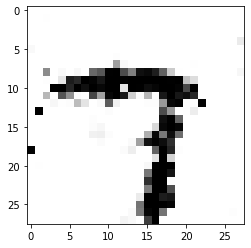

"\n#Uncomment to run this part of the code....\n##############################################\n\n# example of loading the generator model and generating images\nfrom keras.models import load_model\nfrom numpy.random import randn\nfrom matplotlib import pyplot as plt\n\n\n# generate points in latent space as input for the generator\ndef generate_latent_points(latent_dim, n_samples):\n\t# generate points in the latent space\n\tx_input = randn(latent_dim * n_samples)\n\t# reshape into a batch of inputs for the network\n\tx_input = x_input.reshape(n_samples, latent_dim)\n\treturn x_input\n\n# create and save a plot of generated images (reversed grayscale)\ndef save_plot(examples, n):\n\t# plot images\n\tfor i in range(n * n):\n\t\t# define subplot\n\t\tplt.subplot(n, n, 1 + i)\n\t\t# turn off axis\n\t\tplt.axis('off')\n\t\t# plot raw pixel data\n\t\tplt.imshow(examples[i, :, :, 0], cmap='gray_r')\n\tplt.show()\n\n# load model\nmodel = load_model('generator_model_100K.h5')\n# generate imag

In [7]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot


# load model
model = load_model('generator_model.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

"""
#Uncomment to run this part of the code....
##############################################

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator_model_100K.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16) 
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)

"""


1/1 [==============================] - 0s 18ms/step


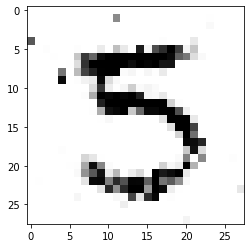

In [10]:
#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()